The objective of this Case Study is to Predict the bike rental count on a daily basis on the
environmental and seasonal settings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import statsmodels.api as sm
from scipy.stats import chi2_contingency

In [2]:
#!pip3 install xgboost

In [3]:
#Import the packages related to Machine Learning Algorithms
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.ensemble import RandomForestRegressor as RFR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [19]:
import os
import joblib
from collections import Counter, defaultdict

In [5]:
#Import the evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_squared_log_error

In [2]:
bike_rental = pd.read_csv('day.csv')

In [7]:
bike_rental.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [8]:
bike_rental.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [43]:
#Drop the column 'dteday'
bike_rental = bike_rental.drop('dteday', axis=1)

In [10]:
bike_rental.shape

(731, 15)

In [44]:
bike_rental.dtypes

instant          int64
season           int64
yr               int64
mnth             int64
holiday          int64
weekday          int64
workingday       int64
weathersit       int64
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
cnt              int64
root_casual    float64
dtype: object

## Missing Value Analysis

In [12]:
missing_value = pd.DataFrame({'Features':bike_rental.columns,'Missing Value Count':bike_rental.isna().sum(),'Missing Value Percentage':bike_rental.isna().sum()*100/bike_rental.shape[0]}, columns = ['Features','Missing Value Count','Missing Value Percentage'])

In [13]:
missing_value = missing_value.sort_values(by = 'Missing Value Count',ascending = False)

In [14]:
missing_value = missing_value.set_index('Features')

In [15]:
missing_value

,Missing Value Count,Missing Value Percentage
Features,,
instant,0,0.0
season,0,0.0
yr,0,0.0
mnth,0,0.0
holiday,0,0.0
weekday,0,0.0
workingday,0,0.0
weathersit,0,0.0
temp,0,0.0


## Categorical and Numeric Variables

In [45]:
categorical_variables = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
continuous_variables = list(set(bike_rental.columns).difference(set(categorical_variables)))
continuous_variables.remove('instant')

In [46]:
#Check the unique categories in categrical variables
for cat in categorical_variables:
    print(cat + ":- " + str(np.unique(np.array(bike_rental[cat]))))

season:- [1 2 3 4]
yr:- [0 1]
mnth:- [ 1  2  3  4  5  6  7  8  9 10 11 12]
holiday:- [0 1]
weekday:- [0 1 2 3 4 5 6]
workingday:- [0 1]
weathersit:- [1 2 3]


## Outlier Analysis

In [20]:
save_outliers = os.getcwd() + "/Plots/Normality/"
def plotting(variable):
    
    fig = plt.figure(figsize=(7,7))
    plt.boxplot(bike_rental[variable])
    plt.title(variable)
    plt.savefig(save_outliers + variable + " .png")

In [21]:
def outlier_analysis(variable):
    #Plot the boxplot
    plotting(variable)
    '''
    d = []
    d = input().split(' ')
    while(int(d[0]) >= int(d[1]) or int(d[0]) + int(d[1])!= 100):
        print("Please enter a valid range")
        d = input().split(' ')
    '''
    #Get the Quartiles
    q25,q75 = np.percentile(bike_rental[variable], [25, 75])
    
    #IQR
    IQR = q75-q25
    
    #Capping
    bike_rental.loc[bike_rental[variable]>(q75 + 1.5*IQR), variable] = (q75 + 1.5*IQR)
    bike_rental.loc[bike_rental[variable]<(q25 - 1.5*IQR), variable] = (q25 - 1.5*IQR)

In [14]:
list(map(outlier_analysis, continuous_variables))

NameError: name 'plotting' is not defined

In [15]:
#Cross check whether the outliers have been removed
#list(map(plotting, continuous_variables))

## Normatily Check

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efcaa041588>,
      dtype=object)

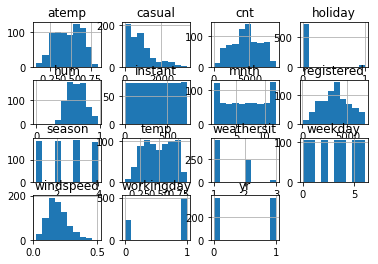

In [22]:
bike_rental.hist()

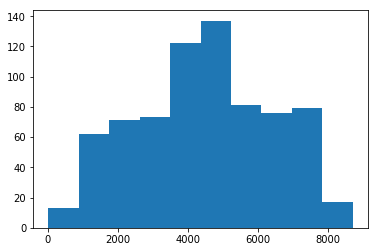

In [23]:
#The distribution of Registered users is same as Count
plt.hist(bike_rental['cnt'])
plt.savefig(save_outliers + " cnt.png")

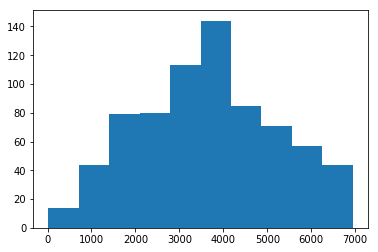

In [24]:
plt.hist(bike_rental['registered'])
plt.savefig(save_outliers + " registered.png")

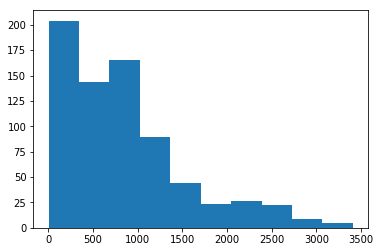

In [25]:
plt.hist(bike_rental['casual'])
plt.savefig(save_outliers + " casual.png")

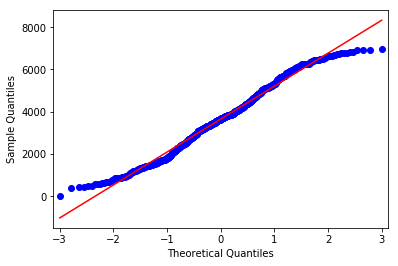

In [26]:
#Q-Q Plot
fig = sm.qqplot(bike_rental['registered'], line='s')
plt.savefig(save_outliers + "registered_qq.png")
plt.show()

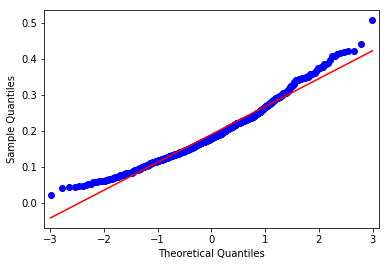

In [27]:
#Q-Q Plot
fig = sm.qqplot(bike_rental['windspeed'], line='s')
plt.savefig(save_outliers + "windspeed_qq.png")
plt.show()

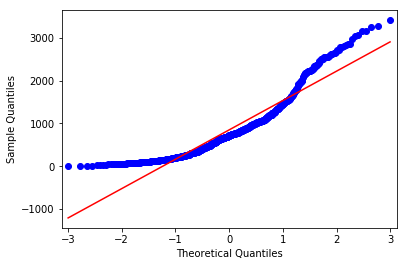

In [28]:
#Q-Q Plot
sm.qqplot(bike_rental['casual'], line='s')
plt.savefig(save_outliers + "casual_qq.png")
plt.show()

### Transformation - Log, Square, Cube, Square Root

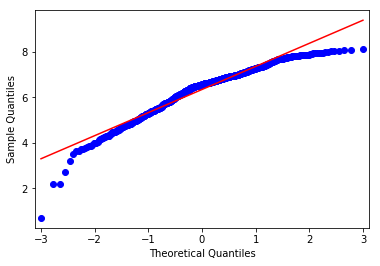

In [29]:
#Log transformation
log_casual = np.log(np.array(bike_rental['casual']))
#Q-Q Plot
fig = sm.qqplot(log_casual, line='s')
plt.savefig(save_outliers + "log_transformed_casual_qq.png")
plt.show()
#Histogram
#plt.hist(log_casual)

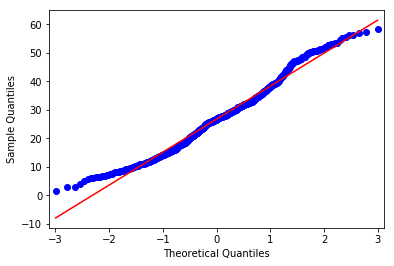

In [30]:
#Square Root Transformation
root_casual = np.sqrt(np.array(bike_rental['casual']))
#Q-Q Plot
fig = sm.qqplot(root_casual, line='s')
plt.savefig(save_outliers + "root_transformed_casual_qq.png")
plt.show()

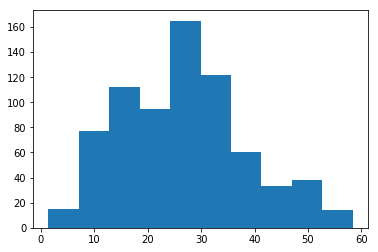

In [31]:
#Histogram
plt.hist(root_casual)
plt.savefig(save_outliers + 'root_casual_hist.png')

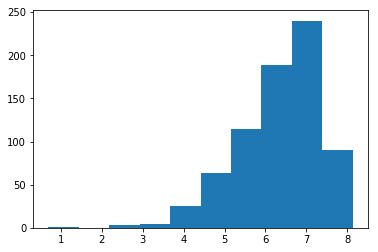

In [32]:
plt.hist(log_casual)
plt.savefig(save_outliers + 'log_casual_hist.png')

### Include root_casual in the data frame and add to the list of continuous variables

In [33]:
#Include root_casual in the data frame, 
#since it is more normally distributed than the log_casual.
bike_rental['root_casual'] = root_casual
continuous_variables.append('root_casual')

## Calculate the Month-wise Aggregate Bike Count

In [34]:
def monthly_avg_cnt(data, variable):
    #global monthly_count
    fig = plt.figure(figsize=(4,4))
    if(len(np.unique(np.array(data['yr']))) == 2):
        label, color = 'Year 2011 and Year 2012', 'Yellow'
    elif(data.loc[list(data.index)[0],'yr'] == 0):
        label, color = 'Year 2011', 'red'
    else:
        label, color = 'Year 2012', 'blue' 

    #Creating a dictionary to store monthly count
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    monthly_count = dict()
    for key in months:
        if(color=='yellow'):
            monthly_count[key] = 0
            continue
        monthly_count[key+label[-2:]] = 0 
    
    #Calculate the Month-wise Average 
    for mon in range(1,13):
        if(color=='yellow'):
            monthly_count[key] += np.sum(np.array(data.loc[data['mnth']==mon, variable]))
            continue
        monthly_count[months[mon-1]+label[-2:]] += np.sum(np.array(data.loc[data['mnth']==mon, variable]))
    
    #Create a data frame of Monthly Count and delete monthly count dictionary
    monthly_count_df = pd.DataFrame({'Months':list(monthly_count.keys()), 'Counts':list(monthly_count.values())}, columns=['Months', 'Counts'])
    #print(monthly_count_df)
    #Create a Plot
    plt.plot(monthly_count_df['Months'], monthly_count_df['Counts'], 'o-', color = color, label=label)
    plt.legend(loc="lower right")
    plt.xlabel('Months')
    plt.ylabel('Count')
    if(variable=='cnt'):
        variable = "Total"
    plt.title("Trend of Aggregate Monthly " + variable + " Count(Year wise)")
    plt.savefig(os.getcwd() + "/Plots/Trend " + variable + label + ".png")

## Calculate Monthly Count for All Users

[None]

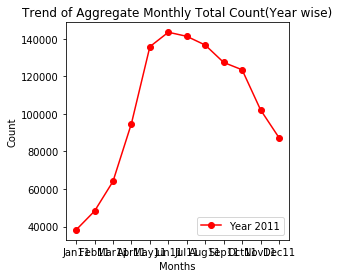

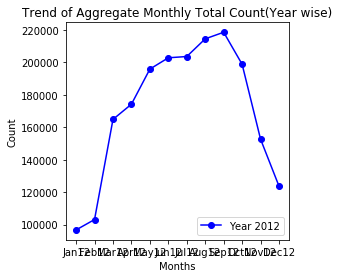

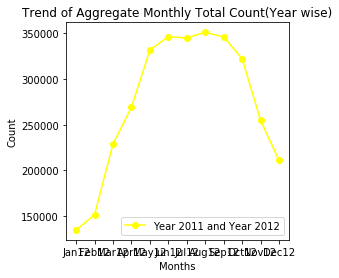

In [35]:
count_2011 = bike_rental[bike_rental['yr']==0]
count_2012 = bike_rental[bike_rental['yr']==1]
[monthly_avg_cnt(year, 'cnt') for year in [count_2011]]
[monthly_avg_cnt(year, 'cnt') for year in [count_2012]]
[monthly_avg_cnt(year, 'cnt') for year in [bike_rental]]

## Calculate Monthly Count for Casual Users and Registered Users

[None, None, None]

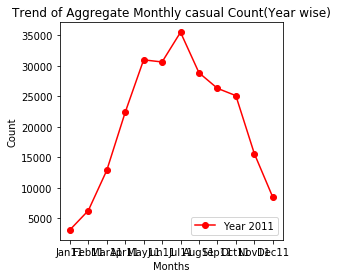

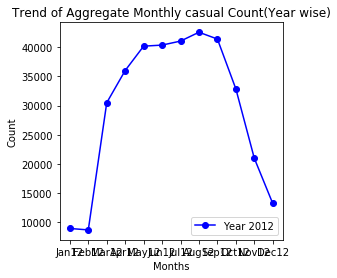

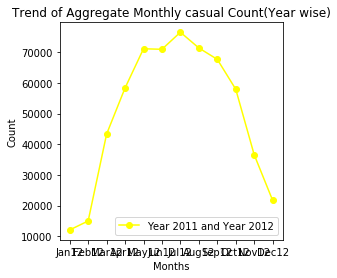

In [36]:
[monthly_avg_cnt(year, 'casual') for year in [count_2011, count_2012, bike_rental]]

[None, None, None]

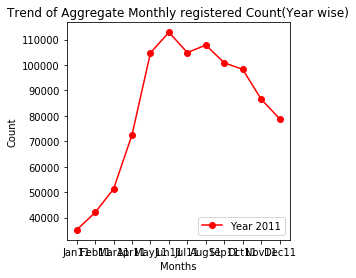

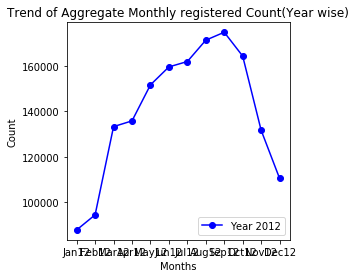

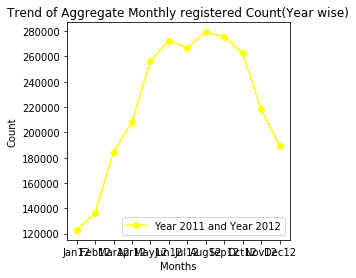

In [37]:
[monthly_avg_cnt(year, 'registered') for year in [count_2011, count_2012, bike_rental]]

## Correlation Analysis

In [54]:
def correlation(data):
    data_corr = data.corr()
    f,ax = plt.subplots(figsize=(11,11))
    sbn.heatmap(data_corr,#The correlation matrix
                mask = np.zeros_like(data_corr, dtype=np.bool), #Create a grid below
                cmap = sbn.diverging_palette(220,10,as_cmap=True), #Add color to map
                square = True,
                annot = True,
                ax = ax)
    plt.savefig(os.getcwd() + "/Plots/Correlation Chart.png")

In [37]:
continuous_variables

['registered',
 'hum',
 'atemp',
 'temp',
 'cnt',
 'casual',
 'root_casual',
 'dteday',
 'windspeed']

In [38]:
categorical_variables

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

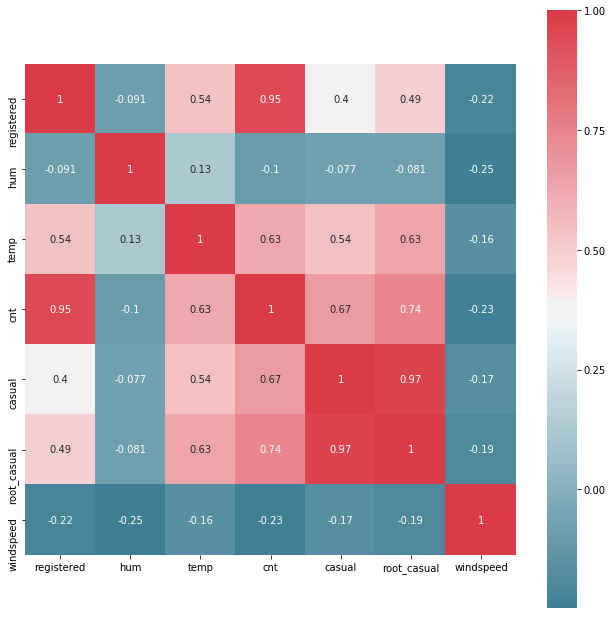

In [55]:
correlation(bike_rental[continuous_variables])

In [47]:
#Removing 'atemp'
continuous_variables.remove('atemp')

In [48]:
continuous_variables

['registered', 'hum', 'temp', 'cnt', 'casual', 'root_casual', 'windspeed']

In [4]:
#Find the Karl Pearson's Coefficient of Correlation
def Karl_Pearsons_Coeff(variable_tuple):
    v_0 = np.array(bike_rental[variable_tuple[0]])
    v_1 = np.array(bike_rental[variable_tuple[1]])
    
    v_0_mean = np.mean(v_0)
    v_1_mean = np.mean(v_1)
    
    numerator = np.mean(np.array([(ele_0-v_0_mean)*(ele_1-v_1_mean) for ele_0, ele_1 in zip(v_0,v_1)]))
    SD_v_0 = np.sqrt(np.mean(np.array([(ele_0-v_0_mean)**2 for ele_0 in v_0])))
    SD_v_1 = np.sqrt(np.mean(np.array([(ele_1-v_1_mean)**2 for ele_1 in v_1])))
    denominator = SD_v_0 * SD_v_1
    
    return (numerator/denominator)

In [49]:
#variable_check = ['instant', 'yr', 'temp', 'atemp', 'casual', 'root_casual', 'registered']
result_corr_target = [Karl_Pearsons_Coeff(('cnt',var)) for var in continuous_variables]

In [50]:
print("\n".join("Count and " + var + " " + str(ele) for ele,var in zip(result_corr_target, continuous_variables)))

Count and registered 0.9455169158090357
Count and hum -0.10065856213715525
Count and temp 0.6274940090334921
Count and cnt 0.9999999999999999
Count and casual 0.6728044333386831
Count and root_casual 0.7417505986211829
Count and windspeed -0.23454499742167004


In [53]:
help(np.correlate)

Help on function correlate in module numpy.core.numeric:

correlate(a, v, mode='valid')
    Cross-correlation of two 1-dimensional sequences.
    
    This function computes the correlation as generally defined in signal
    processing texts::
    
        c_{av}[k] = sum_n a[n+k] * conj(v[n])
    
    with a and v sequences being zero-padded where necessary and conj being
    the conjugate.
    
    Parameters
    ----------
    a, v : array_like
        Input sequences.
    mode : {'valid', 'same', 'full'}, optional
        Refer to the `convolve` docstring.  Note that the default
        is 'valid', unlike `convolve`, which uses 'full'.
    old_behavior : bool
        `old_behavior` was removed in NumPy 1.10. If you need the old
        behavior, use `multiarray.correlate`.
    
    Returns
    -------
    out : ndarray
        Discrete cross-correlation of `a` and `v`.
    
    See Also
    --------
    convolve : Discrete, linear convolution of two one-dimensional sequences.
    m

In [47]:
#VIF = (1-r**2)**(-1)
result_VIF_target = list(map(lambda r:(1-r**2)**(-1), result_corr_target))

In [48]:
print("\n".join("Count and " + var + " " + str(ele) for ele,var in zip(result_VIF_target, continuous_variables)))

Count and windspeed 1.0577485437163445
Count and casual 1.8818378361884236
Count and hum 1.0112910423292183
Count and registered 9.434161456771713
Count and cnt 4503599627370496.0
Count and temp 1.6494810844101202
Count and root_casual 2.238422862478736


## Chi-Squared Test

In [49]:
for cat in categorical_variables:
    print (cat)
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(bike_rental['cnt'], bike_rental[cat]))
    print("{}\t{}\t{}\t{}\n" .format(chi2, p, dof, ex))

season
2077.1965112648404	0.5440596338517547	2085	[[0.24760602 0.25170999 0.25718194 0.24350205]
 [0.24760602 0.25170999 0.25718194 0.24350205]
 [0.24760602 0.25170999 0.25718194 0.24350205]
 ...
 [0.24760602 0.25170999 0.25718194 0.24350205]
 [0.24760602 0.25170999 0.25718194 0.24350205]
 [0.24760602 0.25170999 0.25718194 0.24350205]]

yr
706.9999550864586	0.367724209978971	695	[[0.49931601 0.50068399]
 [0.49931601 0.50068399]
 [0.49931601 0.50068399]
 ...
 [0.49931601 0.50068399]
 [0.49931601 0.50068399]
 [0.49931601 0.50068399]]

mnth
7646.882611771365	0.49177634472851	7645	[[0.08481532 0.07797538 0.08481532 ... 0.08481532 0.08207934 0.08481532]
 [0.08481532 0.07797538 0.08481532 ... 0.08481532 0.08207934 0.08481532]
 [0.08481532 0.07797538 0.08481532 ... 0.08481532 0.08207934 0.08481532]
 ...
 [0.08481532 0.07797538 0.08481532 ... 0.08481532 0.08207934 0.08481532]
 [0.08481532 0.07797538 0.08481532 ... 0.08481532 0.08207934 0.08481532]
 [0.08481532 0.07797538 0.08481532 ... 0.08481

In [50]:
#Check the correlation amongst the independent categorical variables.

select_categorical = defaultdict(list)   #Contains the list of categorical variables that are selected

for cat_var_1 in categorical_variables:
    for cat_var_2 in categorical_variables:
        if(cat_var_1!=cat_var_2):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(bike_rental[cat_var_1], bike_rental[cat_var_2]))
            if(p>=0.05):
                
                select_categorical[cat_var_1].append(cat_var_2)
                

In [51]:
select_categorical

defaultdict(list,
            {'season': ['yr', 'holiday', 'weekday', 'workingday'],
             'yr': ['season',
              'mnth',
              'holiday',
              'weekday',
              'workingday',
              'weathersit'],
             'mnth': ['yr', 'holiday', 'weekday', 'workingday'],
             'holiday': ['season', 'yr', 'mnth', 'weathersit'],
             'weekday': ['season', 'yr', 'mnth', 'weathersit'],
             'workingday': ['season', 'yr', 'mnth', 'weathersit'],
             'weathersit': ['yr', 'holiday', 'weekday', 'workingday']})

In [52]:
select_categorical.keys()

dict_keys(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'])

In [53]:
select_categorical.values()

dict_values([['yr', 'holiday', 'weekday', 'workingday'], ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], ['yr', 'holiday', 'weekday', 'workingday'], ['season', 'yr', 'mnth', 'weathersit'], ['season', 'yr', 'mnth', 'weathersit'], ['season', 'yr', 'mnth', 'weathersit'], ['yr', 'holiday', 'weekday', 'workingday']])

### Monthly Aggregate Rental Count when Weather is Cloudy(1 or 2) and it's a Holiday

In [54]:
holiday = bike_rental.loc[(bike_rental['workingday']==0) & ((bike_rental['weathersit'] == 1) | ((bike_rental['weathersit'] == 2))), ["workingday","weathersit","yr","mnth","cnt"]]

[None, None, None]

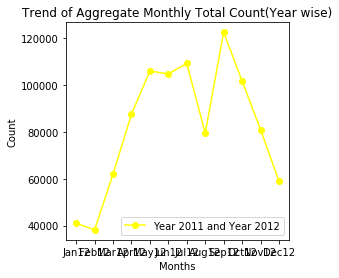

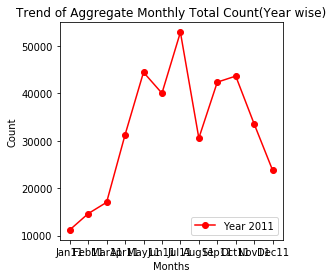

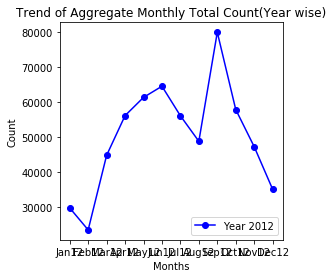

In [55]:
#Find the monthly average count
holiday_2011 = holiday[holiday['yr']==0]
holiday_2012 = holiday[holiday['yr']==1]
[monthly_avg_cnt(holi, 'cnt') for holi in [holiday, holiday_2011, holiday_2012]]

### Monthly Aggregate Rental Count when Weather is Cloudy(1 or 2) and it's a Working day

In [56]:
working_day = bike_rental.loc[(bike_rental['workingday']==1) & ((bike_rental['weathersit'] == 1) | ((bike_rental['weathersit'] == 2))), ["workingday","weathersit","yr","mnth","cnt"]]

[None, None, None]

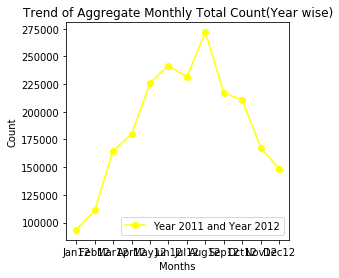

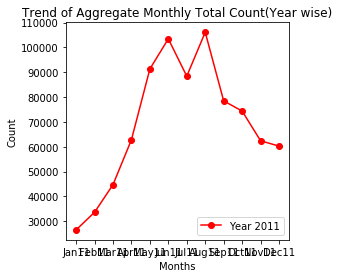

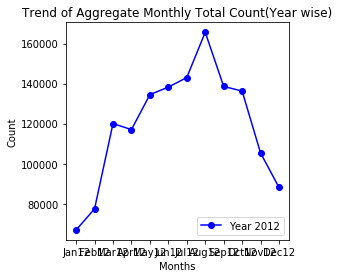

In [57]:
#Find the monthly average count
working_day_2011 = working_day[working_day['yr']==0]
working_day_2012 = working_day[working_day['yr']==1]
[monthly_avg_cnt(working, 'cnt') for working in [working_day, working_day_2011, working_day_2012]]

### Monthly Aggregate Rental Count when Weather is Rainy or Snowy(3 or 4) and it's a Holiday

In [58]:
#Rainy Weather
holiday_rainy = bike_rental.loc[(bike_rental['workingday']==0) & (bike_rental['weathersit'] == 3), ["workingday","weathersit","yr","mnth","cnt"]]

[None, None, None]

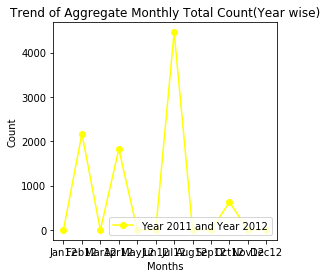

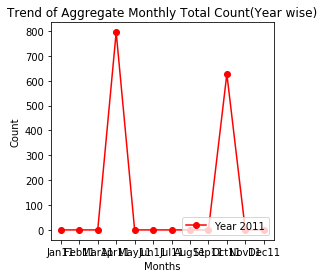

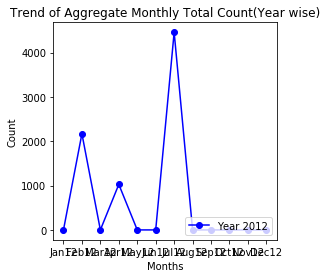

In [59]:
#Find the monthly average count
holiday_rainy_2011 = holiday_rainy[holiday_rainy['yr']==0]
holiday_rainy_2012 = holiday_rainy[holiday_rainy['yr']==1]
[monthly_avg_cnt(holi_rainy, 'cnt') for holi_rainy in [holiday_rainy, holiday_rainy_2011, holiday_rainy_2012]]

In [60]:
#Compare the rainy Holidays of 2012 and 2011
holiday_rainy_2011

,workingday,weathersit,yr,mnth,cnt
105,0,3,0,4,795.0
301,0,3,0,10,627.0


In [61]:
holiday_rainy_2012

,workingday,weathersit,yr,mnth,cnt
406,0,3,1,2,2169.0
477,0,3,1,4,1027.0
567,0,3,1,7,4459.0


In [62]:
#Heavily Snowy Weather
holiday_snowy = bike_rental.loc[(bike_rental['workingday']==0) & (bike_rental['weathersit'] == 4), ["workingday","weathersit","yr","mnth","cnt"]]

In [63]:
holiday_snowy

,workingday,weathersit,yr,mnth,cnt


In [64]:
'''
#Find the monthly average count
holiday_snowy_2011 = holiday_snowy[holiday_snowy['yr']==0]
holiday_snowy_2012 = holiday_snowy[holiday_snowy['yr']==1]
[monthly_avg_cnt(holi_snowy, 'cnt') for holi_snowy in [holiday_snowy, holiday_snowy_2011, holiday_snowy_2012]]
'''

"\n#Find the monthly average count\nholiday_snowy_2011 = holiday_snowy[holiday_snowy['yr']==0]\nholiday_snowy_2012 = holiday_snowy[holiday_snowy['yr']==1]\n[monthly_avg_cnt(holi_snowy, 'cnt') for holi_snowy in [holiday_snowy, holiday_snowy_2011, holiday_snowy_2012]]\n"

In [65]:
#Rainy or Snowy
holiday_rainy_snowy = bike_rental.loc[(bike_rental['workingday']==0) & ((bike_rental['weathersit'] == 3) | ((bike_rental['weathersit'] == 4))), ["workingday","weathersit","yr","mnth","cnt"]]

In [66]:
holiday_rainy_snowy

,workingday,weathersit,yr,mnth,cnt
105,0,3,0,4,795.0
301,0,3,0,10,627.0
406,0,3,1,2,2169.0
477,0,3,1,4,1027.0
567,0,3,1,7,4459.0


[None, None, None]

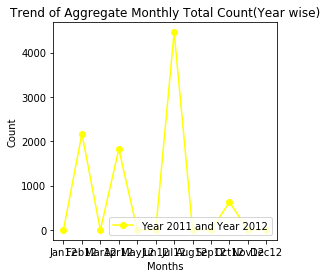

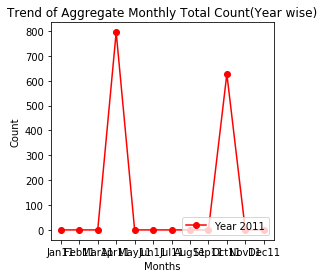

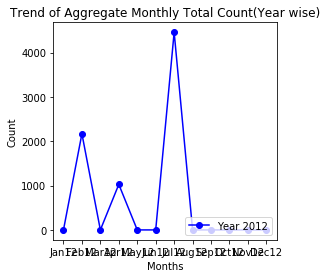

In [67]:
#Find the monthly average count

holiday_rainy_snowy_2011 = holiday_rainy_snowy[holiday_rainy_snowy['yr']==0]
holiday_rainy_snowy_2012 = holiday_rainy_snowy[holiday_rainy_snowy['yr']==1]
[monthly_avg_cnt(holi_rainy_snowy, 'cnt') for holi_rainy_snowy in [holiday_rainy_snowy, holiday_rainy_snowy_2011, holiday_rainy_snowy_2012]]

### Monthly Aggregate Rental Count when Weather is Rainy or Snowy(3 or 4) and it's a Working day

In [68]:
#Rainy Weather
workingday_rainy = bike_rental.loc[(bike_rental['workingday']==1) & (bike_rental['weathersit'] == 3), ["workingday","weathersit","yr","mnth","cnt"]]

[None, None, None]

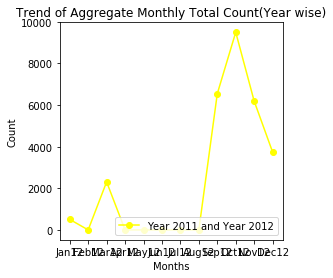

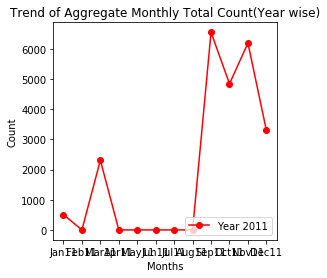

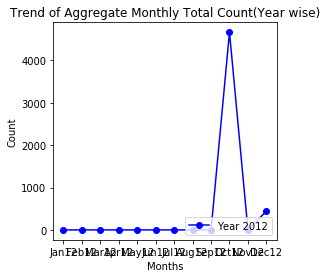

In [69]:
#Find the monthly average count
workingday_rainy_2011 = workingday_rainy[workingday_rainy['yr']==0]
workingday_rainy_2012 = workingday_rainy[workingday_rainy['yr']==1]
[monthly_avg_cnt(working_rainy, 'cnt') for working_rainy in [workingday_rainy, workingday_rainy_2011, workingday_rainy_2012]]

In [70]:
#Heavily Snowy Weather
workingday_snowy = bike_rental.loc[(bike_rental['workingday']==1) & (bike_rental['weathersit'] == 4), ["workingday","weathersit","yr","mnth","cnt"]]

In [71]:
workingday_snowy

,workingday,weathersit,yr,mnth,cnt


In [72]:
#Rainy or Snowy
workingday_rainy_snowy = bike_rental.loc[(bike_rental['workingday']==1) & ((bike_rental['weathersit'] == 3) | ((bike_rental['weathersit'] == 4))), ["workingday","weathersit","yr","mnth","cnt"]]

[None, None, None]

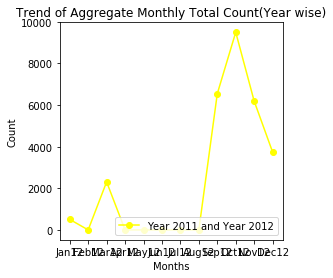

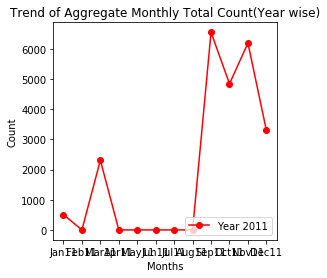

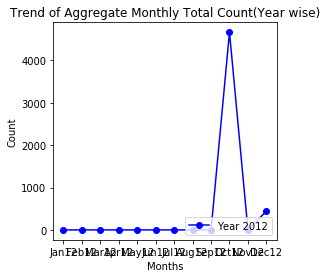

In [73]:
#Find the monthly average count

workingday_rainy_snowy_2011 = workingday_rainy_snowy[workingday_rainy_snowy['yr']==0]
workingday_rainy_snowy_2012 = workingday_rainy_snowy[workingday_rainy_snowy['yr']==1]
[monthly_avg_cnt(working_rainy_snowy, 'cnt') for working_rainy_snowy in [workingday_rainy_snowy, workingday_rainy_snowy_2011, workingday_rainy_snowy_2012]]

## Feature Selection

In [74]:
continuous_variables

['windspeed', 'casual', 'hum', 'registered', 'cnt', 'temp', 'root_casual']

In [75]:
categorical_variables

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

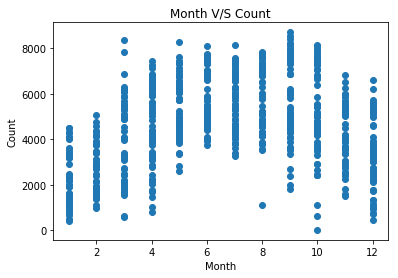

In [76]:
#Month wise count
plt.scatter(bike_rental['mnth'], bike_rental['cnt'])
plt.title("Month V/S Count")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

In [77]:
#Splitting the data
ind_variables = continuous_variables + categorical_variables
ind_variables.remove('cnt')

In [78]:
Karl_Pearsons_Coeff(('casual', 'root_casual'))

0.9748099459126068

In [79]:
np.corrcoef(bike_rental['casual'], bike_rental['root_casual'])

array([[1.        , 0.97480995],
       [0.97480995, 1.        ]])

In [80]:
type(ind_variables.remove('casual'))

NoneType

In [81]:
'casual' in ind_variables

False

In [82]:
#Independent Variables
ind_variables

['windspeed',
 'hum',
 'registered',
 'temp',
 'root_casual',
 'season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit']

In [126]:
ind_variables.remove('registered')
ind_variables.remove('root_casual')

## Problematic Value

In [83]:
min(y)

NameError: name 'y' is not defined

In [ ]:
max(y)

In [ ]:
sm.qqplot(y, line='s')

In [ ]:
sorted_target = sorted(y)

In [ ]:
sorted_target[:5]

In [ ]:
#Capping the value with value nearest to it

### Splitting The Data

In [127]:

X = bike_rental[ind_variables]
y = bike_rental['cnt']

In [128]:
#Splitting the data into training and testing set
def splitting_data(X, y, case='time series'):
    if(case!='time series'):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)
        return(X_train, X_test, y_train, y_test)
    
    #Receive the independent and dependent variables as input
    ind = list(X.loc[(X['mnth']==6) & (X['yr']==1), :].index)[0]
    
    X_train, X_test, y_train, y_test = X.iloc[:ind,:], X.iloc[ind:,:], y[:ind], y[ind:]

    y_train, y_test = np.array(y_train).reshape(len(y_train), 1), np.array(y_test).reshape(len(y_test), 1)
    return(X_train, X_test, y_train, y_test)

In [129]:
X_train, X_test, y_train, y_test = splitting_data(X,y)

In [130]:
print("X_train:- {}\tX_test:- {}\ny_train:- {}\ty_test:- {}\n" .format(X_train.shape,X_test.shape, y_train.shape, y_test.shape))

X_train:- (517, 10)	X_test:- (214, 10)
y_train:- (517, 1)	y_test:- (214, 1)



In [136]:
X_train.isna().sum()

windspeed     0
hum           0
temp          0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
dtype: int64

In [134]:
X_train.isna().sum()

windspeed     0
hum           0
temp          0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
dtype: int64

In [137]:
np.nan in np.unique(np.array(y_train))

False

In [132]:
class Modelling():
    base_path = os.getcwd() + "/Models/"
    def __init__(self, X_train, X_test, y_train, y_test, model, model_name):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model
        self.model_name = model_name
        
    def evaluate(self, actual, predicted):
        actual = list(actual)
        predicted = list(predicted)
        result_df = pd.DataFrame({'Actual':actual, 'Predicted':predicted}, columns=['Actual','Predicted'])
        print("RMSE:- {}\nR_Squared:- {}\n" .format(np.sqrt(mean_squared_error(actual, predicted)), r2_score(actual, predicted)))
        print("RMSLE:- {}\n" .format(np.sqrt(mean_squared_log_error(actual, predicted))))
    
    def prediction(self):
        #Fit the model on training data
        model_fit = self.model.fit(self.X_train, self.y_train)
        
        #Save the Model
        joblib.dump(model_fit, self.base_path + self.model_name)
        
        #Predict on Training and Testing Data
        predicted_train = model_fit.predict(self.X_train)
        predicted_test = model_fit.predict(self.X_test)
        #temp_y_test = self.y_test
        '''
        if(self.model_name=='Linear Regression' and (22 in list(self.y_test))):
            #Check weather predicted the actual value contains problamatic value 22.0
            
            ind = [i for i in range(len(self.y_test)) if(temp_y_test[i]==22.0)]
                temp_y_test[ind[0]] = 431  
        '''
        #Evaluate the Performance
        print("Results obtained on Training Data:-")
        self.evaluate(self.y_train, predicted_train)
        
        print("Results obtained on Testing Data:-")
        self.evaluate(self.y_test, predicted_test)
        

In [92]:
class Modelling():
    base_path = os.getcwd() + "/Models/"
    def __init__(self, X_train, X_test, y_train, y_test, model, model_name):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model
        self.model_name = model_name
        
    def evaluate(self, actual, predicted):
        actual = list(actual)
        predicted = list(predicted)
        result_df = pd.DataFrame({'Actual':actual, 'Predicted':predicted}, columns=['Actual','Predicted'])
        print("RMSE:- {}\nR_Squared:- {}\n" .format(np.sqrt(mean_squared_error(actual, predicted)), r2_score(actual, predicted)))
        print("RMSLE:- {}\n" .format(np.sqrt(mean_squared_log_error(actual, predicted))))
    
    def prediction(self):
        #Fit the model on training data
        model_fit = self.model.fit(self.X_train, self.y_train)
        
        #Save the Model
        joblib.dump(model_fit, self.base_path + self.model_name)
        
        #Predict on Training and Testing Data
        predicted_train = model_fit.predict(self.X_train)
        predicted_test = model_fit.predict(self.X_test)
        temp_y_test = self.y_test
        if(self.model_name=='Linear Regression' and (22 in list(self.y_test))):
            #Check weather predicted the actual value contains problamatic value 22.0
            ind = [i for i in range(len(self.y_test)) if(temp_y_test[i]==22.0)]
            temp_y_test[ind[0]] = 431.0
            
        #Evaluate the Performance
        print("Results obtained on Training Data:-")
        self.evaluate(self.y_train, predicted_train)
        
        print("Results obtained on Testing Data:-")
        self.evaluate(temp_y_test, predicted_test)
        
        del temp_y_test

### Simple Linear Regression

In [95]:
lr = LR()
linear = Modelling(X_train, X_test, y_train, y_test, lr, "Linear Regression")

In [96]:
linear.prediction()

Results obtained on Training Data:-
RMSE:- 177.39681542248957
R_Squared:- 0.9877573814301756

Results obtained on Testing Data:-
RMSE:- 226.0697228694105
R_Squared:- 0.9816956308955946



In [97]:
y_train[150]

array([3982.])

In [98]:
y_test[150]

array([22.])

In [138]:
#Consider only continuous variables
feature_list_2 = [var for var in ind_variables if(var not in categorical_variables)]

In [139]:
linear_feature_list_2 = Modelling(X_train[feature_list_2], X_test[feature_list_2], y_train, y_test, lr, "Linear Regression_feature_list_2")

In [140]:
linear_feature_list_2.prediction()

Results obtained on Training Data:-
RMSE:- 1168.3478558083193
R_Squared:- 0.4689602726146074

RMSLE:- 0.36981548540680453

Results obtained on Testing Data:-
RMSE:- 2132.8987310281295
R_Squared:- -0.6293351717164044

RMSLE:- 0.5322522960557249



In [141]:
select_categorical['season']

['yr', 'holiday', 'weekday', 'workingday']

In [143]:
feature_list_3 = feature_list_2 + select_categorical['season']

In [144]:
linear_feature_list_3 = Modelling(X_train[feature_list_3], X_test[feature_list_3], y_train, y_test, lr, "Linear Regression_feature_list_3")

In [145]:
linear_feature_list_3.prediction()

Results obtained on Training Data:-
RMSE:- 852.5632559938251
R_Squared:- 0.7172283258218851

RMSLE:- 0.28582123849682445

Results obtained on Testing Data:-
RMSE:- 1332.7894412558724
R_Squared:- 0.36380090385560715

RMSLE:- 0.46367628423599444



In [146]:
feature_list_4 = feature_list_2 + select_categorical['weathersit']

In [147]:
linear_feature_list_4 = Modelling(X_train[feature_list_4], X_test[feature_list_4], y_train, y_test, lr, "Linear Regression_feature_list_4")

In [148]:
linear_feature_list_4.prediction()

Results obtained on Training Data:-
RMSE:- 852.5632559938251
R_Squared:- 0.7172283258218851

RMSLE:- 0.28582123849682445

Results obtained on Testing Data:-
RMSE:- 1332.7894412558724
R_Squared:- 0.36380090385560715

RMSLE:- 0.46367628423599444



In [157]:
feature_list_5 = feature_list_2 + select_categorical['mnth']

In [158]:
linear_feature_list_5 = Modelling(X_train[feature_list_5], X_test[feature_list_5], y_train, y_test, lr, "Linear Regression_feature_list_5")

In [159]:
linear_feature_list_5.prediction()

Results obtained on Training Data:-
RMSE:- 852.5632559938251
R_Squared:- 0.7172283258218851

RMSLE:- 0.28582123849682445

Results obtained on Testing Data:-
RMSE:- 1332.7894412558724
R_Squared:- 0.36380090385560715

RMSLE:- 0.46367628423599444



### XGBoost Regression

In [113]:
help(xgb)

Help on package xgboost:

NAME
    xgboost - XGBoost: eXtreme Gradient Boosting library.

DESCRIPTION
    Contributors: https://github.com/dmlc/xgboost/blob/master/CONTRIBUTORS.md

PACKAGE CONTENTS
    callback
    compat
    core
    libpath
    plotting
    rabit
    sklearn
    training

CLASSES
    builtins.object
        xgboost.core.Booster
        xgboost.core.DMatrix
    sklearn.base.BaseEstimator(builtins.object)
        xgboost.sklearn.XGBModel
            xgboost.sklearn.XGBClassifier(xgboost.sklearn.XGBModel, sklearn.base.ClassifierMixin)
            xgboost.sklearn.XGBRanker
            xgboost.sklearn.XGBRegressor(xgboost.sklearn.XGBModel, sklearn.base.RegressorMixin)
    
    class Booster(builtins.object)
     |  A Booster of XGBoost.
     |  
     |  Booster is the model of xgboost, that contains low level routines for
     |  training, prediction and evaluation.
     |  
     |  Methods defined here:
     |  
     |  __copy__(self)
     |  
     |  __deepcopy__(self, 

In [114]:
help(xgb.XGBRegressor)

Help on class XGBRegressor in module xgboost.sklearn:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  
 |  Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of boosted trees to fit.
 |  silent : boolean
 |      Whether to print messages while running boosting.
 |  objective : string or callable
 |      Specify the learning task and the corresponding learning objective or
 |      a custom objective function to be used (see note below).
 |  booster: string
 |      Specify which booster to use: gbtree, gblinear or dart.
 |  nthread : int
 |      Number of parallel threads used to run xgboost.  (Deprecated, please use ``n_jobs``)
 |  n_jobs : int
 |      Number of parallel threads used to run xgboost.  (replaces ``nthread``)
 |  gamma : float
 |      Minimum lo

In [115]:
learning_rate = [0.1, 0.08, 0.06, 0.04, 0.02, 0.01]
n_estimators = [100, 150, 200, 250, 300, 350, 400]
booster = ['gbtree', 'gblinear', 'dart']
objective = ['reg:linear', 'reg:tweedie']
nthread = [4]
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9]  #Percentage of rows taken to build a tree.
#Booster Parameters
min_child_weight = [2, 4, 6, 8, 10, 12, 14, 16] #Minimum sum of instance weight(hessian) needed in a child.
#min_samples_split = []

max_depth = [2, 4, 6, 8]
max_leaf_nodes = [2, 4, 6, 8]
#max_delta_step = []  #Maximum delta step we allow each tree's weight estimation to be.

gamma = [0, 1, 5] #Acts as Regularization Parameter
#reg_lambda = []


In [116]:
#Create a Grid of Parameter Values
xgb_grid_keys = {'booster': booster, 
        'objective': objective, 
        'max_depth': max_depth, 
        'eta': learning_rate,
        'n_estimators': n_estimators,
        'nthread': nthread, 
        'min_child_weight': min_child_weight, 
        'subsample': subsample, 
        'gamma': gamma, 
        'max_leaf_nodes': max_leaf_nodes}

In [119]:
xgb_grid_keys_list = list(xgb_grid_keys.keys())

In [ ]:
#xgb_grid_keys_list

In [117]:
def xgb_trial(X_train,X_test, y_train, y_test):
    for boost in xgb_grid_keys[xgb_grid_keys_list[0]]:
        for obj in xgb_grid_keys[xgb_grid_keys_list[1]]:
            for max_depth in xgb_grid_keys[xgb_grid_keys_list[2]]:
                for eta in xgb_grid_keys[xgb_grid_keys_list[3]]:
                    for n_est in xgb_grid_keys[xgb_grid_keys_list[4]]:
                        for nthread in xgb_grid_keys[xgb_grid_keys_list[5]]:
                            for mcw in xgb_grid_keys[xgb_grid_keys_list[6]]:
                                for sub_samp in xgb_grid_keys[xgb_grid_keys_list[7]]:
                                    for gamma in xgb_grid_keys[xgb_grid_keys_list[8]]:
                                        for mln in xgb_grid_keys[xgb_grid_keys_list[9]]:
                                            #print("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}" .format(boost, obj,
                                            #                  max_depth, eta,
                                            #                  n_est, nthread,
                                            #                  mcw, sub_samp,
                                            #                  gamma, mln))
                                            xgb_model = xgb.XGBRegressor(booster=boost,
                                                   objective=obj,
                                                   max_depth=max_depth,
                                                   eta = eta,
                                                   n_estimators = n_est,
                                                   nthread = nthread,
                                                   min_child_weight = mcw,
                                                   subsample = sub_samp,
                                                   gamma = gamma,
                                                   max_leaf_nodes = mln)
                                            xgb_model = Modelling(X_train, X_test, y_train, y_test, xgb_model, "XGBoost Regression")
                                            xgb_model.prediction()

In [155]:
xgb_trial(X_train,X_test, y_train, y_test)

Results obtained on Training Data:-
RMSE:- 526.7827282530436
R_Squared:- 0.8920442609665092



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:314: RuntimeWarning: invalid value encountered in log
  return mean_squared_error(np.log(y_true + 1), np.log(y_pred + 1),


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## Random Forest Regression

In [ ]:
help(RFR)

In [ ]:
rfr = RFR(n_estimators = 100, max_features = 8, max_depth=6, min_samples_split = 2, min_samples_leaf=2)

In [ ]:
rfr.fit(X_train, y_train)

In [ ]:
#Test Error
predicted_rf = rfr.predict(X_test)
np.sqrt(mean_squared_log_error(y_test, predicted_rf))

In [ ]:
#Test R-Squared
r2_score(y_test, predicted_rf)

In [ ]:
#Train Error
predicted_train_rf = rfr.predict(X_train)
np.sqrt(mean_squared_log_error(y_train, predicted_train_rf))

In [ ]:
#Train R-Squared
r2_score(y_train, predicted_train_rf)

### Check the results when out of bag samples are used to estimate the $R^2$ on Unseen data 

In [ ]:
rfr_oob = RFR(n_estimators=100, max_features = 8, max_depth=6, min_samples_split= 2, min_samples_leaf=2, oob_score=True)

In [ ]:
rfr_oob.fit(X_train, y_train)

In [ ]:
#Test Error
predicted_rf_oob = rfr_oob.predict(X_test)
np.sqrt(mean_squared_log_error(y_test, predicted_rf))

In [ ]:
#Test R-Squared
r2_score(y_test, predicted_rf_oob)

In [ ]:
#Train Error
predicted_train_rf_oob = rfr.predict(X_train)
np.sqrt(mean_squared_log_error(y_train, predicted_train_rf_oob))

## Random Forest Trials

In [152]:
n_estimators = [100, 150, 180, 200, 210, 230, 245, 265,290, 300, 350, 400, 450, 500]

#The minimum number of samples required to split an internal node
min_samples_split = [5, 10, 15, 20, 25, 30, 35,40]

#The minimum number of samples required to be at a leaf node
min_samples_leaf = [2,4,6]

max_depth = [4, 6, 8, 10, 12, 14, 16]
'''
Grow trees with ``max_leaf_nodes`` in best-first fashion.
Best nodes are defined as relative reduction in impurity.
If None then unlimited number of leaf nodes.
'''
max_leaf_nodes = [4, 6, 8, 10, 12, None]

max_features = [4, 6, 8, 10, 12]


In [153]:
def rf_trial(X_train,X_test, y_train, y_test):
    for n_est in n_estimators:
        for mss in min_samples_split:
            for msl in min_samples_leaf:
                for mln in max_leaf_nodes:
                    for md in max_depth:
                        for mf in max_features:
                            print("{}\t{}\t{}\t{}\t{}\t{}" .format(n_est, mss,
                                                              msl, mln,
                                                              md, mf))
                            rfr = RFR(n_estimators = n_est, 
                                      max_features = mss, 
                                      max_depth = md, 
                                      min_samples_split = mss, 
                                      min_samples_leaf = msl)
                            rf_model = Modelling(X_train, X_test, y_train, y_test, rfr, "Random Forest Regression")
                            rf_model.prediction()

In [154]:
rf_trial(X_train, X_test, y_train, y_test)

100	5	2	4	4	4
Results obtained on Training Data:-
RMSE:- 603.2156958486179
R_Squared:- 0.8584441091186041

RMSLE:- 0.23446588986893988

Results obtained on Testing Data:-
RMSE:- 1316.4977081854531
R_Squared:- 0.37925936574377994

RMSLE:- 0.46282444228442937

100	5	2	4	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 606.5523673125335
R_Squared:- 0.8568737526678584

RMSLE:- 0.23618969736982165

Results obtained on Testing Data:-
RMSE:- 1338.1241026559373
R_Squared:- 0.3586977736383933

RMSLE:- 0.46578374676523226

100	5	2	4	4	8
Results obtained on Training Data:-
RMSE:- 609.5274606620496
R_Squared:- 0.8554662625247615

RMSLE:- 0.23851134340106298

Results obtained on Testing Data:-
RMSE:- 1329.836506054088
R_Squared:- 0.36661691285102993

RMSLE:- 0.463674861524433

100	5	2	4	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 607.0021917544722
R_Squared:- 0.8566613866437237

RMSLE:- 0.23303389197463

Results obtained on Testing Data:-
RMSE:- 1397.821313463351
R_Squared:- 0.3002010651351118

RMSLE:- 0.4691276000297936

100	5	2	4	4	12
Results obtained on Training Data:-
RMSE:- 615.8446120956203
R_Squared:- 0.8524548382532536

RMSLE:- 0.23693999677150562

Results obtained on Testing Data:-
RMSE:- 1414.0396108712703
R_Squared:- 0.28386794872113663

RMSLE:- 0.4680638177692869

100	5	2	4	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 450.28018656131565
R_Squared:- 0.9211233685511158

RMSLE:- 0.17877019572300754

Results obtained on Testing Data:-
RMSE:- 1148.686776193826
R_Squared:- 0.5274223223735477

RMSLE:- 0.44124226299206093

100	5	2	4	6	6
Results obtained on Training Data:-
RMSE:- 453.4189040841996
R_Squared:- 0.9200199030556636

RMSLE:- 0.179075248957085

Results obtained on Testing Data:-
RMSE:- 1145.8982493761023
R_Squared:- 0.5297139758147476

RMSLE:- 0.4428484467417341

100	5	2	4	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 456.1192366921702
R_Squared:- 0.9190644246927809

RMSLE:- 0.1802975101799663

Results obtained on Testing Data:-
RMSE:- 1239.2707283996072
R_Squared:- 0.4499497779072277

RMSLE:- 0.44901204060432676

100	5	2	4	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 457.3858955442349
R_Squared:- 0.9186142787557839

RMSLE:- 0.18352178039652037

Results obtained on Testing Data:-
RMSE:- 1206.1680923857975
R_Squared:- 0.4789425233050585

RMSLE:- 0.4476829604773698

100	5	2	4	6	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 459.4274011575692
R_Squared:- 0.9178861399752608

RMSLE:- 0.1812319003155237

Results obtained on Testing Data:-
RMSE:- 1138.0977032031117
R_Squared:- 0.5360949987068218

RMSLE:- 0.44463709509865823

100	5	2	4	8	4
Results obtained on Training Data:-
RMSE:- 375.7587687044491
R_Squared:- 0.9450710966416322

RMSLE:- 0.1574319132977849

Results obtained on Testing Data:-
RMSE:- 1132.0526527691131
R_Squared:- 0.5410100099042603

RMSLE:- 0.4425957703710667

100	5	2	4	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 373.5563385884331
R_Squared:- 0.9457131177485483

RMSLE:- 0.15479766404303277

Results obtained on Testing Data:-
RMSE:- 1146.626045323123
R_Squared:- 0.5291163992734489

RMSLE:- 0.4405620369875142

100	5	2	4	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 381.8725626487329
R_Squared:- 0.9432691106764075

RMSLE:- 0.16151817217649128

Results obtained on Testing Data:-
RMSE:- 1192.0182379752264
R_Squared:- 0.4910961209728065

RMSLE:- 0.4472132368659289

100	5	2	4	8	10
Results obtained on Training Data:-
RMSE:- 378.7443191463467
R_Squared:- 0.9441947657627323

RMSLE:- 0.16092789974876648

Results obtained on Testing Data:-
RMSE:- 1221.5056340784486
R_Squared:- 0.46560681660271763

RMSLE:- 0.447853574081426

100	5	2	4	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 374.75684449313303
R_Squared:- 0.9453636312705035

RMSLE:- 0.1571331049391847

Results obtained on Testing Data:-
RMSE:- 1229.8005214909876
R_Squared:- 0.45832435820559636

RMSLE:- 0.4480819346685762

100	5	2	4	10	4
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 349.468953781818
R_Squared:- 0.9524883754863804

RMSLE:- 0.15469080392698822

Results obtained on Testing Data:-
RMSE:- 1197.1712232116877
R_Squared:- 0.4866867214638102

RMSLE:- 0.4459528022818866

100	5	2	4	10	6
Results obtained on Training Data:-
RMSE:- 343.27572418294875
R_Squared:- 0.9541574397520757

RMSLE:- 0.1518238973046228

Results obtained on Testing Data:-
RMSE:- 1193.645358688417
R_Squared:- 0.48970585165565417

RMSLE:- 0.4428283008902692

100	5	2	4	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 345.03147591694636
R_Squared:- 0.9536872987821674

RMSLE:- 0.14832760726431848

Results obtained on Testing Data:-
RMSE:- 1167.035751832341
R_Squared:- 0.5122039465309738

RMSLE:- 0.4469173173228364

100	5	2	4	10	10
Results obtained on Training Data:-
RMSE:- 346.02356779854654
R_Squared:- 0.9534205839196168

RMSLE:- 0.15418601163717285

Results obtained on Testing Data:-
RMSE:- 1223.2205703674836
R_Squared:- 0.46410523762722355

RMSLE:- 0.4446939313745536

100	5	2	4	10	12
Results obtained on Training Data:-
RMSE:- 346.2392813448338
R_Squared:- 0.9533624899404757

RMSLE:- 0.1508081645327575

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1174.8026198084794
R_Squared:- 0.5056895708349805

RMSLE:- 0.44742440314133497

100	5	2	4	12	4
Results obtained on Training Data:-
RMSE:- 337.32645042794644
R_Squared:- 0.9557326552142991

RMSLE:- 0.1516148431164945

Results obtained on Testing Data:-
RMSE:- 1158.9434877370104
R_Squared:- 0.5189452804981816

RMSLE:- 0.4445269003627512

100	5	2	4	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 339.56744762098197
R_Squared:- 0.9551425294280675

RMSLE:- 0.14953027186348897

Results obtained on Testing Data:-
RMSE:- 1190.2013930789653
R_Squared:- 0.4926462562979457

RMSLE:- 0.446299135552663

100	5	2	4	12	8
Results obtained on Training Data:-
RMSE:- 339.782263775208
R_Squared:- 0.955085756275237

RMSLE:- 0.15128932791709643

Results obtained on Testing Data:-
RMSE:- 1214.2426971005214
R_Squared:- 0.4719428090400607

RMSLE:- 0.4535470766268918

100	5	2	4	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 334.063230641198
R_Squared:- 0.9565849771546764

RMSLE:- 0.14995767784728964

Results obtained on Testing Data:-
RMSE:- 1208.1532851574634
R_Squared:- 0.47722592876878644

RMSLE:- 0.4461917943650365

100	5	2	4	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 333.80837029979153
R_Squared:- 0.9566511954380218

RMSLE:- 0.14929589799609297

Results obtained on Testing Data:-
RMSE:- 1187.7618240780878
R_Squared:- 0.4947239819400424

RMSLE:- 0.44859776586767786

100	5	2	4	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 334.7449912583833
R_Squared:- 0.9564075924399777

RMSLE:- 0.1523473926497078

Results obtained on Testing Data:-
RMSE:- 1155.0053669429356
R_Squared:- 0.5222089994206643

RMSLE:- 0.44374277846908045

100	5	2	4	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 334.24887468626014
R_Squared:- 0.9565367109632581

RMSLE:- 0.15059220798100106

Results obtained on Testing Data:-
RMSE:- 1162.9462230735348
R_Squared:- 0.5156166282710377

RMSLE:- 0.44684323317162783

100	5	2	4	14	8
Results obtained on Training Data:-
RMSE:- 329.8134715444649
R_Squared:- 0.9576825526960101

RMSLE:- 0.1512196085962891

Results obtained on Testing Data:-
RMSE:- 1192.834768781363
R_Squared:- 0.49039868530944686

RMSLE:- 0.44805642359465214

100	5	2	4	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 328.6625664515734
R_Squared:- 0.9579773762436726

RMSLE:- 0.14772015841978975

Results obtained on Testing Data:-
RMSE:- 1148.774970986898
R_Squared:- 0.5273497516930452

RMSLE:- 0.44328894147470016

100	5	2	4	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 338.88766419205245
R_Squared:- 0.9553219508825527

RMSLE:- 0.15038637317554157

Results obtained on Testing Data:-
RMSE:- 1215.2893570215074
R_Squared:- 0.47103206111914286

RMSLE:- 0.4488619686704915

100	5	2	4	16	4
Results obtained on Training Data:-
RMSE:- 329.1511660921132
R_Squared:- 0.9578523391820739

RMSLE:- 0.14807461720616608

Results obtained on Testing Data:-
RMSE:- 1205.4827141221579
R_Squared:- 0.47953451377091627

RMSLE:- 0.4518814100259842

100	5	2	4	16	6
Results obtained on Training Data:-
RMSE:- 332.79177106783277
R_Squared:- 0.9569148272769827

RMSLE:- 0.14931775147349235

Results obtained on Testing Data:-
RMSE:- 1211.2785394537643
R_Squared:- 0.4745178037421276

RMSLE:- 0.44804460731006146

100	5	2	4	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 326.2745095646354
R_Squared:- 0.9585858290871637

RMSLE:- 0.14785047662469614

Results obtained on Testing Data:-
RMSE:- 1168.6070524567765
R_Squared:- 0.5108895219576383

RMSLE:- 0.4437683358512874

100	5	2	4	16	10
Results obtained on Training Data:-
RMSE:- 333.12485848117456
R_Squared:- 0.9568285372186166

RMSLE:- 0.1544281887242902

Results obtained on Testing Data:-
RMSE:- 1206.4140185185724
R_Squared:- 0.47873002437653567

RMSLE:- 0.4478031459864688

100	5	2	4	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.75094076076493
R_Squared:- 0.9561451977707066

RMSLE:- 0.15322679604543368

Results obtained on Testing Data:-
RMSE:- 1185.6114205011884
R_Squared:- 0.4965518968561293

RMSLE:- 0.4458389123567925

100	5	2	6	4	4
Results obtained on Training Data:-
RMSE:- 607.0999303869858
R_Squared:- 0.8566152225666948

RMSLE:- 0.23324504684614913

Results obtained on Testing Data:-
RMSE:- 1353.3452616547954
R_Squared:- 0.34402517208000327

RMSLE:- 0.46835792881420324

100	5	2	6	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 609.844919412691
R_Squared:- 0.8553156689867047

RMSLE:- 0.23639475166005652

Results obtained on Testing Data:-
RMSE:- 1299.5347659523784
R_Squared:- 0.39515267282785715

RMSLE:- 0.46252714796687533

100	5	2	6	4	8
Results obtained on Training Data:-
RMSE:- 607.3979663549001
R_Squared:- 0.8564744078237607

RMSLE:- 0.23582476966156182

Results obtained on Testing Data:-
RMSE:- 1316.7105533544575
R_Squared:- 0.3790586326550883

RMSLE:- 0.46320605385840596

100	5	2	6	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 607.2134190022587
R_Squared:- 0.8565616101052649

RMSLE:- 0.23418226475702297

Results obtained on Testing Data:-
RMSE:- 1259.7058027036073
R_Squared:- 0.4316600030467297

RMSLE:- 0.46198263603253303

100	5	2	6	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 611.1685717534539
R_Squared:- 0.854686920323155

RMSLE:- 0.23374550519556223

Results obtained on Testing Data:-
RMSE:- 1362.714442359485
R_Squared:- 0.3349111329579175

RMSLE:- 0.4629939788360926

100	5	2	6	6	4
Results obtained on Training Data:-
RMSE:- 458.1377794899298
R_Squared:- 0.9183464833811157

RMSLE:- 0.18226150875795638

Results obtained on Testing Data:-
RMSE:- 1138.1125792408548
R_Squared:- 0.5360828712534565

RMSLE:- 0.4411874307510513

100	5	2	6	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 455.54927218383415
R_Squared:- 0.919266571760945

RMSLE:- 0.18019125146462936

Results obtained on Testing Data:-
RMSE:- 1255.0906175085788
R_Squared:- 0.4358168298245253

RMSLE:- 0.4536982053542625

100	5	2	6	6	8
Results obtained on Training Data:-
RMSE:- 458.8823372757054
R_Squared:- 0.9180808638824356

RMSLE:- 0.18331077248129307

Results obtained on Testing Data:-
RMSE:- 1207.221460985617
R_Squared:- 0.47803202790183563

RMSLE:- 0.44892868271955433

100	5	2	6	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 457.4247671398873
R_Squared:- 0.9186004448037092

RMSLE:- 0.18259756594271384

Results obtained on Testing Data:-
RMSE:- 1195.9197453779252
R_Squared:- 0.48775935736901654

RMSLE:- 0.44603285083114286

100	5	2	6	6	12
Results obtained on Training Data:-
RMSE:- 450.32632836015455
R_Squared:- 0.921107202189607

RMSLE:- 0.18202748947909758

Results obtained on Testing Data:-
RMSE:- 1196.6473686070851
R_Squared:- 0.48713585135732873

RMSLE:- 0.452587687347855

100	5	2	6	8	4
Results obtained on Training Data:-
RMSE:- 374.240711615151
R_Squared:- 0.9455140232258122

RMSLE:- 0.15768167049712786

Results obtained on Testing Data:-
RMSE:- 1251.0930898975873
R_Squared:- 0.4394050107671229

RMSLE:- 0.44911647497489715

100	5	2	6	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 384.60888685175263
R_Squared:- 0.9424531825942734

RMSLE:- 0.16226558951540954

Results obtained on Testing Data:-
RMSE:- 1167.6805136060052
R_Squared:- 0.5116648043004081

RMSLE:- 0.44550872153489895

100	5	2	6	8	8
Results obtained on Training Data:-
RMSE:- 374.5303470004039
R_Squared:- 0.9454296541388097

RMSLE:- 0.15658161787494881

Results obtained on Testing Data:-
RMSE:- 1199.9164485181507
R_Squared:- 0.4843298718446528

RMSLE:- 0.4487302149377424

100	5	2	6	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 370.9980817293031
R_Squared:- 0.9464541263921954

RMSLE:- 0.1554211211498201

Results obtained on Testing Data:-
RMSE:- 1184.7192328990398
R_Squared:- 0.49730931390706545

RMSLE:- 0.44324708441753674

100	5	2	6	8	12
Results obtained on Training Data:-
RMSE:- 374.91682779275055
R_Squared:- 0.9453169728976476

RMSLE:- 0.15677520896482813

Results obtained on Testing Data:-
RMSE:- 1172.3833586923836
R_Squared:- 0.5077233332083997

RMSLE:- 0.4454618593823094

100	5	2	6	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 339.4540899895986
R_Squared:- 0.9551724739230336

RMSLE:- 0.15313654084669245

Results obtained on Testing Data:-
RMSE:- 1189.9688780203564
R_Squared:- 0.49284446790014524

RMSLE:- 0.44018509186087124

100	5	2	6	10	6
Results obtained on Training Data:-
RMSE:- 341.7255813056091
R_Squared:- 0.9545705308239585

RMSLE:- 0.1468714110287429

Results obtained on Testing Data:-
RMSE:- 1160.2306787215766
R_Squared:- 0.5178761116046795

RMSLE:- 0.44548011235475915

100	5	2	6	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 342.7884561772792
R_Squared:- 0.954287491238972

RMSLE:- 0.14840771035255637

Results obtained on Testing Data:-
RMSE:- 1136.9328290501612
R_Squared:- 0.537044151651157

RMSLE:- 0.44348631180994147

100	5	2	6	10	10
Results obtained on Training Data:-
RMSE:- 342.7347424131509
R_Squared:- 0.9543018161002293

RMSLE:- 0.14964085252355708

Results obtained on Testing Data:-
RMSE:- 1242.2885309051178
R_Squared:- 0.4472676133079525

RMSLE:- 0.4509198622991066

100	5	2	6	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 339.46194580739797
R_Squared:- 0.9551703990565787

RMSLE:- 0.15217440332093296

Results obtained on Testing Data:-
RMSE:- 1137.961406139465
R_Squared:- 0.5362061053424043

RMSLE:- 0.43972137795509575

100	5	2	6	12	4
Results obtained on Training Data:-
RMSE:- 336.5080595177222
R_Squared:- 0.9559471895089431

RMSLE:- 0.1507181758707949

Results obtained on Testing Data:-
RMSE:- 1172.546615658497
R_Squared:- 0.5075862224413534

RMSLE:- 0.4488834234785794

100	5	2	6	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 338.0123953419656
R_Squared:- 0.9555524390873495

RMSLE:- 0.15257581788613014

Results obtained on Testing Data:-
RMSE:- 1180.693980238891
R_Squared:- 0.5007194375436841

RMSLE:- 0.4486482067411156

100	5	2	6	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 337.7592259664908
R_Squared:- 0.9556189960968873

RMSLE:- 0.15312185447404106

Results obtained on Testing Data:-
RMSE:- 1140.4844145982058
R_Squared:- 0.5341472427009218

RMSLE:- 0.4451629002921587

100	5	2	6	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 331.59395497513765
R_Squared:- 0.9572244216917781

RMSLE:- 0.15043070438549985

Results obtained on Testing Data:-
RMSE:- 1162.7812256313223
R_Squared:- 0.5157540660066424

RMSLE:- 0.4451457914773805

100	5	2	6	12	12
Results obtained on Training Data:-
RMSE:- 341.1830451338957
R_Squared:- 0.9547146673258138



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.15055595273633804

Results obtained on Testing Data:-
RMSE:- 1179.3386867685542
R_Squared:- 0.5018650067241398

RMSLE:- 0.4473950576175478

100	5	2	6	14	4
Results obtained on Training Data:-
RMSE:- 330.07599079404304
R_Squared:- 0.9576151596590243

RMSLE:- 0.14954865796391736

Results obtained on Testing Data:-
RMSE:- 1212.7844437467509
R_Squared:- 0.4732103954597172

RMSLE:- 0.44697044866884594

100	5	2	6	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 330.29945774496787
R_Squared:- 0.9575577497442167

RMSLE:- 0.14828429415156924

Results obtained on Testing Data:-
RMSE:- 1175.8074032524637
R_Squared:- 0.5048436630633477

RMSLE:- 0.44259386724869654

100	5	2	6	14	8
Results obtained on Training Data:-
RMSE:- 335.93502277353065
R_Squared:- 0.9560970960837677

RMSLE:- 0.15096688833031827

Results obtained on Testing Data:-
RMSE:- 1140.7454095664816
R_Squared:- 0.5339340014918623

RMSLE:- 0.44447063367476736

100	5	2	6	14	10
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 333.5602350904997
R_Squared:- 0.9567156178300131

RMSLE:- 0.1485274492130203

Results obtained on Testing Data:-
RMSE:- 1154.3003468515733
R_Squared:- 0.5227921126364261

RMSLE:- 0.4492431517961577

100	5	2	6	14	12
Results obtained on Training Data:-
RMSE:- 331.0634354735378
R_Squared:- 0.9573611860964155

RMSLE:- 0.14926569302942816

Results obtained on Testing Data:-
RMSE:- 1159.8486427461653
R_Squared:- 0.5181935628648586

RMSLE:- 0.4498143700116141

100	5	2	6	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 333.36382468535044
R_Squared:- 0.9567665771421424

RMSLE:- 0.15106834142032918

Results obtained on Testing Data:-
RMSE:- 1248.9528523243362
R_Squared:- 0.44132138328663284

RMSLE:- 0.4535187915875655

100	5	2	6	16	6
Results obtained on Training Data:-
RMSE:- 331.30847102154564
R_Squared:- 0.9572980447733479

RMSLE:- 0.14917522419161508

Results obtained on Testing Data:-
RMSE:- 1185.7815176555675
R_Squared:- 0.4964074292317733

RMSLE:- 0.4529137061452859

100	5	2	6	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 330.8465642517731
R_Squared:- 0.9574170310004139

RMSLE:- 0.15178817642310818

Results obtained on Testing Data:-
RMSE:- 1223.5583360890735
R_Squared:- 0.4638092454308057

RMSLE:- 0.44708594457683054

100	5	2	6	16	10
Results obtained on Training Data:-
RMSE:- 333.0613199188027
R_Squared:- 0.9568450042640065

RMSLE:- 0.15027651362059252

Results obtained on Testing Data:-
RMSE:- 1192.519280751211
R_Squared:- 0.49066821443121167

RMSLE:- 0.44887158075865047

100	5	2	6	16	12
Results obtained on Training Data:-
RMSE:- 328.8749035245439
R_Squared:- 0.9579230600894144

RMSLE:- 0.14983944799436788

Results obtained on Testing Data:-
RMSE:- 1171.078646265873
R_Squared:- 0.5088184052124651

RMSLE:- 0.44546641061307146

100	5	2	8	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 613.6644702734646
R_Squared:- 0.8534976337998004

RMSLE:- 0.23673762614222768

Results obtained on Testing Data:-
RMSE:- 1338.587145293723
R_Squared:- 0.35825386615319565

RMSLE:- 0.4677002573938943

100	5	2	8	4	6
Results obtained on Training Data:-
RMSE:- 618.9267989780624
R_Squared:- 0.8509742707469348

RMSLE:- 0.23593761415047118

Results obtained on Testing Data:-
RMSE:- 1393.565134458186
R_Squared:- 0.30445616553316035

RMSLE:- 0.46628600706327816

100	5	2	8	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 611.2775428272386
R_Squared:- 0.854635097193698

RMSLE:- 0.23551895663438494

Results obtained on Testing Data:-
RMSE:- 1309.4185613662307
R_Squared:- 0.38591718121996743

RMSLE:- 0.460870633342546

100	5	2	8	4	10
Results obtained on Training Data:-
RMSE:- 608.4640847995288
R_Squared:- 0.855970127014492

RMSLE:- 0.2365428257354846

Results obtained on Testing Data:-
RMSE:- 1325.84698950691
R_Squared:- 0.3704115176017021

RMSLE:- 0.46437090450502094

100	5	2	8	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 615.7189193262916
R_Squared:- 0.8525150595073804

RMSLE:- 0.2374263443761582

Results obtained on Testing Data:-
RMSE:- 1364.886129508729
R_Squared:- 0.3327896087333513

RMSLE:- 0.46844683414022226

100	5	2	8	6	4
Results obtained on Training Data:-
RMSE:- 464.0373214195686
R_Squared:- 0.9162300024282043

RMSLE:- 0.18470998024774438

Results obtained on Testing Data:-
RMSE:- 1189.8960740181553
R_Squared:- 0.4929065230070606

RMSLE:- 0.4490518462572981

100	5	2	8	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 455.52672180790177
R_Squared:- 0.9192745644160003

RMSLE:- 0.18102544561373274

Results obtained on Testing Data:-
RMSE:- 1163.7376284507263
R_Squared:- 0.5149571411280627

RMSLE:- 0.4461893941383137

100	5	2	8	6	8
Results obtained on Training Data:-
RMSE:- 460.1912439297393
R_Squared:- 0.9176128684242086

RMSLE:- 0.18485694099606517

Results obtained on Testing Data:-
RMSE:- 1183.699164294298
R_Squared:- 0.49817459610339887

RMSLE:- 0.44359470373758875

100	5	2	8	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 456.7161766002846
R_Squared:- 0.9188524393787068

RMSLE:- 0.18452225419471943

Results obtained on Testing Data:-
RMSE:- 1228.9397848939393
R_Squared:- 0.45908232973011875

RMSLE:- 0.4533003567887066

100	5	2	8	6	12
Results obtained on Training Data:-
RMSE:- 459.62956231137105
R_Squared:- 0.9178138591973547

RMSLE:- 0.18062988368932523

Results obtained on Testing Data:-
RMSE:- 1163.2931597435115
R_Squared:- 0.5153275772082986

RMSLE:- 0.44546540285872355

100	5	2	8	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 376.14695846026507
R_Squared:- 0.9449575458559557

RMSLE:- 0.16137032688894076

Results obtained on Testing Data:-
RMSE:- 1182.4254096418747
R_Squared:- 0.49925402328523516

RMSLE:- 0.44818729632326015

100	5	2	8	8	6
Results obtained on Training Data:-
RMSE:- 374.0140304486048
R_Squared:- 0.9455800085868372

RMSLE:- 0.1609408534454722

Results obtained on Testing Data:-
RMSE:- 1170.073293865427
R_Squared:- 0.5096613863951134

RMSLE:- 0.44205758033694714

100	5	2	8	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 375.55257605039117
R_Squared:- 0.945131363120193

RMSLE:- 0.15444704503992113

Results obtained on Testing Data:-
RMSE:- 1156.5668954836403
R_Squared:- 0.5209162112731179

RMSLE:- 0.43919411544189735

100	5	2	8	8	10
Results obtained on Training Data:-
RMSE:- 378.03470536734386
R_Squared:- 0.9444036827751063

RMSLE:- 0.16070482682707157

Results obtained on Testing Data:-
RMSE:- 1180.097934206348
R_Squared:- 0.5012234107773677

RMSLE:- 0.4418663451924123

100	5	2	8	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 373.39371132107976
R_Squared:- 0.9457603749071503

RMSLE:- 0.1562240661935141

Results obtained on Testing Data:-
RMSE:- 1201.3114651338587
R_Squared:- 0.4831301440388269

RMSLE:- 0.44616741623394757

100	5	2	8	10	4
Results obtained on Training Data:-
RMSE:- 344.72530915770824
R_Squared:- 0.9537694542927214

RMSLE:- 0.15308758358217325

Results obtained on Testing Data:-
RMSE:- 1200.882691569357
R_Squared:- 0.48349904184175374

RMSLE:- 0.44716719567220303

100	5	2	8	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 346.36613935661853
R_Squared:- 0.9533283088064525

RMSLE:- 0.14903198390684141

Results obtained on Testing Data:-
RMSE:- 1166.6823249033587
R_Squared:- 0.5124993516304228

RMSLE:- 0.442911703259371

100	5	2	8	10	8
Results obtained on Training Data:-
RMSE:- 347.34393909702476
R_Squared:- 0.9530644262990148

RMSLE:- 0.15400992199752966

Results obtained on Testing Data:-
RMSE:- 1228.4392150070134
R_Squared:- 0.45952289151540626

RMSLE:- 0.4452191788108042

100	5	2	8	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 347.4672599333241
R_Squared:- 0.9530310924125832

RMSLE:- 0.15145649329552538

Results obtained on Testing Data:-
RMSE:- 1149.7255379737067
R_Squared:- 0.5265672283668872

RMSLE:- 0.44416309831638695

100	5	2	8	10	12
Results obtained on Training Data:-
RMSE:- 347.1947848500037
R_Squared:- 0.9531047272012656

RMSLE:- 0.150533902552328

Results obtained on Testing Data:-
RMSE:- 1229.999338458867
R_Squared:- 0.45814920294740746

RMSLE:- 0.45165864729303323

100	5	2	8	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 337.03008091158904
R_Squared:- 0.9558104061778674

RMSLE:- 0.15258358319016058

Results obtained on Testing Data:-
RMSE:- 1194.5697362182548
R_Squared:- 0.48891518617275953

RMSLE:- 0.44601247919208803

100	5	2	8	12	6
Results obtained on Training Data:-
RMSE:- 331.2614169758377
R_Squared:- 0.9573101733921037

RMSLE:- 0.14926894170540406

Results obtained on Testing Data:-
RMSE:- 1186.6803361432658
R_Squared:- 0.49564369686572174

RMSLE:- 0.44436712881705304

100	5	2	8	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.2782608143276
R_Squared:- 0.9562685909851891

RMSLE:- 0.14962837490510522

Results obtained on Testing Data:-
RMSE:- 1117.791710162561
R_Squared:- 0.5525013497560552

RMSLE:- 0.44111657809975247

100	5	2	8	12	10
Results obtained on Training Data:-
RMSE:- 331.1850931173819
R_Squared:- 0.95732984291448

RMSLE:- 0.15007684099025134

Results obtained on Testing Data:-
RMSE:- 1144.5329598363905
R_Squared:- 0.5308339602221324

RMSLE:- 0.446317900101185

100	5	2	8	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 349.2256100714555
R_Squared:- 0.9525545194430266

RMSLE:- 0.15760361650812255

Results obtained on Testing Data:-
RMSE:- 1200.1013710228524
R_Squared:- 0.48417091684434566

RMSLE:- 0.4494847816839094

100	5	2	8	14	4
Results obtained on Training Data:-
RMSE:- 337.0580849222783
R_Squared:- 0.9558030623985461

RMSLE:- 0.15191810671240583

Results obtained on Testing Data:-
RMSE:- 1226.1585582778798
R_Squared:- 0.4615278723218834

RMSLE:- 0.4525636692481513

100	5	2	8	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 327.7376793277667
R_Squared:- 0.9582135546287349

RMSLE:- 0.1490273239846027

Results obtained on Testing Data:-
RMSE:- 1194.4747269776522
R_Squared:- 0.4889964804623588

RMSLE:- 0.4478699114423621

100	5	2	8	14	8
Results obtained on Training Data:-
RMSE:- 331.5595036023229
R_Squared:- 0.9572333096755231

RMSLE:- 0.1494900890252658

Results obtained on Testing Data:-
RMSE:- 1153.3271789833786
R_Squared:- 0.523596422570195

RMSLE:- 0.4416467329688964

100	5	2	8	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 336.7538676857399
R_Squared:- 0.9558828077190605

RMSLE:- 0.1493671267469269

Results obtained on Testing Data:-
RMSE:- 1168.7051023600775
R_Squared:- 0.5108074426190649

RMSLE:- 0.4466336400831582

100	5	2	8	14	12
Results obtained on Training Data:-
RMSE:- 338.5213619541431
R_Squared:- 0.9554184833109304

RMSLE:- 0.15117135214401498

Results obtained on Testing Data:-
RMSE:- 1110.8570136479277
R_Squared:- 0.5580366227095651

RMSLE:- 0.445025628723953

100	5	2	8	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.6639907693844
R_Squared:- 0.9569479072973508

RMSLE:- 0.15085673146876197

Results obtained on Testing Data:-
RMSE:- 1202.9094781447086
R_Squared:- 0.4817541243508672

RMSLE:- 0.44907298298037773

100	5	2	8	16	6
Results obtained on Training Data:-
RMSE:- 338.050914506416
R_Squared:- 0.9555423082135447

RMSLE:- 0.15101337997425937

Results obtained on Testing Data:-
RMSE:- 1152.5513863448068
R_Squared:- 0.5242371186215238

RMSLE:- 0.44694674085395647

100	5	2	8	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 329.8982682636391
R_Squared:- 0.9576607898373019

RMSLE:- 0.15038757434550776

Results obtained on Testing Data:-
RMSE:- 1211.954866251541
R_Squared:- 0.4739308257696173

RMSLE:- 0.44489485552782315

100	5	2	8	16	10
Results obtained on Training Data:-
RMSE:- 329.11401345328153
R_Squared:- 0.9578618534029346

RMSLE:- 0.15020963709519178

Results obtained on Testing Data:-
RMSE:- 1180.7063946534465
R_Squared:- 0.5007089381110258

RMSLE:- 0.44402689098238746

100	5	2	8	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 330.06315905116145
R_Squared:- 0.9576184550262546

RMSLE:- 0.1506257227343693

Results obtained on Testing Data:-
RMSE:- 1247.5547657182747
R_Squared:- 0.4425714607668739

RMSLE:- 0.4533605583994208

100	5	2	10	4	4
Results obtained on Training Data:-
RMSE:- 614.3916000041531
R_Squared:- 0.8531502474263228

RMSLE:- 0.23880733303912455

Results obtained on Testing Data:-
RMSE:- 1356.605928698903
R_Squared:- 0.340860433192251

RMSLE:- 0.4591348837554125

100	5	2	10	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 615.8461461741053
R_Squared:- 0.8524541031777632

RMSLE:- 0.2345548605555519

Results obtained on Testing Data:-
RMSE:- 1350.8220646108455
R_Squared:- 0.3464689103438874

RMSLE:- 0.46151385612187873

100	5	2	10	4	8
Results obtained on Training Data:-
RMSE:- 617.5349001964746
R_Squared:- 0.8516438022296005

RMSLE:- 0.23618145754531641

Results obtained on Testing Data:-
RMSE:- 1396.1894682540403
R_Squared:- 0.3018340305972116

RMSLE:- 0.4682962048116515

100	5	2	10	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 604.2604408843198
R_Squared:- 0.8579533464117941

RMSLE:- 0.23591184325688316

Results obtained on Testing Data:-
RMSE:- 1327.447606525538
R_Squared:- 0.36889046979721885

RMSLE:- 0.463158015381755

100	5	2	10	4	12
Results obtained on Training Data:-
RMSE:- 601.1850224557057
R_Squared:- 0.859395576194376

RMSLE:- 0.2325298835490315

Results obtained on Testing Data:-
RMSE:- 1306.356750265006
R_Squared:- 0.3887856411705449

RMSLE:- 0.4591522898953667

100	5	2	10	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 453.9414106481087
R_Squared:- 0.9198354634387328

RMSLE:- 0.18016263095749238

Results obtained on Testing Data:-
RMSE:- 1230.4001683967642
R_Squared:- 0.4577959907085326

RMSLE:- 0.447520100243257

100	5	2	10	6	6
Results obtained on Training Data:-
RMSE:- 453.82044323057943
R_Squared:- 0.9198781826296156

RMSLE:- 0.18047097478814536

Results obtained on Testing Data:-
RMSE:- 1219.3511404896176
R_Squared:- 0.46749028120883696

RMSLE:- 0.44641515917818475

100	5	2	10	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 460.5252231009637
R_Squared:- 0.9174932417652215

RMSLE:- 0.1819846174811922

Results obtained on Testing Data:-
RMSE:- 1241.4170602142985
R_Squared:- 0.4480428295464848

RMSLE:- 0.44918043912624617

100	5	2	10	6	10
Results obtained on Training Data:-
RMSE:- 455.01708393047306
R_Squared:- 0.9194550926870853

RMSLE:- 0.1820364137023267

Results obtained on Testing Data:-
RMSE:- 1167.0160586214072
R_Squared:- 0.512220409076372

RMSLE:- 0.44490710028331826

100	5	2	10	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 454.93913922532477
R_Squared:- 0.919482685107487

RMSLE:- 0.1800698618881151

Results obtained on Testing Data:-
RMSE:- 1220.6564888152955
R_Squared:- 0.46634953886791597

RMSLE:- 0.4414906234493834

100	5	2	10	8	4
Results obtained on Training Data:-
RMSE:- 381.0567651366614
R_Squared:- 0.943511241102814

RMSLE:- 0.15935269650608933

Results obtained on Testing Data:-
RMSE:- 1189.057876815966
R_Squared:- 0.49362069399422825

RMSLE:- 0.44738457994903363

100	5	2	10	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 377.6878626789037
R_Squared:- 0.9445056539952557

RMSLE:- 0.16252067810189844

Results obtained on Testing Data:-
RMSE:- 1231.0870742309185
R_Squared:- 0.4571904201464977

RMSLE:- 0.4460863045139288

100	5	2	10	8	8
Results obtained on Training Data:-
RMSE:- 377.87527743375097
R_Squared:- 0.9444505659677233

RMSLE:- 0.16100061338594773

Results obtained on Testing Data:-
RMSE:- 1135.9409491628114
R_Squared:- 0.5378515806873321

RMSLE:- 0.4474049365855748

100	5	2	10	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 375.8671584719072
R_Squared:- 0.9450394029580693

RMSLE:- 0.16085916199892697

Results obtained on Testing Data:-
RMSE:- 1199.1232622788727
R_Squared:- 0.48501139806454474

RMSLE:- 0.4492169668147796

100	5	2	10	8	12
Results obtained on Training Data:-
RMSE:- 376.5137592394746
R_Squared:- 0.9448501439025666

RMSLE:- 0.1580870594098196

Results obtained on Testing Data:-
RMSE:- 1125.3231449290956
R_Squared:- 0.5464507393336052

RMSLE:- 0.44005392255020015

100	5	2	10	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 351.8645593638542
R_Squared:- 0.9518347596157691

RMSLE:- 0.15638075402096

Results obtained on Testing Data:-
RMSE:- 1162.9003592968431
R_Squared:- 0.515654833326934

RMSLE:- 0.4464121317288804

100	5	2	10	10	6
Results obtained on Training Data:-
RMSE:- 342.23727604331134
R_Squared:- 0.9544343781581532

RMSLE:- 0.14958663479892953

Results obtained on Testing Data:-
RMSE:- 1198.4193654816281
R_Squared:- 0.48561582705659967

RMSLE:- 0.44535051512906093

100	5	2	10	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 350.9841913196307
R_Squared:- 0.9520754777605644

RMSLE:- 0.15562431575645305

Results obtained on Testing Data:-
RMSE:- 1124.8389596539193
R_Squared:- 0.5468409465931916

RMSLE:- 0.44775960241835094

100	5	2	10	10	10
Results obtained on Training Data:-
RMSE:- 343.8876490607815
R_Squared:- 0.9539938557634967

RMSLE:- 0.14723921424792522

Results obtained on Testing Data:-
RMSE:- 1153.6215280170657
R_Squared:- 0.523353218682103

RMSLE:- 0.44351474719777667

100	5	2	10	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 349.97672525401845
R_Squared:- 0.9523502082822674

RMSLE:- 0.15545421586521568

Results obtained on Testing Data:-
RMSE:- 1121.020209245942
R_Squared:- 0.5499126109219381

RMSLE:- 0.44590014719656057

100	5	2	10	12	4
Results obtained on Training Data:-
RMSE:- 333.3532494485248
R_Squared:- 0.9567693200698373

RMSLE:- 0.15057936012940212

Results obtained on Testing Data:-
RMSE:- 1153.0678770004145
R_Squared:- 0.5238106176532662

RMSLE:- 0.4403706556254947

100	5	2	10	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 340.5769124881748
R_Squared:- 0.9548754287502283

RMSLE:- 0.15373895792555886

Results obtained on Testing Data:-
RMSE:- 1166.5244817935895
R_Squared:- 0.5126312528539756

RMSLE:- 0.4461804834042861

100	5	2	10	12	8
Results obtained on Training Data:-
RMSE:- 336.32708402054845
R_Squared:- 0.9559945603533438

RMSLE:- 0.14885870207821914

Results obtained on Testing Data:-
RMSE:- 1216.4325416544862
R_Squared:- 0.47003642591421313

RMSLE:- 0.44728491042181934

100	5	2	10	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.08206056398456
R_Squared:- 0.9563197580539591

RMSLE:- 0.15153688975926732

Results obtained on Testing Data:-
RMSE:- 1177.836410603624
R_Squared:- 0.5031332763219056

RMSLE:- 0.4466824067573611

100	5	2	10	12	12
Results obtained on Training Data:-
RMSE:- 336.57153613392074
R_Squared:- 0.9559305682898981

RMSLE:- 0.15180305734247107

Results obtained on Testing Data:-
RMSE:- 1210.095856327893
R_Squared:- 0.4755434563935792

RMSLE:- 0.4483191681005083

100	5	2	10	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 324.68596598157495
R_Squared:- 0.9589881164917171

RMSLE:- 0.14640635842319485

Results obtained on Testing Data:-
RMSE:- 1181.591632681772
R_Squared:- 0.4999599676144375

RMSLE:- 0.44819197332354926

100	5	2	10	14	6
Results obtained on Training Data:-
RMSE:- 332.17735430512215
R_Squared:- 0.9570737724039267

RMSLE:- 0.15043412718242874

Results obtained on Testing Data:-
RMSE:- 1167.3058167503589
R_Squared:- 0.511978157657527

RMSLE:- 0.4433872717778129

100	5	2	10	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 331.94997391249404
R_Squared:- 0.9571325195865727

RMSLE:- 0.14932739210183898

Results obtained on Testing Data:-
RMSE:- 1165.161078573118
R_Squared:- 0.5137698347119865

RMSLE:- 0.4424823956899785

100	5	2	10	14	10
Results obtained on Training Data:-
RMSE:- 336.91295931106197
R_Squared:- 0.9558411135655299

RMSLE:- 0.15182418736838996

Results obtained on Testing Data:-
RMSE:- 1153.733775505562
R_Squared:- 0.5232604586118409

RMSLE:- 0.442116755476371

100	5	2	10	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.788614018778
R_Squared:- 0.956915644733245

RMSLE:- 0.15105767025372846

Results obtained on Testing Data:-
RMSE:- 1174.8631141633505
R_Squared:- 0.5056386622654647

RMSLE:- 0.4464797932602879

100	5	2	10	16	4
Results obtained on Training Data:-
RMSE:- 333.0683827635926
R_Squared:- 0.9568431739688008

RMSLE:- 0.15335705519289064

Results obtained on Testing Data:-
RMSE:- 1196.209636868319
R_Squared:- 0.4875109925411295

RMSLE:- 0.44796001099222077

100	5	2	10	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.80426650738565
R_Squared:- 0.9569115917505946

RMSLE:- 0.152239784816094

Results obtained on Testing Data:-
RMSE:- 1133.2114723599705
R_Squared:- 0.5400698436979463

RMSLE:- 0.4440302569215768

100	5	2	10	16	8
Results obtained on Training Data:-
RMSE:- 331.38063904324696
R_Squared:- 0.9572794394460357

RMSLE:- 0.1492803257457064

Results obtained on Testing Data:-
RMSE:- 1151.0228934672682
R_Squared:- 0.5254981781878227

RMSLE:- 0.44403359399018183

100	5	2	10	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 329.54383812906644
R_Squared:- 0.9577517162367664

RMSLE:- 0.1496245874817586

Results obtained on Testing Data:-
RMSE:- 1228.4565889662606
R_Squared:- 0.4595076033455958

RMSLE:- 0.44855565594476354

100	5	2	10	16	12
Results obtained on Training Data:-
RMSE:- 335.6507886278687
R_Squared:- 0.9561713570237358

RMSLE:- 0.15243773822363085

Results obtained on Testing Data:-
RMSE:- 1180.2602329211954
R_Squared:- 0.5010862079848593

RMSLE:- 0.4491101481140098

100	5	2	12	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 604.5427614137747
R_Squared:- 0.8578205822854161

RMSLE:- 0.23404032272802236

Results obtained on Testing Data:-
RMSE:- 1270.245565751636
R_Squared:- 0.422109791731214

RMSLE:- 0.46299668712031816

100	5	2	12	4	6
Results obtained on Training Data:-
RMSE:- 619.3123485888447
R_Squared:- 0.8507885469816613

RMSLE:- 0.23747295989292663

Results obtained on Testing Data:-
RMSE:- 1363.6226886137424
R_Squared:- 0.3340242769045966

RMSLE:- 0.4662274252277716

100	5	2	12	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 617.7488674986201
R_Squared:- 0.8515409776776481

RMSLE:- 0.23366731959787737

Results obtained on Testing Data:-
RMSE:- 1393.1681511611596
R_Squared:- 0.3048523866338684

RMSLE:- 0.4681890437227605

100	5	2	12	4	10
Results obtained on Training Data:-
RMSE:- 605.3456618525446
R_Squared:- 0.8574426711430642

RMSLE:- 0.2337456775906043

Results obtained on Testing Data:-
RMSE:- 1285.076632246165
R_Squared:- 0.40853641164401056

RMSLE:- 0.4603661925704364

100	5	2	12	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 608.8582036291464
R_Squared:- 0.8557834824105661

RMSLE:- 0.23391482603076133

Results obtained on Testing Data:-
RMSE:- 1346.7862416286675
R_Squared:- 0.35036815926021647

RMSLE:- 0.46301926490705225

100	5	2	12	6	4
Results obtained on Training Data:-
RMSE:- 462.6970601182533
R_Squared:- 0.9167132029936707

RMSLE:- 0.18637341959422168

Results obtained on Testing Data:-
RMSE:- 1231.0015788490919
R_Squared:- 0.45726581059096005

RMSLE:- 0.4499713354629916

100	5	2	12	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 459.26483808744865
R_Squared:- 0.9179442397730232

RMSLE:- 0.1838448692772675

Results obtained on Testing Data:-
RMSE:- 1195.0739381508608
R_Squared:- 0.488483659530643

RMSLE:- 0.44708657312456457

100	5	2	12	6	8
Results obtained on Training Data:-
RMSE:- 458.413746459369
R_Squared:- 0.9182480830251424

RMSLE:- 0.18280145615872545

Results obtained on Testing Data:-
RMSE:- 1166.633816909794
R_Squared:- 0.5125398891207076

RMSLE:- 0.4505655560900324

100	5	2	12	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 458.49566135836926
R_Squared:- 0.9182188635770024

RMSLE:- 0.1829940486978243

Results obtained on Testing Data:-
RMSE:- 1194.329978512737
R_Squared:- 0.4891203214974639

RMSLE:- 0.45127100493858363

100	5	2	12	6	12
Results obtained on Training Data:-
RMSE:- 460.6430396073431
R_Squared:- 0.917451020835979

RMSLE:- 0.18210722426331724

Results obtained on Testing Data:-
RMSE:- 1232.9196104811685
R_Squared:- 0.4555732175985151

RMSLE:- 0.4468879276911663

100	5	2	12	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 378.53891101886904
R_Squared:- 0.9442552801504559

RMSLE:- 0.15787512709173718

Results obtained on Testing Data:-
RMSE:- 1155.9623745023637
R_Squared:- 0.5214169008814431

RMSLE:- 0.4422275543080728

100	5	2	12	8	6
Results obtained on Training Data:-
RMSE:- 374.37918163570555
R_Squared:- 0.9454736958650305

RMSLE:- 0.15829175005800114

Results obtained on Testing Data:-
RMSE:- 1167.6676172601688
R_Squared:- 0.5116755909920023

RMSLE:- 0.44328772227292235

100	5	2	12	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 374.47769827974395
R_Squared:- 0.945444995255928

RMSLE:- 0.15781356837963945

Results obtained on Testing Data:-
RMSE:- 1205.2915704041789
R_Squared:- 0.4796995527545296

RMSLE:- 0.4468425931071048

100	5	2	12	8	10
Results obtained on Training Data:-
RMSE:- 384.3542960459445
R_Squared:- 0.9425293432970399

RMSLE:- 0.16225587368455352

Results obtained on Testing Data:-
RMSE:- 1166.3648626726067
R_Squared:- 0.5127646200483644

RMSLE:- 0.44300995053348163

100	5	2	12	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 379.4775684621037
R_Squared:- 0.9439784786397125

RMSLE:- 0.15854291862146627

Results obtained on Testing Data:-
RMSE:- 1171.4366869478501
R_Squared:- 0.5085180156911622

RMSLE:- 0.4445397553508877

100	5	2	12	10	4
Results obtained on Training Data:-
RMSE:- 348.0185691803702
R_Squared:- 0.9528819276494752

RMSLE:- 0.15293656606123174

Results obtained on Testing Data:-
RMSE:- 1195.2612346548653
R_Squared:- 0.4883233134186066

RMSLE:- 0.4476260222205335

100	5	2	12	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 348.476392483668
R_Squared:- 0.9527578771394691

RMSLE:- 0.15617060388972004

Results obtained on Testing Data:-
RMSE:- 1188.722139982797
R_Squared:- 0.4939066114188614

RMSLE:- 0.4457791168342759

100	5	2	12	10	8
Results obtained on Training Data:-
RMSE:- 345.514486203093
R_Squared:- 0.953557541527003

RMSLE:- 0.15123097787923992

Results obtained on Testing Data:-
RMSE:- 1185.5143084173976
R_Squared:- 0.4966343672022019

RMSLE:- 0.44605181124101345

100	5	2	12	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 350.53725138473584
R_Squared:- 0.9521974533125104

RMSLE:- 0.15486007953092223

Results obtained on Testing Data:-
RMSE:- 1158.2096620680916
R_Squared:- 0.5195542809276927

RMSLE:- 0.4467540518733648

100	5	2	12	10	12
Results obtained on Training Data:-
RMSE:- 354.3698480683473
R_Squared:- 0.9511464412888347

RMSLE:- 0.1543061164423323

Results obtained on Testing Data:-
RMSE:- 1215.3755161938827
R_Squared:- 0.4709570550226567

RMSLE:- 0.4507981234297629

100	5	2	12	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 336.30199418015377
R_Squared:- 0.9560011256781565

RMSLE:- 0.1492291828275321

Results obtained on Testing Data:-
RMSE:- 1194.0088262159697
R_Squared:- 0.4893950330529747

RMSLE:- 0.44291572340828655

100	5	2	12	12	6
Results obtained on Training Data:-
RMSE:- 337.0042532297281
R_Squared:- 0.955817178695243

RMSLE:- 0.15339686160301813

Results obtained on Testing Data:-
RMSE:- 1145.4809564636887
R_Squared:- 0.5300564343042777

RMSLE:- 0.44408741484479547

100	5	2	12	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.1602517121902
R_Squared:- 0.9570781925179882

RMSLE:- 0.14965897523763458

Results obtained on Testing Data:-
RMSE:- 1177.3889742666818
R_Squared:- 0.5035107039477811

RMSLE:- 0.44302912898255786

100	5	2	12	12	10
Results obtained on Training Data:-
RMSE:- 337.39091586291073
R_Squared:- 0.9557157340015393

RMSLE:- 0.14947386771009635

Results obtained on Testing Data:-
RMSE:- 1127.861803522312
R_Squared:- 0.5444020736076862

RMSLE:- 0.44343808684206

100	5	2	12	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.9862611235741
R_Squared:- 0.956083702517993

RMSLE:- 0.14905608609619528

Results obtained on Testing Data:-
RMSE:- 1267.2633968070375
R_Squared:- 0.4248200444513738

RMSLE:- 0.4520056937867119

100	5	2	12	14	4
Results obtained on Training Data:-
RMSE:- 335.50644464833016
R_Squared:- 0.9562090452440519

RMSLE:- 0.15058707273697394

Results obtained on Testing Data:-
RMSE:- 1170.6639168649617
R_Squared:- 0.5091662407372654

RMSLE:- 0.44460644849119235

100	5	2	12	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 334.3982302808368
R_Squared:- 0.9564978600578756

RMSLE:- 0.15271417735161494

Results obtained on Testing Data:-
RMSE:- 1135.7466517313849
R_Squared:- 0.5380096638542984

RMSLE:- 0.4453006538057893

100	5	2	12	14	8
Results obtained on Training Data:-
RMSE:- 333.7290028235605
R_Squared:- 0.9566718065221691

RMSLE:- 0.1504560849853887

Results obtained on Testing Data:-
RMSE:- 1240.9075324757464
R_Squared:- 0.448495827627845

RMSLE:- 0.45397191990561536

100	5	2	12	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.61134999430107
R_Squared:- 0.9569615313521467

RMSLE:- 0.14964310802949546

Results obtained on Testing Data:-
RMSE:- 1157.7246376561939
R_Squared:- 0.5199565899695335

RMSLE:- 0.4464879041735976

100	5	2	12	14	12
Results obtained on Training Data:-
RMSE:- 332.38582715950105
R_Squared:- 0.9570198749227293

RMSLE:- 0.14997583953824262

Results obtained on Testing Data:-
RMSE:- 1164.6977133224761
R_Squared:- 0.5141564891704691

RMSLE:- 0.45065365494810733

100	5	2	12	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 331.814407957491
R_Squared:- 0.9571675259713693

RMSLE:- 0.1482406596458196

Results obtained on Testing Data:-
RMSE:- 1215.7836276418864
R_Squared:- 0.47060170027105475

RMSLE:- 0.4489004542678095

100	5	2	12	16	6
Results obtained on Training Data:-
RMSE:- 334.54095328188146
R_Squared:- 0.9564607182289565

RMSLE:- 0.1483115985876784

Results obtained on Testing Data:-
RMSE:- 1171.0031108700102
R_Squared:- 0.5088817662852361

RMSLE:- 0.4459056569250986

100	5	2	12	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 324.9015679914697
R_Squared:- 0.9589336319669194

RMSLE:- 0.14820947610331

Results obtained on Testing Data:-
RMSE:- 1170.1557715168083
R_Squared:- 0.5095922567041665

RMSLE:- 0.44596267327186057

100	5	2	12	16	10
Results obtained on Training Data:-
RMSE:- 336.95698651931974
R_Squared:- 0.9558295715962015

RMSLE:- 0.15313617278540245

Results obtained on Testing Data:-
RMSE:- 1101.2977848918422
R_Squared:- 0.5656103267387718

RMSLE:- 0.44192545966712393

100	5	2	12	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 330.1220164187123
R_Squared:- 0.957603338594687

RMSLE:- 0.15178172839791018

Results obtained on Testing Data:-
RMSE:- 1127.6093183122637
R_Squared:- 0.5446060327490911

RMSLE:- 0.43836114320112957

100	5	2	None	4	4
Results obtained on Training Data:-
RMSE:- 613.3059486582627
R_Squared:- 0.8536687661509822

RMSLE:- 0.23794663965280477

Results obtained on Testing Data:-
RMSE:- 1394.4435685011351
R_Squared:- 0.3035790167927357

RMSLE:- 0.4662024970198947

100	5	2	None	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 609.2967543416794
R_Squared:- 0.8555756539414796

RMSLE:- 0.23524312777220477

Results obtained on Testing Data:-
RMSE:- 1310.4650445289953
R_Squared:- 0.3849352429120394

RMSLE:- 0.45870084299700986

100	5	2	None	4	8
Results obtained on Training Data:-
RMSE:- 606.4602948204497
R_Squared:- 0.8569172014805201

RMSLE:- 0.23415554543957354

Results obtained on Testing Data:-
RMSE:- 1300.0102732022874
R_Squared:- 0.3947099576106238

RMSLE:- 0.4623143570019115

100	5	2	None	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 610.6463850749401
R_Squared:- 0.8549351272548914

RMSLE:- 0.23428584702665473

Results obtained on Testing Data:-
RMSE:- 1354.2983994752726
R_Squared:- 0.3431008631007306

RMSLE:- 0.4638776904043811

100	5	2	None	4	12
Results obtained on Training Data:-
RMSE:- 604.7395232336394
R_Squared:- 0.8577280163483727

RMSLE:- 0.2359021339156525

Results obtained on Testing Data:-
RMSE:- 1293.6411935520923
R_Squared:- 0.40062636752797665

RMSLE:- 0.46434286506416933

100	5	2	None	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 456.90876915745406
R_Squared:- 0.9187839867502213

RMSLE:- 0.1828571874051153

Results obtained on Testing Data:-
RMSE:- 1262.443713773713
R_Squared:- 0.42918679798232806

RMSLE:- 0.4531047315212551

100	5	2	None	6	6
Results obtained on Training Data:-
RMSE:- 458.45882243389457
R_Squared:- 0.9182320048489035

RMSLE:- 0.1828932984799907

Results obtained on Testing Data:-
RMSE:- 1191.2978403324246
R_Squared:- 0.4917110484322016

RMSLE:- 0.44335408679046706

100	5	2	None	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 452.51480887174233
R_Squared:- 0.9203385379037279

RMSLE:- 0.18091100585091693

Results obtained on Testing Data:-
RMSE:- 1157.88895080309
R_Squared:- 0.5198203174255651

RMSLE:- 0.4439339296339278

100	5	2	None	6	10
Results obtained on Training Data:-
RMSE:- 454.3052504471991
R_Squared:- 0.9197069061532681

RMSLE:- 0.18443103530544858

Results obtained on Testing Data:-
RMSE:- 1206.9424961676787
R_Squared:- 0.478273232819319

RMSLE:- 0.45159969284709844

100	5	2	None	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 458.1009384891578
R_Squared:- 0.9183596151351506

RMSLE:- 0.18370125960161215

Results obtained on Testing Data:-
RMSE:- 1147.3896685878603
R_Squared:- 0.5284889978487628

RMSLE:- 0.445287587927664

100	5	2	None	8	4
Results obtained on Training Data:-
RMSE:- 375.2089399764646
R_Squared:- 0.9452317283842494

RMSLE:- 0.1581578971324617

Results obtained on Testing Data:-
RMSE:- 1190.268221153956
R_Squared:- 0.4925892803506825

RMSLE:- 0.44526742939108654

100	5	2	None	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 376.97158470151885
R_Squared:- 0.944715942383421

RMSLE:- 0.15739978489695058

Results obtained on Testing Data:-
RMSE:- 1188.4419891317775
R_Squared:- 0.49414512937275057

RMSLE:- 0.44615553921590556

100	5	2	None	8	8
Results obtained on Training Data:-
RMSE:- 371.46187826449005
R_Squared:- 0.9463201639001579

RMSLE:- 0.15737294509033467

Results obtained on Testing Data:-
RMSE:- 1133.4461853167866
R_Squared:- 0.5398793007161344

RMSLE:- 0.4390711507081126

100	5	2	None	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 372.02774054236517
R_Squared:- 0.9461564941826556

RMSLE:- 0.15871026242061373

Results obtained on Testing Data:-
RMSE:- 1228.6558369430186
R_Squared:- 0.45933226015326867

RMSLE:- 0.4513851240197307

100	5	2	None	8	12
Results obtained on Training Data:-
RMSE:- 382.7163331253502
R_Squared:- 0.94301813305894

RMSLE:- 0.1611515626729089

Results obtained on Testing Data:-
RMSE:- 1108.8980993968964
R_Squared:- 0.5595939878579526

RMSLE:- 0.4418634039706693

100	5	2	None	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 350.5865233316516
R_Squared:- 0.9521840139986162

RMSLE:- 0.15502589139377784

Results obtained on Testing Data:-
RMSE:- 1156.698875174751
R_Squared:- 0.5208068653488074

RMSLE:- 0.4487253067610648

100	5	2	None	10	6
Results obtained on Training Data:-
RMSE:- 346.96385768535583
R_Squared:- 0.95316708868489

RMSLE:- 0.14960659804801177

Results obtained on Testing Data:-
RMSE:- 1170.430699238378
R_Squared:- 0.5093617873503766

RMSLE:- 0.45249328479486794

100	5	2	None	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 352.3806758922058
R_Squared:- 0.9516933580022864

RMSLE:- 0.15379288040652037

Results obtained on Testing Data:-
RMSE:- 1219.2574586927656
R_Squared:- 0.4675721026780951

RMSLE:- 0.4463896812308152

100	5	2	None	10	10
Results obtained on Training Data:-
RMSE:- 345.7554035211511
R_Squared:- 0.9534927529650297

RMSLE:- 0.15309236028148815

Results obtained on Testing Data:-
RMSE:- 1222.106376274105
R_Squared:- 0.46508105320379123

RMSLE:- 0.4507854245380311

100	5	2	None	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 349.19593668507736
R_Squared:- 0.9525625819002074

RMSLE:- 0.15205636117735866

Results obtained on Testing Data:-
RMSE:- 1132.427011332345
R_Squared:- 0.54070639285337

RMSLE:- 0.4428744808035552

100	5	2	None	12	4
Results obtained on Training Data:-
RMSE:- 330.0012258777771
R_Squared:- 0.9576343585116317

RMSLE:- 0.14917883504338245

Results obtained on Testing Data:-
RMSE:- 1171.2909880244933
R_Squared:- 0.5086402654782285

RMSLE:- 0.44569872701948016

100	5	2	None	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 334.32579741616684
R_Squared:- 0.9565167037183255

RMSLE:- 0.15077645432335784

Results obtained on Testing Data:-
RMSE:- 1250.6408224698662
R_Squared:- 0.4398102452439958

RMSLE:- 0.45020524785016525

100	5	2	None	12	8
Results obtained on Training Data:-
RMSE:- 340.3990335478576
R_Squared:- 0.9549225524071645

RMSLE:- 0.15617121766208694

Results obtained on Testing Data:-
RMSE:- 1164.4677467707734
R_Squared:- 0.5143483273193662

RMSLE:- 0.4460885680285833

100	5	2	None	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 341.19180465695786
R_Squared:- 0.9547123419874727

RMSLE:- 0.15396282099466915

Results obtained on Testing Data:-
RMSE:- 1192.3533855728492
R_Squared:- 0.4908099141278842

RMSLE:- 0.44657223249526296

100	5	2	None	12	12
Results obtained on Training Data:-
RMSE:- 339.44034253434876
R_Squared:- 0.9551761047641277

RMSLE:- 0.152996996957653

Results obtained on Testing Data:-
RMSE:- 1205.473242489724
R_Squared:- 0.4795426924670615

RMSLE:- 0.4499732878968996

100	5	2	None	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.61946890123534
R_Squared:- 0.9569594302236902

RMSLE:- 0.1491719940255169

Results obtained on Testing Data:-
RMSE:- 1193.0944962034964
R_Squared:- 0.4901767403276682

RMSLE:- 0.4486214698068533

100	5	2	None	14	6
Results obtained on Training Data:-
RMSE:- 332.73666173322783
R_Squared:- 0.9569290956502425

RMSLE:- 0.14943035661971385

Results obtained on Testing Data:-
RMSE:- 1175.4499804439877
R_Squared:- 0.5051446532915288

RMSLE:- 0.44058430985455627

100	5	2	None	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.52450117011153
R_Squared:- 0.9569840041414818

RMSLE:- 0.14926428638753658

Results obtained on Testing Data:-
RMSE:- 1186.2788974701527
R_Squared:- 0.49598487363045163

RMSLE:- 0.44621731620881716

100	5	2	None	14	10
Results obtained on Training Data:-
RMSE:- 330.6425223042502
R_Squared:- 0.957469538921509

RMSLE:- 0.1515476234170069

Results obtained on Testing Data:-
RMSE:- 1217.010682128479
R_Squared:- 0.46953254889341867

RMSLE:- 0.4476611034254169

100	5	2	None	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.5230725819757
R_Squared:- 0.9562047045159051

RMSLE:- 0.15127891767569873

Results obtained on Testing Data:-
RMSE:- 1155.7781494354529
R_Squared:- 0.5215694317593325

RMSLE:- 0.44413498573919263

100	5	2	None	16	4
Results obtained on Training Data:-
RMSE:- 329.16543465494203
R_Squared:- 0.9578486849365883

RMSLE:- 0.14925192927842218

Results obtained on Testing Data:-
RMSE:- 1125.4886407461045
R_Squared:- 0.546317326944145

RMSLE:- 0.4426281042694529

100	5	2	None	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 331.7943444665337
R_Squared:- 0.9571727056317665

RMSLE:- 0.15108331863370417

Results obtained on Testing Data:-
RMSE:- 1132.729028582844
R_Squared:- 0.5404613738127759

RMSLE:- 0.443496751875216

100	5	2	None	16	8
Results obtained on Training Data:-
RMSE:- 334.40239360959595
R_Squared:- 0.956496776829429

RMSLE:- 0.15148656702253346

Results obtained on Testing Data:-
RMSE:- 1151.531297860536
R_Squared:- 0.5250789126987865

RMSLE:- 0.4437334865959205

100	5	2	None	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 336.04664733301394
R_Squared:- 0.9560679151042887

RMSLE:- 0.15185553485912334

Results obtained on Testing Data:-
RMSE:- 1161.6367104535457
R_Squared:- 0.5167068747530609

RMSLE:- 0.45049712989257634

100	5	2	None	16	12
Results obtained on Training Data:-
RMSE:- 331.32995758321175
R_Squared:- 0.9572925058389307

RMSLE:- 0.1516836020869302

Results obtained on Testing Data:-
RMSE:- 1140.5805797843739
R_Squared:- 0.5340686783553363

RMSLE:- 0.4497059402474296

100	5	4	4	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 615.9103551265033
R_Squared:- 0.8524233349042315

RMSLE:- 0.23668956745982428

Results obtained on Testing Data:-
RMSE:- 1350.6284990746963
R_Squared:- 0.34665619190466435

RMSLE:- 0.4669108564932514

100	5	4	4	4	6
Results obtained on Training Data:-
RMSE:- 616.4427888395518
R_Squared:- 0.8521680745283354

RMSLE:- 0.24130955886019345

Results obtained on Testing Data:-
RMSE:- 1273.4207143044812
R_Squared:- 0.41921715336114673

RMSLE:- 0.466275100540901

100	5	4	4	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 610.106334716268
R_Squared:- 0.855191602019435

RMSLE:- 0.23646518471052083

Results obtained on Testing Data:-
RMSE:- 1351.6347847005538
R_Squared:- 0.3456822817584062

RMSLE:- 0.47079132888453246

100	5	4	4	4	10
Results obtained on Training Data:-
RMSE:- 614.3692348662476
R_Squared:- 0.8531609385073523

RMSLE:- 0.23963762620553322

Results obtained on Testing Data:-
RMSE:- 1304.8999000430344
R_Squared:- 0.3901481346243021

RMSLE:- 0.4690207478187512

100	5	4	4	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 618.260550144318
R_Squared:- 0.8512949380008581

RMSLE:- 0.23683016460721892

Results obtained on Testing Data:-
RMSE:- 1375.4976614605102
R_Squared:- 0.3223746048319519

RMSLE:- 0.4662350104578129

100	5	4	4	6	4
Results obtained on Training Data:-
RMSE:- 492.5037496828058
R_Squared:- 0.9056369948906211

RMSLE:- 0.20191904231846025

Results obtained on Testing Data:-
RMSE:- 1285.9699651394424
R_Squared:- 0.4077138030658404

RMSLE:- 0.4581991882016217

100	5	4	4	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.7464860200046
R_Squared:- 0.9066906127402116

RMSLE:- 0.19916344781944642

Results obtained on Testing Data:-
RMSE:- 1263.1800723177973
R_Squared:- 0.42852071559479843

RMSLE:- 0.45703895055935945

100	5	4	4	6	8
Results obtained on Training Data:-
RMSE:- 490.3768703160901
R_Squared:- 0.9064502490823133

RMSLE:- 0.1974533269709251

Results obtained on Testing Data:-
RMSE:- 1204.4662859103503
R_Squared:- 0.4804118266877363

RMSLE:- 0.4534983360300927

100	5	4	4	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.8639092717366
R_Squared:- 0.907026617157418

RMSLE:- 0.19837561443037044

Results obtained on Testing Data:-
RMSE:- 1230.9835172769428
R_Squared:- 0.4572817367456862

RMSLE:- 0.44912472628158506

100	5	4	4	6	12
Results obtained on Training Data:-
RMSE:- 493.97078762052286
R_Squared:- 0.9050739929328373

RMSLE:- 0.19880070110508405

Results obtained on Testing Data:-
RMSE:- 1289.5243663319259
R_Squared:- 0.4044351383637348

RMSLE:- 0.45697041284707446

100	5	4	4	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 447.4705702449078
R_Squared:- 0.9221046316713226

RMSLE:- 0.1874512914815858

Results obtained on Testing Data:-
RMSE:- 1217.1327448803866
R_Squared:- 0.4694261347674493

RMSLE:- 0.4544395616470816

100	5	4	4	8	6
Results obtained on Training Data:-
RMSE:- 441.7756008855864
R_Squared:- 0.9240747670779293

RMSLE:- 0.18550203114288427

Results obtained on Testing Data:-
RMSE:- 1225.1140337724992
R_Squared:- 0.46244489526929056

RMSLE:- 0.4538622958809513

100	5	4	4	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 447.5234772770791
R_Squared:- 0.9220862105430089

RMSLE:- 0.19027721475175932

Results obtained on Testing Data:-
RMSE:- 1210.2607812525494
R_Squared:- 0.4754004894545739

RMSLE:- 0.45295086839315646

100	5	4	4	8	10
Results obtained on Training Data:-
RMSE:- 447.08588198599153
R_Squared:- 0.9222385066344753

RMSLE:- 0.18825524656429166

Results obtained on Testing Data:-
RMSE:- 1281.3638642797916
R_Squared:- 0.41194911837221115

RMSLE:- 0.4578285490086798

100	5	4	4	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.95675075549894
R_Squared:- 0.9233231948984606

RMSLE:- 0.1861087234666121

Results obtained on Testing Data:-
RMSE:- 1195.74581433321
R_Squared:- 0.4879083440742503

RMSLE:- 0.45317312809194954

100	5	4	4	10	4
Results obtained on Training Data:-
RMSE:- 438.0870357547073
R_Squared:- 0.9253373357603165

RMSLE:- 0.18931366181195772

Results obtained on Testing Data:-
RMSE:- 1175.4714114059004
R_Squared:- 0.5051266085887478

RMSLE:- 0.4485985068688776

100	5	4	4	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 433.75144204341876
R_Squared:- 0.9268078434177311

RMSLE:- 0.1853078385094046

Results obtained on Testing Data:-
RMSE:- 1164.6946730981729
R_Squared:- 0.5141590255733561

RMSLE:- 0.45100832125515283

100	5	4	4	10	8
Results obtained on Training Data:-
RMSE:- 431.6271903806991
R_Squared:- 0.9275229895839846

RMSLE:- 0.1847695956065497

Results obtained on Testing Data:-
RMSE:- 1217.44652263399
R_Squared:- 0.4691525348074076

RMSLE:- 0.4543617678855598

100	5	4	4	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.9327784458057
R_Squared:- 0.9270838688187896

RMSLE:- 0.1841190051783465

Results obtained on Testing Data:-
RMSE:- 1187.5728784320943
R_Squared:- 0.4948847247896321

RMSLE:- 0.44705266503837343

100	5	4	4	10	12
Results obtained on Training Data:-
RMSE:- 435.97209309450534
R_Squared:- 0.9260564900756381

RMSLE:- 0.18813310064721528

Results obtained on Testing Data:-
RMSE:- 1233.1160409119084
R_Squared:- 0.45539972614694635

RMSLE:- 0.45454005164082023

100	5	4	4	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 433.691200232833
R_Squared:- 0.9268281726727688

RMSLE:- 0.18751886004938237

Results obtained on Testing Data:-
RMSE:- 1188.0915248804972
R_Squared:- 0.4944434323780682

RMSLE:- 0.45445868047632654

100	5	4	4	12	6
Results obtained on Training Data:-
RMSE:- 427.9894426507675
R_Squared:- 0.9287395118688984

RMSLE:- 0.18508396041867844

Results obtained on Testing Data:-
RMSE:- 1199.1074576294159
R_Squared:- 0.48502497325059235

RMSLE:- 0.4512784106944873

100	5	4	4	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 428.66289069579574
R_Squared:- 0.9285150764584643

RMSLE:- 0.18519474618185244

Results obtained on Testing Data:-
RMSE:- 1175.9760546236428
R_Squared:- 0.5047016078526674

RMSLE:- 0.4481781128168983

100	5	4	4	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.7195709170518
R_Squared:- 0.9274919619668418

RMSLE:- 0.18675784945190885

Results obtained on Testing Data:-
RMSE:- 1136.6703227377159
R_Squared:- 0.5372579106342386

RMSLE:- 0.4507814692131502

100	5	4	4	12	12
Results obtained on Training Data:-
RMSE:- 430.54078658169067
R_Squared:- 0.927887379075512

RMSLE:- 0.18407403477317522

Results obtained on Testing Data:-
RMSE:- 1190.7219182779327
R_Squared:- 0.49220238493490964

RMSLE:- 0.449208549950557

100	5	4	4	14	4
Results obtained on Training Data:-
RMSE:- 427.1904496895551
R_Squared:- 0.9290053290906818

RMSLE:- 0.18521994438192516

Results obtained on Testing Data:-
RMSE:- 1190.8717850336964
R_Squared:- 0.4920745519469323

RMSLE:- 0.451851740201904

100	5	4	4	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.60012069047133
R_Squared:- 0.9271958806541224

RMSLE:- 0.1872191668837995

Results obtained on Testing Data:-
RMSE:- 1191.196731341452
R_Squared:- 0.491797324761017

RMSLE:- 0.45244096773456033

100	5	4	4	14	8
Results obtained on Training Data:-
RMSE:- 430.1636688294654
R_Squared:- 0.928013653008694

RMSLE:- 0.18599231790732823

Results obtained on Testing Data:-
RMSE:- 1150.599351150608
R_Squared:- 0.5258473191583688

RMSLE:- 0.4479357059251891

100	5	4	4	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.1257734691529
R_Squared:- 0.928360610066841

RMSLE:- 0.185974643111801

Results obtained on Testing Data:-
RMSE:- 1267.3760505035364
R_Squared:- 0.4247177783741827

RMSLE:- 0.4608360400822118

100	5	4	4	14	12
Results obtained on Training Data:-
RMSE:- 428.35498155447476
R_Squared:- 0.928617735012245

RMSLE:- 0.18491186506528892

Results obtained on Testing Data:-
RMSE:- 1170.5728956059254
R_Squared:- 0.5092425642136617

RMSLE:- 0.4495905846391187

100	5	4	4	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 427.4130793154808
R_Squared:- 0.9289313122883455

RMSLE:- 0.18679282974797004

Results obtained on Testing Data:-
RMSE:- 1193.9275813739623
R_Squared:- 0.48946451764570587

RMSLE:- 0.44379008902083134

100	5	4	4	16	6
Results obtained on Training Data:-
RMSE:- 434.41510516680904
R_Squared:- 0.9265836961680863

RMSLE:- 0.1889935155752808

Results obtained on Testing Data:-
RMSE:- 1263.1278451158023
R_Squared:- 0.42856797116454237

RMSLE:- 0.45946201518600754

100	5	4	4	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 426.217951075348
R_Squared:- 0.92932819975343

RMSLE:- 0.18386934239101582

Results obtained on Testing Data:-
RMSE:- 1161.997943550763
R_Squared:- 0.5164062495823077

RMSLE:- 0.4500173516121418

100	5	4	4	16	10
Results obtained on Training Data:-
RMSE:- 427.70120941291566
R_Squared:- 0.9288354615483911

RMSLE:- 0.18608740864612514

Results obtained on Testing Data:-
RMSE:- 1149.0137435375932
R_Squared:- 0.5271532508347232



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.4482927492330855

100	5	4	4	16	12
Results obtained on Training Data:-
RMSE:- 432.5823425116198
R_Squared:- 0.9272018644622495

RMSLE:- 0.1858749993371801

Results obtained on Testing Data:-
RMSE:- 1203.769009621797
R_Squared:- 0.4810132410219635

RMSLE:- 0.4556502646601476

100	5	4	6	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 616.996238940905
R_Squared:- 0.8519025046358789

RMSLE:- 0.23728416490651866

Results obtained on Testing Data:-
RMSE:- 1303.8194278671474
R_Squared:- 0.3911576452725092

RMSLE:- 0.46492408039894173

100	5	4	6	4	6
Results obtained on Training Data:-
RMSE:- 614.1442564210365
R_Squared:- 0.8532684620392925

RMSLE:- 0.2389912474192252

Results obtained on Testing Data:-
RMSE:- 1405.6454097631308
R_Squared:- 0.29234509989058466

RMSLE:- 0.47330959490976804

100	5	4	6	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 611.356461690138
R_Squared:- 0.854597560158298

RMSLE:- 0.23840570469366829

Results obtained on Testing Data:-
RMSE:- 1341.6470796587373
R_Squared:- 0.35531652208837583

RMSLE:- 0.4641981380599851

100	5	4	6	4	10
Results obtained on Training Data:-
RMSE:- 617.5343517460556
R_Squared:- 0.8516440657482539

RMSLE:- 0.24029252649591848

Results obtained on Testing Data:-
RMSE:- 1256.4980102884522
R_Squared:- 0.43455082958607183

RMSLE:- 0.46137121813348525

100	5	4	6	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 618.0086368708983
R_Squared:- 0.8514160945169745

RMSLE:- 0.24087122568900662

Results obtained on Testing Data:-
RMSE:- 1320.4822609178186
R_Squared:- 0.37549617379932265

RMSLE:- 0.46323808222320195

100	5	4	6	6	4
Results obtained on Training Data:-
RMSE:- 491.76002264583525
R_Squared:- 0.9059217737528751

RMSLE:- 0.20025574121425924

Results obtained on Testing Data:-
RMSE:- 1219.7032527268432
R_Squared:- 0.4671826909588018

RMSLE:- 0.4533490057358948

100	5	4	6	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.62276332885574
R_Squared:- 0.9052077049633445

RMSLE:- 0.20091988801454652

Results obtained on Testing Data:-
RMSE:- 1261.6252509910141
R_Squared:- 0.4299266930182808

RMSLE:- 0.45728496527182527

100	5	4	6	6	8
Results obtained on Training Data:-
RMSE:- 490.76191518573575
R_Squared:- 0.9063032805132389

RMSLE:- 0.19942357985936557

Results obtained on Testing Data:-
RMSE:- 1162.383840384831
R_Squared:- 0.5160849955114483

RMSLE:- 0.45210483287549885

100	5	4	6	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.0885237853668
R_Squared:- 0.9046439178127642

RMSLE:- 0.20059315801192562

Results obtained on Testing Data:-
RMSE:- 1231.3644429908866
R_Squared:- 0.45694579832580495

RMSLE:- 0.4539154088395292

100	5	4	6	6	12
Results obtained on Training Data:-
RMSE:- 486.8600652243801
R_Squared:- 0.9077872473762059

RMSLE:- 0.19848334463028047

Results obtained on Testing Data:-
RMSE:- 1190.511878142808
R_Squared:- 0.49238151739390945

RMSLE:- 0.45277167954994124

100	5	4	6	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 445.23037243888086
R_Squared:- 0.9228826235103155

RMSLE:- 0.1890640598452354

Results obtained on Testing Data:-
RMSE:- 1167.3356740683996
R_Squared:- 0.511953192118082

RMSLE:- 0.44960093028360826

100	5	4	6	8	6
Results obtained on Training Data:-
RMSE:- 443.5029173529982
R_Squared:- 0.923479880021353

RMSLE:- 0.18689468648729307

Results obtained on Testing Data:-
RMSE:- 1167.6300338891806
R_Squared:- 0.5117070255917048

RMSLE:- 0.4476704997427418

100	5	4	6	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 449.873086234825
R_Squared:- 0.921265929506088

RMSLE:- 0.19116644649989362

Results obtained on Testing Data:-
RMSE:- 1166.808956818935
R_Squared:- 0.512393519065905

RMSLE:- 0.45118958409342863

100	5	4	6	8	10
Results obtained on Training Data:-
RMSE:- 438.0095547029282
R_Squared:- 0.92536374343602

RMSLE:- 0.18463216970145171

Results obtained on Testing Data:-
RMSE:- 1182.7393085282115
R_Squared:- 0.4989881215768658

RMSLE:- 0.45150069288124856

100	5	4	6	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 444.3029738058567
R_Squared:- 0.9232035542854645

RMSLE:- 0.18794483353295816

Results obtained on Testing Data:-
RMSE:- 1172.2410343865604
R_Squared:- 0.5078428481804012

RMSLE:- 0.4487565972564228

100	5	4	6	10	4
Results obtained on Training Data:-
RMSE:- 435.07018476929886
R_Squared:- 0.9263621118628571

RMSLE:- 0.18641967343482635

Results obtained on Testing Data:-
RMSE:- 1188.1387848790828
R_Squared:- 0.4944032114399144

RMSLE:- 0.4500189568986769

100	5	4	6	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.82257468356556
R_Squared:- 0.9271209859401646

RMSLE:- 0.18853320208571764

Results obtained on Testing Data:-
RMSE:- 1170.8461958113012
R_Squared:- 0.5090133776916657

RMSLE:- 0.4498092388500839

100	5	4	6	10	8
Results obtained on Training Data:-
RMSE:- 436.0153304250175
R_Squared:- 0.9260418227216266

RMSLE:- 0.18606841919115538

Results obtained on Testing Data:-
RMSE:- 1195.294089324268
R_Squared:- 0.48829518366933244

RMSLE:- 0.4489286589093005

100	5	4	6	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.65605387691136
R_Squared:- 0.9261636555534252

RMSLE:- 0.18789049024595902

Results obtained on Testing Data:-
RMSE:- 1206.0638778263706
R_Squared:- 0.47903255956093227

RMSLE:- 0.4569614882584618

100	5	4	6	10	12
Results obtained on Training Data:-
RMSE:- 430.5164953642665
R_Squared:- 0.9278955160696958

RMSLE:- 0.18591806769680275

Results obtained on Testing Data:-
RMSE:- 1189.9374995430749
R_Squared:- 0.4928712140761502

RMSLE:- 0.4521121309520963

100	5	4	6	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.32317523283353
R_Squared:- 0.9259373508064063

RMSLE:- 0.18819584040621742

Results obtained on Testing Data:-
RMSE:- 1153.627356083539
R_Squared:- 0.5233484026552253

RMSLE:- 0.45490291854338955

100	5	4	6	12	6
Results obtained on Training Data:-
RMSE:- 428.7822522398011
R_Squared:- 0.9284752608412031

RMSLE:- 0.18611369883715836

Results obtained on Testing Data:-
RMSE:- 1208.469208706407
R_Squared:- 0.47695248956938074

RMSLE:- 0.4464502683880536

100	5	4	6	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.39433792701607
R_Squared:- 0.9279364290169744

RMSLE:- 0.18685321715580233

Results obtained on Testing Data:-
RMSE:- 1194.1905384816775
R_Squared:- 0.4892396066548246

RMSLE:- 0.45377924738165176

100	5	4	6	12	10
Results obtained on Training Data:-
RMSE:- 431.24644432707413
R_Squared:- 0.9276507997180072

RMSLE:- 0.18577272018998803

Results obtained on Testing Data:-
RMSE:- 1165.9614504746276
R_Squared:- 0.5131016032860858

RMSLE:- 0.45317249150431493

100	5	4	6	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.78354309033006
R_Squared:- 0.9278060360581925

RMSLE:- 0.18546564340168026

Results obtained on Testing Data:-
RMSE:- 1196.0054857545445
R_Squared:- 0.4876859054836701

RMSLE:- 0.4533273596593878

100	5	4	6	14	4
Results obtained on Training Data:-
RMSE:- 430.51929831644486
R_Squared:- 0.9278945771691872

RMSLE:- 0.1866077597300159

Results obtained on Testing Data:-
RMSE:- 1209.3135664276454
R_Squared:- 0.47622132738910894

RMSLE:- 0.4501391675570406

100	5	4	6	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 428.83968361122743
R_Squared:- 0.9284560994186507

RMSLE:- 0.18654505539194474

Results obtained on Testing Data:-
RMSE:- 1160.7102949553373
R_Squared:- 0.5174774284089074

RMSLE:- 0.44987932133588554

100	5	4	6	14	8
Results obtained on Training Data:-
RMSE:- 432.6982626187113
R_Squared:- 0.9271628434596964

RMSLE:- 0.18652377216031488

Results obtained on Testing Data:-
RMSE:- 1211.5260763989268
R_Squared:- 0.47430300665862124

RMSLE:- 0.4506869566521725

100	5	4	6	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.89796786264594
R_Squared:- 0.9281025537518355

RMSLE:- 0.1864334322776168

Results obtained on Testing Data:-
RMSE:- 1220.9801221731657
R_Squared:- 0.46606652724718056

RMSLE:- 0.452685397811589

100	5	4	6	14	12
Results obtained on Training Data:-
RMSE:- 426.9713371881727
R_Squared:- 0.9290781389137026

RMSLE:- 0.18292322569851988

Results obtained on Testing Data:-
RMSE:- 1184.7646694506727
R_Squared:- 0.4972707546118812

RMSLE:- 0.44839501979170665

100	5	4	6	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 433.542380261498
R_Squared:- 0.9268783814890893

RMSLE:- 0.1859652919265716

Results obtained on Testing Data:-
RMSE:- 1191.6527069353838
R_Squared:- 0.4914081827126682

RMSLE:- 0.4497844118623806

100	5	4	6	16	6
Results obtained on Training Data:-
RMSE:- 429.67011253568757
R_Squared:- 0.9281787479927031

RMSLE:- 0.185824242692588

Results obtained on Testing Data:-
RMSE:- 1218.8441415598268
R_Squared:- 0.4679330178745017

RMSLE:- 0.45187224861381914

100	5	4	6	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 424.17478838848706
R_Squared:- 0.9300041351235989

RMSLE:- 0.1836308846945482

Results obtained on Testing Data:-
RMSE:- 1171.030280696012
R_Squared:- 0.5088589759926525

RMSLE:- 0.4500016158833884

100	5	4	6	16	10
Results obtained on Training Data:-
RMSE:- 435.23453500941906
R_Squared:- 0.9263064670915206

RMSLE:- 0.18862833545933871

Results obtained on Testing Data:-
RMSE:- 1155.8336951383703
R_Squared:- 0.5215234447317991

RMSLE:- 0.45060053933077115

100	5	4	6	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 428.40832830107405
R_Squared:- 0.928599954204792

RMSLE:- 0.18626818492518604

Results obtained on Testing Data:-
RMSE:- 1170.1778275071304
R_Squared:- 0.5095737693700158

RMSLE:- 0.45051448838871017

100	5	4	8	4	4
Results obtained on Training Data:-
RMSE:- 618.0106218090922
R_Squared:- 0.8514151400631853

RMSLE:- 0.24137807028345337

Results obtained on Testing Data:-
RMSE:- 1355.2904111136952
R_Squared:- 0.3421381649924725

RMSLE:- 0.4707563978467876

100	5	4	8	4	6
Results obtained on Training Data:-
RMSE:- 613.6267008016108
R_Squared:- 0.8535156669334883

RMSLE:- 0.23894667066837436

Results obtained on Testing Data:-
RMSE:- 1343.4990335667599
R_Squared:- 0.35353550511888854

RMSLE:- 0.46739918179700174

100	5	4	8	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 610.562513490239
R_Squared:- 0.8549749735080077

RMSLE:- 0.23821473165579596

Results obtained on Testing Data:-
RMSE:- 1351.7777510228973
R_Squared:- 0.3455438562811046

RMSLE:- 0.4634861415271812

100	5	4	8	4	10
Results obtained on Training Data:-
RMSE:- 613.4536532889292
R_Squared:- 0.8535982747312859

RMSLE:- 0.23943934962004806

Results obtained on Testing Data:-
RMSE:- 1321.4630241295888
R_Squared:- 0.3745681524933179

RMSLE:- 0.46794802354926673

100	5	4	8	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 618.5391698647371
R_Squared:- 0.8511608796382091

RMSLE:- 0.2414369616828131

Results obtained on Testing Data:-
RMSE:- 1348.7513587528138
R_Squared:- 0.3484709999773088

RMSLE:- 0.4667468510373927

100	5	4	8	6	4
Results obtained on Training Data:-
RMSE:- 496.28479155562326
R_Squared:- 0.9041825489220808

RMSLE:- 0.2024749044714276

Results obtained on Testing Data:-
RMSE:- 1245.7388990084107
R_Squared:- 0.44419299962767145

RMSLE:- 0.46021570082253627

100	5	4	8	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.3598848130593
R_Squared:- 0.905308641242695

RMSLE:- 0.2005079941512648

Results obtained on Testing Data:-
RMSE:- 1168.4954260522995
R_Squared:- 0.5109829580469258

RMSLE:- 0.44790634483952757

100	5	4	8	6	8
Results obtained on Training Data:-
RMSE:- 495.6246978258282
R_Squared:- 0.904437267330776

RMSLE:- 0.20168213665137846

Results obtained on Testing Data:-
RMSE:- 1173.934585998882
R_Squared:- 0.5064197694911237

RMSLE:- 0.45076498339654414

100	5	4	8	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.56313329375257
R_Squared:- 0.9067604665460329

RMSLE:- 0.20004757025740463

Results obtained on Testing Data:-
RMSE:- 1199.6143877085944
R_Squared:- 0.48458946347036147

RMSLE:- 0.451764196981474

100	5	4	8	6	12
Results obtained on Training Data:-
RMSE:- 493.13759391155935
R_Squared:- 0.9053939513222871

RMSLE:- 0.1979034936208874

Results obtained on Testing Data:-
RMSE:- 1208.859729925772
R_Squared:- 0.4766143855383401

RMSLE:- 0.4525749406973938

100	5	4	8	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 445.28137985253494
R_Squared:- 0.9228649527336197

RMSLE:- 0.18913332168439578

Results obtained on Testing Data:-
RMSE:- 1176.7902347818847
R_Squared:- 0.504015536533786

RMSLE:- 0.45022209234667454

100	5	4	8	8	6
Results obtained on Training Data:-
RMSE:- 445.6226298563577
R_Squared:- 0.9227466795576843

RMSLE:- 0.1883388905465523

Results obtained on Testing Data:-
RMSE:- 1210.5861576853347
R_Squared:- 0.47511837626841125

RMSLE:- 0.4557149125245934

100	5	4	8	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 447.51269901508664
R_Squared:- 0.9220899634863317

RMSLE:- 0.19023068856257835

Results obtained on Testing Data:-
RMSE:- 1182.7847192034492
R_Squared:- 0.49894964864492

RMSLE:- 0.4503247106758443

100	5	4	8	8	10
Results obtained on Training Data:-
RMSE:- 441.84598543130903
R_Squared:- 0.9240505720398935

RMSLE:- 0.18702611702614877

Results obtained on Testing Data:-
RMSE:- 1199.38290781414
R_Squared:- 0.48478835349193505

RMSLE:- 0.450839767899579

100	5	4	8	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 451.0108623888364
R_Squared:- 0.9208671724722833

RMSLE:- 0.19043516514879694

Results obtained on Testing Data:-
RMSE:- 1148.2991414098394
R_Squared:- 0.527741219814746

RMSLE:- 0.45230438902513104

100	5	4	8	10	4
Results obtained on Training Data:-
RMSE:- 440.2531374758128
R_Squared:- 0.9245971780379983

RMSLE:- 0.18861386849710565

Results obtained on Testing Data:-
RMSE:- 1232.2131556482746
R_Squared:- 0.45619694478717343

RMSLE:- 0.4550322012528482

100	5	4	8	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 434.59770366848574
R_Squared:- 0.9265219647764213

RMSLE:- 0.1875796797925725

Results obtained on Testing Data:-
RMSE:- 1176.57962815102
R_Squared:- 0.5041930503616391

RMSLE:- 0.4525091344394299

100	5	4	8	10	8
Results obtained on Training Data:-
RMSE:- 433.2739441650452
R_Squared:- 0.9269689027670861

RMSLE:- 0.1867848767166371

Results obtained on Testing Data:-
RMSE:- 1154.6297687013878
R_Squared:- 0.5225196962983338

RMSLE:- 0.45070025123235985

100	5	4	8	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.94219981006967
R_Squared:- 0.927417160880778

RMSLE:- 0.18513307430776835

Results obtained on Testing Data:-
RMSE:- 1265.4085554502105
R_Squared:- 0.42650254677369437

RMSLE:- 0.45740144570604196

100	5	4	8	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.7794471686728
R_Squared:- 0.927135508908029

RMSLE:- 0.18465484112808922

Results obtained on Testing Data:-
RMSE:- 1147.9011473245403
R_Squared:- 0.5280685276079529

RMSLE:- 0.4440778773974311

100	5	4	8	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.4787047180067
R_Squared:- 0.9279081741465909

RMSLE:- 0.18495636860383588

Results obtained on Testing Data:-
RMSE:- 1208.651526535475
R_Squared:- 0.47679465670229915

RMSLE:- 0.4525286051670927

100	5	4	8	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 426.9264875026448
R_Squared:- 0.9290930376004791

RMSLE:- 0.18494622394374782

Results obtained on Testing Data:-
RMSE:- 1168.5662958712117
R_Squared:- 0.5109236380026982

RMSLE:- 0.4465606536418388

100	5	4	8	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.80823647542184
R_Squared:- 0.9271258144182791

RMSLE:- 0.18645062070593804

Results obtained on Testing Data:-
RMSE:- 1184.1612782028153
R_Squared:- 0.49778269624819604

RMSLE:- 0.45171505068530954

100	5	4	8	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 428.45701914456987
R_Squared:- 0.9285837233064245

RMSLE:- 0.18448821233475746

Results obtained on Testing Data:-
RMSE:- 1199.8612202287754
R_Squared:- 0.4843773400224305

RMSLE:- 0.4524317405560386

100	5	4	8	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 426.1464989028863
R_Squared:- 0.929351892938472

RMSLE:- 0.18490118068595865

Results obtained on Testing Data:-
RMSE:- 1187.6799192589822
R_Squared:- 0.49479366445237116

RMSLE:- 0.4510926396666476

100	5	4	8	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 428.98004133950866
R_Squared:- 0.9284092596178819

RMSLE:- 0.18687115938947224

Results obtained on Testing Data:-
RMSE:- 1175.9292580772137
R_Squared:- 0.5047410266706575

RMSLE:- 0.45234605352704427

100	5	4	8	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.1684801607954
R_Squared:- 0.927341093423995

RMSLE:- 0.18817978341813044

Results obtained on Testing Data:-
RMSE:- 1178.0688330872924
R_Squared:- 0.5029371635322841

RMSLE:- 0.44728680127372417

100	5	4	8	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 425.8340602958716
R_Squared:- 0.9294554493656282

RMSLE:- 0.18353741268598397

Results obtained on Testing Data:-
RMSE:- 1152.888543064401
R_Squared:- 0.5239587273649952

RMSLE:- 0.4484977532311145

100	5	4	8	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 427.6273727101061
R_Squared:- 0.9288600305755412

RMSLE:- 0.185726935411119

Results obtained on Testing Data:-
RMSE:- 1185.099601850335
R_Squared:- 0.4969864718046755

RMSLE:- 0.4513958349821482

100	5	4	8	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 422.99332706294734
R_Squared:- 0.930393513466231

RMSLE:- 0.18374634193726136

Results obtained on Testing Data:-
RMSE:- 1127.9876760121476
R_Squared:- 0.544300375961334

RMSLE:- 0.4438405260733022

100	5	4	8	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.36438985107384
R_Squared:- 0.928280917418403

RMSLE:- 0.1852662359919929

Results obtained on Testing Data:-
RMSE:- 1200.7675037992826
R_Squared:- 0.4835981218612938

RMSLE:- 0.45382449853042733

100	5	4	8	16	6
Results obtained on Training Data:-
RMSE:- 427.0362332769448
R_Squared:- 0.9290565782103636

RMSLE:- 0.1869189186988319

Results obtained on Testing Data:-
RMSE:- 1205.6728074492141
R_Squared:- 0.47937035576938525

RMSLE:- 0.4541709262728073

100	5	4	8	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 433.9344868947694
R_Squared:- 0.9267460556148049

RMSLE:- 0.18511096056208157

Results obtained on Testing Data:-
RMSE:- 1188.3826378416247
R_Squared:- 0.4941956533188788

RMSLE:- 0.45464672711164666

100	5	4	8	16	10
Results obtained on Training Data:-
RMSE:- 424.80163195519015
R_Squared:- 0.9297971031216508

RMSLE:- 0.18341917263784374

Results obtained on Testing Data:-
RMSE:- 1228.4415166548029
R_Squared:- 0.45952086619890353

RMSLE:- 0.45041686441150486

100	5	4	8	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.35183643642614
R_Squared:- 0.9282851110881235

RMSLE:- 0.18491729972994925

Results obtained on Testing Data:-
RMSE:- 1127.8098055087203
R_Squared:- 0.5444440816639895

RMSLE:- 0.45205171844497805

100	5	4	10	4	4
Results obtained on Training Data:-
RMSE:- 615.4542049761889
R_Squared:- 0.8526418478404019

RMSLE:- 0.23855631491197773

Results obtained on Testing Data:-
RMSE:- 1312.4133853900219
R_Squared:- 0.3831049817626242

RMSLE:- 0.47102854222229956

100	5	4	10	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 614.8088998625486
R_Squared:- 0.8529506965469654

RMSLE:- 0.23936573991194568

Results obtained on Testing Data:-
RMSE:- 1336.0892560661316
R_Squared:- 0.36064671013039606

RMSLE:- 0.4712102926023636

100	5	4	10	4	8
Results obtained on Training Data:-
RMSE:- 622.0066347270678
R_Squared:- 0.8494874496261765

RMSLE:- 0.2400400003336767

Results obtained on Testing Data:-
RMSE:- 1391.5911676325798
R_Squared:- 0.30642522749749856

RMSLE:- 0.4717809404158808

100	5	4	10	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 614.3818384290211
R_Squared:- 0.8531549137450196

RMSLE:- 0.2411311252817914

Results obtained on Testing Data:-
RMSE:- 1276.7903012168506
R_Squared:- 0.4161394784740027

RMSLE:- 0.46529304228335144

100	5	4	10	4	12
Results obtained on Training Data:-
RMSE:- 620.9108413282349
R_Squared:- 0.8500173004997796

RMSLE:- 0.23897638725150702

Results obtained on Testing Data:-
RMSE:- 1304.468965290123
R_Squared:- 0.3905508673823609

RMSLE:- 0.46548570109883813

100	5	4	10	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.1632655673948
R_Squared:- 0.9053841011013029

RMSLE:- 0.20067011212780936

Results obtained on Testing Data:-
RMSE:- 1258.70705471798
R_Squared:- 0.43256085371517994

RMSLE:- 0.4570356812604657

100	5	4	10	6	6
Results obtained on Training Data:-
RMSE:- 496.3258734962018
R_Squared:- 0.9041666849269605

RMSLE:- 0.20402150951794654

Results obtained on Testing Data:-
RMSE:- 1244.7846931809222
R_Squared:- 0.4450441429288391

RMSLE:- 0.45690824097663923

100	5	4	10	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.8515050758334
R_Squared:- 0.9077904899831781

RMSLE:- 0.19902521297810116

Results obtained on Testing Data:-
RMSE:- 1213.2675477862533
R_Squared:- 0.47279062610135125

RMSLE:- 0.4532391037747372

100	5	4	10	6	10
Results obtained on Training Data:-
RMSE:- 492.65798959714004
R_Squared:- 0.9055778813472466

RMSLE:- 0.201424862016567

Results obtained on Testing Data:-
RMSE:- 1260.9584216134858
R_Squared:- 0.4305291558599398

RMSLE:- 0.4595863368769453

100	5	4	10	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.4670955583461
R_Squared:- 0.9052674825084649

RMSLE:- 0.1996239937397673

Results obtained on Testing Data:-
RMSE:- 1279.2093085475933
R_Squared:- 0.4139250180227466

RMSLE:- 0.45745384449709225

100	5	4	10	8	4
Results obtained on Training Data:-
RMSE:- 442.76528257930846
R_Squared:- 0.9237342051244456

RMSLE:- 0.18703450930520946

Results obtained on Testing Data:-
RMSE:- 1111.8545204814227
R_Squared:- 0.5572425341420799

RMSLE:- 0.44608894013977657

100	5	4	10	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 448.72527575621075
R_Squared:- 0.9216671826869252

RMSLE:- 0.19052148683278017

Results obtained on Testing Data:-
RMSE:- 1257.43562340826
R_Squared:- 0.4337066255096276

RMSLE:- 0.4562264310993645

100	5	4	10	8	8
Results obtained on Training Data:-
RMSE:- 442.3075663699054
R_Squared:- 0.9238918057697152

RMSLE:- 0.18689303111710986

Results obtained on Testing Data:-
RMSE:- 1199.700236478208
R_Squared:- 0.4845156915247908

RMSLE:- 0.4486638204598598

100	5	4	10	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.0167176658421
R_Squared:- 0.9236475617391596

RMSLE:- 0.18795250650014547

Results obtained on Testing Data:-
RMSE:- 1190.7327356786632
R_Squared:- 0.49219315847294687

RMSLE:- 0.44819427736478873

100	5	4	10	8	12
Results obtained on Training Data:-
RMSE:- 449.7709461886005
R_Squared:- 0.9213016773155097

RMSLE:- 0.18907940544162716

Results obtained on Testing Data:-
RMSE:- 1195.7160794305023
R_Squared:- 0.4879338123737118

RMSLE:- 0.45603236092440913

100	5	4	10	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.89908946214865
R_Squared:- 0.9260812517195086

RMSLE:- 0.18876479816175087

Results obtained on Testing Data:-
RMSE:- 1143.7412686378511
R_Squared:- 0.5314827945918366

RMSLE:- 0.4514427999085082

100	5	4	10	10	6
Results obtained on Training Data:-
RMSE:- 436.0089855046832
R_Squared:- 0.9260439751933212

RMSLE:- 0.1897507892065334

Results obtained on Testing Data:-
RMSE:- 1198.592090663841
R_Squared:- 0.48546754256585567

RMSLE:- 0.45115900160617367

100	5	4	10	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.2939068319363
R_Squared:- 0.9256074351205057

RMSLE:- 0.18700972558396667

Results obtained on Testing Data:-
RMSE:- 1262.1463771840204
R_Squared:- 0.4294556474556753

RMSLE:- 0.45752987762333136

100	5	4	10	10	10
Results obtained on Training Data:-
RMSE:- 427.3744732881786
R_Squared:- 0.9289441502473114

RMSLE:- 0.18373131079824218

Results obtained on Testing Data:-
RMSE:- 1236.7562068500163
R_Squared:- 0.4521796537751137

RMSLE:- 0.45569876984553626

100	5	4	10	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.7859391251247
R_Squared:- 0.9257801659627402

RMSLE:- 0.18762815244494746

Results obtained on Testing Data:-
RMSE:- 1186.8633126085726
R_Squared:- 0.4954881495871226

RMSLE:- 0.45218935030061436

100	5	4	10	12	4
Results obtained on Training Data:-
RMSE:- 426.6508999013033
R_Squared:- 0.9291845511196655

RMSLE:- 0.18436721446920765

Results obtained on Testing Data:-
RMSE:- 1240.46498590826
R_Squared:- 0.44888912487394006

RMSLE:- 0.45261852641951994

100	5	4	10	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.29052976868945
R_Squared:- 0.9276360067405007

RMSLE:- 0.1861022031027162

Results obtained on Testing Data:-
RMSE:- 1254.2086504040421
R_Squared:- 0.4366094676763793

RMSLE:- 0.4577632934824346

100	5	4	10	12	8
Results obtained on Training Data:-
RMSE:- 423.95761340283127
R_Squared:- 0.9300757917135971

RMSLE:- 0.18428628048738624

Results obtained on Testing Data:-
RMSE:- 1232.1605041730504
R_Squared:- 0.4562434163270125

RMSLE:- 0.454861618822964

100	5	4	10	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 427.9338891144505
R_Squared:- 0.9287580100597145

RMSLE:- 0.18484942492030132

Results obtained on Testing Data:-
RMSE:- 1142.171311513108
R_Squared:- 0.532768132660786

RMSLE:- 0.44839677924388077

100	5	4	10	12	12
Results obtained on Training Data:-
RMSE:- 437.5799111140694
R_Squared:- 0.9255100930374366

RMSLE:- 0.1887060224584024

Results obtained on Testing Data:-
RMSE:- 1170.5098387941791
R_Squared:- 0.5092954353605396

RMSLE:- 0.4526829472334688

100	5	4	10	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 425.55383830614124
R_Squared:- 0.9295482631254082

RMSLE:- 0.1840477219182712

Results obtained on Testing Data:-
RMSE:- 1194.8058435437733
R_Squared:- 0.48871313385186665

RMSLE:- 0.4516241832707304

100	5	4	10	14	6
Results obtained on Training Data:-
RMSE:- 426.1277711080785
R_Squared:- 0.9293581023250719

RMSLE:- 0.18496071922305365

Results obtained on Testing Data:-
RMSE:- 1176.1935392006544
R_Squared:- 0.5045183903088855

RMSLE:- 0.44372736825039477

100	5	4	10	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.13606788173
R_Squared:- 0.9276878301710229

RMSLE:- 0.18591877604273424

Results obtained on Testing Data:-
RMSE:- 1254.4505260205224
R_Squared:- 0.4363921456666201

RMSLE:- 0.45494099494065915

100	5	4	10	14	10
Results obtained on Training Data:-
RMSE:- 423.91435366753507
R_Squared:- 0.9300900608212546

RMSLE:- 0.18102555077684074

Results obtained on Testing Data:-
RMSE:- 1202.4877313731276
R_Squared:- 0.48211746043431924

RMSLE:- 0.4493842152738482

100	5	4	10	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 434.0752690103759
R_Squared:- 0.92669851609681

RMSLE:- 0.18901081928251437

Results obtained on Testing Data:-
RMSE:- 1123.3536586444625
R_Squared:- 0.5480369101732634

RMSLE:- 0.4475266875572834

100	5	4	10	16	4
Results obtained on Training Data:-
RMSE:- 429.9120561026001
R_Squared:- 0.9280978413542545

RMSLE:- 0.1862101907613518

Results obtained on Testing Data:-
RMSE:- 1187.1625208480596
R_Squared:- 0.49523374264957043

RMSLE:- 0.4533130041840679

100	5	4	10	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.77885111883586
R_Squared:- 0.9261220255693915

RMSLE:- 0.1889314972564929

Results obtained on Testing Data:-
RMSE:- 1185.5937656657286
R_Squared:- 0.4965668903474073

RMSLE:- 0.4537419189341651

100	5	4	10	16	8
Results obtained on Training Data:-
RMSE:- 432.248117032055
R_Squared:- 0.9273143128447265

RMSLE:- 0.18495707193283453

Results obtained on Testing Data:-
RMSE:- 1171.9750360747435
R_Squared:- 0.5080661778791185

RMSLE:- 0.44959608611626994

100	5	4	10	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.8409750499462
R_Squared:- 0.9254211838859263

RMSLE:- 0.18781962768597496

Results obtained on Testing Data:-
RMSE:- 1163.2873329662514
R_Squared:- 0.5153324325126651

RMSLE:- 0.45181193952080767

100	5	4	10	16	12
Results obtained on Training Data:-
RMSE:- 428.2944423595635
R_Squared:- 0.9286379104259415

RMSLE:- 0.18626233731010164

Results obtained on Testing Data:-
RMSE:- 1181.4558073628566
R_Squared:- 0.5000749213621773

RMSLE:- 0.4491708878036825

100	5	4	12	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 613.7144390042515
R_Squared:- 0.8534737743922745

RMSLE:- 0.23800812563065213

Results obtained on Testing Data:-
RMSE:- 1332.9304869961015
R_Squared:- 0.3636662420436382

RMSLE:- 0.46583843347780546

100	5	4	12	4	6
Results obtained on Training Data:-
RMSE:- 617.2206198212458
R_Squared:- 0.8517947688454394

RMSLE:- 0.24014476077680283

Results obtained on Testing Data:-
RMSE:- 1316.7189355065136
R_Squared:- 0.3790507268302087

RMSLE:- 0.4630457148173271

100	5	4	12	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 618.5609006073341
R_Squared:- 0.8511504213145125

RMSLE:- 0.23912031289623245

Results obtained on Testing Data:-
RMSE:- 1360.5736423468582
R_Squared:- 0.33699917695465054

RMSLE:- 0.4695403614280686

100	5	4	12	4	10
Results obtained on Training Data:-
RMSE:- 610.3396246303192
R_Squared:- 0.8550808383850619

RMSLE:- 0.23805306908452883

Results obtained on Testing Data:-
RMSE:- 1276.1061253062176
R_Squared:- 0.41676504130321124

RMSLE:- 0.4638963753948293

100	5	4	12	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 627.3362064198848
R_Squared:- 0.8468971105227434

RMSLE:- 0.2404894096040149

Results obtained on Testing Data:-
RMSE:- 1395.0870222565275
R_Squared:- 0.30293615379504724

RMSLE:- 0.47144147606366593

100	5	4	12	6	4
Results obtained on Training Data:-
RMSE:- 491.6010036093303
R_Squared:- 0.905982607531067

RMSLE:- 0.19919394307049743

Results obtained on Testing Data:-
RMSE:- 1196.5589710800514
R_Squared:- 0.4872116201245176

RMSLE:- 0.4496346541955204

100	5	4	12	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.0722725504618
R_Squared:- 0.9054190128331265

RMSLE:- 0.20195375635853405

Results obtained on Testing Data:-
RMSE:- 1168.9620414564306
R_Squared:- 0.5105923216101588

RMSLE:- 0.447915902360911

100	5	4	12	6	8
Results obtained on Training Data:-
RMSE:- 486.0876290545345
R_Squared:- 0.9080796187007848

RMSLE:- 0.19907426423525243

Results obtained on Testing Data:-
RMSE:- 1176.7619104531036
R_Squared:- 0.5040394120853183

RMSLE:- 0.45014976052265737

100	5	4	12	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.1391865880628
R_Squared:- 0.9046244010866599

RMSLE:- 0.19925158691440878

Results obtained on Testing Data:-
RMSE:- 1166.3320067103712
R_Squared:- 0.512792070055268

RMSLE:- 0.4495794043659493

100	5	4	12	6	12
Results obtained on Training Data:-
RMSE:- 492.19114260176536
R_Squared:- 0.9057567470013161

RMSLE:- 0.20086082044235476

Results obtained on Testing Data:-
RMSE:- 1213.406050742434
R_Squared:- 0.472670249973565

RMSLE:- 0.45886877388708663

100	5	4	12	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 442.75279089578254
R_Squared:- 0.923738508419089

RMSLE:- 0.1871852215671646

Results obtained on Testing Data:-
RMSE:- 1186.2606508110166
R_Squared:- 0.49600037845229683

RMSLE:- 0.44884148579686484

100	5	4	12	8	6
Results obtained on Training Data:-
RMSE:- 450.1072229783836
R_Squared:- 0.9211839537819528

RMSLE:- 0.18878845600618152

Results obtained on Testing Data:-
RMSE:- 1165.5077732432462
R_Squared:- 0.5134804352642335

RMSLE:- 0.4534369500989031

100	5	4	12	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 447.0731720430237
R_Squared:- 0.9222429278436302

RMSLE:- 0.189829175767354

Results obtained on Testing Data:-
RMSE:- 1181.7501515587783
R_Squared:- 0.499825790798637

RMSLE:- 0.4504546900452135

100	5	4	12	8	10
Results obtained on Training Data:-
RMSE:- 442.5077529208948
R_Squared:- 0.923822897679953

RMSLE:- 0.18910230791977103

Results obtained on Testing Data:-
RMSE:- 1176.5398030858253
R_Squared:- 0.5042266141076799

RMSLE:- 0.4532363331034599

100	5	4	12	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 445.64772188943385
R_Squared:- 0.9227379793826185

RMSLE:- 0.18964514148929812

Results obtained on Testing Data:-
RMSE:- 1139.697653478971
R_Squared:- 0.5347897563771132

RMSLE:- 0.4517227995813928

100	5	4	12	10	4
Results obtained on Training Data:-
RMSE:- 440.7249498758565
R_Squared:- 0.9244354753879362

RMSLE:- 0.19034581942308287

Results obtained on Testing Data:-
RMSE:- 1097.589424261591
R_Squared:- 0.5685308110366858

RMSLE:- 0.4509875257774243

100	5	4	12	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.0508098897814
R_Squared:- 0.9273806549823108

RMSLE:- 0.18512406369589351

Results obtained on Testing Data:-
RMSE:- 1182.3501936840235
R_Squared:- 0.49931772775240135

RMSLE:- 0.4503948706221838

100	5	4	12	10	8
Results obtained on Training Data:-
RMSE:- 434.3692363724273
R_Squared:- 0.9265991990339898

RMSLE:- 0.18790894199473357

Results obtained on Testing Data:-
RMSE:- 1249.6523902274932
R_Squared:- 0.4406953767636187

RMSLE:- 0.451302066872569

100	5	4	12	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 434.9475465591169
R_Squared:- 0.9264036203196934

RMSLE:- 0.18741855467522828

Results obtained on Testing Data:-
RMSE:- 1294.548147563369
R_Squared:- 0.3997856477369205

RMSLE:- 0.45653482505516896

100	5	4	12	10	12
Results obtained on Training Data:-
RMSE:- 431.6973565852956
R_Squared:- 0.9274994236446542

RMSLE:- 0.18457746475339037

Results obtained on Testing Data:-
RMSE:- 1151.7130418252516
R_Squared:- 0.5249289891094182

RMSLE:- 0.44932558866023176

100	5	4	12	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 422.28044940565326
R_Squared:- 0.9306279336918508

RMSLE:- 0.18223923490795652

Results obtained on Testing Data:-
RMSE:- 1278.9303765524544
R_Squared:- 0.414180577828381

RMSLE:- 0.4543545604789522

100	5	4	12	12	6
Results obtained on Training Data:-
RMSE:- 427.40773030579027
R_Squared:- 0.928933091104853

RMSLE:- 0.1846555626941391

Results obtained on Testing Data:-
RMSE:- 1156.9264302519696
R_Squared:- 0.5206183053718096

RMSLE:- 0.45228345710143053

100	5	4	12	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.80016570158756
R_Squared:- 0.927800464464894

RMSLE:- 0.18903317234275394

Results obtained on Testing Data:-
RMSE:- 1145.4609543206973
R_Squared:- 0.5300728462686611

RMSLE:- 0.4495682560243663

100	5	4	12	12	10
Results obtained on Training Data:-
RMSE:- 424.9395436236851
R_Squared:- 0.9297515130414384

RMSLE:- 0.18378781073230813

Results obtained on Testing Data:-
RMSE:- 1151.9516037762623
R_Squared:- 0.5247321595157471

RMSLE:- 0.44758880919974625

100	5	4	12	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.9320381482281
R_Squared:- 0.9277562556301987

RMSLE:- 0.18557293526323462

Results obtained on Testing Data:-
RMSE:- 1204.0772242470262
R_Squared:- 0.48074744287259075

RMSLE:- 0.45384036836650643

100	5	4	12	14	4
Results obtained on Training Data:-
RMSE:- 427.02524089670163
R_Squared:- 0.929060230486074

RMSLE:- 0.1851033024505669

Results obtained on Testing Data:-
RMSE:- 1246.4203643670007
R_Squared:- 0.44358473923558195

RMSLE:- 0.4544439827916002

100	5	4	12	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.42936068919215
R_Squared:- 0.9282592109072882

RMSLE:- 0.18746778382944154

Results obtained on Testing Data:-
RMSE:- 1168.8938102135492
R_Squared:- 0.5106494524979579

RMSLE:- 0.4525783249878398

100	5	4	12	14	8
Results obtained on Training Data:-
RMSE:- 431.78117504213463
R_Squared:- 0.9274712674547579

RMSLE:- 0.18613576101610887

Results obtained on Testing Data:-
RMSE:- 1227.82708214465
R_Squared:- 0.4600613982082399

RMSLE:- 0.4543802121025552

100	5	4	12	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.8254376736169
R_Squared:- 0.9274563966021435

RMSLE:- 0.18573236573020527

Results obtained on Testing Data:-
RMSE:- 1210.3898119868554
R_Squared:- 0.4752886241947345

RMSLE:- 0.45117639472675136

100	5	4	12	14	12
Results obtained on Training Data:-
RMSE:- 427.15678552363346
R_Squared:- 0.9290165179279479

RMSLE:- 0.18639053441311576

Results obtained on Testing Data:-
RMSE:- 1179.7701100441632
R_Squared:- 0.5015004866056496

RMSLE:- 0.4459547439110177

100	5	4	12	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 427.69782481065965
R_Squared:- 0.928836587861336

RMSLE:- 0.18270371475321714

Results obtained on Testing Data:-
RMSE:- 1219.8104292870446
R_Squared:- 0.46708904845152577

RMSLE:- 0.45072978030976607

100	5	4	12	16	6
Results obtained on Training Data:-
RMSE:- 430.98879863438816
R_Squared:- 0.9277372231158098

RMSLE:- 0.18757755278787433

Results obtained on Testing Data:-
RMSE:- 1223.156589856377
R_Squared:- 0.4641612960764371

RMSLE:- 0.4574146245225125

100	5	4	12	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 433.7071356319914
R_Squared:- 0.9268227953734511

RMSLE:- 0.18742703291958357

Results obtained on Testing Data:-
RMSE:- 1204.7028465667167
R_Squared:- 0.48020770941006585

RMSLE:- 0.4494276872963733

100	5	4	12	16	10
Results obtained on Training Data:-
RMSE:- 427.38289811872977
R_Squared:- 0.9289413487725782

RMSLE:- 0.18738473817801468

Results obtained on Testing Data:-
RMSE:- 1167.7247313819098
R_Squared:- 0.5116278190037584

RMSLE:- 0.4505149973012432

100	5	4	12	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 422.6423225634788
R_Squared:- 0.9305089859872071

RMSLE:- 0.18244678819434307

Results obtained on Testing Data:-
RMSE:- 1170.8848280188222
R_Squared:- 0.50898097683479

RMSLE:- 0.45248207916292316

100	5	4	None	4	4
Results obtained on Training Data:-
RMSE:- 610.8265557582695
R_Squared:- 0.854849512098051

RMSLE:- 0.23796927970592532

Results obtained on Testing Data:-
RMSE:- 1320.2091042649174
R_Squared:- 0.3757545183995884

RMSLE:- 0.4678873077462046

100	5	4	None	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 616.1513895780498
R_Squared:- 0.8523078050367957

RMSLE:- 0.23825584009906184

Results obtained on Testing Data:-
RMSE:- 1407.7614392499108
R_Squared:- 0.29021291816653494

RMSLE:- 0.47018937628273544

100	5	4	None	4	8
Results obtained on Training Data:-
RMSE:- 613.2340590932159
R_Squared:- 0.8537030690050038

RMSLE:- 0.2387874460373823

Results obtained on Testing Data:-
RMSE:- 1330.6010222985808
R_Squared:- 0.3658884460837748

RMSLE:- 0.46416604404843675

100	5	4	None	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 617.8838115232099
R_Squared:- 0.851476110392131

RMSLE:- 0.24153743452982296

Results obtained on Testing Data:-
RMSE:- 1315.9688285657512
R_Squared:- 0.3797580086578901

RMSLE:- 0.46411786719637543

100	5	4	None	4	12
Results obtained on Training Data:-
RMSE:- 613.3494370734394
R_Squared:- 0.853648013249157

RMSLE:- 0.23703434120248706

Results obtained on Testing Data:-
RMSE:- 1340.000983410743
R_Squared:- 0.3568975042388194

RMSLE:- 0.47209188491903636

100	5	4	None	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.35465751482445
R_Squared:- 0.9072202178587266

RMSLE:- 0.1995356045444087

Results obtained on Testing Data:-
RMSE:- 1185.3082854631
R_Squared:- 0.4968093053921854

RMSLE:- 0.4497911096078771

100	5	4	None	6	6
Results obtained on Training Data:-
RMSE:- 489.72468361124425
R_Squared:- 0.906698920402145

RMSLE:- 0.19953428349192762

Results obtained on Testing Data:-
RMSE:- 1205.0060622878273
R_Squared:- 0.4799460199332576

RMSLE:- 0.4505855753241638

100	5	4	None	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.2012414984606
R_Squared:- 0.9038283451394626

RMSLE:- 0.202898266067642

Results obtained on Testing Data:-
RMSE:- 1169.1471176631899
R_Squared:- 0.5104373381567486

RMSLE:- 0.44994290079982413

100	5	4	None	6	10
Results obtained on Training Data:-
RMSE:- 491.94043799926806
R_Squared:- 0.9058527308490774

RMSLE:- 0.201103083115184

Results obtained on Testing Data:-
RMSE:- 1193.7024657224524
R_Squared:- 0.4896570229442041

RMSLE:- 0.4513246404586052

100	5	4	None	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.8376731304337
R_Squared:- 0.9055089930140845

RMSLE:- 0.200654074481497

Results obtained on Testing Data:-
RMSE:- 1169.3239415684138
R_Squared:- 0.5102892422898756

RMSLE:- 0.455167487442059

100	5	4	None	8	4
Results obtained on Training Data:-
RMSE:- 453.4798474319573
R_Squared:- 0.9199984016035254

RMSLE:- 0.19134406809620533

Results obtained on Testing Data:-
RMSE:- 1180.459315710856
R_Squared:- 0.5009178831973602

RMSLE:- 0.45251261218227035

100	5	4	None	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 447.98942139314704
R_Squared:- 0.9219238844417568

RMSLE:- 0.1879795155645061

Results obtained on Testing Data:-
RMSE:- 1176.4475216010403
R_Squared:- 0.5043043826792605

RMSLE:- 0.4534555093341411

100	5	4	None	8	8
Results obtained on Training Data:-
RMSE:- 451.3369012162046
R_Squared:- 0.9207527197968421

RMSLE:- 0.19019105734895564

Results obtained on Testing Data:-
RMSE:- 1204.3376006404565
R_Squared:- 0.48052284643690835

RMSLE:- 0.4546864713012448

100	5	4	None	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 447.56584918211024
R_Squared:- 0.922071455956299

RMSLE:- 0.1874663785823472

Results obtained on Testing Data:-
RMSE:- 1176.3717415798712
R_Squared:- 0.5043682403760312

RMSLE:- 0.45172007651791907

100	5	4	None	8	12
Results obtained on Training Data:-
RMSE:- 443.39069870427437
R_Squared:- 0.9235185985855588

RMSLE:- 0.1889442455940653

Results obtained on Testing Data:-
RMSE:- 1199.2148373010498
R_Squared:- 0.4849327374382437

RMSLE:- 0.4482595601046583

100	5	4	None	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.9539583214652
R_Squared:- 0.9260626414825852

RMSLE:- 0.1895564230437285

Results obtained on Testing Data:-
RMSE:- 1179.1154510760657
R_Squared:- 0.5020535717001213

RMSLE:- 0.45633066120723087

100	5	4	None	10	6
Results obtained on Training Data:-
RMSE:- 429.44044889649217
R_Squared:- 0.9282555060511044

RMSLE:- 0.18399465237582568

Results obtained on Testing Data:-
RMSE:- 1226.4054677457086
R_Squared:- 0.4613109880503752

RMSLE:- 0.45165419777716653

100	5	4	None	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.87552998911195
R_Squared:- 0.927439565320247

RMSLE:- 0.18628991989208804

Results obtained on Testing Data:-
RMSE:- 1149.5583521044136
R_Squared:- 0.5267049055985791

RMSLE:- 0.4490072718988773

100	5	4	None	10	10
Results obtained on Training Data:-
RMSE:- 435.60216857980214
R_Squared:- 0.9261819197196859

RMSLE:- 0.18710625738633926

Results obtained on Testing Data:-
RMSE:- 1179.2578198430856
R_Squared:- 0.5019333183376596

RMSLE:- 0.45285253257715646

100	5	4	None	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 434.2118428943334
R_Squared:- 0.9266523828845699

RMSLE:- 0.18729932460994408

Results obtained on Testing Data:-
RMSE:- 1231.6546740679112
R_Squared:- 0.4566897737489787

RMSLE:- 0.45354627086360705

100	5	4	None	12	4
Results obtained on Training Data:-
RMSE:- 429.41199061107716
R_Squared:- 0.9282650145063055

RMSLE:- 0.18597722771584746

Results obtained on Testing Data:-
RMSE:- 1184.9526549239608
R_Squared:- 0.49711120682127075

RMSLE:- 0.4527232884892824

100	5	4	None	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 428.7603000140653
R_Squared:- 0.9284825843114207

RMSLE:- 0.18586636579749424

Results obtained on Testing Data:-
RMSE:- 1145.9477009107318
R_Squared:- 0.5296733843094537

RMSLE:- 0.4513141443477205

100	5	4	None	12	8
Results obtained on Training Data:-
RMSE:- 427.6537263609251
R_Squared:- 0.9288512619334814

RMSLE:- 0.18461921436402481

Results obtained on Testing Data:-
RMSE:- 1217.052308996508
R_Squared:- 0.4694962598508514

RMSLE:- 0.4524711389140432

100	5	4	None	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 428.76245158665233
R_Squared:- 0.9284818665430212

RMSLE:- 0.18761500197932168

Results obtained on Testing Data:-
RMSE:- 1271.0853938945893
R_Squared:- 0.42134539008794625

RMSLE:- 0.4589571773288413

100	5	4	None	12	12
Results obtained on Training Data:-
RMSE:- 425.1748493873178
R_Squared:- 0.9296736927927134

RMSLE:- 0.183707542140825

Results obtained on Testing Data:-
RMSE:- 1179.8662823363263
R_Squared:- 0.5014192101018724

RMSLE:- 0.44861082451138434

100	5	4	None	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 426.84858964869426
R_Squared:- 0.9291189108899017

RMSLE:- 0.1831511021879863

Results obtained on Testing Data:-
RMSE:- 1196.538451021347
R_Squared:- 0.487229207820045

RMSLE:- 0.4533102854304736

100	5	4	None	14	6
Results obtained on Training Data:-
RMSE:- 428.9460921496285
R_Squared:- 0.9284205904549032

RMSLE:- 0.18705734842955818

Results obtained on Testing Data:-
RMSE:- 1218.9132637160985
R_Squared:- 0.46787266781220327

RMSLE:- 0.45299707522401444

100	5	4	None	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 427.3141526012655
R_Squared:- 0.928964206827459

RMSLE:- 0.18445176298416768

Results obtained on Testing Data:-
RMSE:- 1250.3545851517556
R_Squared:- 0.4400666399827863

RMSLE:- 0.45453135871970823

100	5	4	None	14	10
Results obtained on Training Data:-
RMSE:- 429.027570469717
R_Squared:- 0.9283933948512606

RMSLE:- 0.18455229403101034

Results obtained on Testing Data:-
RMSE:- 1221.3474873852808
R_Squared:- 0.4657451819799818

RMSLE:- 0.45432995297049583

100	5	4	None	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.51306088138983
R_Squared:- 0.9262121173951303

RMSLE:- 0.18989808868451544

Results obtained on Testing Data:-
RMSE:- 1254.8031252285214
R_Squared:- 0.4360752649160642

RMSLE:- 0.45529163318417293

100	5	4	None	16	4
Results obtained on Training Data:-
RMSE:- 427.0011697581594
R_Squared:- 0.9290682279191455

RMSLE:- 0.18474180036872412

Results obtained on Testing Data:-
RMSE:- 1280.6509054748587
R_Squared:- 0.41260332663756694

RMSLE:- 0.45220392599524023

100	5	4	None	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 428.9482591367969
R_Squared:- 0.9284198672309054

RMSLE:- 0.1841167529582817

Results obtained on Testing Data:-
RMSE:- 1212.9226869498766
R_Squared:- 0.4730902929414451

RMSLE:- 0.45168201951290143

100	5	4	None	16	8
Results obtained on Training Data:-
RMSE:- 428.20401241356495
R_Squared:- 0.9286680419803008

RMSLE:- 0.18417517894028965

Results obtained on Testing Data:-
RMSE:- 1141.2388035177337
R_Squared:- 0.5335307495964328

RMSLE:- 0.44910988289907355

100	5	4	None	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.9483456060614
R_Squared:- 0.9277507877883956

RMSLE:- 0.185454976443428

Results obtained on Testing Data:-
RMSE:- 1177.879516494297
R_Squared:- 0.5030969074774758

RMSLE:- 0.4488963017537554

100	5	4	None	16	12
Results obtained on Training Data:-
RMSE:- 436.3959467395012
R_Squared:- 0.9259126438903955

RMSLE:- 0.18914510205722176

Results obtained on Testing Data:-
RMSE:- 1193.0626059443905
R_Squared:- 0.49020399412628235

RMSLE:- 0.4555265809213775

100	5	6	4	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 618.4609773718664
R_Squared:- 0.8511985081888676

RMSLE:- 0.24368172410211908

Results obtained on Testing Data:-
RMSE:- 1368.5821712078337
R_Squared:- 0.3291711729879728

RMSLE:- 0.46837441071015684

100	5	6	4	4	6
Results obtained on Training Data:-
RMSE:- 622.5129814776799
R_Squared:- 0.8492422993120425

RMSLE:- 0.24274265801529052

Results obtained on Testing Data:-
RMSE:- 1406.584030836128
R_Squared:- 0.2913997098743788

RMSLE:- 0.4732195476274319

100	5	6	4	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 614.3290440870194
R_Squared:- 0.8531801497013155

RMSLE:- 0.24146115793123168

Results obtained on Testing Data:-
RMSE:- 1258.578930271606
R_Squared:- 0.4326763676879777

RMSLE:- 0.46221157762175363

100	5	6	4	4	10
Results obtained on Training Data:-
RMSE:- 626.0769109366315
R_Squared:- 0.8475111616902992

RMSLE:- 0.2417775569275637

Results obtained on Testing Data:-
RMSE:- 1368.9459326921112
R_Squared:- 0.3288145204979076

RMSLE:- 0.46801335617178547

100	5	6	4	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 617.9459686312782
R_Squared:- 0.8514462268456445

RMSLE:- 0.2405359269175875

Results obtained on Testing Data:-
RMSE:- 1359.560204472815
R_Squared:- 0.33798649566192396

RMSLE:- 0.47214322833365685

100	5	6	4	6	4
Results obtained on Training Data:-
RMSE:- 530.1199750637514
R_Squared:- 0.8906720969829752

RMSLE:- 0.2173022391988226

Results obtained on Testing Data:-
RMSE:- 1244.4555099810539
R_Squared:- 0.4453376201714153

RMSLE:- 0.45908999784591026

100	5	6	4	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 525.7317947257516
R_Squared:- 0.8924745755104436

RMSLE:- 0.21422027128141122

Results obtained on Testing Data:-
RMSE:- 1208.68006981652
R_Squared:- 0.4767699445778045

RMSLE:- 0.45808541870718195

100	5	6	4	6	8
Results obtained on Training Data:-
RMSE:- 524.6074468630728
R_Squared:- 0.8929339987612165

RMSLE:- 0.21440482390648372

Results obtained on Testing Data:-
RMSE:- 1223.0566442311508
R_Squared:- 0.4642488605742563

RMSLE:- 0.45914113479622165

100	5	6	4	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 529.5850124963031
R_Squared:- 0.8908926388532696

RMSLE:- 0.2147993046667957

Results obtained on Testing Data:-
RMSE:- 1230.837446056338
R_Squared:- 0.4574105293973204

RMSLE:- 0.46065241698682047

100	5	6	4	6	12
Results obtained on Training Data:-
RMSE:- 530.3259572526418
R_Squared:- 0.8905871200837385

RMSLE:- 0.21545937460045086

Results obtained on Testing Data:-
RMSE:- 1247.1533710392782
R_Squared:- 0.4429301029053422

RMSLE:- 0.45930490570555055

100	5	6	4	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 503.1455857250811
R_Squared:- 0.9015150170560414

RMSLE:- 0.20908211958443373

Results obtained on Testing Data:-
RMSE:- 1204.6101752022682
R_Squared:- 0.4802876760312301

RMSLE:- 0.4588275163364892

100	5	6	4	8	6
Results obtained on Training Data:-
RMSE:- 499.46047342721624
R_Squared:- 0.9029523710236155

RMSLE:- 0.2101296033871494

Results obtained on Testing Data:-
RMSE:- 1189.5171652480121
R_Squared:- 0.49322942780046974

RMSLE:- 0.4553922228507138

100	5	6	4	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.52188963105294
R_Squared:- 0.9044769086686969

RMSLE:- 0.20829513317909346

Results obtained on Testing Data:-
RMSE:- 1278.346043666832
R_Squared:- 0.4147157677957891

RMSLE:- 0.4584985037954259

100	5	6	4	8	10
Results obtained on Training Data:-
RMSE:- 502.8795958666456
R_Squared:- 0.90161911846567

RMSLE:- 0.20865117208509823

Results obtained on Testing Data:-
RMSE:- 1202.1271374565322
R_Squared:- 0.48242801211554953

RMSLE:- 0.4598782615505154

100	5	6	4	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 504.5391496709027
R_Squared:- 0.9009687132049822

RMSLE:- 0.2105138426252094

Results obtained on Testing Data:-
RMSE:- 1236.9171629815003
R_Squared:- 0.45203705367186764

RMSLE:- 0.4654148766206068

100	5	6	4	10	4
Results obtained on Training Data:-
RMSE:- 497.4807822281459
R_Squared:- 0.9037201738406938

RMSLE:- 0.20868155226138024

Results obtained on Testing Data:-
RMSE:- 1230.835288087038
R_Squared:- 0.45741243198875914

RMSLE:- 0.45823338587267115

100	5	6	4	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.64564169392577
R_Squared:- 0.9063476733392862

RMSLE:- 0.20672261515351353

Results obtained on Testing Data:-
RMSE:- 1227.3039770256682
R_Squared:- 0.46052137255493586

RMSLE:- 0.45933191804413587

100	5	6	4	10	8
Results obtained on Training Data:-
RMSE:- 491.4079777161126
R_Squared:- 0.9060564244199012

RMSLE:- 0.20820341564332553

Results obtained on Testing Data:-
RMSE:- 1235.5988223532706
R_Squared:- 0.4532044994128912

RMSLE:- 0.45540631009228966

100	5	6	4	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.470746830584
R_Squared:- 0.9052660806095585

RMSLE:- 0.20686257053246723

Results obtained on Testing Data:-
RMSE:- 1203.1972944382426
R_Squared:- 0.4815060966243434

RMSLE:- 0.4538812937543912

100	5	6	4	10	12
Results obtained on Training Data:-
RMSE:- 497.60866192200325
R_Squared:- 0.9036706691458726

RMSLE:- 0.20756639231202734

Results obtained on Testing Data:-
RMSE:- 1292.3800425876314
R_Squared:- 0.4017944382116576

RMSLE:- 0.45993879561802603

100	5	6	4	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.6050730209917
R_Squared:- 0.9048300560908491

RMSLE:- 0.20766008946175904

Results obtained on Testing Data:-
RMSE:- 1257.1374326867158
R_Squared:- 0.43397517748080006

RMSLE:- 0.4603128591860037

100	5	6	4	12	6
Results obtained on Training Data:-
RMSE:- 493.71205747726225
R_Squared:- 0.9051734068576838

RMSLE:- 0.20712287431689963

Results obtained on Testing Data:-
RMSE:- 1206.8191322270309
R_Squared:- 0.47837988078448535

RMSLE:- 0.45734051675388915

100	5	6	4	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.1840238156868
R_Squared:- 0.9061420324562746

RMSLE:- 0.2070938693551492

Results obtained on Testing Data:-
RMSE:- 1180.0119145614271
R_Squared:- 0.5012961217281399

RMSLE:- 0.4595329167629265

100	5	6	4	12	10
Results obtained on Training Data:-
RMSE:- 492.67000065949406
R_Squared:- 0.9055732772454008

RMSLE:- 0.20787255507667113

Results obtained on Testing Data:-
RMSE:- 1223.5798045136733
R_Squared:- 0.46379042937368287

RMSLE:- 0.456327191866121

100	5	6	4	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.84614183007534
R_Squared:- 0.9051218930704787

RMSLE:- 0.20746522546741533

Results obtained on Testing Data:-
RMSE:- 1270.447419659158
R_Squared:- 0.4219261128140922

RMSLE:- 0.46031763822474747

100	5	6	4	14	4
Results obtained on Training Data:-
RMSE:- 492.41263429194083
R_Squared:- 0.9056719068147325

RMSLE:- 0.20778577864357867

Results obtained on Testing Data:-
RMSE:- 1222.7575154930207
R_Squared:- 0.46451089089876707

RMSLE:- 0.4590450610575239

100	5	6	4	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.0892103531322
R_Squared:- 0.9061782638464295

RMSLE:- 0.20778509938565726

Results obtained on Testing Data:-
RMSE:- 1213.589519003806
R_Squared:- 0.47251077230066607

RMSLE:- 0.4576676996016293

100	5	6	4	14	8
Results obtained on Training Data:-
RMSE:- 489.67055511801016
R_Squared:- 0.9067195441032849

RMSLE:- 0.20554836222771306

Results obtained on Testing Data:-
RMSE:- 1299.8187439694207
R_Squared:- 0.3948882980436029

RMSLE:- 0.4579123720900081

100	5	6	4	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.8116677560872
R_Squared:- 0.9059020123437539

RMSLE:- 0.2080789451658404

Results obtained on Testing Data:-
RMSE:- 1231.5523265036811
R_Squared:- 0.456780065563829

RMSLE:- 0.45927902759446565

100	5	6	4	14	12
Results obtained on Training Data:-
RMSE:- 492.2551808763233
R_Squared:- 0.9057322217004633

RMSLE:- 0.20844419404587886

Results obtained on Testing Data:-
RMSE:- 1230.750681819402
R_Squared:- 0.45748702317356627

RMSLE:- 0.46181975309523376

100	5	6	4	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.108352244125
R_Squared:- 0.9054051707329581

RMSLE:- 0.20827358875067184

Results obtained on Testing Data:-
RMSE:- 1209.5628521614633
R_Squared:- 0.476005363536267

RMSLE:- 0.45705011167488363

100	5	6	4	16	6
Results obtained on Training Data:-
RMSE:- 489.11751485426566
R_Squared:- 0.9069301294260119

RMSLE:- 0.20790389223537642

Results obtained on Testing Data:-
RMSE:- 1267.3192476212669
R_Squared:- 0.424769344688693

RMSLE:- 0.45858266915244716

100	5	6	4	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.5174003606316
R_Squared:- 0.9044786394783944

RMSLE:- 0.20861345252491123

Results obtained on Testing Data:-
RMSE:- 1228.7721109145582
R_Squared:- 0.459229923016781

RMSLE:- 0.4587317629358797

100	5	6	4	16	10
Results obtained on Training Data:-
RMSE:- 485.7273577248795
R_Squared:- 0.9082158246179682

RMSLE:- 0.2051372972917603

Results obtained on Testing Data:-
RMSE:- 1243.1995941999537
R_Squared:- 0.446456595849127

RMSLE:- 0.4597781071257527

100	5	6	4	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.9701850231071
R_Squared:- 0.9050742245341106

RMSLE:- 0.2075683690910038

Results obtained on Testing Data:-
RMSE:- 1229.5467250906677
R_Squared:- 0.4585479085133035

RMSLE:- 0.46029258223136854

100	5	6	6	4	4
Results obtained on Training Data:-
RMSE:- 627.6479876557245
R_Squared:- 0.8467448908055695

RMSLE:- 0.24383946684474836

Results obtained on Testing Data:-
RMSE:- 1367.6451827348917
R_Squared:- 0.3300894133722563

RMSLE:- 0.4707793813245347

100	5	6	6	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 625.1547778812894
R_Squared:- 0.8479600248946783

RMSLE:- 0.24279589108638816

Results obtained on Testing Data:-
RMSE:- 1368.923823237401
R_Squared:- 0.32883620057273344

RMSLE:- 0.4673295176993072

100	5	6	6	4	8
Results obtained on Training Data:-
RMSE:- 626.7270967702924
R_Squared:- 0.8471942754971694

RMSLE:- 0.24391470175038107

Results obtained on Testing Data:-
RMSE:- 1384.5416309230577
R_Squared:- 0.3134344649738703

RMSLE:- 0.47078815139422703

100	5	6	6	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 620.9825885560589
R_Squared:- 0.8499826370218353

RMSLE:- 0.24225516285400722

Results obtained on Testing Data:-
RMSE:- 1245.3872393664817
R_Squared:- 0.444506752860242

RMSLE:- 0.46172875465140334

100	5	6	6	4	12
Results obtained on Training Data:-
RMSE:- 622.0686385199799
R_Squared:- 0.8494574408975759

RMSLE:- 0.24450210615046003

Results obtained on Testing Data:-
RMSE:- 1309.1972500378859
R_Squared:- 0.3861247420465608

RMSLE:- 0.46822874668937736

100	5	6	6	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 525.6519791426792
R_Squared:- 0.8925072216355971

RMSLE:- 0.21404320016191214

Results obtained on Testing Data:-
RMSE:- 1282.6606252546474
R_Squared:- 0.41075828207964593

RMSLE:- 0.46238412866236966

100	5	6	6	6	6
Results obtained on Training Data:-
RMSE:- 525.3822659608177
R_Squared:- 0.8926175028956105

RMSLE:- 0.21262318955298304

Results obtained on Testing Data:-
RMSE:- 1273.3886312330712
R_Squared:- 0.41924641794370865

RMSLE:- 0.46630698061942477

100	5	6	6	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 523.8541457856387
R_Squared:- 0.8932412571826212

RMSLE:- 0.21382599480008221

Results obtained on Testing Data:-
RMSE:- 1250.4453043059755
R_Squared:- 0.4399853853943463

RMSLE:- 0.4593701715330247

100	5	6	6	6	10
Results obtained on Training Data:-
RMSE:- 526.6928916587202
R_Squared:- 0.8920810789882111

RMSLE:- 0.21435689434226063

Results obtained on Testing Data:-
RMSE:- 1212.8493029818917
R_Squared:- 0.47315404895126667

RMSLE:- 0.4582342402800446

100	5	6	6	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 525.097417662894
R_Squared:- 0.8927339112008902

RMSLE:- 0.21432796860127123

Results obtained on Testing Data:-
RMSE:- 1257.7945944562866
R_Squared:- 0.4333832500002719

RMSLE:- 0.45967090478816264

100	5	6	6	8	4
Results obtained on Training Data:-
RMSE:- 496.64362883910985
R_Squared:- 0.9040439377671173

RMSLE:- 0.2085027329187355

Results obtained on Testing Data:-
RMSE:- 1209.2939869840395
R_Squared:- 0.47623828777431854

RMSLE:- 0.4546380815498018

100	5	6	6	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 505.661010796922
R_Squared:- 0.9005278242562903

RMSLE:- 0.21136683504479914

Results obtained on Testing Data:-
RMSE:- 1280.6942056398925
R_Squared:- 0.41256360495733435

RMSLE:- 0.4643100072420026

100	5	6	6	8	8
Results obtained on Training Data:-
RMSE:- 498.6948479186494
R_Squared:- 0.9032496725927097

RMSLE:- 0.2090682494007155

Results obtained on Testing Data:-
RMSE:- 1285.1011218126685
R_Squared:- 0.4085138685138431

RMSLE:- 0.46173264010882537

100	5	6	6	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 504.94125902200494
R_Squared:- 0.9008107977092319

RMSLE:- 0.2128399003043237

Results obtained on Testing Data:-
RMSE:- 1207.7808361235489
R_Squared:- 0.47754820026880884

RMSLE:- 0.45749079229281725

100	5	6	6	8	12
Results obtained on Training Data:-
RMSE:- 497.2927698352862
R_Squared:- 0.9037929339574644

RMSLE:- 0.20687913495539176

Results obtained on Testing Data:-
RMSE:- 1266.471572884384
R_Squared:- 0.4255385990362395

RMSLE:- 0.461382009342596

100	5	6	6	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.3432320328521
R_Squared:- 0.9072245591353439

RMSLE:- 0.206323222697606

Results obtained on Testing Data:-
RMSE:- 1230.583619495297
R_Squared:- 0.4576342948002279

RMSLE:- 0.4579805636115722

100	5	6	6	10	6
Results obtained on Training Data:-
RMSE:- 495.19423973102846
R_Squared:- 0.9046031908147546

RMSLE:- 0.2073366183620698

Results obtained on Testing Data:-
RMSE:- 1252.7952602436355
R_Squared:- 0.4378785419368969

RMSLE:- 0.4621952458965989

100	5	6	6	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.5071157404786
R_Squared:- 0.9048677494596558

RMSLE:- 0.20915399271064772

Results obtained on Testing Data:-
RMSE:- 1219.857626639428
R_Squared:- 0.46704780848183847

RMSLE:- 0.45243559769481273

100	5	6	6	10	10
Results obtained on Training Data:-
RMSE:- 492.42195035982235
R_Squared:- 0.9056683375511887

RMSLE:- 0.20736577114846702

Results obtained on Testing Data:-
RMSE:- 1197.7500139123874
R_Squared:- 0.4861902632038795

RMSLE:- 0.4555112327037055

100	5	6	6	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.3260793580681
R_Squared:- 0.9037800452971915

RMSLE:- 0.208030340715145

Results obtained on Testing Data:-
RMSE:- 1227.413958014385
R_Squared:- 0.4604246808593304

RMSLE:- 0.45724231104392793

100	5	6	6	12	4
Results obtained on Training Data:-
RMSE:- 491.901593138201
R_Squared:- 0.9058675984749894

RMSLE:- 0.2083086819494869

Results obtained on Testing Data:-
RMSE:- 1196.6768811478303
R_Squared:- 0.4871105538283709

RMSLE:- 0.4577963365395402

100	5	6	6	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.61637856745597
R_Squared:- 0.9036676814765918

RMSLE:- 0.2095851317346297

Results obtained on Testing Data:-
RMSE:- 1238.4052671111117
R_Squared:- 0.4507177795005657

RMSLE:- 0.4601713652918932

100	5	6	6	12	8
Results obtained on Training Data:-
RMSE:- 493.61928005432986
R_Squared:- 0.9052090427720765

RMSLE:- 0.20922127052196116

Results obtained on Testing Data:-
RMSE:- 1219.8996347875227
R_Squared:- 0.4670111013783329

RMSLE:- 0.4582037752473994

100	5	6	6	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.19207080343347
R_Squared:- 0.9061389571115366

RMSLE:- 0.20799780374069585

Results obtained on Testing Data:-
RMSE:- 1260.748180228519
R_Squared:- 0.43071903739107853

RMSLE:- 0.4603313789014044

100	5	6	6	12	12
Results obtained on Training Data:-
RMSE:- 495.85486321686096
R_Squared:- 0.9043484891037731

RMSLE:- 0.20875995442595816

Results obtained on Testing Data:-
RMSE:- 1297.1942010419864
R_Squared:- 0.3973294665348962

RMSLE:- 0.4627658882748089

100	5	6	6	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.18254603320116
R_Squared:- 0.9072856033388466

RMSLE:- 0.2067296499246034

Results obtained on Testing Data:-
RMSE:- 1248.2446368178805
R_Squared:- 0.44195479819636985

RMSLE:- 0.46265714550841347

100	5	6	6	14	6
Results obtained on Training Data:-
RMSE:- 493.6459472226029
R_Squared:- 0.9051988005680537

RMSLE:- 0.2084450530224988

Results obtained on Testing Data:-
RMSE:- 1216.6015591214134
R_Squared:- 0.46988914388966263

RMSLE:- 0.46158491445406435

100	5	6	6	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 496.9797231080234
R_Squared:- 0.9039140208887045

RMSLE:- 0.20980175755044217

Results obtained on Testing Data:-
RMSE:- 1309.8125614162188
R_Squared:- 0.38554757432841613

RMSLE:- 0.4631760609394726

100	5	6	6	14	10
Results obtained on Training Data:-
RMSE:- 497.14574625126517
R_Squared:- 0.9038498123904067

RMSLE:- 0.2091115535361807

Results obtained on Testing Data:-
RMSE:- 1221.140977300804
R_Squared:- 0.4659258343845045

RMSLE:- 0.4566225853470476

100	5	6	6	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.4071334325195
R_Squared:- 0.905674014326383

RMSLE:- 0.20643345810830702

Results obtained on Testing Data:-
RMSE:- 1247.0462114687607
R_Squared:- 0.44302582939367074

RMSLE:- 0.45845666336869845

100	5	6	6	16	4
Results obtained on Training Data:-
RMSE:- 490.8781471130757
R_Squared:- 0.9062588930430138

RMSLE:- 0.20670293583143756

Results obtained on Testing Data:-
RMSE:- 1242.1706242941948
R_Squared:- 0.4473725288861522

RMSLE:- 0.4573658057683279

100	5	6	6	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.012654301793
R_Squared:- 0.9065891612793145

RMSLE:- 0.20849047756034314

Results obtained on Testing Data:-
RMSE:- 1248.3545891771162
R_Squared:- 0.4418564823901838

RMSLE:- 0.4579298704737646

100	5	6	6	16	8
Results obtained on Training Data:-
RMSE:- 488.9608561471238
R_Squared:- 0.9069897382938986

RMSLE:- 0.20641715030619318

Results obtained on Testing Data:-
RMSE:- 1139.251025991296
R_Squared:- 0.5351543003768242

RMSLE:- 0.45614958581777315

100	5	6	6	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.1932909330309
R_Squared:- 0.9046035563772251

RMSLE:- 0.20856251560094918

Results obtained on Testing Data:-
RMSE:- 1221.7150913284463
R_Squared:- 0.4654235311224312

RMSLE:- 0.45744038345951915

100	5	6	6	16	12
Results obtained on Training Data:-
RMSE:- 494.8177635811822
R_Squared:- 0.9047481883463554

RMSLE:- 0.20853231466378247

Results obtained on Testing Data:-
RMSE:- 1328.5853684921954
R_Squared:- 0.3678081519115495

RMSLE:- 0.46646395409445796

100	5	6	8	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 634.8299784150068
R_Squared:- 0.8432175182666686

RMSLE:- 0.24749537788919776

Results obtained on Testing Data:-
RMSE:- 1336.4617809189251
R_Squared:- 0.3602901348600407

RMSLE:- 0.46779196579036136

100	5	6	8	4	6
Results obtained on Training Data:-
RMSE:- 622.1259051612263
R_Squared:- 0.849429722208636

RMSLE:- 0.23958439165122777

Results obtained on Testing Data:-
RMSE:- 1346.5199956620972
R_Squared:- 0.3506249851106824

RMSLE:- 0.47487245458846905

100	5	6	8	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 621.7316944961223
R_Squared:- 0.8496204797489938

RMSLE:- 0.24244820288556906

Results obtained on Testing Data:-
RMSE:- 1320.260062144526
R_Squared:- 0.37570632779113744

RMSLE:- 0.46819673864390277

100	5	6	8	4	10
Results obtained on Training Data:-
RMSE:- 629.4976612724005
R_Squared:- 0.8458402766510009

RMSLE:- 0.24360992013029864

Results obtained on Testing Data:-
RMSE:- 1400.942618623814
R_Squared:- 0.29707230362939063

RMSLE:- 0.4714350488522988

100	5	6	8	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 623.0552971336057
R_Squared:- 0.8489795132288362

RMSLE:- 0.2432188831760336

Results obtained on Testing Data:-
RMSE:- 1302.97226593978
R_Squared:- 0.3919485837782364

RMSLE:- 0.46901456444350564

100	5	6	8	6	4
Results obtained on Training Data:-
RMSE:- 523.8077738198002
R_Squared:- 0.8932601570756494

RMSLE:- 0.21377490835861943

Results obtained on Testing Data:-
RMSE:- 1260.723966386602
R_Squared:- 0.4307409043222855

RMSLE:- 0.46270376287593723

100	5	6	8	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 523.1333954864017
R_Squared:- 0.8935348253931307

RMSLE:- 0.21342330770274226

Results obtained on Testing Data:-
RMSE:- 1237.0400071724507
R_Squared:- 0.45192820659710975

RMSLE:- 0.45709505878561996

100	5	6	8	6	8
Results obtained on Training Data:-
RMSE:- 525.9774355141008
R_Squared:- 0.8923740725514473

RMSLE:- 0.21438353806818075

Results obtained on Testing Data:-
RMSE:- 1228.2035618117807
R_Squared:- 0.4597302325701227

RMSLE:- 0.4633048541858674

100	5	6	8	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 521.4192256632457
R_Squared:- 0.894231398733607

RMSLE:- 0.21302936563240052

Results obtained on Testing Data:-
RMSE:- 1248.25755486187
R_Squared:- 0.44194324775256355

RMSLE:- 0.4572569806312456

100	5	6	8	6	12
Results obtained on Training Data:-
RMSE:- 532.333554276797
R_Squared:- 0.8897571673544313

RMSLE:- 0.21637785024598152

Results obtained on Testing Data:-
RMSE:- 1251.91075408421
R_Squared:- 0.43867200658307304

RMSLE:- 0.4659739227110553

100	5	6	8	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 506.5753471225626
R_Squared:- 0.9001677678131101

RMSLE:- 0.21060994416527484

Results obtained on Testing Data:-
RMSE:- 1266.9469867401947
R_Squared:- 0.42510723022299235

RMSLE:- 0.46337731847690605

100	5	6	8	8	6
Results obtained on Training Data:-
RMSE:- 490.50964317656394
R_Squared:- 0.9063995837663287

RMSLE:- 0.20682834561011032

Results obtained on Testing Data:-
RMSE:- 1237.4736218367136
R_Squared:- 0.4515439124483276

RMSLE:- 0.45775255768969214

100	5	6	8	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 502.5878973789984
R_Squared:- 0.9017332182680636

RMSLE:- 0.2101440658639291

Results obtained on Testing Data:-
RMSE:- 1265.4404107367336
R_Squared:- 0.42647367205878217

RMSLE:- 0.46385849505027715

100	5	6	8	8	10
Results obtained on Training Data:-
RMSE:- 497.03514026654574
R_Squared:- 0.9038925910050781

RMSLE:- 0.20783590740704136

Results obtained on Testing Data:-
RMSE:- 1230.4895985419562
R_Squared:- 0.45771716896140324

RMSLE:- 0.46060959739729623

100	5	6	8	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.79207720775145
R_Squared:- 0.902823463751222

RMSLE:- 0.20992668388946684

Results obtained on Testing Data:-
RMSE:- 1259.1232179697763
R_Squared:- 0.4321855696364325

RMSLE:- 0.45998141996717834

100	5	6	8	10	4
Results obtained on Training Data:-
RMSE:- 501.06557286459923
R_Squared:- 0.9023276113032708

RMSLE:- 0.21047397877209637

Results obtained on Testing Data:-
RMSE:- 1210.4795982704038
R_Squared:- 0.4752107755028935

RMSLE:- 0.4546595558492843

100	5	6	8	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.79144800139466
R_Squared:- 0.9059097494481815

RMSLE:- 0.20706254833944146

Results obtained on Testing Data:-
RMSE:- 1244.3429305180755
R_Squared:- 0.4454379705140029

RMSLE:- 0.4568029412337202

100	5	6	8	10	8
Results obtained on Training Data:-
RMSE:- 492.3991896418205
R_Squared:- 0.9056770577422585

RMSLE:- 0.20771972276034031

Results obtained on Testing Data:-
RMSE:- 1214.3152966233297
R_Squared:- 0.4718796621152397

RMSLE:- 0.4584210163740487

100	5	6	8	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.69503050730697
R_Squared:- 0.9047954344181541

RMSLE:- 0.2086467565889085

Results obtained on Testing Data:-
RMSE:- 1209.235043131642
R_Squared:- 0.476289345302081

RMSLE:- 0.4603393954081325

100	5	6	8	10	12
Results obtained on Training Data:-
RMSE:- 496.2389346627146
R_Squared:- 0.9042002552377651

RMSLE:- 0.2078076772269353

Results obtained on Testing Data:-
RMSE:- 1222.4363087820693
R_Squared:- 0.46479218968707736

RMSLE:- 0.4563328198145353

100	5	6	8	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.5337604086058
R_Squared:- 0.905625494517051

RMSLE:- 0.20755298685067602

Results obtained on Testing Data:-
RMSE:- 1250.1399037902368
R_Squared:- 0.44025890054301464

RMSLE:- 0.45992502598383306

100	5	6	8	12	6
Results obtained on Training Data:-
RMSE:- 479.5071648040059
R_Squared:- 0.910551537099455

RMSLE:- 0.2029983767374921

Results obtained on Testing Data:-
RMSE:- 1191.2236500886772
R_Squared:- 0.49177435570214234

RMSLE:- 0.4523524854532377

100	5	6	8	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.6428069617506
R_Squared:- 0.9063487554990944

RMSLE:- 0.2076438814226872

Results obtained on Testing Data:-
RMSE:- 1226.5461600694346
R_Squared:- 0.4611873849548208

RMSLE:- 0.4570772270997288

100	5	6	8	12	10
Results obtained on Training Data:-
RMSE:- 493.56302733229074
R_Squared:- 0.9052306462456576

RMSLE:- 0.20978879244099446

Results obtained on Testing Data:-
RMSE:- 1294.870597826658
R_Squared:- 0.3994866038118604

RMSLE:- 0.4642463923520091

100	5	6	8	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.7993587298666
R_Squared:- 0.9051398682306138

RMSLE:- 0.20789141252375762

Results obtained on Testing Data:-
RMSE:- 1226.7825329362172
R_Squared:- 0.46097969125566796

RMSLE:- 0.4551931030114836

100	5	6	8	14	4
Results obtained on Training Data:-
RMSE:- 491.12675694021306
R_Squared:- 0.9061639168781921

RMSLE:- 0.2070030629568349

Results obtained on Testing Data:-
RMSE:- 1166.9459644696046
R_Squared:- 0.5122790020488557

RMSLE:- 0.4557286847486925

100	5	6	8	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.1369892282877
R_Squared:- 0.9046252476124256

RMSLE:- 0.20842660069212796

Results obtained on Testing Data:-
RMSE:- 1231.5855419998982
R_Squared:- 0.45675076341789966

RMSLE:- 0.45465471892535947

100	5	6	8	14	8
Results obtained on Training Data:-
RMSE:- 486.6636545992733
R_Squared:- 0.9078616338883346

RMSLE:- 0.20742459200520705

Results obtained on Testing Data:-
RMSE:- 1212.049545138026
R_Squared:- 0.47384862866719446

RMSLE:- 0.45604246169808554

100	5	6	8	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.1067421190557
R_Squared:- 0.9046368998319205

RMSLE:- 0.20997485022555615

Results obtained on Testing Data:-
RMSE:- 1220.1538870553893
R_Squared:- 0.466788906446427

RMSLE:- 0.45978405307214204

100	5	6	8	14	12
Results obtained on Training Data:-
RMSE:- 496.84086454384635
R_Squared:- 0.903967707172133

RMSLE:- 0.2084330659468816

Results obtained on Testing Data:-
RMSE:- 1159.9773755493743
R_Squared:- 0.518086604537641

RMSLE:- 0.45865378946233704

100	5	6	8	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.92410627337546
R_Squared:- 0.9027721151103727

RMSLE:- 0.21151432537103365

Results obtained on Testing Data:-
RMSE:- 1238.1471102051942
R_Squared:- 0.4509467614379453

RMSLE:- 0.4596474999388668

100	5	6	8	16	6
Results obtained on Training Data:-
RMSE:- 492.45522121777014
R_Squared:- 0.9056555899416785

RMSLE:- 0.2087659934866722

Results obtained on Testing Data:-
RMSE:- 1171.019098670722
R_Squared:- 0.5088683556393121

RMSLE:- 0.45397478261862984

100	5	6	8	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.7363974793625
R_Squared:- 0.9055478238726751

RMSLE:- 0.2074896900712826

Results obtained on Testing Data:-
RMSE:- 1223.426088855284
R_Squared:- 0.4639251465854545

RMSLE:- 0.45999138804090955

100	5	6	8	16	10
Results obtained on Training Data:-
RMSE:- 491.79420070286625
R_Squared:- 0.9059086961435864

RMSLE:- 0.20858235735230743

Results obtained on Testing Data:-
RMSE:- 1251.6165834797469
R_Squared:- 0.4389357742584181

RMSLE:- 0.4590955080998432

100	5	6	8	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.9468692969969
R_Squared:- 0.9073750999922555

RMSLE:- 0.2052879257944837

Results obtained on Testing Data:-
RMSE:- 1296.5287686623974
R_Squared:- 0.3979476216659892

RMSLE:- 0.4581551404996621

100	5	6	10	4	4
Results obtained on Training Data:-
RMSE:- 622.0886295345167
R_Squared:- 0.8494477649658275

RMSLE:- 0.24294517095946794

Results obtained on Testing Data:-
RMSE:- 1320.8857942503446
R_Squared:- 0.3751144244583675

RMSLE:- 0.4714695267841629

100	5	6	10	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 621.4342369529408
R_Squared:- 0.8497643386595023

RMSLE:- 0.24300991527780416

Results obtained on Testing Data:-
RMSE:- 1305.3853605234149
R_Squared:- 0.3896942851746006

RMSLE:- 0.46475151787823804

100	5	6	10	4	8
Results obtained on Training Data:-
RMSE:- 616.841875002726
R_Squared:- 0.8519765992621793

RMSLE:- 0.241900805222523

Results obtained on Testing Data:-
RMSE:- 1284.7469192218657
R_Squared:- 0.40883987717477044

RMSLE:- 0.47071859441257163

100	5	6	10	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 620.2321061296776
R_Squared:- 0.8503450219410027

RMSLE:- 0.24134840769568114

Results obtained on Testing Data:-
RMSE:- 1340.7793944091288
R_Squared:- 0.3561501264957857

RMSLE:- 0.4716829286359169

100	5	6	10	4	12
Results obtained on Training Data:-
RMSE:- 615.0985337451112
R_Squared:- 0.852812115297442

RMSLE:- 0.2397393020028391

Results obtained on Testing Data:-
RMSE:- 1269.507798642279
R_Squared:- 0.4227808817739209

RMSLE:- 0.46391165726217193

100	5	6	10	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 523.67872063383
R_Squared:- 0.8933127466726922

RMSLE:- 0.21331288205928683

Results obtained on Testing Data:-
RMSE:- 1226.6593465037847
R_Squared:- 0.46108793644714763

RMSLE:- 0.4615351620958203

100	5	6	10	6	6
Results obtained on Training Data:-
RMSE:- 524.1009483473672
R_Squared:- 0.8931406393364143

RMSLE:- 0.21369085575700025

Results obtained on Testing Data:-
RMSE:- 1221.9759613084914
R_Squared:- 0.46519521301045186

RMSLE:- 0.4579102012136587

100	5	6	10	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 526.7828038773657
R_Squared:- 0.8920442299705038

RMSLE:- 0.21463373203490194

Results obtained on Testing Data:-
RMSE:- 1214.0098779933078
R_Squared:- 0.47214528918280163

RMSLE:- 0.45769365685621205

100	5	6	10	6	10
Results obtained on Training Data:-
RMSE:- 527.2341029642571
R_Squared:- 0.8918591775745829

RMSLE:- 0.2137916804097794

Results obtained on Testing Data:-
RMSE:- 1193.7457322899465
R_Squared:- 0.48962002680879724

RMSLE:- 0.4543000765943355

100	5	6	10	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 534.3662017037876
R_Squared:- 0.888913663773354

RMSLE:- 0.2165573776968381

Results obtained on Testing Data:-
RMSE:- 1279.1293769840315
R_Squared:- 0.41399825768067444

RMSLE:- 0.46107601051267244

100	5	6	10	8	4
Results obtained on Training Data:-
RMSE:- 505.7750274480768
R_Squared:- 0.9004829611453902

RMSLE:- 0.21147104567898312

Results obtained on Testing Data:-
RMSE:- 1305.0485377500968
R_Squared:- 0.3900091934754928

RMSLE:- 0.46595708537449493

100	5	6	10	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 504.9960356727751
R_Squared:- 0.9007892762078693

RMSLE:- 0.21069390850546388

Results obtained on Testing Data:-
RMSE:- 1292.6257998106264
R_Squared:- 0.40156690867587397

RMSLE:- 0.46053857177412594

100	5	6	10	8	8
Results obtained on Training Data:-
RMSE:- 500.66417389448355
R_Squared:- 0.9024840375066849

RMSLE:- 0.2090987488682865

Results obtained on Testing Data:-
RMSE:- 1176.4437668115572
R_Squared:- 0.5043075468318239

RMSLE:- 0.4555465472901447

100	5	6	10	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.03302092917636
R_Squared:- 0.9058172905820806

RMSLE:- 0.20623617742985376

Results obtained on Testing Data:-
RMSE:- 1188.0679066300165
R_Squared:- 0.49446353224868267

RMSLE:- 0.4539688670106926

100	5	6	10	8	12
Results obtained on Training Data:-
RMSE:- 500.0399296935019
R_Squared:- 0.9027270579885631

RMSLE:- 0.20948982332356555

Results obtained on Testing Data:-
RMSE:- 1229.2010216431108
R_Squared:- 0.45885233865257047

RMSLE:- 0.4576228077490759

100	5	6	10	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.32282073162844
R_Squared:- 0.904553643349523

RMSLE:- 0.2082505548953598

Results obtained on Testing Data:-
RMSE:- 1209.285513313402
R_Squared:- 0.4762456278731535

RMSLE:- 0.46016997840032964

100	5	6	10	10	6
Results obtained on Training Data:-
RMSE:- 494.3424844543447
R_Squared:- 0.9049310817645192

RMSLE:- 0.2094032612647331

Results obtained on Testing Data:-
RMSE:- 1242.4113875272867
R_Squared:- 0.4471582825202335

RMSLE:- 0.46052152575846733

100	5	6	10	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.4387245245174
R_Squared:- 0.905278375158538

RMSLE:- 0.20737753184903135

Results obtained on Testing Data:-
RMSE:- 1195.522582660964
R_Squared:- 0.48809952919852273

RMSLE:- 0.45527500592180725

100	5	6	10	10	10
Results obtained on Training Data:-
RMSE:- 498.5860346978817
R_Squared:- 0.9032918890552493

RMSLE:- 0.2095911424438022

Results obtained on Testing Data:-
RMSE:- 1266.5501201538639
R_Squared:- 0.42546733999704633

RMSLE:- 0.4617402012061749

100	5	6	10	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.97629726923657
R_Squared:- 0.9046871434884864

RMSLE:- 0.20856895269382916

Results obtained on Testing Data:-
RMSE:- 1224.6057433541848
R_Squared:- 0.46289085771874683

RMSLE:- 0.45753183522885715

100	5	6	10	12	4
Results obtained on Training Data:-
RMSE:- 490.34219950414325
R_Squared:- 0.9064634769947961

RMSLE:- 0.20755094925295403

Results obtained on Testing Data:-
RMSE:- 1198.2808989627517
R_Squared:- 0.4857346850676474

RMSLE:- 0.4581543085134476

100	5	6	10	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.59188164180586
R_Squared:- 0.9044499216654551

RMSLE:- 0.2091328227766047

Results obtained on Testing Data:-
RMSE:- 1239.3090448321589
R_Squared:- 0.449915763889837

RMSLE:- 0.46270961716151676

100	5	6	10	12	8
Results obtained on Training Data:-
RMSE:- 491.8140663374614
R_Squared:- 0.9059010945036711

RMSLE:- 0.20787254207541744

Results obtained on Testing Data:-
RMSE:- 1161.9498587179464
R_Squared:- 0.5164462721032426

RMSLE:- 0.4574478497907701

100	5	6	10	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 500.1788454997016
R_Squared:- 0.9026730038007156

RMSLE:- 0.2107179515467772

Results obtained on Testing Data:-
RMSE:- 1203.8265997979322
R_Squared:- 0.48096358157138885

RMSLE:- 0.4627732652769111

100	5	6	10	12	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 493.1995221354692
R_Squared:- 0.9053701885732646

RMSLE:- 0.2077461332389785

Results obtained on Testing Data:-
RMSE:- 1227.5470067638432
R_Squared:- 0.46030769716054765

RMSLE:- 0.46047592085035816

100	5	6	10	14	4
Results obtained on Training Data:-
RMSE:- 498.3197305251842
R_Squared:- 0.9033951687056977

RMSLE:- 0.2095472884878709

Results obtained on Testing Data:-
RMSE:- 1232.8997105275473
R_Squared:- 0.4555907921105824

RMSLE:- 0.45589531330515504

100	5	6	10	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.1996963514057
R_Squared:- 0.9038289428818091

RMSLE:- 0.21137090351569032

Results obtained on Testing Data:-
RMSE:- 1180.6908008039916
R_Squared:- 0.5007221265180231

RMSLE:- 0.4565353417718506

100	5	6	10	14	8
Results obtained on Training Data:-
RMSE:- 490.7091957815531
R_Squared:- 0.9063234099069661

RMSLE:- 0.20564001818392053

Results obtained on Testing Data:-
RMSE:- 1197.90585027908
R_Squared:- 0.4860565534138622

RMSLE:- 0.45664030512554404

100	5	6	10	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 484.2858559810429
R_Squared:- 0.9087597953117093

RMSLE:- 0.2049499858024938

Results obtained on Testing Data:-
RMSE:- 1268.119191238386
R_Squared:- 0.4240429336946564

RMSLE:- 0.4576851870768216

100	5	6	10	14	12
Results obtained on Training Data:-
RMSE:- 497.2019325346749
R_Squared:- 0.9038280778105144

RMSLE:- 0.20819550100947273

Results obtained on Testing Data:-
RMSE:- 1216.627674352832
R_Squared:- 0.4698663852203737

RMSLE:- 0.4569632865593958

100	5	6	10	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.71486596000085
R_Squared:- 0.9078422415243335

RMSLE:- 0.2050939914757518

Results obtained on Testing Data:-
RMSE:- 1221.6154278447257
R_Squared:- 0.46551074553186256

RMSLE:- 0.45627789744398467

100	5	6	10	16	6
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 490.08974253256645
R_Squared:- 0.9065597683946793

RMSLE:- 0.20861989529401845

Results obtained on Testing Data:-
RMSE:- 1215.8073305037533
R_Squared:- 0.47058105781987214

RMSLE:- 0.4625721026823336

100	5	6	10	16	8
Results obtained on Training Data:-
RMSE:- 491.88154808569226
R_Squared:- 0.9058752701333543

RMSLE:- 0.208563475820706

Results obtained on Testing Data:-
RMSE:- 1241.9868191437024
R_Squared:- 0.4475360623949577

RMSLE:- 0.4604256062527502

100	5	6	10	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.37254856584957
R_Squared:- 0.9079718291412839

RMSLE:- 0.20378779392060348

Results obtained on Testing Data:-
RMSE:- 1205.0314579320047
R_Squared:- 0.4799240993049474

RMSLE:- 0.45797379002837785

100	5	6	10	16	12
Results obtained on Training Data:-
RMSE:- 491.41094178891467
R_Squared:- 0.9060552911194677

RMSLE:- 0.20752060255884897

Results obtained on Testing Data:-
RMSE:- 1299.1142111092588
R_Squared:- 0.3955440903099656

RMSLE:- 0.4620451157185696

100	5	6	12	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 628.2944049367782
R_Squared:- 0.8464290520947872

RMSLE:- 0.24490202756743856

Results obtained on Testing Data:-
RMSE:- 1301.1999902258094
R_Squared:- 0.393601576551451

RMSLE:- 0.4724891871619224

100	5	6	12	4	6
Results obtained on Training Data:-
RMSE:- 625.4985784593867
R_Squared:- 0.8477927517444626

RMSLE:- 0.24290647913556696

Results obtained on Testing Data:-
RMSE:- 1377.1350795470908
R_Squared:- 0.320760328737979

RMSLE:- 0.47030678217504746

100	5	6	12	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 629.67722656895
R_Squared:- 0.8457523154518607

RMSLE:- 0.24406073678873186

Results obtained on Testing Data:-
RMSE:- 1407.795716446937
R_Squared:- 0.2901783529239187

RMSLE:- 0.47675026040805596

100	5	6	12	4	10
Results obtained on Training Data:-
RMSE:- 622.8902998987941
R_Squared:- 0.8490594889980808

RMSLE:- 0.24334754581257328

Results obtained on Testing Data:-
RMSE:- 1325.7990147275023
R_Squared:- 0.37045707915192383

RMSLE:- 0.46826353146991034

100	5	6	12	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 619.2521580258039
R_Squared:- 0.8508175490997528

RMSLE:- 0.2441994557286051

Results obtained on Testing Data:-
RMSE:- 1299.1361443649514
R_Squared:- 0.39552367979051284

RMSLE:- 0.4687693043457066

100	5	6	12	6	4
Results obtained on Training Data:-
RMSE:- 524.37487388939
R_Squared:- 0.8930289083507102

RMSLE:- 0.2147304850454871

Results obtained on Testing Data:-
RMSE:- 1225.891970725246
R_Squared:- 0.46176199271458185

RMSLE:- 0.45653088953075005

100	5	6	12	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 524.3394175664937
R_Squared:- 0.893043373854407

RMSLE:- 0.2133849881590342

Results obtained on Testing Data:-
RMSE:- 1219.314255832864
R_Squared:- 0.4675224969348445

RMSLE:- 0.4572666661227193

100	5	6	12	6	8
Results obtained on Training Data:-
RMSE:- 522.8908521214848
R_Squared:- 0.8936335246381757

RMSLE:- 0.21107925989339396

Results obtained on Testing Data:-
RMSE:- 1216.5636543920418
R_Squared:- 0.46992217589650986

RMSLE:- 0.4559392994027111

100	5	6	12	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 526.4097467834808
R_Squared:- 0.8921970800826746

RMSLE:- 0.21566739926183

Results obtained on Testing Data:-
RMSE:- 1221.472522746429
R_Squared:- 0.4656357877835441

RMSLE:- 0.4604591131414679

100	5	6	12	6	12
Results obtained on Training Data:-
RMSE:- 530.856779246493
R_Squared:- 0.8903679800291409

RMSLE:- 0.21813040133400832

Results obtained on Testing Data:-
RMSE:- 1291.332096974304
R_Squared:- 0.402764172675833

RMSLE:- 0.4640448434244906

100	5	6	12	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.55725875768036
R_Squared:- 0.9029147556469961

RMSLE:- 0.20843949154309588

Results obtained on Testing Data:-
RMSE:- 1203.8791163257154
R_Squared:- 0.4809182950076034

RMSLE:- 0.4568753475377255

100	5	6	12	8	6
Results obtained on Training Data:-
RMSE:- 503.29821427003327
R_Squared:- 0.9014552574159538

RMSLE:- 0.2107814584632318

Results obtained on Testing Data:-
RMSE:- 1183.556158455415
R_Squared:- 0.4982958424977939

RMSLE:- 0.4586068884360674

100	5	6	12	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.3095707361599
R_Squared:- 0.9033991078421165

RMSLE:- 0.20784975595070612

Results obtained on Testing Data:-
RMSE:- 1275.3865792859067
R_Squared:- 0.4174225823477984

RMSLE:- 0.4612555900914486

100	5	6	12	8	10
Results obtained on Training Data:-
RMSE:- 494.86299423007125
R_Squared:- 0.9047307738617747

RMSLE:- 0.2075185318368886

Results obtained on Testing Data:-
RMSE:- 1168.041579043427
R_Squared:- 0.5113627555471483

RMSLE:- 0.4569559133702507

100	5	6	12	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 504.51548918508433
R_Squared:- 0.900978001179632

RMSLE:- 0.2110720509184527

Results obtained on Testing Data:-
RMSE:- 1206.923451559249
R_Squared:- 0.4782896975699229

RMSLE:- 0.4584486519256215

100	5	6	12	10	4
Results obtained on Training Data:-
RMSE:- 498.777932460659
R_Squared:- 0.9032174319297277

RMSLE:- 0.2089845719607299

Results obtained on Testing Data:-
RMSE:- 1238.0934900092184
R_Squared:- 0.450994315891736

RMSLE:- 0.46475082949368535

100	5	6	12	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.11039656719254
R_Squared:- 0.9065518924557311

RMSLE:- 0.20719595937432334

Results obtained on Testing Data:-
RMSE:- 1189.9842729013938
R_Squared:- 0.4928313454568065

RMSLE:- 0.45854552217464867

100	5	6	12	10	8
Results obtained on Training Data:-
RMSE:- 498.480331481514
R_Squared:- 0.9033328901024662

RMSLE:- 0.2090476683605481

Results obtained on Testing Data:-
RMSE:- 1246.2371694823025
R_Squared:- 0.4437482874920169

RMSLE:- 0.4585996534334444

100	5	6	12	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 496.2843971001018
R_Squared:- 0.9041827012366721

RMSLE:- 0.20823838339258793

Results obtained on Testing Data:-
RMSE:- 1258.641273915272
R_Squared:- 0.4326201616010541

RMSLE:- 0.4588610413532627

100	5	6	12	10	12
Results obtained on Training Data:-
RMSE:- 483.1835709495307
R_Squared:- 0.9091746670395429

RMSLE:- 0.2061450372285617

Results obtained on Testing Data:-
RMSE:- 1228.5341500288068
R_Squared:- 0.45943935105512423

RMSLE:- 0.4575260829089394

100	5	6	12	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.3239603231576
R_Squared:- 0.9053224308312515

RMSLE:- 0.20721574149351585

Results obtained on Testing Data:-
RMSE:- 1272.4733859517544
R_Squared:- 0.42008094864994017

RMSLE:- 0.46199670319717195

100	5	6	12	12	6
Results obtained on Training Data:-
RMSE:- 496.89526507043183
R_Squared:- 0.9039466763202906

RMSLE:- 0.2082051920714749

Results obtained on Testing Data:-
RMSE:- 1169.7133755567859
R_Squared:- 0.5099629994687623

RMSLE:- 0.4550149127127769

100	5	6	12	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.49985917887153
R_Squared:- 0.9075447303548572

RMSLE:- 0.20712746158422302

Results obtained on Testing Data:-
RMSE:- 1223.5180032854119
R_Squared:- 0.46384459432975955

RMSLE:- 0.45955140638212993

100	5	6	12	12	10
Results obtained on Training Data:-
RMSE:- 492.28136773551216
R_Squared:- 0.9057221917696728

RMSLE:- 0.2071109954068771

Results obtained on Testing Data:-
RMSE:- 1211.212173602468
R_Squared:- 0.4745753844170689

RMSLE:- 0.45716962641398967

100	5	6	12	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 496.18456126553264
R_Squared:- 0.9042212478356155

RMSLE:- 0.20878313996613412

Results obtained on Testing Data:-
RMSE:- 1319.7851793832726
R_Squared:- 0.376155349909712

RMSLE:- 0.4653888762231989

100	5	6	12	14	4
Results obtained on Training Data:-
RMSE:- 494.2789351913888
R_Squared:- 0.904955523003309

RMSLE:- 0.20592786038085462

Results obtained on Testing Data:-
RMSE:- 1228.0456663058185
R_Squared:- 0.4598691357414495

RMSLE:- 0.45950316758170595

100	5	6	12	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 496.8901751225378
R_Squared:- 0.9039486441551359

RMSLE:- 0.2085370939968119

Results obtained on Testing Data:-
RMSE:- 1216.0785926970025
R_Squared:- 0.4703447911671462

RMSLE:- 0.45734198759089517

100	5	6	12	14	8
Results obtained on Training Data:-
RMSE:- 495.3005220822411
R_Squared:- 0.9045622368438917

RMSLE:- 0.20966047659955636

Results obtained on Testing Data:-
RMSE:- 1258.7154869656938
R_Squared:- 0.4325532509875192

RMSLE:- 0.45675093199590217

100	5	6	12	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.36770474456273
R_Squared:- 0.9049213810936447

RMSLE:- 0.20841351012975448

Results obtained on Testing Data:-
RMSE:- 1258.3339726053582
R_Squared:- 0.43289718299915003

RMSLE:- 0.4572065611121728

100	5	6	12	14	12
Results obtained on Training Data:-
RMSE:- 488.56393716889784
R_Squared:- 0.9071406810676702

RMSLE:- 0.2071617413910171

Results obtained on Testing Data:-
RMSE:- 1224.5353323027655
R_Squared:- 0.46295262017971694

RMSLE:- 0.4556758790261123

100	5	6	12	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.48452578287527
R_Squared:- 0.9048764408792621

RMSLE:- 0.20812318929326662

Results obtained on Testing Data:-
RMSE:- 1213.9248007067017
R_Squared:- 0.47221927024959576

RMSLE:- 0.45811552137314937

100	5	6	12	16	6
Results obtained on Training Data:-
RMSE:- 493.5583830537337
R_Squared:- 0.9052324297390815

RMSLE:- 0.2086475642826654

Results obtained on Testing Data:-
RMSE:- 1225.9757531364487
R_Squared:- 0.46168841947956374

RMSLE:- 0.46193168552484887

100	5	6	12	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.06974796020927
R_Squared:- 0.9034920682050404

RMSLE:- 0.21093830526402418

Results obtained on Testing Data:-
RMSE:- 1194.9839060257216
R_Squared:- 0.48856072784747995

RMSLE:- 0.461880287771871

100	5	6	12	16	10
Results obtained on Training Data:-
RMSE:- 493.06387697575497
R_Squared:- 0.9054222336793495

RMSLE:- 0.20788074858959782

Results obtained on Testing Data:-
RMSE:- 1252.5115937954931
R_Squared:- 0.4381330718669645

RMSLE:- 0.46105440811096343

100	5	6	12	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.96263339605304
R_Squared:- 0.90469240565888

RMSLE:- 0.20822634780579466

Results obtained on Testing Data:-
RMSE:- 1231.764085015388
R_Squared:- 0.45659324226468745

RMSLE:- 0.4583352616786792

100	5	6	None	4	4
Results obtained on Training Data:-
RMSE:- 627.8077054981779
R_Squared:- 0.8466668830997333

RMSLE:- 0.24493529338784872

Results obtained on Testing Data:-
RMSE:- 1341.22188500398
R_Squared:- 0.35572508338079223

RMSLE:- 0.4712312557599296

100	5	6	None	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 627.6997291168739
R_Squared:- 0.8467196219597114

RMSLE:- 0.24448175131669578

Results obtained on Testing Data:-
RMSE:- 1371.07080041855
R_Squared:- 0.32672928516018396

RMSLE:- 0.4683025278032679

100	5	6	None	4	8
Results obtained on Training Data:-
RMSE:- 619.3535613910079
R_Squared:- 0.8507686874496572

RMSLE:- 0.2423989303812504

Results obtained on Testing Data:-
RMSE:- 1278.5003897404763
R_Squared:- 0.4145744261344956

RMSLE:- 0.46975390592750027

100	5	6	None	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 626.9658492620989
R_Squared:- 0.8470778302477135

RMSLE:- 0.24520806867902237

Results obtained on Testing Data:-
RMSE:- 1353.4958350567495
R_Squared:- 0.3438791962393233

RMSLE:- 0.4699656714959903

100	5	6	None	4	12
Results obtained on Training Data:-
RMSE:- 617.8978907583421
R_Squared:- 0.8514693417196081

RMSLE:- 0.2412467909538882

Results obtained on Testing Data:-
RMSE:- 1251.8880312398967
R_Squared:- 0.4386923831998676

RMSLE:- 0.4634449661205414

100	5	6	None	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 526.195150285669
R_Squared:- 0.8922849561669353

RMSLE:- 0.21399464874932297

Results obtained on Testing Data:-
RMSE:- 1317.3998700566278
R_Squared:- 0.37840831920063445

RMSLE:- 0.4619177590540691

100	5	6	None	6	6
Results obtained on Training Data:-
RMSE:- 525.0364453700929
R_Squared:- 0.8927588204060739

RMSLE:- 0.21196904594207966

Results obtained on Testing Data:-
RMSE:- 1240.5945385865032
R_Squared:- 0.44877400414252444

RMSLE:- 0.4571580859021956

100	5	6	None	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 528.6075329544609
R_Squared:- 0.8912950361502334

RMSLE:- 0.21369023911332435

Results obtained on Testing Data:-
RMSE:- 1329.5327769853352
R_Squared:- 0.36690620388089

RMSLE:- 0.4655563173199417

100	5	6	None	6	10
Results obtained on Training Data:-
RMSE:- 527.4455317947087
R_Squared:- 0.8917724279811746

RMSLE:- 0.21283605251157992

Results obtained on Testing Data:-
RMSE:- 1217.2733218216113
R_Squared:- 0.4693035667752703

RMSLE:- 0.4585134434853371

100	5	6	None	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 527.0497506077744
R_Squared:- 0.8919347892617878

RMSLE:- 0.21357341581763264

Results obtained on Testing Data:-
RMSE:- 1244.8046064654438
R_Squared:- 0.4450263871155923

RMSLE:- 0.4601314815813994

100	5	6	None	8	4
Results obtained on Training Data:-
RMSE:- 502.2746571970862
R_Squared:- 0.9018556705297067

RMSLE:- 0.20948093613709032

Results obtained on Testing Data:-
RMSE:- 1226.711310223872
R_Squared:- 0.46104227671471787

RMSLE:- 0.4595959713340108

100	5	6	None	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.4568931247965
R_Squared:- 0.9037294203626727

RMSLE:- 0.20747339938820644

Results obtained on Testing Data:-
RMSE:- 1316.9720295144054
R_Squared:- 0.3788119915311673

RMSLE:- 0.4605235627198836

100	5	6	None	8	8
Results obtained on Training Data:-
RMSE:- 497.9950583297705
R_Squared:- 0.9035210103414772

RMSLE:- 0.2094936358848942

Results obtained on Testing Data:-
RMSE:- 1231.2684008687809
R_Squared:- 0.45703050768094056

RMSLE:- 0.4592383374086985

100	5	6	None	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 502.29403228494266
R_Squared:- 0.9018480986100218

RMSLE:- 0.20937675968087552

Results obtained on Testing Data:-
RMSE:- 1205.7634116675397
R_Squared:- 0.4792921040014434

RMSLE:- 0.46111956927423586

100	5	6	None	8	12
Results obtained on Training Data:-
RMSE:- 498.9330105371816
R_Squared:- 0.9031572400616943

RMSLE:- 0.20680123561222513

Results obtained on Testing Data:-
RMSE:- 1194.5302525264772
R_Squared:- 0.4889489710262618

RMSLE:- 0.45912623040196254

100	5	6	None	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.08785488417567
R_Squared:- 0.9046441754788211

RMSLE:- 0.2077478221939489

Results obtained on Testing Data:-
RMSE:- 1292.613655334296
R_Squared:- 0.40157815341874303

RMSLE:- 0.461758053496846

100	5	6	None	10	6
Results obtained on Training Data:-
RMSE:- 494.72946961505073
R_Squared:- 0.9047821782735881

RMSLE:- 0.2079221733450392

Results obtained on Testing Data:-
RMSE:- 1290.9254999321768
R_Squared:- 0.403140212412213

RMSLE:- 0.4642025301076864

100	5	6	None	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.0335107462799
R_Squared:- 0.9065812094053529

RMSLE:- 0.20828966111368455

Results obtained on Testing Data:-
RMSE:- 1160.9739214579884
R_Squared:- 0.5172582174923452

RMSLE:- 0.45610189544453783

100	5	6	None	10	10
Results obtained on Training Data:-
RMSE:- 501.9376015222832
R_Squared:- 0.9019873475051692

RMSLE:- 0.2105873487788365

Results obtained on Testing Data:-
RMSE:- 1206.3549839856298
R_Squared:- 0.47878103866542165

RMSLE:- 0.45923740383032163

100	5	6	None	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.31079217827323
R_Squared:- 0.9060935791040721

RMSLE:- 0.20790148555360166

Results obtained on Testing Data:-
RMSE:- 1232.2101252051627
R_Squared:- 0.45619961958769606

RMSLE:- 0.4564905998454296

100	5	6	None	12	4
Results obtained on Training Data:-
RMSE:- 492.0605413753633
R_Squared:- 0.9058067546116776

RMSLE:- 0.20828641647425367

Results obtained on Testing Data:-
RMSE:- 1255.249529256897
R_Squared:- 0.43567395406959075

RMSLE:- 0.4614481244056026

100	5	6	None	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.2253298953888
R_Squared:- 0.9034317664663808

RMSLE:- 0.20865286138868847

Results obtained on Testing Data:-
RMSE:- 1212.9147748586033
R_Squared:- 0.47309716715386174

RMSLE:- 0.45788558135444196

100	5	6	None	12	8
Results obtained on Training Data:-
RMSE:- 490.34626076204506
R_Squared:- 0.906461927556397

RMSLE:- 0.20763849317524993

Results obtained on Testing Data:-
RMSE:- 1240.3958616820157
R_Squared:- 0.4489505438609104

RMSLE:- 0.45906809322301545

100	5	6	None	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.8786927297831
R_Squared:- 0.9062586846542605

RMSLE:- 0.20670274502325497

Results obtained on Testing Data:-
RMSE:- 1267.7248674281984
R_Squared:- 0.42440106765522123

RMSLE:- 0.458617309108065

100	5	6	None	12	12
Results obtained on Training Data:-
RMSE:- 489.50502436497766
R_Squared:- 0.9067825994538892

RMSLE:- 0.20608960631933798

Results obtained on Testing Data:-
RMSE:- 1273.1384764087318
R_Squared:- 0.4194745714498954

RMSLE:- 0.45869228376271554

100	5	6	None	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.0588201459085
R_Squared:- 0.9058074135871134

RMSLE:- 0.20681894357763933

Results obtained on Testing Data:-
RMSE:- 1206.874016632885
R_Squared:- 0.4783324346335933

RMSLE:- 0.4549437726370133

100	5	6	None	14	6
Results obtained on Training Data:-
RMSE:- 491.5006517759098
R_Squared:- 0.906020987659102

RMSLE:- 0.20908677330780612

Results obtained on Testing Data:-
RMSE:- 1236.4212532395616
R_Squared:- 0.4524763485541181

RMSLE:- 0.46042042600508604

100	5	6	None	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.54840438599234
R_Squared:- 0.9063847901379638

RMSLE:- 0.2082579063852165

Results obtained on Testing Data:-
RMSE:- 1274.186471890112
R_Squared:- 0.4185184485500145

RMSLE:- 0.46010012607098677

100	5	6	None	14	10
Results obtained on Training Data:-
RMSE:- 489.9461251218522
R_Squared:- 0.9066145243982773

RMSLE:- 0.20615519004732205

Results obtained on Testing Data:-
RMSE:- 1236.117539882855
R_Squared:- 0.4527453019095077

RMSLE:- 0.4566170144533376

100	5	6	None	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.0461051669245
R_Squared:- 0.9061947334647095

RMSLE:- 0.2059607449498033

Results obtained on Testing Data:-
RMSE:- 1242.5242440201398
R_Squared:- 0.4470578413753853

RMSLE:- 0.46059598550248215

100	5	6	None	16	4
Results obtained on Training Data:-
RMSE:- 492.653870825249
R_Squared:- 0.9055794601363893

RMSLE:- 0.20893371307252237

Results obtained on Testing Data:-
RMSE:- 1254.8553269010702
R_Squared:- 0.43602834372803156

RMSLE:- 0.46123298990877126

100	5	6	None	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.11094390890554
R_Squared:- 0.9065516837350992

RMSLE:- 0.20728700308409265

Results obtained on Testing Data:-
RMSE:- 1227.4666775671396
R_Squared:- 0.4603783284771974

RMSLE:- 0.46281567776148924

100	5	6	None	16	8
Results obtained on Training Data:-
RMSE:- 497.13992178476514
R_Squared:- 0.9038520653324076

RMSLE:- 0.20904613278352904

Results obtained on Testing Data:-
RMSE:- 1210.2026811569124
R_Squared:- 0.47545085636823037

RMSLE:- 0.4600806746061957

100	5	6	None	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.12962779854644
R_Squared:- 0.9050129347145202

RMSLE:- 0.20750064902069842

Results obtained on Testing Data:-
RMSE:- 1230.1487615310143
R_Squared:- 0.45801754445603315

RMSLE:- 0.45998573752086785

100	5	6	None	16	12
Results obtained on Training Data:-
RMSE:- 496.24312657343836
R_Squared:- 0.9041986367203716

RMSLE:- 0.20783039534939274

Results obtained on Testing Data:-
RMSE:- 1209.198630349397
R_Squared:- 0.47632088503460945

RMSLE:- 0.4617736853289039

100	10	2	4	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 590.3574211414555
R_Squared:- 0.8644146600696555

RMSLE:- 0.22731044746847603

Results obtained on Testing Data:-
RMSE:- 1177.366038375447
R_Squared:- 0.5035300472809142

RMSLE:- 0.4614883099857936

100	10	2	4	4	6
Results obtained on Training Data:-
RMSE:- 590.6068362112853
R_Squared:- 0.8643000712820873

RMSLE:- 0.22959815011204177

Results obtained on Testing Data:-
RMSE:- 1166.5439357666178
R_Squared:- 0.5126149971513847

RMSLE:- 0.4591078814049084

100	10	2	4	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 592.9445411386084
R_Squared:- 0.8632237064794744

RMSLE:- 0.2295435783398548

Results obtained on Testing Data:-
RMSE:- 1183.0403200601866
R_Squared:- 0.4987330703701107

RMSLE:- 0.46196233841618994

100	10	2	4	4	10
Results obtained on Training Data:-
RMSE:- 589.0313808132645
R_Squared:- 0.8650230701662274

RMSLE:- 0.22641879628858838

Results obtained on Testing Data:-
RMSE:- 1154.4366494074793
R_Squared:- 0.5226794062767026

RMSLE:- 0.4585685594567313

100	10	2	4	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 589.9116263280724
R_Squared:- 0.8646193510517183

RMSLE:- 0.22833019693851545

Results obtained on Testing Data:-
RMSE:- 1154.0454799183835
R_Squared:- 0.5230028222387721

RMSLE:- 0.4582191082397865

100	10	2	4	6	4
Results obtained on Training Data:-
RMSE:- 465.4823372751108
R_Squared:- 0.9157074692489029

RMSLE:- 0.18482136722323467

Results obtained on Testing Data:-
RMSE:- 1061.5464144613659
R_Squared:- 0.5964029935322788

RMSLE:- 0.4457044279852005

100	10	2	4	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 467.79730101964674
R_Squared:- 0.9148669674158618

RMSLE:- 0.18869351599420137

Results obtained on Testing Data:-
RMSE:- 1058.2551823717947
R_Squared:- 0.598901748580589

RMSLE:- 0.4455204360020496

100	10	2	4	6	8
Results obtained on Training Data:-
RMSE:- 464.02539550245933
R_Squared:- 0.916234308207776

RMSLE:- 0.18579597504102321

Results obtained on Testing Data:-
RMSE:- 1073.8716556047434
R_Squared:- 0.5869765406890903

RMSLE:- 0.44961510954519684

100	10	2	4	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 464.7010224527605
R_Squared:- 0.9159902027752199

RMSLE:- 0.1864691267729383

Results obtained on Testing Data:-
RMSE:- 1050.995386630965
R_Squared:- 0.6043860654277091

RMSLE:- 0.44618144796766623

100	10	2	4	6	12
Results obtained on Training Data:-
RMSE:- 466.40815191745827
R_Squared:- 0.9153718308776659

RMSLE:- 0.18574310931736362

Results obtained on Testing Data:-
RMSE:- 1058.5767852035697
R_Squared:- 0.5986579247160645

RMSLE:- 0.4455458355369063

100	10	2	4	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 415.5317032249427
R_Squared:- 0.932827577855416

RMSLE:- 0.17271176726580983

Results obtained on Testing Data:-
RMSE:- 1052.5758327534388
R_Squared:- 0.6031953530276692

RMSLE:- 0.44546683040313784

100	10	2	4	8	6
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 415.63077909506023
R_Squared:- 0.9327955419865712

RMSLE:- 0.1693891164409032

Results obtained on Testing Data:-
RMSE:- 1066.1263981332916
R_Squared:- 0.592912886589084

RMSLE:- 0.4462030863439264

100	10	2	4	8	8
Results obtained on Training Data:-
RMSE:- 417.43699004313225
R_Squared:- 0.9322101706094151

RMSLE:- 0.1725110605044018

Results obtained on Testing Data:-
RMSE:- 1038.2961801931938
R_Squared:- 0.6138887342788248

RMSLE:- 0.4402014447620706

100	10	2	4	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 413.9571093530656
R_Squared:- 0.9333356925681139

RMSLE:- 0.17173883796070608

Results obtained on Testing Data:-
RMSE:- 1055.6777521331467
R_Squared:- 0.6008531565991229

RMSLE:- 0.4454921384983937

100	10	2	4	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 418.6074566501599
R_Squared:- 0.9318294809548329

RMSLE:- 0.17446806563049228

Results obtained on Testing Data:-
RMSE:- 1049.508075825783
R_Squared:- 0.6055049752740987

RMSLE:- 0.44301332883779637

100	10	2	4	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 402.28989430730917
R_Squared:- 0.9370405498528638

RMSLE:- 0.16863046264269105

Results obtained on Testing Data:-
RMSE:- 1057.6350188422173
R_Squared:- 0.599371717687603

RMSLE:- 0.4457209037867967

100	10	2	4	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 405.6474076292615
R_Squared:- 0.9359852446370973

RMSLE:- 0.1707058705902489

Results obtained on Testing Data:-
RMSE:- 1059.9258448637672
R_Squared:- 0.5976343250760844

RMSLE:- 0.44552903569177466

100	10	2	4	10	8
Results obtained on Training Data:-
RMSE:- 401.4366528123794
R_Squared:- 0.9373073358074555

RMSLE:- 0.16876407940649327

Results obtained on Testing Data:-
RMSE:- 1057.0040497850262
R_Squared:- 0.5998495926473049

RMSLE:- 0.4467244706526565

100	10	2	4	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.5795784774886
R_Squared:- 0.9381965431059479

RMSLE:- 0.16330687436378735

Results obtained on Testing Data:-
RMSE:- 1046.8887702249147
R_Squared:- 0.6074716368379154

RMSLE:- 0.4454737989662319

100	10	2	4	10	12
Results obtained on Training Data:-
RMSE:- 399.5883159878137
R_Squared:- 0.9378833190523769



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.16710371629763812

Results obtained on Testing Data:-
RMSE:- 1040.6594488019073
R_Squared:- 0.612129076282411

RMSLE:- 0.44565113796252326

100	10	2	4	12	4
Results obtained on Training Data:-
RMSE:- 393.4880536795813
R_Squared:- 0.9397654342440845

RMSLE:- 0.16562767000101944

Results obtained on Testing Data:-
RMSE:- 1065.071048162715
R_Squared:- 0.5937184322270614

RMSLE:- 0.44576421428376045

100	10	2	4	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.0595161061421
R_Squared:- 0.9389755905332021

RMSLE:- 0.16661239559773833

Results obtained on Testing Data:-
RMSE:- 1046.7998642678658
R_Squared:- 0.6075383041457423

RMSLE:- 0.44422646039436064

100	10	2	4	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.58144302483953
R_Squared:- 0.9375741687898026

RMSLE:- 0.16988541081711186

Results obtained on Testing Data:-
RMSE:- 1044.9236479940932
R_Squared:- 0.6089438892225816

RMSLE:- 0.445050985352356

100	10	2	4	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.20121957053993
R_Squared:- 0.93862325863983

RMSLE:- 0.16710789857211486

Results obtained on Testing Data:-
RMSE:- 1059.0594881881327
R_Squared:- 0.5982918233812156

RMSLE:- 0.4460413883480518

100	10	2	4	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 392.2709805060282
R_Squared:- 0.9401374734881487

RMSLE:- 0.16581828233326829

Results obtained on Testing Data:-
RMSE:- 1047.7047535537558
R_Squared:- 0.6068594964941024

RMSLE:- 0.4445409457503229

100	10	2	4	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.5368573775086
R_Squared:- 0.9397504917225736

RMSLE:- 0.16708015620264646

Results obtained on Testing Data:-
RMSE:- 1048.7134162514785
R_Squared:- 0.6061021513659757

RMSLE:- 0.4449173250041256

100	10	2	4	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.9816243439066
R_Squared:- 0.9380717983489407

RMSLE:- 0.17024404302837992

Results obtained on Testing Data:-
RMSE:- 1048.362156436175
R_Squared:- 0.6063659742787724

RMSLE:- 0.445780397491354

100	10	2	4	14	8
Results obtained on Training Data:-
RMSE:- 391.4516027504865
R_Squared:- 0.9403872946427712

RMSLE:- 0.1665548142186542

Results obtained on Testing Data:-
RMSE:- 1059.9941808594178
R_Squared:- 0.5975824404173345

RMSLE:- 0.4456919500894975

100	10	2	4	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.96069409536085
R_Squared:- 0.9386975695904561

RMSLE:- 0.16848313337723403

Results obtained on Testing Data:-
RMSE:- 1035.0591373452826
R_Squared:- 0.6162925000341959

RMSLE:- 0.44343262711686304

100	10	2	4	14	12
Results obtained on Training Data:-
RMSE:- 389.6639646725657
R_Squared:- 0.9409305169183843

RMSLE:- 0.16195044319191995

Results obtained on Testing Data:-
RMSE:- 1050.752637810455
R_Squared:- 0.6045687945369258

RMSLE:- 0.446580153074303

100	10	2	4	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 395.23656825718047
R_Squared:- 0.939228924842963

RMSLE:- 0.16873239077861113

Results obtained on Testing Data:-
RMSE:- 1044.528536921864
R_Squared:- 0.6092395689833333

RMSLE:- 0.4457490761063891

100	10	2	4	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.5734425674051
R_Squared:- 0.9375766623162837

RMSLE:- 0.16999136871011492

Results obtained on Testing Data:-
RMSE:- 1050.0749603535917
R_Squared:- 0.6050786926605388

RMSLE:- 0.4443459420554382

100	10	2	4	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 388.9798291226422
R_Squared:- 0.9411377521854695

RMSLE:- 0.1660355832846065

Results obtained on Testing Data:-
RMSE:- 1044.0668334751385
R_Squared:- 0.6095849411924614

RMSLE:- 0.4411667076843187

100	10	2	4	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.4999387189902
R_Squared:- 0.9385309059415126

RMSLE:- 0.1692343739674134

Results obtained on Testing Data:-
RMSE:- 1066.0371907092954
R_Squared:- 0.5929810092309548

RMSLE:- 0.4468247130435865

100	10	2	4	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.9916545913886
R_Squared:- 0.9383787347286299

RMSLE:- 0.16685149827890386

Results obtained on Testing Data:-
RMSE:- 1051.950032412429
R_Squared:- 0.6036670466714141

RMSLE:- 0.44543559622416484

100	10	2	6	4	4
Results obtained on Training Data:-
RMSE:- 587.6376364215486
R_Squared:- 0.8656610693622776

RMSLE:- 0.22909656528653977

Results obtained on Testing Data:-
RMSE:- 1157.5875389195264
R_Squared:- 0.520070277535789

RMSLE:- 0.4598470245643465

100	10	2	6	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 590.7355602575483
R_Squared:- 0.8642409126458902

RMSLE:- 0.22892372370585534

Results obtained on Testing Data:-
RMSE:- 1181.1861087477703
R_Squared:- 0.5003031376210618

RMSLE:- 0.4600774010604126

100	10	2	6	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 591.0007508455082
R_Squared:- 0.8641189964601673

RMSLE:- 0.22758717193089495

Results obtained on Testing Data:-
RMSE:- 1162.5302401611755
R_Squared:- 0.5159630917007498

RMSLE:- 0.45924634332410913

100	10	2	6	4	10
Results obtained on Training Data:-
RMSE:- 588.1408285835364
R_Squared:- 0.8654309028962308

RMSLE:- 0.22765471329861456

Results obtained on Testing Data:-
RMSE:- 1171.4019217331202
R_Squared:- 0.508547187089616

RMSLE:- 0.4596260173856474

100	10	2	6	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 588.9405763258986
R_Squared:- 0.865064682774972

RMSLE:- 0.2267185869331966

Results obtained on Testing Data:-
RMSE:- 1171.5125898148071
R_Squared:- 0.5084543227905356

RMSLE:- 0.4614423723923986

100	10	2	6	6	4
Results obtained on Training Data:-
RMSE:- 466.81018089760556
R_Squared:- 0.9152258744240944

RMSLE:- 0.18727442318414167

Results obtained on Testing Data:-
RMSE:- 1077.2326135595126
R_Squared:- 0.584387168360794

RMSLE:- 0.4485102356444821

100	10	2	6	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 465.5801732194582
R_Squared:- 0.9156720320030398

RMSLE:- 0.18616657896764

Results obtained on Testing Data:-
RMSE:- 1071.4765340824229
R_Squared:- 0.5888168689792352

RMSLE:- 0.4470716892432088

100	10	2	6	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 466.6684362012692
R_Squared:- 0.9152773491298098

RMSLE:- 0.18704803293403727

Results obtained on Testing Data:-
RMSE:- 1054.9455245662677
R_Squared:- 0.6014066682405456

RMSLE:- 0.4462743573933785

100	10	2	6	6	10
Results obtained on Training Data:-
RMSE:- 468.5249318946849
R_Squared:- 0.9146019227092375

RMSLE:- 0.18972821307342927

Results obtained on Testing Data:-
RMSE:- 1061.2490344097164
R_Squared:- 0.5966290880028418

RMSLE:- 0.44585190778702316

100	10	2	6	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 464.2616361992449
R_Squared:- 0.9161489943307437

RMSLE:- 0.1844021343754198

Results obtained on Testing Data:-
RMSE:- 1063.6167516211626
R_Squared:- 0.5948271854703728

RMSLE:- 0.44618444171939814

100	10	2	6	8	4
Results obtained on Training Data:-
RMSE:- 416.88248287355265
R_Squared:- 0.9323901497717865

RMSLE:- 0.17273554836780297

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1065.0229851318118
R_Squared:- 0.5937550996080492

RMSLE:- 0.44513323029982654

100	10	2	6	8	6
Results obtained on Training Data:-
RMSE:- 412.21352630052735
R_Squared:- 0.9338960886295986

RMSLE:- 0.17231220377162373

Results obtained on Testing Data:-
RMSE:- 1042.8071816686443
R_Squared:- 0.6105264333485477

RMSLE:- 0.43994253487173096

100	10	2	6	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 415.69870633009253
R_Squared:- 0.9327735735170632

RMSLE:- 0.17238312207773987

Results obtained on Testing Data:-
RMSE:- 1056.9813263439332
R_Squared:- 0.5998667973050795

RMSLE:- 0.44613863980104235

100	10	2	6	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 414.4328675096502
R_Squared:- 0.9331823708212883

RMSLE:- 0.16842765298483162

Results obtained on Testing Data:-
RMSE:- 1050.2332008164574
R_Squared:- 0.6049596587982582

RMSLE:- 0.4450640478923545

100	10	2	6	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 417.068671968634
R_Squared:- 0.9323297441253982

RMSLE:- 0.17221169631629063

Results obtained on Testing Data:-
RMSE:- 1058.1102034429166
R_Squared:- 0.5990116404338217

RMSLE:- 0.444714480972032

100	10	2	6	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 403.32079461314976
R_Squared:- 0.936717459069954

RMSLE:- 0.16942499654732238

Results obtained on Testing Data:-
RMSE:- 1051.8101415467306
R_Squared:- 0.6037724502965702

RMSLE:- 0.44612687276171165

100	10	2	6	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.0657824109495
R_Squared:- 0.9377347844342788

RMSLE:- 0.16699272334250675

Results obtained on Testing Data:-
RMSE:- 1066.3069406838827
R_Squared:- 0.5927749990571525

RMSLE:- 0.4466564115063302

100	10	2	6	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.8480487409867
R_Squared:- 0.9374910465079215

RMSLE:- 0.1671577830639847

Results obtained on Testing Data:-
RMSE:- 1066.4411659190177
R_Squared:- 0.5926724707706469

RMSLE:- 0.44746905550528715

100	10	2	6	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.5764758106247
R_Squared:- 0.9381975052966962

RMSLE:- 0.16550451535179672

Results obtained on Testing Data:-
RMSE:- 1070.41845216767
R_Squared:- 0.5896285538037371

RMSLE:- 0.4467903871632995

100	10	2	6	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 406.7597650008359
R_Squared:- 0.9356336835759425

RMSLE:- 0.16890364906707803

Results obtained on Testing Data:-
RMSE:- 1053.835361437127
R_Squared:- 0.6022451395694313

RMSLE:- 0.4458687940854429

100	10	2	6	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.8539775393513
R_Squared:- 0.9396533519929773

RMSLE:- 0.16475984376981187

Results obtained on Testing Data:-
RMSE:- 1051.15837350863
R_Squared:- 0.6042633534148855

RMSLE:- 0.44698546687080676

100	10	2	6	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.8847817512246
R_Squared:- 0.9374795895618642

RMSLE:- 0.17061510059415544

Results obtained on Testing Data:-
RMSE:- 1041.33470274632
R_Squared:- 0.6116255564328815

RMSLE:- 0.4448684286553682

100	10	2	6	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.6365433918065
R_Squared:- 0.9375569941411318

RMSLE:- 0.1688703487314841

Results obtained on Testing Data:-
RMSE:- 1047.8174795071031
R_Squared:- 0.6067748934186288

RMSLE:- 0.4438095996474807

100	10	2	6	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.7059179511919
R_Squared:- 0.9384671844862928

RMSLE:- 0.16672152458796

Results obtained on Testing Data:-
RMSE:- 1068.756482108526
R_Squared:- 0.5909018793654374

RMSLE:- 0.4467944535036951

100	10	2	6	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.4372246037696
R_Squared:- 0.9388591412228672

RMSLE:- 0.16816038228175492

Results obtained on Testing Data:-
RMSE:- 1055.2904209528667
R_Squared:- 0.601145999098998

RMSLE:- 0.4456042697958875

100	10	2	6	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.7949316208577
R_Squared:- 0.9387487561238549

RMSLE:- 0.1690237842626655

Results obtained on Testing Data:-
RMSE:- 1060.8371642736604
R_Squared:- 0.5969421232816366

RMSLE:- 0.44811113246423206

100	10	2	6	14	6
Results obtained on Training Data:-
RMSE:- 395.97834923380475
R_Squared:- 0.9390006001729693

RMSLE:- 0.1668251317862407

Results obtained on Testing Data:-
RMSE:- 1060.0700790903672
R_Squared:- 0.5975248101493642

RMSLE:- 0.446609962797561

100	10	2	6	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.29581215441743
R_Squared:- 0.9382845129755482

RMSLE:- 0.16778011528214207

Results obtained on Testing Data:-
RMSE:- 1043.753737981073
R_Squared:- 0.6098190619661923

RMSLE:- 0.4465298052966372

100	10	2	6	14	10
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 394.6354892883339
R_Squared:- 0.9394136265731169

RMSLE:- 0.163298481869744

Results obtained on Testing Data:-
RMSE:- 1051.7721734135166
R_Squared:- 0.6038010557421107

RMSLE:- 0.44446321019515495

100	10	2	6	14	12
Results obtained on Training Data:-
RMSE:- 392.3542723190787
R_Squared:- 0.9401120492892379

RMSLE:- 0.1658949466670936

Results obtained on Testing Data:-
RMSE:- 1045.8162296324867
R_Squared:- 0.6082755177390049

RMSLE:- 0.44393652224970037

100	10	2	6	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.8892411249375
R_Squared:- 0.9396425452748796

RMSLE:- 0.16797183025084303

Results obtained on Testing Data:-
RMSE:- 1062.5815373473902
R_Squared:- 0.5956155080692231

RMSLE:- 0.44501308590062516

100	10	2	6	16	6
Results obtained on Training Data:-
RMSE:- 394.62262068989094
R_Squared:- 0.9394175778092321

RMSLE:- 0.1673778962607497

Results obtained on Testing Data:-
RMSE:- 1047.0856581362673
R_Squared:- 0.6073239776803041

RMSLE:- 0.44132564120713547

100	10	2	6	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.10317551995183
R_Squared:- 0.9398832097686316

RMSLE:- 0.16703878993351876

Results obtained on Testing Data:-
RMSE:- 1063.785083320455
R_Squared:- 0.594698927194393

RMSLE:- 0.44731401767077417

100	10	2	6	16	10
Results obtained on Training Data:-
RMSE:- 394.9683382741202
R_Squared:- 0.9393113822596286

RMSLE:- 0.1670324793005168

Results obtained on Testing Data:-
RMSE:- 1058.1103287218173
R_Squared:- 0.5990115454807938

RMSLE:- 0.4470764031101608

100	10	2	6	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.97019526348646
R_Squared:- 0.9383853796684019

RMSLE:- 0.16842497460382258

Results obtained on Testing Data:-
RMSE:- 1039.910203005537
R_Squared:- 0.6126873877332453

RMSLE:- 0.4444671093065257

100	10	2	8	4	4
Results obtained on Training Data:-
RMSE:- 589.6833087066727
R_Squared:- 0.8647241254103053

RMSLE:- 0.22678536282827877

Results obtained on Testing Data:-
RMSE:- 1151.2989957712489
R_Squared:- 0.5252705080690692

RMSLE:- 0.45916290913499724

100	10	2	8	4	6
Results obtained on Training Data:-
RMSE:- 593.1397885111369
R_Squared:- 0.8631336150564646

RMSLE:- 0.22942786495469156

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1167.6561957385245
R_Squared:- 0.5116851440196736

RMSLE:- 0.46000781608445135

100	10	2	8	4	8
Results obtained on Training Data:-
RMSE:- 589.1224813807422
R_Squared:- 0.8649813154271713

RMSLE:- 0.22802230458954692

Results obtained on Testing Data:-
RMSE:- 1157.8320938887161
R_Squared:- 0.5198674737003888

RMSLE:- 0.46048536400618667

100	10	2	8	4	10
Results obtained on Training Data:-
RMSE:- 585.0498109683172
R_Squared:- 0.8668416616367836

RMSLE:- 0.22772955342884052

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1169.8203581707278
R_Squared:- 0.5098733572747511

RMSLE:- 0.4595121483812616

100	10	2	8	4	12
Results obtained on Training Data:-
RMSE:- 586.6051209177698
R_Squared:- 0.8661327381651616

RMSLE:- 0.22721370061606488

Results obtained on Testing Data:-
RMSE:- 1157.2184368243918
R_Squared:- 0.5203762843278192

RMSLE:- 0.4581507794931095

100	10	2	8	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 465.2305634799228
R_Squared:- 0.915798630219518

RMSLE:- 0.18412578246861788

Results obtained on Testing Data:-
RMSE:- 1082.8053955137545
R_Squared:- 0.5800759164001119

RMSLE:- 0.4503289800136847

100	10	2	8	6	6
Results obtained on Training Data:-
RMSE:- 463.4669878306376
R_Squared:- 0.9164357939913078

RMSLE:- 0.18429255787079646

Results obtained on Testing Data:-
RMSE:- 1055.1195220987288
R_Squared:- 0.601275173345233

RMSLE:- 0.4459221682431862

100	10	2	8	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 461.45763317083066
R_Squared:- 0.9171588061804388

RMSLE:- 0.18400921631733477

Results obtained on Testing Data:-
RMSE:- 1058.4047945670816
R_Squared:- 0.5987883289954857

RMSLE:- 0.44657609103247964

100	10	2	8	6	10
Results obtained on Training Data:-
RMSE:- 462.88972992523924
R_Squared:- 0.9166438263172696

RMSLE:- 0.18616265224120704

Results obtained on Testing Data:-
RMSE:- 1050.2424164177048
R_Squared:- 0.6049527259566172

RMSLE:- 0.4449792944966676

100	10	2	8	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 466.6637936323537
R_Squared:- 0.9152790348182274

RMSLE:- 0.186441984622093

Results obtained on Testing Data:-
RMSE:- 1072.3149282500608
R_Squared:- 0.5881731434302764

RMSLE:- 0.44627811310354926

100	10	2	8	8	4
Results obtained on Training Data:-
RMSE:- 417.94315131416
R_Squared:- 0.932045674458815

RMSLE:- 0.1737823856873395

Results obtained on Testing Data:-
RMSE:- 1052.6869202367527
R_Squared:- 0.6031115921160044

RMSLE:- 0.4459603326903595

100	10	2	8	8	6
Results obtained on Training Data:-
RMSE:- 414.2192175374742
R_Squared:- 0.9332512452085898

RMSLE:- 0.1733548258390186

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1051.5561076969423
R_Squared:- 0.6039638214399221

RMSLE:- 0.4457839580063951

100	10	2	8	8	8
Results obtained on Training Data:-
RMSE:- 410.59935664240874
R_Squared:- 0.9344127820637642

RMSLE:- 0.1673352753931369

Results obtained on Testing Data:-
RMSE:- 1075.0999994863225
R_Squared:- 0.5860311297677261

RMSLE:- 0.44670418676430973

100	10	2	8	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 417.07576008386394
R_Squared:- 0.9323274439830983

RMSLE:- 0.17184487112835065

Results obtained on Testing Data:-
RMSE:- 1050.2528797728621
R_Squared:- 0.6049448543634339

RMSLE:- 0.44660758299648123

100	10	2	8	8	12
Results obtained on Training Data:-
RMSE:- 417.1516798183954
R_Squared:- 0.9323028050537607

RMSLE:- 0.1715870675881563

Results obtained on Testing Data:-
RMSE:- 1051.4165680052922
R_Squared:- 0.6040689211092539

RMSLE:- 0.4454003257920374

100	10	2	8	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.6954332897452
R_Squared:- 0.9381606091599514

RMSLE:- 0.16752702450351628

Results obtained on Testing Data:-
RMSE:- 1059.038089130407
R_Squared:- 0.5983080568217547

RMSLE:- 0.4445753686775111

100	10	2	8	10	6
Results obtained on Training Data:-
RMSE:- 399.36427177304745
R_Squared:- 0.9379529556305162

RMSLE:- 0.16869816634433862

Results obtained on Testing Data:-
RMSE:- 1044.2287948235798
R_Squared:- 0.6094638051659027

RMSLE:- 0.4454847642186491

100	10	2	8	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 402.3161146812574
R_Squared:- 0.9370323424673529

RMSLE:- 0.16973452172201836

Results obtained on Testing Data:-
RMSE:- 1054.9639910959345
R_Squared:- 0.6013927135863242

RMSLE:- 0.44446273698154826

100	10	2	8	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.3190050171766
R_Squared:- 0.9385868521112553

RMSLE:- 0.1698148112699772

Results obtained on Testing Data:-
RMSE:- 1052.8400868909714
R_Squared:- 0.602996088653649

RMSLE:- 0.445631908789185

100	10	2	8	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 403.6972967404837
R_Squared:- 0.9365992547400191

RMSLE:- 0.1680507869900523

Results obtained on Testing Data:-
RMSE:- 1036.443282405922
R_Squared:- 0.6152655790862391

RMSLE:- 0.44255197837968685

100	10	2	8	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 395.2272246615025
R_Squared:- 0.939231798127922

RMSLE:- 0.16858088940335322

Results obtained on Testing Data:-
RMSE:- 1057.0748253689571
R_Squared:- 0.5997960037761731

RMSLE:- 0.44720017610865437

100	10	2	8	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 390.2873030699594
R_Squared:- 0.940741380992944

RMSLE:- 0.1673813301590561

Results obtained on Testing Data:-
RMSE:- 1033.822102612192
R_Squared:- 0.6172091159969928

RMSLE:- 0.4443539486839649

100	10	2	8	12	8
Results obtained on Training Data:-
RMSE:- 396.42905632637854
R_Squared:- 0.9388616607155807

RMSLE:- 0.16627727332255102

Results obtained on Testing Data:-
RMSE:- 1044.3558910913966
R_Squared:- 0.6093687326804234

RMSLE:- 0.44487487003755233

100	10	2	8	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.8499784848016
R_Squared:- 0.9384225984979192

RMSLE:- 0.1692058401290221

Results obtained on Testing Data:-
RMSE:- 1034.3386920452936
R_Squared:- 0.6168264677039523

RMSLE:- 0.4415129910997441

100	10	2	8	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 389.969035921156
R_Squared:- 0.9408379887055924

RMSLE:- 0.16531182329403268

Results obtained on Testing Data:-
RMSE:- 1057.2125535903883
R_Squared:- 0.5996917103541948

RMSLE:- 0.4456618390725213

100	10	2	8	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.2180373035269
R_Squared:- 0.9389267312179387

RMSLE:- 0.16728130793194518

Results obtained on Testing Data:-
RMSE:- 1042.0142543242441
R_Squared:- 0.611118502208084

RMSLE:- 0.4432369173188073

100	10	2	8	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 394.85444786613266
R_Squared:- 0.9393463767350715

RMSLE:- 0.16859557075613116

Results obtained on Testing Data:-
RMSE:- 1060.7767586038146
R_Squared:- 0.5969880234229077

RMSLE:- 0.4452709551407178

100	10	2	8	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.78795525156244
R_Squared:- 0.9387509099192115

RMSLE:- 0.16838198804509874

Results obtained on Testing Data:-
RMSE:- 1055.840031357463
R_Squared:- 0.6007304331288418

RMSLE:- 0.44455037740530434

100	10	2	8	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.94256608274793
R_Squared:- 0.9396262017130054

RMSLE:- 0.1655126612419947

Results obtained on Testing Data:-
RMSE:- 1049.0384612363234
R_Squared:- 0.6058579390574902

RMSLE:- 0.44544884890309466

100	10	2	8	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.31076915326963
R_Squared:- 0.9398196989199447

RMSLE:- 0.1666446508482725

Results obtained on Testing Data:-
RMSE:- 1063.411750055272
R_Squared:- 0.5949833564910172

RMSLE:- 0.44528328392342403

100	10	2	8	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 389.3133396055841
R_Squared:- 0.9410367721803897

RMSLE:- 0.16409025674389938

Results obtained on Testing Data:-
RMSE:- 1039.9128093597421
R_Squared:- 0.6126854462673037

RMSLE:- 0.4433461962723756

100	10	2	8	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.1893448111307
R_Squared:- 0.9398568513503631

RMSLE:- 0.16439444804293668

Results obtained on Testing Data:-
RMSE:- 1057.4064902477628
R_Squared:- 0.5995448305767277

RMSLE:- 0.44417499570185937

100	10	2	8	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.65878589517064
R_Squared:- 0.939713152037036

RMSLE:- 0.16525774796794526

Results obtained on Testing Data:-
RMSE:- 1053.0336248183276
R_Squared:- 0.602850117053171

RMSLE:- 0.4460945196551318

100	10	2	8	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 394.270706690097
R_Squared:- 0.9395255812290844

RMSLE:- 0.1664813545792641

Results obtained on Testing Data:-
RMSE:- 1045.833451896114
R_Squared:- 0.6082626159735502

RMSLE:- 0.4450729825227661

100	10	2	8	16	12
Results obtained on Training Data:-
RMSE:- 393.11922299664536
R_Squared:- 0.9398783014262857

RMSLE:- 0.1684266622663489

Results obtained on Testing Data:-
RMSE:- 1037.3376191919028
R_Squared:- 0.6146013254722478

RMSLE:- 0.4437230102776328

100	10	2	10	4	4
Results obtained on Training Data:-
RMSE:- 587.5642025244226
R_Squared:- 0.865694642483573

RMSLE:- 0.2271180804897808

Results obtained on Testing Data:-
RMSE:- 1148.97658299787
R_Squared:- 0.5271838352491678

RMSLE:- 0.4583371829691259

100	10	2	10	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 590.3318895695755
R_Squared:- 0.8644263873110621

RMSLE:- 0.22799766655633164

Results obtained on Testing Data:-
RMSE:- 1182.8650277845932
R_Squared:- 0.4988816058164911

RMSLE:- 0.45959690377100615

100	10	2	10	4	8
Results obtained on Training Data:-
RMSE:- 586.8361869476388
R_Squared:- 0.8660272557280995

RMSLE:- 0.22718988932121037

Results obtained on Testing Data:-
RMSE:- 1152.7412301087295
R_Squared:- 0.5240803741052527

RMSLE:- 0.45540991334627695

100	10	2	10	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 588.5834449207492
R_Squared:- 0.8652282817198268

RMSLE:- 0.22781091610319312

Results obtained on Testing Data:-
RMSE:- 1157.1717687729713
R_Squared:- 0.5204149678679062

RMSLE:- 0.45900337794147456

100	10	2	10	4	12
Results obtained on Training Data:-
RMSE:- 588.5413432846541
R_Squared:- 0.8652475615923823

RMSLE:- 0.22865828244706216

Results obtained on Testing Data:-
RMSE:- 1157.0399729147475
R_Squared:- 0.5205242061385135

RMSLE:- 0.45855737414337866

100	10	2	10	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 463.093355643147
R_Squared:- 0.9165704732358207

RMSLE:- 0.1856702760618941

Results obtained on Testing Data:-
RMSE:- 1059.847589349553
R_Squared:- 0.5976937371011302

RMSLE:- 0.44659766729076583

100	10	2	10	6	6
Results obtained on Training Data:-
RMSE:- 460.2103671222617
R_Squared:- 0.9176060211069933

RMSLE:- 0.18479663659079743

Results obtained on Testing Data:-
RMSE:- 1070.7668135636718
R_Squared:- 0.5893614043876609

RMSLE:- 0.44701000617655345

100	10	2	10	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 462.0497038663552
R_Squared:- 0.9169460919245741

RMSLE:- 0.18267498385457023

Results obtained on Testing Data:-
RMSE:- 1075.9774160950149
R_Squared:- 0.5853551528720817

RMSLE:- 0.4465771763490428

100	10	2	10	6	10
Results obtained on Training Data:-
RMSE:- 466.79291030976754
R_Squared:- 0.9152321470889094

RMSLE:- 0.18563814291004904

Results obtained on Testing Data:-
RMSE:- 1065.1684754015923
R_Squared:- 0.5936440997178019

RMSLE:- 0.4464743830749103

100	10	2	10	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 466.2272200196805
R_Squared:- 0.9154374770943202

RMSLE:- 0.18784121737304424

Results obtained on Testing Data:-
RMSE:- 1061.8141394741185
R_Squared:- 0.5961993912443913

RMSLE:- 0.4464951394293604

100	10	2	10	8	4
Results obtained on Training Data:-
RMSE:- 423.5833305629785
R_Squared:- 0.9301991997051136

RMSLE:- 0.17603471752629263

Results obtained on Testing Data:-
RMSE:- 1068.9414641459664
R_Squared:- 0.5907602524295019

RMSLE:- 0.44592953044146

100	10	2	10	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 413.3768712393692
R_Squared:- 0.9335224465176535

RMSLE:- 0.16907695901934333

Results obtained on Testing Data:-
RMSE:- 1065.2719459122636
R_Squared:- 0.5935651490247321

RMSLE:- 0.4451901581676818

100	10	2	10	8	8
Results obtained on Training Data:-
RMSE:- 414.7814566527911
R_Squared:- 0.9330699198184413

RMSLE:- 0.1706447667226312

Results obtained on Testing Data:-
RMSE:- 1059.0291317294113
R_Squared:- 0.5983148518570459

RMSLE:- 0.44515487490281097

100	10	2	10	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 415.7614085341782
R_Squared:- 0.932753291697785

RMSLE:- 0.17065840070424962

Results obtained on Testing Data:-
RMSE:- 1049.67804658844
R_Squared:- 0.6053771857859733

RMSLE:- 0.4449233485434435

100	10	2	10	8	12
Results obtained on Training Data:-
RMSE:- 420.3617981103006
R_Squared:- 0.9312568921489771

RMSLE:- 0.17432688931896442

Results obtained on Testing Data:-
RMSE:- 1065.3897152809964
R_Squared:- 0.5934752785989436

RMSLE:- 0.44692219341551087

100	10	2	10	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 402.43981848197336
R_Squared:- 0.9369936140356341

RMSLE:- 0.16903564682177896

Results obtained on Testing Data:-
RMSE:- 1066.2791429524295
R_Squared:- 0.5927962308117906

RMSLE:- 0.4477743740789014

100	10	2	10	10	6
Results obtained on Training Data:-
RMSE:- 403.2297321137639
R_Squared:- 0.9367460319373533

RMSLE:- 0.16864050307783257

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1046.0714178757573
R_Squared:- 0.6080843260637937

RMSLE:- 0.4447917643208593

100	10	2	10	10	8
Results obtained on Training Data:-
RMSE:- 406.1121059813097
R_Squared:- 0.9358384935929812

RMSLE:- 0.16979690018072394

Results obtained on Testing Data:-
RMSE:- 1057.022246132568
R_Squared:- 0.5998358153329107

RMSLE:- 0.4463032626829919

100	10	2	10	10	10
Results obtained on Training Data:-
RMSE:- 402.69377959679747
R_Squared:- 0.9369140681254908

RMSLE:- 0.16875840518694735

Results obtained on Testing Data:-
RMSE:- 1064.2728364027655
R_Squared:- 0.5943271750970134

RMSLE:- 0.4463952204103397

100	10	2	10	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 401.9497089924191
R_Squared:- 0.9371469846649617

RMSLE:- 0.16849762795956835

Results obtained on Testing Data:-
RMSE:- 1057.8842470706022
R_Squared:- 0.5991828819556629

RMSLE:- 0.44723636071816286

100	10	2	10	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 395.52843161636116
R_Squared:- 0.9391391386213913

RMSLE:- 0.16772281268674952

Results obtained on Testing Data:-
RMSE:- 1039.399056097634
R_Squared:- 0.6130680455796669

RMSLE:- 0.44545371315689053

100	10	2	10	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.1282404984839
R_Squared:- 0.9389544107400215

RMSLE:- 0.1684710446418517

Results obtained on Testing Data:-
RMSE:- 1041.6521054694454
R_Squared:- 0.6113887643766808

RMSLE:- 0.4437883977618031

100	10	2	10	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.6269458944331
R_Squared:- 0.9381818527192824

RMSLE:- 0.16970682271969437

Results obtained on Testing Data:-
RMSE:- 1047.2954034057148
R_Squared:- 0.6071666453998623

RMSLE:- 0.44598898597999004

100	10	2	10	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 390.0510359502869
R_Squared:- 0.9408131057213018

RMSLE:- 0.16571905200426323

Results obtained on Testing Data:-
RMSE:- 1056.687021262702
R_Squared:- 0.6000895918561528

RMSLE:- 0.44575885969285595

100	10	2	10	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.9921361487661
R_Squared:- 0.9380685351122058

RMSLE:- 0.1683541570982114

Results obtained on Testing Data:-
RMSE:- 1059.0179358916525
R_Squared:- 0.5983233448773837

RMSLE:- 0.4438233648591037

100	10	2	10	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.2496874736168
R_Squared:- 0.9376775262493164

RMSLE:- 0.16706160923734253

Results obtained on Testing Data:-
RMSE:- 1043.2070303226697
R_Squared:- 0.6102277005810871

RMSLE:- 0.44412679762261403

100	10	2	10	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 394.19993763213455
R_Squared:- 0.939547288819751

RMSLE:- 0.1680900237203168

Results obtained on Testing Data:-
RMSE:- 1059.3269955188018
R_Squared:- 0.598088863198423

RMSLE:- 0.4457903406417401

100	10	2	10	14	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 397.80744186259585
R_Squared:- 0.9384357650420095

RMSLE:- 0.17015441261842842

Results obtained on Testing Data:-
RMSE:- 1054.1558431591918
R_Squared:- 0.6020031804357402

RMSLE:- 0.4469066992345163

100	10	2	10	14	10
Results obtained on Training Data:-
RMSE:- 393.9167479968148
R_Squared:- 0.9396341149722898

RMSLE:- 0.16577848502073447

Results obtained on Testing Data:-
RMSE:- 1046.8142833407874
R_Squared:- 0.6075274921978642

RMSLE:- 0.44632518735616206

100	10	2	10	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.9165704393352
R_Squared:- 0.9374696738917423

RMSLE:- 0.16821003947170834

Results obtained on Testing Data:-
RMSE:- 1057.5464922625001
R_Squared:- 0.5994387819709035

RMSLE:- 0.4460715396998596

100	10	2	10	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 394.4059964670596
R_Squared:- 0.9394840718082836

RMSLE:- 0.1687215614342476

Results obtained on Testing Data:-
RMSE:- 1047.404116124739
R_Squared:- 0.6070850863698618

RMSLE:- 0.4467506281480094

100	10	2	10	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.1440159913329
R_Squared:- 0.938640935909153

RMSLE:- 0.16992645885244756

Results obtained on Testing Data:-
RMSE:- 1067.3331440637583
R_Squared:- 0.5919908031643173

RMSLE:- 0.44735223245706607

100	10	2	10	16	8
Results obtained on Training Data:-
RMSE:- 392.53497817940297
R_Squared:- 0.9400568716267131

RMSLE:- 0.1649908481801885

Results obtained on Testing Data:-
RMSE:- 1057.1573504721284
R_Squared:- 0.599733514036605

RMSLE:- 0.44329137277927383

100	10	2	10	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 401.5879902837556
R_Squared:- 0.9372600579238941

RMSLE:- 0.1702220009577193

Results obtained on Testing Data:-
RMSE:- 1063.5043165162938
R_Squared:- 0.5949128427148166

RMSLE:- 0.4468817132358057

100	10	2	10	16	12
Results obtained on Training Data:-
RMSE:- 394.1618174946567
R_Squared:- 0.939558980116564

RMSLE:- 0.16858423237770187

Results obtained on Testing Data:-
RMSE:- 1044.1604441797704
R_Squared:- 0.6095149290706707

RMSLE:- 0.44595777758989086

100	10	2	12	4	4
Results obtained on Training Data:-
RMSE:- 587.4630097639141
R_Squared:- 0.8657408997589267

RMSLE:- 0.22819453473021697

Results obtained on Testing Data:-
RMSE:- 1157.1995300807125
R_Squared:- 0.5203919564745607

RMSLE:- 0.4588073426336743

100	10	2	12	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 589.2652868777975
R_Squared:- 0.8649158494233615

RMSLE:- 0.22975596247458027

Results obtained on Testing Data:-
RMSE:- 1175.7146443769163
R_Squared:- 0.5049217852680625

RMSLE:- 0.45987734229203675

100	10	2	12	4	8
Results obtained on Training Data:-
RMSE:- 589.2793163669506
R_Squared:- 0.864909417060119

RMSLE:- 0.22883144425357443

Results obtained on Testing Data:-
RMSE:- 1172.5463939732804
R_Squared:- 0.507586408635818

RMSLE:- 0.46271756101913053

100	10	2	12	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 592.3342419467201
R_Squared:- 0.8635051206651055

RMSLE:- 0.2298319579025268

Results obtained on Testing Data:-
RMSE:- 1155.0248514257044
R_Squared:- 0.5221928789950661

RMSLE:- 0.4586603514627958

100	10	2	12	4	12
Results obtained on Training Data:-
RMSE:- 596.642923828096
R_Squared:- 0.8615121512911523

RMSLE:- 0.23002239390406493

Results obtained on Testing Data:-
RMSE:- 1153.849311562336
R_Squared:- 0.5231649714798817

RMSLE:- 0.4582043745232805

100	10	2	12	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 466.51376272756556
R_Squared:- 0.9153335010956609

RMSLE:- 0.1861804815403124

Results obtained on Testing Data:-
RMSE:- 1073.435362242042
R_Squared:- 0.5873120794608352

RMSLE:- 0.4486950279671881

100	10	2	12	6	6
Results obtained on Training Data:-
RMSE:- 462.827931242607
R_Squared:- 0.916666081975688

RMSLE:- 0.18666374329129515

Results obtained on Testing Data:-
RMSE:- 1058.576792545396
R_Squared:- 0.5986579191489976

RMSLE:- 0.44535302710164726

100	10	2	12	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 461.7405609931894
R_Squared:- 0.9170571922421981

RMSLE:- 0.1858290219846202

Results obtained on Testing Data:-
RMSE:- 1056.7920579132822
R_Squared:- 0.6000100842315521

RMSLE:- 0.44440450933389875

100	10	2	12	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 464.177420245419
R_Squared:- 0.9161794123166083

RMSLE:- 0.18740569896090417

Results obtained on Testing Data:-
RMSE:- 1058.4106561355816
R_Squared:- 0.5987838850696516

RMSLE:- 0.44597519890004633

100	10	2	12	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 465.4180709074306
R_Squared:- 0.9157307431752442

RMSLE:- 0.1863262454691133

Results obtained on Testing Data:-
RMSE:- 1054.180721027469
R_Squared:- 0.6019843949224775

RMSLE:- 0.4438824772142079

100	10	2	12	8	4
Results obtained on Training Data:-
RMSE:- 415.6629856185882
R_Squared:- 0.932785126464306

RMSLE:- 0.16934173359341886

Results obtained on Testing Data:-
RMSE:- 1060.6890380557163
R_Squared:- 0.5970546745244907

RMSLE:- 0.44915787869494594

100	10	2	12	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 420.5519642545755
R_Squared:- 0.9311946811261723

RMSLE:- 0.17312982526779008

Results obtained on Testing Data:-
RMSE:- 1051.6502078932376
R_Squared:- 0.6038929383946481

RMSLE:- 0.44604955766751764

100	10	2	12	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 414.69116359316695
R_Squared:- 0.93309905643409

RMSLE:- 0.1723888848803241

Results obtained on Testing Data:-
RMSE:- 1056.186156251229
R_Squared:- 0.600468613564956

RMSLE:- 0.44316845223470513

100	10	2	12	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 418.6804590004037
R_Squared:- 0.9318057019132883

RMSLE:- 0.17095221125650586

Results obtained on Testing Data:-
RMSE:- 1048.6176322578094
R_Squared:- 0.606174101215125

RMSLE:- 0.44632522451393625

100	10	2	12	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 418.1330140297246
R_Squared:- 0.931983920015456

RMSLE:- 0.1727408033169665

Results obtained on Testing Data:-
RMSE:- 1068.0878080549328
R_Squared:- 0.5914136287266244

RMSLE:- 0.4494794806154442

100	10	2	12	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.3662773456734
R_Squared:- 0.9388810230637732

RMSLE:- 0.16597206715351354

Results obtained on Testing Data:-
RMSE:- 1066.0941479211099
R_Squared:- 0.5929375149018934

RMSLE:- 0.44642296333800136

100	10	2	12	10	6
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 402.2325182102875
R_Squared:- 0.9370585075990885

RMSLE:- 0.17013976918674723

Results obtained on Testing Data:-
RMSE:- 1047.5621171409277
R_Squared:- 0.6069665349203637

RMSLE:- 0.4449840651987148

100	10	2	12	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 404.14070536529846
R_Squared:- 0.9364599034170806

RMSLE:- 0.16904789578253648

Results obtained on Testing Data:-
RMSE:- 1039.0605704917582
R_Squared:- 0.6133200172754002

RMSLE:- 0.44363251439894913

100	10	2	12	10	10
Results obtained on Training Data:-
RMSE:- 396.8061187239029
R_Squared:- 0.938745302281168

RMSLE:- 0.16716791286791652

Results obtained on Testing Data:-
RMSE:- 1054.1548661112263
R_Squared:- 0.602003918204838

RMSLE:- 0.444984838044283

100	10	2	12	10	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 395.43168585847496
R_Squared:- 0.9391689079607697

RMSLE:- 0.16600583088360987

Results obtained on Testing Data:-
RMSE:- 1059.2357689276332
R_Squared:- 0.5981580833813692

RMSLE:- 0.44534841577704515

100	10	2	12	12	4
Results obtained on Training Data:-
RMSE:- 394.61075631604444
R_Squared:- 0.939421220589259

RMSLE:- 0.1680757497120999

Results obtained on Testing Data:-
RMSE:- 1071.8085191162554
R_Squared:- 0.5885620285065789

RMSLE:- 0.44601463109661604

100	10	2	12	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.0610459125287
R_Squared:- 0.9398960947373256

RMSLE:- 0.16875463399016902

Results obtained on Testing Data:-
RMSE:- 1053.4128253113818
R_Squared:- 0.6025640358805893

RMSLE:- 0.4442148505163952

100	10	2	12	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 401.14238831588733
R_Squared:- 0.9373992131365234

RMSLE:- 0.1683340009509418

Results obtained on Testing Data:-
RMSE:- 1057.2240233852176
R_Squared:- 0.5996830243452334

RMSLE:- 0.44700349027954916

100	10	2	12	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.4413511107107
R_Squared:- 0.9382394025409109

RMSLE:- 0.1680458248198942

Results obtained on Testing Data:-
RMSE:- 1051.7888061665733
R_Squared:- 0.6037885246417947

RMSLE:- 0.44544823582827126

100	10	2	12	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.558721665306
R_Squared:- 0.937581250293718

RMSLE:- 0.16998201416177558

Results obtained on Testing Data:-
RMSE:- 1064.244649331724
R_Squared:- 0.5943486631533099

RMSLE:- 0.44382094873590966

100	10	2	12	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.63589956076027
R_Squared:- 0.9397201616855184

RMSLE:- 0.16793500474107842

Results obtained on Testing Data:-
RMSE:- 1055.6652677447119
R_Squared:- 0.6008625971215938

RMSLE:- 0.44381470188090066

100	10	2	12	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.43135667041975
R_Squared:- 0.9388609511832179

RMSLE:- 0.16846029049075953

Results obtained on Testing Data:-
RMSE:- 1056.1393219869808
R_Squared:- 0.600504045469741

RMSLE:- 0.444348700091785

100	10	2	12	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 395.94615460054786
R_Squared:- 0.9390105187630918

RMSLE:- 0.16549520909837215

Results obtained on Testing Data:-
RMSE:- 1051.0676902873315
R_Squared:- 0.6043316307113128

RMSLE:- 0.44496246658308236

100	10	2	12	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.0832942332728
R_Squared:- 0.9386596975938926

RMSLE:- 0.16799606498183306

Results obtained on Testing Data:-
RMSE:- 1048.2561839866767
R_Squared:- 0.6064455503171327

RMSLE:- 0.44584338685034497

100	10	2	12	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 394.40501426150234
R_Squared:- 0.9394843732185436

RMSLE:- 0.16645364552993092

Results obtained on Testing Data:-
RMSE:- 1056.8627296889633
R_Squared:- 0.5999565846947503

RMSLE:- 0.44679900788863297

100	10	2	12	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.9292978578172
R_Squared:- 0.9374657036778907

RMSLE:- 0.16954594707177784

Results obtained on Testing Data:-
RMSE:- 1067.998014282677
R_Squared:- 0.5914823252684199

RMSLE:- 0.44869689880790714

100	10	2	12	16	6
Results obtained on Training Data:-
RMSE:- 393.92879355900476
R_Squared:- 0.9396304230645781

RMSLE:- 0.1675354128615157

Results obtained on Testing Data:-
RMSE:- 1035.2331543333917
R_Squared:- 0.6161634692687757

RMSLE:- 0.4423314639976819

100	10	2	12	16	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 393.0675652776326
R_Squared:- 0.9398941009373487

RMSLE:- 0.1647582339280913

Results obtained on Testing Data:-
RMSE:- 1085.3989036638689
R_Squared:- 0.5780619242237269

RMSLE:- 0.4492039096379279

100	10	2	12	16	10
Results obtained on Training Data:-
RMSE:- 391.1286227606053
R_Squared:- 0.9404856248980815

RMSLE:- 0.16540443855128975

Results obtained on Testing Data:-
RMSE:- 1050.4331811235215
R_Squared:- 0.6048092011473278

RMSLE:- 0.44451157366414074

100	10	2	12	16	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 392.3884852605045
R_Squared:- 0.9401016044824531

RMSLE:- 0.16558780828331457

Results obtained on Testing Data:-
RMSE:- 1048.3965386035402
R_Squared:- 0.606340154550731

RMSLE:- 0.44518347786405066

100	10	2	None	4	4
Results obtained on Training Data:-
RMSE:- 587.8295987480986
R_Squared:- 0.8655732866059311

RMSLE:- 0.22801065313682375

Results obtained on Testing Data:-
RMSE:- 1156.2059014833358
R_Squared:- 0.5212152331171007

RMSLE:- 0.4570570755609348

100	10	2	None	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 592.3380898426537
R_Squared:- 0.8635033472751513

RMSLE:- 0.22974693697737225

Results obtained on Testing Data:-
RMSE:- 1161.1974121292271
R_Squared:- 0.5170723413629869

RMSLE:- 0.4571798896802698

100	10	2	None	4	8
Results obtained on Training Data:-
RMSE:- 596.3479123991832
R_Squared:- 0.8616490686866569

RMSLE:- 0.2286559839737509

Results obtained on Testing Data:-
RMSE:- 1165.8887033361761
R_Squared:- 0.5131623589141199

RMSLE:- 0.4608755934661843

100	10	2	None	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 591.6606178271857
R_Squared:- 0.8638153980527481

RMSLE:- 0.2299567884586804

Results obtained on Testing Data:-
RMSE:- 1163.09130212011
R_Squared:- 0.5154957658274759

RMSLE:- 0.4573751102852776

100	10	2	None	4	12
Results obtained on Training Data:-
RMSE:- 590.4953891346009
R_Squared:- 0.8643512794041449

RMSLE:- 0.22792142883395206

Results obtained on Testing Data:-
RMSE:- 1150.7421572002934
R_Squared:- 0.5257296134196281

RMSLE:- 0.45917749030807686

100	10	2	None	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 461.9139160431067
R_Squared:- 0.9169949007524593

RMSLE:- 0.185893845578948

Results obtained on Testing Data:-
RMSE:- 1073.4898138868048
R_Squared:- 0.5872702099514282

RMSLE:- 0.4476258193414759

100	10	2	None	6	6
Results obtained on Training Data:-
RMSE:- 462.2952110817581
R_Squared:- 0.9168578081288382

RMSLE:- 0.18726552251306405

Results obtained on Testing Data:-
RMSE:- 1057.7727406236984
R_Squared:- 0.5992673738787491

RMSLE:- 0.4473265230836474

100	10	2	None	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 468.98374197588134
R_Squared:- 0.9144345861145635

RMSLE:- 0.1866761533319811

Results obtained on Testing Data:-
RMSE:- 1062.207960449908
R_Squared:- 0.5958998008836596

RMSLE:- 0.4458837979455002

100	10	2	None	6	10
Results obtained on Training Data:-
RMSE:- 465.2268910143129
R_Squared:- 0.9157999595621649

RMSLE:- 0.18516906898228758

Results obtained on Testing Data:-
RMSE:- 1075.1451205035278
R_Squared:- 0.5859963812076115

RMSLE:- 0.4468059506277705

100	10	2	None	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 469.2727700515641
R_Squared:- 0.9143290880969133

RMSLE:- 0.1876915870767998

Results obtained on Testing Data:-
RMSE:- 1048.3887018097387
R_Squared:- 0.6063460397657099

RMSLE:- 0.44741046089700726

100	10	2	None	8	4
Results obtained on Training Data:-
RMSE:- 418.6928868672284
R_Squared:- 0.9318016533735721

RMSLE:- 0.1732304664353124

Results obtained on Testing Data:-
RMSE:- 1049.155797517877
R_Squared:- 0.6057697635483055

RMSLE:- 0.4439606836149237

100	10	2	None	8	6
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 418.97506326544203
R_Squared:- 0.9317096983912199

RMSLE:- 0.17120289944781322

Results obtained on Testing Data:-
RMSE:- 1064.156542393078
R_Squared:- 0.5944158266913462

RMSLE:- 0.44758180145286935

100	10	2	None	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 414.11879883217927
R_Squared:- 0.9332836049387685

RMSLE:- 0.17366371750872636

Results obtained on Testing Data:-
RMSE:- 1045.3757514932358
R_Squared:- 0.6086054222281041

RMSLE:- 0.44423770712457594

100	10	2	None	8	10
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 413.24240001281476
R_Squared:- 0.9335656896925855

RMSLE:- 0.17025724879197143

Results obtained on Testing Data:-
RMSE:- 1054.5672151322208
R_Squared:- 0.6016924926302953

RMSLE:- 0.446040905369342

100	10	2	None	8	12
Results obtained on Training Data:-
RMSE:- 410.5721458724697
R_Squared:- 0.9344214748175801

RMSLE:- 0.1686057030405143

Results obtained on Testing Data:-
RMSE:- 1069.7831769038182
R_Squared:- 0.5901155062998511

RMSLE:- 0.4463969516637008

100	10	2	None	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 404.23882049867717
R_Squared:- 0.9364290478178955

RMSLE:- 0.17096072775292773

Results obtained on Testing Data:-
RMSE:- 1044.2822250800823
R_Squared:- 0.6094238388615723

RMSLE:- 0.44442263002911386

100	10	2	None	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.93741736423334
R_Squared:- 0.938085520820949

RMSLE:- 0.16796491211674724

Results obtained on Testing Data:-
RMSE:- 1055.4559938184436
R_Squared:- 0.601020830559065

RMSLE:- 0.44581377432339003

100	10	2	None	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.1519857480922
R_Squared:- 0.937707948609383

RMSLE:- 0.16779444248868833

Results obtained on Testing Data:-
RMSE:- 1066.0602170352824
R_Squared:- 0.5929634258797079

RMSLE:- 0.44689114964958143

100	10	2	None	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 399.25111205200403
R_Squared:- 0.9379881126638197

RMSLE:- 0.16630166598936108

Results obtained on Testing Data:-
RMSE:- 1077.086336482281
R_Squared:- 0.5845000325683294

RMSLE:- 0.4478961697624788

100	10	2	None	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 405.8938437089169
R_Squared:- 0.9359074414169634

RMSLE:- 0.1709865586969936

Results obtained on Testing Data:-
RMSE:- 1051.163887257802
R_Squared:- 0.6042592018076964

RMSLE:- 0.4464310213854965

100	10	2	None	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 394.93435556376687
R_Squared:- 0.9393218249953957

RMSLE:- 0.16792388317551135

Results obtained on Testing Data:-
RMSE:- 1070.6286568343714
R_Squared:- 0.5894673636396544

RMSLE:- 0.44769955984999443

100	10	2	None	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.3945940260271
R_Squared:- 0.9382538969001887

RMSLE:- 0.16799292690987344

Results obtained on Testing Data:-
RMSE:- 1057.2481649665556
R_Squared:- 0.5996647417580876

RMSLE:- 0.4465346071959758

100	10	2	None	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 399.9111587496698
R_Squared:- 0.937782905595834

RMSLE:- 0.16946381709638142

Results obtained on Testing Data:-
RMSE:- 1051.4707386557948
R_Squared:- 0.6040281220629695

RMSLE:- 0.44591027549391826

100	10	2	None	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.3933146844962
R_Squared:- 0.9388726845600043

RMSLE:- 0.1655596044709497

Results obtained on Testing Data:-
RMSE:- 1053.493682384251
R_Squared:- 0.6025030213547431

RMSLE:- 0.44579652255570756

100	10	2	None	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.57391335717483
R_Squared:- 0.9381982999522582

RMSLE:- 0.17005022687776553

Results obtained on Testing Data:-
RMSE:- 1051.3263923229679
R_Squared:- 0.6041368329630591

RMSLE:- 0.4449527837040105

100	10	2	None	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 391.8511870394684
R_Squared:- 0.9402655301236883

RMSLE:- 0.16835888068776417

Results obtained on Testing Data:-
RMSE:- 1056.1866505575797
R_Squared:- 0.600468239594995

RMSLE:- 0.4465952887974174

100	10	2	None	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 395.95464323838337
R_Squared:- 0.9390079036440327

RMSLE:- 0.16885461470167945

Results obtained on Testing Data:-
RMSE:- 1037.8561678848869
R_Squared:- 0.6142159197457417

RMSLE:- 0.444642661851257

100	10	2	None	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 394.93187112468564
R_Squared:- 0.9393225884172306

RMSLE:- 0.16835836046866953

Results obtained on Testing Data:-
RMSE:- 1053.2665082116778
R_Squared:- 0.6026744344586403

RMSLE:- 0.44441355752829254

100	10	2	None	14	10
Results obtained on Training Data:-
RMSE:- 393.47865359093964
R_Squared:- 0.9397683121128735

RMSLE:- 0.16709905751223175

Results obtained on Testing Data:-
RMSE:- 1060.1529699917119
R_Squared:- 0.5974618655643863

RMSLE:- 0.44469008539085797

100	10	2	None	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.7405168090092
R_Squared:- 0.9387655544552358

RMSLE:- 0.16801248447635514

Results obtained on Testing Data:-
RMSE:- 1063.79895759082
R_Squared:- 0.5946883549586626

RMSLE:- 0.44813757814695687

100	10	2	None	16	4
Results obtained on Training Data:-
RMSE:- 392.94431225934534
R_Squared:- 0.9399317894807029

RMSLE:- 0.16912399948434928

Results obtained on Testing Data:-
RMSE:- 1059.1479713307167
R_Squared:- 0.5982246961100635

RMSLE:- 0.4436758027647509

100	10	2	None	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 395.895573383022
R_Squared:- 0.9390261003018213

RMSLE:- 0.16576624773134216

Results obtained on Testing Data:-
RMSE:- 1070.7927729697174
R_Squared:- 0.5893414933050147

RMSLE:- 0.4487826593912459

100	10	2	None	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.3031855354388
R_Squared:- 0.9376608648777733

RMSLE:- 0.1692400489018934

Results obtained on Testing Data:-
RMSE:- 1054.1961903474712
R_Squared:- 0.6019727136693241

RMSLE:- 0.4458150597802407

100	10	2	None	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.9628542220524
R_Squared:- 0.9383876527597762

RMSLE:- 0.17005924939020206

Results obtained on Testing Data:-
RMSE:- 1057.2000969828084
R_Squared:- 0.5997011435639718

RMSLE:- 0.4480199138378235

100	10	2	None	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 392.262239511826
R_Squared:- 0.9401401412978684

RMSLE:- 0.16716468380780977

Results obtained on Testing Data:-
RMSE:- 1067.7618275119062
R_Squared:- 0.5916629918991829

RMSLE:- 0.44598843493141765

100	10	4	4	4	4
Results obtained on Training Data:-
RMSE:- 596.028961621689
R_Squared:- 0.8617970203628881

RMSLE:- 0.23375673917993045

Results obtained on Testing Data:-
RMSE:- 1148.7846424778422
R_Squared:- 0.5273417932121343

RMSLE:- 0.4590635795000762

100	10	4	4	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 595.5225882173709
R_Squared:- 0.8620317491766031

RMSLE:- 0.23281667765300323

Results obtained on Testing Data:-
RMSE:- 1159.4931121857148
R_Squared:- 0.5184888956390339

RMSLE:- 0.4609841008764154

100	10	4	4	4	8
Results obtained on Training Data:-
RMSE:- 593.9990018914752
R_Squared:- 0.8627368026811173

RMSLE:- 0.23382562738046125

Results obtained on Testing Data:-
RMSE:- 1169.144656617038
R_Squared:- 0.5104393992062417

RMSLE:- 0.4620186776367647

100	10	4	4	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 596.4430641471672
R_Squared:- 0.8616049153227913

RMSLE:- 0.2351541204212373

Results obtained on Testing Data:-
RMSE:- 1163.502725347198
R_Squared:- 0.515152935387486

RMSLE:- 0.4613982694149578

100	10	4	4	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 592.4036660150558
R_Squared:- 0.8634731232404266

RMSLE:- 0.2327328479432162

Results obtained on Testing Data:-
RMSE:- 1154.760363454029
R_Squared:- 0.5224116790788504

RMSLE:- 0.4587481559127663

100	10	4	4	6	4
Results obtained on Training Data:-
RMSE:- 485.0123857468344
R_Squared:- 0.9084858312998422

RMSLE:- 0.1980288921571778

Results obtained on Testing Data:-
RMSE:- 1088.370594209166
R_Squared:- 0.5757483308390299

RMSLE:- 0.45021017385988427

100	10	4	4	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.65687274696944
R_Squared:- 0.9074851649241323

RMSLE:- 0.19750301938831386

Results obtained on Testing Data:-
RMSE:- 1082.1773218931246
R_Squared:- 0.5805629231133536

RMSLE:- 0.45081497089146266

100	10	4	4	6	8
Results obtained on Training Data:-
RMSE:- 491.3535792358077
R_Squared:- 0.9060772222299479

RMSLE:- 0.19971132939697034

Results obtained on Testing Data:-
RMSE:- 1080.6220870438863
R_Squared:- 0.5817676321894815

RMSLE:- 0.45021982874862276

100	10	4	4	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.1646366567009
R_Squared:- 0.9057668972824081

RMSLE:- 0.20061145798127322

Results obtained on Testing Data:-
RMSE:- 1080.341184572272
R_Squared:- 0.5819850388809262

RMSLE:- 0.4499818580144471

100	10	4	4	6	12
Results obtained on Training Data:-
RMSE:- 483.0942714290674
R_Squared:- 0.9092082356858364

RMSLE:- 0.19736591637738288

Results obtained on Testing Data:-
RMSE:- 1081.722974411351
R_Squared:- 0.5809150468748803

RMSLE:- 0.4473153455412777

100	10	4	4	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 455.16160662828605
R_Squared:- 0.9194039191538189

RMSLE:- 0.19114551043546998

Results obtained on Testing Data:-
RMSE:- 1076.7412507006457
R_Squared:- 0.5847662325135727

RMSLE:- 0.4497412074870976

100	10	4	4	8	6
Results obtained on Training Data:-
RMSE:- 452.5107502545367
R_Squared:- 0.9203399668688113

RMSLE:- 0.19140973891566923

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1086.3066519379663
R_Squared:- 0.5773558727968544

RMSLE:- 0.4496253719659118

100	10	4	4	8	8
Results obtained on Training Data:-
RMSE:- 450.80376695733423
R_Squared:- 0.9209398283034069

RMSLE:- 0.1894352153320257

Results obtained on Testing Data:-
RMSE:- 1062.3715113705862
R_Squared:- 0.59577535058735

RMSLE:- 0.4468868976555869

100	10	4	4	8	10
Results obtained on Training Data:-
RMSE:- 451.91697506532466
R_Squared:- 0.9205488861843478

RMSLE:- 0.1894988978234823

Results obtained on Testing Data:-
RMSE:- 1066.1494117364825
R_Squared:- 0.5928953114827473

RMSLE:- 0.44826629286058617

100	10	4	4	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 453.3550279083184
R_Squared:- 0.9200424361385866

RMSLE:- 0.1891361148747872

Results obtained on Testing Data:-
RMSE:- 1086.7427917845846
R_Squared:- 0.5770164309862382

RMSLE:- 0.4505924083971073

100	10	4	4	10	4
Results obtained on Training Data:-
RMSE:- 441.77276427822164
R_Squared:- 0.9240757420950331

RMSLE:- 0.18783334157066292

Results obtained on Testing Data:-
RMSE:- 1095.1653863705603
R_Squared:- 0.5704345151025635

RMSLE:- 0.450445655387477

100	10	4	4	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 446.355903861715
R_Squared:- 0.9224922290201466

RMSLE:- 0.19027141977438888

Results obtained on Testing Data:-
RMSE:- 1056.2837410772693
R_Squared:- 0.600394781879619

RMSLE:- 0.44573411501322846

100	10	4	4	10	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 440.7780627684967
R_Squared:- 0.924417261341648

RMSLE:- 0.18539782294822219

Results obtained on Testing Data:-
RMSE:- 1074.208787854367
R_Squared:- 0.5867171700568958

RMSLE:- 0.44857945654830256

100	10	4	4	10	10
Results obtained on Training Data:-
RMSE:- 435.37655114656366
R_Squared:- 0.9262583671477078

RMSLE:- 0.18450503582415226

Results obtained on Testing Data:-
RMSE:- 1082.086073613597
R_Squared:- 0.580633653292765

RMSLE:- 0.44772925172089345

100	10	4	4	10	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 445.61290708398434
R_Squared:- 0.9227500506084584

RMSLE:- 0.1885491307773086

Results obtained on Testing Data:-
RMSE:- 1083.67798123976
R_Squared:- 0.5793988466260965

RMSLE:- 0.4501921067899909

100	10	4	4	12	4
Results obtained on Training Data:-
RMSE:- 437.88553050132623
R_Squared:- 0.9254060045761936

RMSLE:- 0.18644828270252511

Results obtained on Testing Data:-
RMSE:- 1066.9163869308582
R_Squared:- 0.5923093682655038

RMSLE:- 0.4501566076078557

100	10	4	4	12	6
Results obtained on Training Data:-
RMSE:- 433.2418601947979
R_Squared:- 0.9269797182838182

RMSLE:- 0.18513033556627645

Results obtained on Testing Data:-
RMSE:- 1084.021130738125
R_Squared:- 0.5791324355180318

RMSLE:- 0.44960297082551953

100	10	4	4	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.934709580765
R_Squared:- 0.9260691704730696

RMSLE:- 0.18598108043086883

Results obtained on Testing Data:-
RMSE:- 1077.2200476349258
R_Squared:- 0.5843968645563482

RMSLE:- 0.4496332642877138

100	10	4	4	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 434.8758266425369
R_Squared:- 0.9264278894117843

RMSLE:- 0.18534537265133258

Results obtained on Testing Data:-
RMSE:- 1072.166513850444
R_Squared:- 0.5882871338342271

RMSLE:- 0.44968130070206214

100	10	4	4	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.4502654617522
R_Squared:- 0.9258941992599836

RMSLE:- 0.18797788980087166

Results obtained on Testing Data:-
RMSE:- 1080.2078638360642
R_Squared:- 0.5820882037411428

RMSLE:- 0.4490561605520407

100	10	4	4	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.0987906485625
R_Squared:- 0.9249920731100815

RMSLE:- 0.18753444952925638

Results obtained on Testing Data:-
RMSE:- 1071.6019853024702
R_Squared:- 0.5887205785919642

RMSLE:- 0.45083579385895783

100	10	4	4	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.3637144024998
R_Squared:- 0.9252429979390564

RMSLE:- 0.1871832910464471

Results obtained on Testing Data:-
RMSE:- 1078.6394457314875
R_Squared:- 0.5833009047374768

RMSLE:- 0.4497375908500659

100	10	4	4	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.36315053431554
R_Squared:- 0.9262629065185948

RMSLE:- 0.1858427037511509

Results obtained on Testing Data:-
RMSE:- 1074.5133816591272
R_Squared:- 0.586482762671168

RMSLE:- 0.4486037927463419

100	10	4	4	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.1424798959149
R_Squared:- 0.9249771461598381

RMSLE:- 0.18760372732751798

Results obtained on Testing Data:-
RMSE:- 1081.3062830487327
R_Squared:- 0.5812378567805541

RMSLE:- 0.4504869751245412

100	10	4	4	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.22100889772173
R_Squared:- 0.9246081830569312

RMSLE:- 0.1868511639416924

Results obtained on Testing Data:-
RMSE:- 1071.1945631287415
R_Squared:- 0.5890332553213176

RMSLE:- 0.4486320415976759

100	10	4	4	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.28896192539804
R_Squared:- 0.9256091175688309

RMSLE:- 0.18795556402135172

Results obtained on Testing Data:-
RMSE:- 1066.265167438716
R_Squared:- 0.5928069050233298

RMSLE:- 0.4490722898016658

100	10	4	4	16	6
Results obtained on Training Data:-
RMSE:- 440.85594870063125
R_Squared:- 0.9243905478880732

RMSLE:- 0.18807032981174027

Results obtained on Testing Data:-
RMSE:- 1072.8605578283048
R_Squared:- 0.5877539343400858

RMSLE:- 0.4485026557067273

100	10	4	4	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.8240780603371
R_Squared:- 0.9254269400085233

RMSLE:- 0.1864314565736443

Results obtained on Testing Data:-
RMSE:- 1065.553341299365
R_Squared:- 0.5933503982314984

RMSLE:- 0.44847866052548935

100	10	4	4	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.254067294521
R_Squared:- 0.9252803909242487

RMSLE:- 0.18719316111405818

Results obtained on Testing Data:-
RMSE:- 1066.9155759007083
R_Squared:- 0.592309988087774

RMSLE:- 0.44756020082724496

100	10	4	4	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.62602761663857
R_Squared:- 0.9244693930256692

RMSLE:- 0.18676543230780052

Results obtained on Testing Data:-
RMSE:- 1079.3430498544708
R_Squared:- 0.5827570959087236

RMSLE:- 0.4506468374485398

100	10	4	6	4	4
Results obtained on Training Data:-
RMSE:- 595.0205598440464
R_Squared:- 0.8622642669113468

RMSLE:- 0.23180476527678923

Results obtained on Testing Data:-
RMSE:- 1161.0430769221732
R_Squared:- 0.5172007050439964

RMSLE:- 0.46136010594925503

100	10	4	6	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 594.9904113650457
R_Squared:- 0.8622782241354731

RMSLE:- 0.23242169985226688

Results obtained on Testing Data:-
RMSE:- 1162.3076598505609
R_Squared:- 0.516148423260997

RMSLE:- 0.4604588474403009

100	10	4	6	4	8
Results obtained on Training Data:-
RMSE:- 596.8181054485118
R_Squared:- 0.8614308159182904

RMSLE:- 0.23278614006274218

Results obtained on Testing Data:-
RMSE:- 1177.9273956155575
R_Squared:- 0.5030565098533906

RMSLE:- 0.4624954496054632

100	10	4	6	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 598.816865376314
R_Squared:- 0.8605011178611084

RMSLE:- 0.23383135986775597

Results obtained on Testing Data:-
RMSE:- 1189.4542928219103
R_Squared:- 0.4932829975248001

RMSLE:- 0.4631582508430676

100	10	4	6	4	12
Results obtained on Training Data:-
RMSE:- 598.4820587554387
R_Squared:- 0.8606570656818987

RMSLE:- 0.23463066418769601

Results obtained on Testing Data:-
RMSE:- 1171.5500668557984
R_Squared:- 0.5084228728986412

RMSLE:- 0.4623468701597256

100	10	4	6	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 484.7218858064906
R_Squared:- 0.9085954239608931

RMSLE:- 0.1982039386381106

Results obtained on Testing Data:-
RMSE:- 1077.609957700202
R_Squared:- 0.5840959470726698

RMSLE:- 0.4497122620479386

100	10	4	6	6	6
Results obtained on Training Data:-
RMSE:- 485.61051038293806
R_Squared:- 0.9082599787994253

RMSLE:- 0.19752526786046892

Results obtained on Testing Data:-
RMSE:- 1078.1802612749257
R_Squared:- 0.5836556127366991

RMSLE:- 0.45065069693229964

100	10	4	6	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.55001435474816
R_Squared:- 0.9079046591024201

RMSLE:- 0.1999152517818166

Results obtained on Testing Data:-
RMSE:- 1069.2464125059425
R_Squared:- 0.5905267227272104

RMSLE:- 0.4481992896769304

100	10	4	6	6	10
Results obtained on Training Data:-
RMSE:- 488.5119617487171
R_Squared:- 0.9071604375213332

RMSLE:- 0.1995629843351055

Results obtained on Testing Data:-
RMSE:- 1081.4335504037008
R_Squared:- 0.5811392762257179

RMSLE:- 0.4490701936323842

100	10	4	6	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 485.0105191107684
R_Squared:- 0.9084865357079115

RMSLE:- 0.198623846824015

Results obtained on Testing Data:-
RMSE:- 1082.4181112577478
R_Squared:- 0.580376249042049

RMSLE:- 0.4485560214274379

100	10	4	6	8	4
Results obtained on Training Data:-
RMSE:- 454.2047782311277
R_Squared:- 0.9197424167841027

RMSLE:- 0.192120375815202

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1068.4056776161005
R_Squared:- 0.591170396858079

RMSLE:- 0.44953964264320334

100	10	4	6	8	6
Results obtained on Training Data:-
RMSE:- 450.1976873695229
R_Squared:- 0.9211522690553724

RMSLE:- 0.18816524600603282

Results obtained on Testing Data:-
RMSE:- 1082.5781624280294
R_Squared:- 0.5802521449881666

RMSLE:- 0.44865874031126757

100	10	4	6	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 447.728523146885
R_Squared:- 0.9220147972587825

RMSLE:- 0.188535966015003

Results obtained on Testing Data:-
RMSE:- 1075.1419190534198
R_Squared:- 0.5859988467537627

RMSLE:- 0.4473866116218959

100	10	4	6	8	10
Results obtained on Training Data:-
RMSE:- 451.49837621558754
R_Squared:- 0.9206960049854276

RMSLE:- 0.18882568394770713

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1070.2214785934095
R_Squared:- 0.5897795693120509

RMSLE:- 0.44676317323616366

100	10	4	6	8	12
Results obtained on Training Data:-
RMSE:- 449.94199442724334
R_Squared:- 0.9212418078675269

RMSLE:- 0.1891249649491495

Results obtained on Testing Data:-
RMSE:- 1073.9612977169568
R_Squared:- 0.5869075830247248

RMSLE:- 0.44747104375869456

100	10	4	6	10	4
Results obtained on Training Data:-
RMSE:- 433.8229692238735
R_Squared:- 0.9267837021250999

RMSLE:- 0.18499488754294566

Results obtained on Testing Data:-
RMSE:- 1074.914364426126
R_Squared:- 0.5861740755433229

RMSLE:- 0.4486943174265207

100	10	4	6	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.2140869286138
R_Squared:- 0.924610553937532

RMSLE:- 0.186131082410409

Results obtained on Testing Data:-
RMSE:- 1070.6632280760484
R_Squared:- 0.5894408505213262

RMSLE:- 0.4493575615292281

100	10	4	6	10	8
Results obtained on Training Data:-
RMSE:- 435.1547593369546
R_Squared:- 0.9263334797106231

RMSLE:- 0.1845901744808433

Results obtained on Testing Data:-
RMSE:- 1073.020313567289
R_Squared:- 0.5876311530936893

RMSLE:- 0.45018958339391507

100	10	4	6	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 444.7316177789388
R_Squared:- 0.9230553031386942

RMSLE:- 0.19077697692445514

Results obtained on Testing Data:-
RMSE:- 1080.2625431916408
R_Squared:- 0.5820458938731503

RMSLE:- 0.4511735163343351

100	10	4	6	10	12
Results obtained on Training Data:-
RMSE:- 445.48441524749796
R_Squared:- 0.92279459400761

RMSLE:- 0.1895905677769004

Results obtained on Testing Data:-
RMSE:- 1069.7782530036593
R_Squared:- 0.5901192794488825

RMSLE:- 0.4483393569756328

100	10	4	6	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 434.8247292833272
R_Squared:- 0.9264451776557995

RMSLE:- 0.18623978642725458

Results obtained on Testing Data:-
RMSE:- 1091.233298966542
R_Squared:- 0.5735136057977215

RMSLE:- 0.4498119078658832

100	10	4	6	12	6
Results obtained on Training Data:-
RMSE:- 439.1526542939299
R_Squared:- 0.9249736697427177

RMSLE:- 0.1875597960540541

Results obtained on Testing Data:-
RMSE:- 1076.0008563428562
R_Squared:- 0.5853370865377774

RMSLE:- 0.44916739322185356

100	10	4	6	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.9444796214602
R_Squared:- 0.9260658566038533

RMSLE:- 0.18501152190656947

Results obtained on Testing Data:-
RMSE:- 1088.442881891198
R_Squared:- 0.575691972851432

RMSLE:- 0.45091417170272763

100	10	4	6	12	10
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 440.1236426079206
R_Squared:- 0.924641529078881

RMSLE:- 0.18769936448454974

Results obtained on Testing Data:-
RMSE:- 1075.954108312838
R_Squared:- 0.5853731167195707

RMSLE:- 0.4476875531287014

100	10	4	6	12	12
Results obtained on Training Data:-
RMSE:- 436.7309190180303
R_Squared:- 0.92579886311233

RMSLE:- 0.18642339894068108

Results obtained on Testing Data:-
RMSE:- 1095.0970253920727
R_Squared:- 0.5704881409762985

RMSLE:- 0.4511588164261029

100	10	4	6	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.0884335137636
R_Squared:- 0.9253368593226542

RMSLE:- 0.18587530894400084

Results obtained on Testing Data:-
RMSE:- 1082.21379007719
R_Squared:- 0.5805346535018117

RMSLE:- 0.45114830400812816

100	10	4	6	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.63284016819955
R_Squared:- 0.9248095068711513

RMSLE:- 0.18612817034438986

Results obtained on Testing Data:-
RMSE:- 1086.124350874603
R_Squared:- 0.5774977148975946

RMSLE:- 0.44988574719288116

100	10	4	6	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 441.24269326078235
R_Squared:- 0.9242578316546599

RMSLE:- 0.18709556476915387

Results obtained on Testing Data:-
RMSE:- 1090.6648222284127
R_Squared:- 0.5739578452524077

RMSLE:- 0.4529297325912886

100	10	4	6	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.03817524865485
R_Squared:- 0.9246707938741683

RMSLE:- 0.18816323698191642

Results obtained on Testing Data:-
RMSE:- 1097.0809444282836
R_Squared:- 0.5689304915680191

RMSLE:- 0.45244262135060287

100	10	4	6	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.4054106315921
R_Squared:- 0.925569492166892

RMSLE:- 0.189142655326813

Results obtained on Testing Data:-
RMSE:- 1070.7706021256263
R_Squared:- 0.5893584985588795

RMSLE:- 0.4475039537225259

100	10	4	6	16	4
Results obtained on Training Data:-
RMSE:- 434.56442848761543
R_Squared:- 0.9265332161074353

RMSLE:- 0.1853541415522788

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1060.4336406283935
R_Squared:- 0.5972486971005295

RMSLE:- 0.4465142696959809

100	10	4	6	16	6
Results obtained on Training Data:-
RMSE:- 441.5549211443629
R_Squared:- 0.9241506018495886

RMSLE:- 0.1875757573474463

Results obtained on Testing Data:-
RMSE:- 1073.557146999493
R_Squared:- 0.5872184325565064

RMSLE:- 0.4511649833671696

100	10	4	6	16	8
Results obtained on Training Data:-
RMSE:- 436.97456067173886
R_Squared:- 0.9257160499672689

RMSLE:- 0.18629643509180505

Results obtained on Testing Data:-
RMSE:- 1086.4999087068136
R_Squared:- 0.5772054804491902



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.45075979669428545

100	10	4	6	16	10
Results obtained on Training Data:-
RMSE:- 438.35324362037716
R_Squared:- 0.9252465691969248

RMSLE:- 0.1883005815182564

Results obtained on Testing Data:-
RMSE:- 1061.2865834678632
R_Squared:- 0.5966005434006058

RMSLE:- 0.4469853960479646

100	10	4	6	16	12
Results obtained on Training Data:-
RMSE:- 435.8714130747723
R_Squared:- 0.926090638015624

RMSLE:- 0.1857158614461305

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1075.9089269826457
R_Squared:- 0.5854079379087833

RMSLE:- 0.44895519693768665

100	10	4	8	4	4
Results obtained on Training Data:-
RMSE:- 593.5453713505232
R_Squared:- 0.8629463754313257

RMSLE:- 0.23308327629796144

Results obtained on Testing Data:-
RMSE:- 1146.6167642409816
R_Squared:- 0.5291240221452789

RMSLE:- 0.45847524396460565

100	10	4	8	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 597.6273914836561
R_Squared:- 0.8610547611807882

RMSLE:- 0.23421505708267507

Results obtained on Testing Data:-
RMSE:- 1170.1764589255827
R_Squared:- 0.5095749165253994

RMSLE:- 0.4618186334361645

100	10	4	8	4	8
Results obtained on Training Data:-
RMSE:- 596.2746325568172
R_Squared:- 0.861683068005922

RMSLE:- 0.23258693649307202

Results obtained on Testing Data:-
RMSE:- 1155.653523514041
R_Squared:- 0.5216726031781658

RMSLE:- 0.46061574503989766

100	10	4	8	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 600.5397875187743
R_Squared:- 0.8596972277591399

RMSLE:- 0.23438835488527296

Results obtained on Testing Data:-
RMSE:- 1173.8341937128123
R_Squared:- 0.5065041856579477

RMSLE:- 0.4629675251000414

100	10	4	8	4	12
Results obtained on Training Data:-
RMSE:- 593.7721013652515
R_Squared:- 0.8628416484572115

RMSLE:- 0.2332943181883229

Results obtained on Testing Data:-
RMSE:- 1158.6108239140526
R_Squared:- 0.5192214053243753

RMSLE:- 0.46043931860623993

100	10	4	8	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.94447424976795
R_Squared:- 0.9066151537214094

RMSLE:- 0.19857516192551294

Results obtained on Testing Data:-
RMSE:- 1085.2680090231604
R_Squared:- 0.5781636860781426

RMSLE:- 0.4504915802473271

100	10	4	8	6	6
Results obtained on Training Data:-
RMSE:- 486.04889716888607
R_Squared:- 0.9080942667092613

RMSLE:- 0.19697521557935763

Results obtained on Testing Data:-
RMSE:- 1065.2838015689217
R_Squared:- 0.5935561023603966

RMSLE:- 0.44927810819227615

100	10	4	8	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 483.7719317829217
R_Squared:- 0.908953340790374

RMSLE:- 0.1990622041281001

Results obtained on Testing Data:-
RMSE:- 1070.0823861887254
R_Squared:- 0.589886191799939

RMSLE:- 0.4496541625117612

100	10	4	8	6	10
Results obtained on Training Data:-
RMSE:- 485.13520122194177
R_Squared:- 0.9084394787552038

RMSLE:- 0.19973860166513918

Results obtained on Testing Data:-
RMSE:- 1081.3287864212946
R_Squared:- 0.5812204266430813

RMSLE:- 0.4513880624897396

100	10	4	8	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 483.69247529370904
R_Squared:- 0.9089832460136014

RMSLE:- 0.19732795658151853

Results obtained on Testing Data:-
RMSE:- 1085.5232321625397
R_Squared:- 0.5779652557421098

RMSLE:- 0.4496091665490959

100	10	4	8	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 446.7438379854336
R_Squared:- 0.9223574443105673

RMSLE:- 0.18639148428932967

Results obtained on Testing Data:-
RMSE:- 1064.3192744966082
R_Squared:- 0.5942917723636771

RMSLE:- 0.44918212259960805

100	10	4	8	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 452.3400036116127
R_Squared:- 0.920400072035602

RMSLE:- 0.19115527707860488

Results obtained on Testing Data:-
RMSE:- 1067.0872527361341
R_Squared:- 0.5921787751525367

RMSLE:- 0.44799155281825126

100	10	4	8	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 452.69326722824127
R_Squared:- 0.920275693300384

RMSLE:- 0.18831476753169205

Results obtained on Testing Data:-
RMSE:- 1079.8372061659072
R_Squared:- 0.5823749552853466

RMSLE:- 0.44886185659662076

100	10	4	8	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 455.3501883817014
R_Squared:- 0.919337120466829

RMSLE:- 0.18912415230952073

Results obtained on Testing Data:-
RMSE:- 1071.325337334687
R_Squared:- 0.588932905427564

RMSLE:- 0.44825888916299633

100	10	4	8	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 454.07018137745905
R_Squared:- 0.9197899760266881

RMSLE:- 0.1889839217333309

Results obtained on Testing Data:-
RMSE:- 1059.0427398435863
R_Squared:- 0.5983045287935651

RMSLE:- 0.44696221792415597

100	10	4	8	10	4
Results obtained on Training Data:-
RMSE:- 443.2153689144115
R_Squared:- 0.923579072640732

RMSLE:- 0.18734457879720617

Results obtained on Testing Data:-
RMSE:- 1078.9321506662445
R_Squared:- 0.5830747189973761

RMSLE:- 0.4495482472270128

100	10	4	8	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.4473810665394
R_Squared:- 0.9255552077955317

RMSLE:- 0.18536156542860835

Results obtained on Testing Data:-
RMSE:- 1072.2681578734223
R_Squared:- 0.5882090673489522

RMSLE:- 0.44663878881815194

100	10	4	8	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 445.3926042503707
R_Squared:- 0.9228264136387437

RMSLE:- 0.18802038310368613

Results obtained on Testing Data:-
RMSE:- 1084.821911166362
R_Squared:- 0.5785104052265557

RMSLE:- 0.45005483231814875

100	10	4	8	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.6803771651931
R_Squared:- 0.9254758841273797

RMSLE:- 0.1860840668449679

Results obtained on Testing Data:-
RMSE:- 1067.523927768852
R_Squared:- 0.5918449284414609

RMSLE:- 0.44719016725599375

100	10	4	8	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 441.4240247673922
R_Squared:- 0.9241955654060033

RMSLE:- 0.18655071037637197

Results obtained on Testing Data:-
RMSE:- 1070.2741988424789
R_Squared:- 0.5897391525265641

RMSLE:- 0.44791783072692803

100	10	4	8	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 445.0097010237367
R_Squared:- 0.9229590485900164

RMSLE:- 0.18827836668343972

Results obtained on Testing Data:-
RMSE:- 1070.181254710251
R_Squared:- 0.5898104047025148

RMSLE:- 0.44874936977832197

100	10	4	8	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.5847570568612
R_Squared:- 0.9255084431635857

RMSLE:- 0.18704586810057594

Results obtained on Testing Data:-
RMSE:- 1059.322091138596
R_Squared:- 0.5980925846564227

RMSLE:- 0.4480600197651157

100	10	4	8	12	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 434.1566421030025
R_Squared:- 0.9266710308749964

RMSLE:- 0.18638492981780616

Results obtained on Testing Data:-
RMSE:- 1059.1492191161822
R_Squared:- 0.5982237494440765

RMSLE:- 0.44648951725725805

100	10	4	8	12	10
Results obtained on Training Data:-
RMSE:- 439.27570790877854
R_Squared:- 0.924931618057371

RMSLE:- 0.1854314535111564

Results obtained on Testing Data:-
RMSE:- 1079.9514602879262
R_Squared:- 0.5822865754687399

RMSLE:- 0.45142501126890694

100	10	4	8	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.5283719254353
R_Squared:- 0.924502868924959

RMSLE:- 0.1885059379287443

Results obtained on Testing Data:-
RMSE:- 1065.4872767534903
R_Squared:- 0.5934008214011472

RMSLE:- 0.44818320920037885

100	10	4	8	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.94162510965293
R_Squared:- 0.9250457583023892

RMSLE:- 0.18734749001753984

Results obtained on Testing Data:-
RMSE:- 1065.4290157453827
R_Squared:- 0.5934452859966464

RMSLE:- 0.4495119020403837

100	10	4	8	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.97978146759937
R_Squared:- 0.9246907851638149

RMSLE:- 0.18643852592111188

Results obtained on Testing Data:-
RMSE:- 1079.9854968066409
R_Squared:- 0.5822602451467598

RMSLE:- 0.45109705705938263

100	10	4	8	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.99453786405644
R_Squared:- 0.9246857335168369

RMSLE:- 0.1885143367396528

Results obtained on Testing Data:-
RMSE:- 1077.5783431435314
R_Squared:- 0.5841203500197322

RMSLE:- 0.44867214450941695

100	10	4	8	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.42506828730785
R_Squared:- 0.9262419311108259

RMSLE:- 0.1851848141452472

Results obtained on Testing Data:-
RMSE:- 1087.0170910223685
R_Squared:- 0.5768028777628325

RMSLE:- 0.45009962362027744

100	10	4	8	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.7471785243586
R_Squared:- 0.9251121514960186

RMSLE:- 0.18742196821700113

Results obtained on Testing Data:-
RMSE:- 1087.1366056824809
R_Squared:- 0.5767098138338188

RMSLE:- 0.4511652388984944

100	10	4	8	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.1780856179344
R_Squared:- 0.9259865984065058

RMSLE:- 0.1861596595522467

Results obtained on Testing Data:-
RMSE:- 1068.2492234451558
R_Squared:- 0.5912901236897007

RMSLE:- 0.4476837905455103

100	10	4	8	16	6
Results obtained on Training Data:-
RMSE:- 437.0258645564177
R_Squared:- 0.925698606027638

RMSLE:- 0.18544804425921116

Results obtained on Testing Data:-
RMSE:- 1072.9706693068108
R_Squared:- 0.5876693094503176

RMSLE:- 0.4497660155026155

100	10	4	8	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 441.497756810262
R_Squared:- 0.9241702397223196

RMSLE:- 0.1865430480376922

Results obtained on Testing Data:-
RMSE:- 1078.3524245332405
R_Squared:- 0.5835226388144042

RMSLE:- 0.4490708265310686

100	10	4	8	16	10
Results obtained on Training Data:-
RMSE:- 443.99851632657413
R_Squared:- 0.9233087673616146

RMSLE:- 0.18711912941796746

Results obtained on Testing Data:-
RMSE:- 1064.7542121839076
R_Squared:- 0.593960116520332

RMSLE:- 0.4486959709861633

100	10	4	8	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 441.0245390090876
R_Squared:- 0.9243327083229143

RMSLE:- 0.1865499046116991

Results obtained on Testing Data:-
RMSE:- 1087.3863711467213
R_Squared:- 0.5765152928986182

RMSLE:- 0.4529514843656659

100	10	4	10	4	4
Results obtained on Training Data:-
RMSE:- 596.9858129218222
R_Squared:- 0.8613529283587424

RMSLE:- 0.2328996843821598

Results obtained on Testing Data:-
RMSE:- 1164.4086677182256
R_Squared:- 0.5143976049621899

RMSLE:- 0.4621244704866944

100	10	4	10	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 600.9653196632224
R_Squared:- 0.859498325061388

RMSLE:- 0.23306080083618846

Results obtained on Testing Data:-
RMSE:- 1198.2827154500656
R_Squared:- 0.4857331259054687

RMSLE:- 0.46369005810186265

100	10	4	10	4	8
Results obtained on Training Data:-
RMSE:- 596.0895842480825
R_Squared:- 0.8617689054415707

RMSLE:- 0.2330508254547978

Results obtained on Testing Data:-
RMSE:- 1172.8612886511846
R_Squared:- 0.5073218916137197

RMSLE:- 0.46245306395123276

100	10	4	10	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 595.441224544458
R_Squared:- 0.8620694466107613

RMSLE:- 0.2316473204988319

Results obtained on Testing Data:-
RMSE:- 1176.20963751158
R_Squared:- 0.5045048271131518

RMSLE:- 0.46119708482812827

100	10	4	10	4	12
Results obtained on Training Data:-
RMSE:- 599.0737473966043
R_Squared:- 0.8603814070012854

RMSLE:- 0.23522688760512384

Results obtained on Testing Data:-
RMSE:- 1169.3812692455638
R_Squared:- 0.5102412236572297

RMSLE:- 0.46160797274589543

100	10	4	10	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.917670802611
R_Squared:- 0.9073861849151226

RMSLE:- 0.19927159322566732

Results obtained on Testing Data:-
RMSE:- 1085.7889708875243
R_Squared:- 0.5777586001884918

RMSLE:- 0.4516869833526563

100	10	4	10	6	6
Results obtained on Training Data:-
RMSE:- 487.10455987931203
R_Squared:- 0.9076946080830067

RMSLE:- 0.1991143053892553

Results obtained on Testing Data:-
RMSE:- 1083.6396288800265
R_Squared:- 0.5794286170220471

RMSLE:- 0.4483734904884225

100	10	4	10	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 485.6109942115395
R_Squared:- 0.9082597959925572

RMSLE:- 0.19912274934821164

Results obtained on Testing Data:-
RMSE:- 1093.0309251762667
R_Squared:- 0.5721073169751174

RMSLE:- 0.4531669747961743

100	10	4	10	6	10
Results obtained on Training Data:-
RMSE:- 490.16916181998107
R_Squared:- 0.9065294818685568

RMSLE:- 0.2000024743058922

Results obtained on Testing Data:-
RMSE:- 1069.3055933215658
R_Squared:- 0.5904813942924056

RMSLE:- 0.44804264024747364

100	10	4	10	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.55985955363946
R_Squared:- 0.90676171353936

RMSLE:- 0.19921290019535415

Results obtained on Testing Data:-
RMSE:- 1083.0986692993295
R_Squared:- 0.5798484158651331

RMSLE:- 0.450457796991719

100	10	4	10	8	4
Results obtained on Training Data:-
RMSE:- 450.93642978904427
R_Squared:- 0.9208932896971203

RMSLE:- 0.18915514733930364

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1079.4646949219286
R_Squared:- 0.5826630416571692

RMSLE:- 0.4464683457598692

100	10	4	10	8	6
Results obtained on Training Data:-
RMSE:- 451.84001557987074
R_Squared:- 0.9205759442349969

RMSLE:- 0.1897417368779186

Results obtained on Testing Data:-
RMSE:- 1077.7019575486918
R_Squared:- 0.5840249292745896

RMSLE:- 0.4494856902586437

100	10	4	10	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 451.66910076531025
R_Squared:- 0.9206360193937942

RMSLE:- 0.18952019176853954

Results obtained on Testing Data:-
RMSE:- 1067.2125969995425
R_Squared:- 0.5920829609570933

RMSLE:- 0.44791923411244733

100	10	4	10	8	10
Results obtained on Training Data:-
RMSE:- 453.84545278846264
R_Squared:- 0.9198693515314442

RMSLE:- 0.19083596062787575

Results obtained on Testing Data:-
RMSE:- 1065.8929343518357
R_Squared:- 0.5930911575538635

RMSLE:- 0.44870832139932865

100	10	4	10	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 453.19226671892955
R_Squared:- 0.9200998377390374

RMSLE:- 0.18766571740299062

Results obtained on Testing Data:-
RMSE:- 1067.7400610761708
R_Squared:- 0.591679639714125

RMSLE:- 0.44830549211322646

100	10	4	10	10	4
Results obtained on Training Data:-
RMSE:- 443.4818762884414
R_Squared:- 0.9234871405219192

RMSLE:- 0.1889610052579813

Results obtained on Testing Data:-
RMSE:- 1091.7892528296204
R_Squared:- 0.5730789285231674

RMSLE:- 0.4510746661653173

100	10	4	10	10	6
Results obtained on Training Data:-
RMSE:- 442.43465933613567
R_Squared:- 0.9238480615220848

RMSLE:- 0.18817159217999221

Results obtained on Testing Data:-
RMSE:- 1088.5239298129966
R_Squared:- 0.5756287806256812

RMSLE:- 0.45022685034753757

100	10	4	10	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 441.90671310086526
R_Squared:- 0.9240296935036131

RMSLE:- 0.1880402700638962

Results obtained on Testing Data:-
RMSE:- 1076.968014294731
R_Squared:- 0.5845913161786417

RMSLE:- 0.44894482795369883

100	10	4	10	10	10
Results obtained on Training Data:-
RMSE:- 445.843200599969
R_Squared:- 0.9226701841630957

RMSLE:- 0.18947950900614363

Results obtained on Testing Data:-
RMSE:- 1086.083224140837
R_Squared:- 0.5775297108840616

RMSLE:- 0.45201579165999684

100	10	4	10	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.30725288117367
R_Squared:- 0.9235473833704564

RMSLE:- 0.18704802888435468

Results obtained on Testing Data:-
RMSE:- 1073.5109549973579
R_Squared:- 0.5872539533425122

RMSLE:- 0.4498762328787472

100	10	4	10	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.3366784261921
R_Squared:- 0.9259327665999987

RMSLE:- 0.18553969175332383

Results obtained on Testing Data:-
RMSE:- 1063.5972110857365
R_Squared:- 0.594842072827114

RMSLE:- 0.4486791937881819

100	10	4	10	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.79345136763857
R_Squared:- 0.9247545581042342

RMSLE:- 0.18751316918255678

Results obtained on Testing Data:-
RMSE:- 1063.0570727782451
R_Squared:- 0.595253479977244

RMSLE:- 0.44770347605691013

100	10	4	10	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.04962379609043
R_Squared:- 0.9253500873690428

RMSLE:- 0.18489540935207777

Results obtained on Testing Data:-
RMSE:- 1073.1697380296375
R_Squared:- 0.5875162954664941

RMSLE:- 0.4507391867344448

100	10	4	10	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 441.4348517260107
R_Squared:- 0.9241918467976106

RMSLE:- 0.18933271091075254

Results obtained on Testing Data:-
RMSE:- 1062.3247734554168
R_Squared:- 0.5958109166799852

RMSLE:- 0.4482843378314237

100	10	4	10	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.22066321970135
R_Squared:- 0.9235772469001786

RMSLE:- 0.18739946191228243

Results obtained on Testing Data:-
RMSE:- 1077.7459135352376
R_Squared:- 0.5839909960199101

RMSLE:- 0.4506739506407188

100	10	4	10	14	4
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 438.6396875462588
R_Squared:- 0.9251488413365461

RMSLE:- 0.18616616480431528

Results obtained on Testing Data:-
RMSE:- 1095.1101240034304
R_Squared:- 0.5704778660099143

RMSLE:- 0.45137159024816437

100	10	4	10	14	6
Results obtained on Training Data:-
RMSE:- 435.7271651141602
R_Squared:- 0.9261395492783828

RMSLE:- 0.18691905272970208

Results obtained on Testing Data:-
RMSE:- 1065.5907188200317
R_Squared:- 0.5933218687907085

RMSLE:- 0.44708917790259695

100	10	4	10	14	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 438.3806475745205
R_Squared:- 0.9252372223806183

RMSLE:- 0.18627943307508366

Results obtained on Testing Data:-
RMSE:- 1084.6340814262423
R_Squared:- 0.5786563488630225

RMSLE:- 0.45125110889077685

100	10	4	10	14	10
Results obtained on Training Data:-
RMSE:- 442.96963509728636
R_Squared:- 0.9236637899208024

RMSLE:- 0.18777042069103858

Results obtained on Testing Data:-
RMSE:- 1090.2515415048058
R_Squared:- 0.5742806605605699

RMSLE:- 0.4504883589514911

100	10	4	10	14	12
Results obtained on Training Data:-
RMSE:- 438.153487316176
R_Squared:- 0.9253146835176895

RMSLE:- 0.18609936928415277

Results obtained on Testing Data:-
RMSE:- 1074.8836658407336
R_Squared:- 0.5861977121966127



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.4496328082820713

100	10	4	10	16	4
Results obtained on Training Data:-
RMSE:- 438.63177512883533
R_Squared:- 0.925151541722704

RMSLE:- 0.18682436727261384

Results obtained on Testing Data:-
RMSE:- 1063.5874934336266
R_Squared:- 0.5948494763173799

RMSLE:- 0.4481327117802282

100	10	4	10	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.56466089823004
R_Squared:- 0.9255152850827516

RMSLE:- 0.18729440643994946

Results obtained on Testing Data:-
RMSE:- 1092.4698203997625
R_Squared:- 0.5725465195580695

RMSLE:- 0.4504544264413635

100	10	4	10	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 434.0013041635407
R_Squared:- 0.9267234945809345

RMSLE:- 0.18452909944743062

Results obtained on Testing Data:-
RMSE:- 1067.1401830122004
R_Squared:- 0.592138316182899

RMSLE:- 0.4475690704133698

100	10	4	10	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.7270071620185
R_Squared:- 0.9258001923649696

RMSLE:- 0.1869961414387068

Results obtained on Testing Data:-
RMSE:- 1082.3856961809186
R_Squared:- 0.5804013815344089

RMSLE:- 0.4490298297328384

100	10	4	10	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.7221640342643
R_Squared:- 0.9251206904817268

RMSLE:- 0.1874825131885121

Results obtained on Testing Data:-
RMSE:- 1090.2933195245541
R_Squared:- 0.5742480331327443

RMSLE:- 0.4498379746672809

100	10	4	12	4	4
Results obtained on Training Data:-
RMSE:- 601.1306263031379
R_Squared:- 0.8594210192556186

RMSLE:- 0.23352502858442226

Results obtained on Testing Data:-
RMSE:- 1172.129961671796
R_Squared:- 0.5079361099576423

RMSLE:- 0.46140978522992415

100	10	4	12	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 601.714525081424
R_Squared:- 0.8591477882573426

RMSLE:- 0.23305123887512313

Results obtained on Testing Data:-
RMSE:- 1159.7790758110955
R_Squared:- 0.5182513579782997

RMSLE:- 0.46216702843456825

100	10	4	12	4	8
Results obtained on Training Data:-
RMSE:- 598.713432044553
R_Squared:- 0.8605493048406281

RMSLE:- 0.23395213970669948

Results obtained on Testing Data:-
RMSE:- 1155.5962942637852
R_Squared:- 0.5217199766165478

RMSLE:- 0.45988123856830143

100	10	4	12	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 596.9334554264484
R_Squared:- 0.861377246843126

RMSLE:- 0.23353382930633165

Results obtained on Testing Data:-
RMSE:- 1153.5365741061166
R_Squared:- 0.5234234176446863

RMSLE:- 0.4606111790026178

100	10	4	12	4	12
Results obtained on Training Data:-
RMSE:- 597.3391816397412
R_Squared:- 0.8611887434248572

RMSLE:- 0.23277671128394772

Results obtained on Testing Data:-
RMSE:- 1164.8269479910073
R_Squared:- 0.5140486649550948

RMSLE:- 0.4613080717418444

100	10	4	12	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 481.85474626178984
R_Squared:- 0.9096735456984278

RMSLE:- 0.19780349517493936

Results obtained on Testing Data:-
RMSE:- 1089.7267321876366
R_Squared:- 0.5746904149954959

RMSLE:- 0.4511409032084355

100	10	4	12	6	6
Results obtained on Training Data:-
RMSE:- 485.4345889054524
R_Squared:- 0.9083264358319434

RMSLE:- 0.1978538545416615

Results obtained on Testing Data:-
RMSE:- 1070.3942025119386
R_Squared:- 0.589647147006332

RMSLE:- 0.44808699699047977

100	10	4	12	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 484.64501729926866
R_Squared:- 0.9086244120318159

RMSLE:- 0.19806224649124074

Results obtained on Testing Data:-
RMSE:- 1079.2314604945518
R_Squared:- 0.582843365907454

RMSLE:- 0.4495012622939831

100	10	4	12	6	10
Results obtained on Training Data:-
RMSE:- 491.1710165530259
R_Squared:- 0.9061470033796464

RMSLE:- 0.20041867208021455

Results obtained on Testing Data:-
RMSE:- 1082.525782944763
R_Squared:- 0.5802927621826028

RMSLE:- 0.44912352820765494

100	10	4	12	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.1910920367545
R_Squared:- 0.9080404843211393

RMSLE:- 0.1975723141349579

Results obtained on Testing Data:-
RMSE:- 1078.6873108719255
R_Squared:- 0.5832639214742805

RMSLE:- 0.4482617948958458

100	10	4	12	8	4
Results obtained on Training Data:-
RMSE:- 451.93087755560623
R_Squared:- 0.9205439977407233

RMSLE:- 0.18852231995641175

Results obtained on Testing Data:-
RMSE:- 1072.8339273637519
R_Squared:- 0.5877743995681293

RMSLE:- 0.4469331259313948

100	10	4	12	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 450.071633097181
R_Squared:- 0.9211964172247997

RMSLE:- 0.18967221380834076

Results obtained on Testing Data:-
RMSE:- 1063.8230777971842
R_Squared:- 0.5946699749606724

RMSLE:- 0.44763817699484304

100	10	4	12	8	8
Results obtained on Training Data:-
RMSE:- 452.85001948937054
R_Squared:- 0.9202204721169305

RMSLE:- 0.18860233560211803

Results obtained on Testing Data:-
RMSE:- 1090.8805971902057
R_Squared:- 0.5737892539100684

RMSLE:- 0.45068022721200907

100	10	4	12	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 454.74219697640524
R_Squared:- 0.9195523815895724

RMSLE:- 0.18981713414773554

Results obtained on Testing Data:-
RMSE:- 1085.1235631631246
R_Squared:- 0.578275968857487

RMSLE:- 0.44927488810952493

100	10	4	12	8	12
Results obtained on Training Data:-
RMSE:- 449.2820794181257
R_Squared:- 0.9214726625095088

RMSLE:- 0.18958417963357244

Results obtained on Testing Data:-
RMSE:- 1091.427923614636
R_Squared:- 0.573361462041591

RMSLE:- 0.450991843688257

100	10	4	12	10	4
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 439.08517588990867
R_Squared:- 0.9249967244505611

RMSLE:- 0.18610732985100692

Results obtained on Testing Data:-
RMSE:- 1069.0880347871205
R_Squared:- 0.5906480168272201

RMSLE:- 0.448129351014586

100	10	4	12	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 444.03657796701407
R_Squared:- 0.923295618131925

RMSLE:- 0.18453483273213728

Results obtained on Testing Data:-
RMSE:- 1094.2167234192
R_Squared:- 0.5711783961021717

RMSLE:- 0.45268998785009773

100	10	4	12	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.4525644768162
R_Squared:- 0.9234972543801286

RMSLE:- 0.18839114034182486

Results obtained on Testing Data:-
RMSE:- 1062.1488038094574
R_Squared:- 0.5959448100445941

RMSLE:- 0.44880188523004316

100	10	4	12	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.56973756678246
R_Squared:- 0.9258536228714195

RMSLE:- 0.186121367650422

Results obtained on Testing Data:-
RMSE:- 1075.997679191726
R_Squared:- 0.5853395353179829

RMSLE:- 0.4476428032511971

100	10	4	12	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 433.7699697845387
R_Squared:- 0.9268015904619579

RMSLE:- 0.1855723272400536

Results obtained on Testing Data:-
RMSE:- 1070.7875608165377
R_Squared:- 0.5893454911090459

RMSLE:- 0.44691765985534154

100	10	4	12	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.2385993456328
R_Squared:- 0.9249443005803465

RMSLE:- 0.18666883722279126

Results obtained on Testing Data:-
RMSE:- 1073.881024731321
R_Squared:- 0.5869693337087585

RMSLE:- 0.4504347508547739

100	10	4	12	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.5943903605615
R_Squared:- 0.9248226584526912

RMSLE:- 0.18722599935055462

Results obtained on Testing Data:-
RMSE:- 1066.7587975539968
R_Squared:- 0.5924297956364304

RMSLE:- 0.44772970608584894

100	10	4	12	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.70840749062495
R_Squared:- 0.9244411478329246

RMSLE:- 0.18708345468035298

Results obtained on Testing Data:-
RMSE:- 1078.0842527237482
R_Squared:- 0.583729757744041

RMSLE:- 0.4476355374279667

100	10	4	12	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.12459577587504
R_Squared:- 0.9253245325900007

RMSLE:- 0.18729978184569876

Results obtained on Testing Data:-
RMSE:- 1066.25260850972
R_Squared:- 0.5928164971570817

RMSLE:- 0.4470591473969419

100	10	4	12	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.92807344279976
R_Squared:- 0.9260714213213713

RMSLE:- 0.18518893528961233

Results obtained on Testing Data:-
RMSE:- 1072.514803078004
R_Squared:- 0.5880196036605704

RMSLE:- 0.4488017759727382

100	10	4	12	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.2763807681108
R_Squared:- 0.9235580313877159

RMSLE:- 0.18781545803205912

Results obtained on Testing Data:-
RMSE:- 1076.068720812908
R_Squared:- 0.5852847784635908

RMSLE:- 0.4514880889226773

100	10	4	12	14	6
Results obtained on Training Data:-
RMSE:- 438.91993500204023
R_Squared:- 0.9250531657812301

RMSLE:- 0.18815435552232818

Results obtained on Testing Data:-
RMSE:- 1079.8363479713685
R_Squared:- 0.5823756190953877

RMSLE:- 0.4518200205708044

100	10	4	12	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.9140377034735
R_Squared:- 0.9257366258735333

RMSLE:- 0.18456421122829905

Results obtained on Testing Data:-
RMSE:- 1088.176956310815
R_Squared:- 0.5758992792274613

RMSLE:- 0.4514877155176665

100	10	4	12	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.6400110168629
R_Squared:- 0.9251487309399763

RMSLE:- 0.18651353858528658

Results obtained on Testing Data:-
RMSE:- 1082.773896580424
R_Squared:- 0.5801003473244095

RMSLE:- 0.4505394159060662

100	10	4	12	14	12
Results obtained on Training Data:-
RMSE:- 437.03687193782787
R_Squared:- 0.9256948631183556

RMSLE:- 0.18787659020507438

Results obtained on Testing Data:-
RMSE:- 1064.3091005787603
R_Squared:- 0.5942995287250413

RMSLE:- 0.4484764484019722

100	10	4	12	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 447.8413504559422
R_Squared:- 0.9219754878613673

RMSLE:- 0.18789386981275913

Results obtained on Testing Data:-
RMSE:- 1068.3402536711128
R_Squared:- 0.5912204647809483

RMSLE:- 0.44891408253330933

100	10	4	12	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.9565187163845
R_Squared:- 0.9246987484989008

RMSLE:- 0.1878449395097432

Results obtained on Testing Data:-
RMSE:- 1081.6409630361836
R_Squared:- 0.5809785907419356

RMSLE:- 0.45081617271992125

100	10	4	12	16	8
Results obtained on Training Data:-
RMSE:- 435.4934636049832
R_Squared:- 0.9262187578802324

RMSLE:- 0.1861111517172456

Results obtained on Testing Data:-
RMSE:- 1063.0210528208659
R_Squared:- 0.5952809078657024

RMSLE:- 0.4465896398340501

100	10	4	12	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.20521025129824
R_Squared:- 0.9249557109918293

RMSLE:- 0.18624504327228553

Results obtained on Testing Data:-
RMSE:- 1087.0174459646041
R_Squared:- 0.5768026013908077

RMSLE:- 0.4510898378495809

100	10	4	12	16	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 435.946132307787
R_Squared:- 0.9260652960270588

RMSLE:- 0.18493262353131368

Results obtained on Testing Data:-
RMSE:- 1090.9411989346104
R_Squared:- 0.5737418979809104

RMSLE:- 0.44937412367370205

100	10	4	None	4	4
Results obtained on Training Data:-
RMSE:- 596.1073029502913
R_Squared:- 0.8617606875090067

RMSLE:- 0.23338472271735217

Results obtained on Testing Data:-
RMSE:- 1139.5036608998123
R_Squared:- 0.5349481135590428

RMSLE:- 0.4569490437129223

100	10	4	None	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 594.5848739809129
R_Squared:- 0.8624658987396421

RMSLE:- 0.23206791284725747

Results obtained on Testing Data:-
RMSE:- 1162.6756328308534
R_Squared:- 0.5158420112906844

RMSLE:- 0.45993901995038455

100	10	4	None	4	8
Results obtained on Training Data:-
RMSE:- 598.7516408114443
R_Squared:- 0.8605315053097069

RMSLE:- 0.23352703354176987

Results obtained on Testing Data:-
RMSE:- 1175.4807114790935
R_Squared:- 0.5051187778972939

RMSLE:- 0.4624149406503941

100	10	4	None	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 593.7791968003605
R_Squared:- 0.8628383704183964

RMSLE:- 0.23318189235825007

Results obtained on Testing Data:-
RMSE:- 1159.4012511221056
R_Squared:- 0.5185651882354663

RMSLE:- 0.4618087984648047

100	10	4	None	4	12
Results obtained on Training Data:-
RMSE:- 592.5639514142945
R_Squared:- 0.8633992336726943

RMSLE:- 0.2339257134150201

Results obtained on Testing Data:-
RMSE:- 1162.5954176235264
R_Squared:- 0.515908814950507

RMSLE:- 0.46063200898572315

100	10	4	None	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 485.1862311492651
R_Squared:- 0.9084202157849345

RMSLE:- 0.19818551835395137

Results obtained on Testing Data:-
RMSE:- 1072.1536219657062
R_Squared:- 0.5882970347644214

RMSLE:- 0.45003982300661793

100	10	4	None	6	6
Results obtained on Training Data:-
RMSE:- 488.8633074668194
R_Squared:- 0.9070268460628597

RMSLE:- 0.20014992779108212

Results obtained on Testing Data:-
RMSE:- 1057.196422168099
R_Squared:- 0.599703926427071

RMSLE:- 0.4471209012722871

100	10	4	None	6	8
Results obtained on Training Data:-
RMSE:- 485.57006086732
R_Squared:- 0.9082752613552662

RMSLE:- 0.19924319891678194

Results obtained on Testing Data:-
RMSE:- 1066.5207512055358
R_Squared:- 0.5926116732531499



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.4482513133657451

100	10	4	None	6	10
Results obtained on Training Data:-
RMSE:- 485.1277437125204
R_Squared:- 0.9084422936744262

RMSLE:- 0.19835244438292401

Results obtained on Testing Data:-
RMSE:- 1069.684864804646
R_Squared:- 0.5901908388611645

RMSLE:- 0.4485515051782801

100	10	4	None	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 484.66415338509995
R_Squared:- 0.9086171960054346

RMSLE:- 0.19710114460809613

Results obtained on Testing Data:-
RMSE:- 1082.2771327770565
R_Squared:- 0.5804855488879668

RMSLE:- 0.4501014136455009

100	10	4	None	8	4
Results obtained on Training Data:-
RMSE:- 449.71584068157165
R_Squared:- 0.9213209602209341

RMSLE:- 0.1892155907771517

Results obtained on Testing Data:-
RMSE:- 1077.0251049843873
R_Squared:- 0.5845472729080294

RMSLE:- 0.44764481719714333

100	10	4	None	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 450.81629170574263
R_Squared:- 0.9209354351612561

RMSLE:- 0.18905271367793403

Results obtained on Testing Data:-
RMSE:- 1067.9017670867736
R_Squared:- 0.5915559525756973

RMSLE:- 0.4484627882065752

100	10	4	None	8	8
Results obtained on Training Data:-
RMSE:- 454.1279318127924
R_Squared:- 0.9197695718752552

RMSLE:- 0.19001467020015478

Results obtained on Testing Data:-
RMSE:- 1086.1764102312625
R_Squared:- 0.5774572117558296

RMSLE:- 0.45080416599820594

100	10	4	None	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 453.01024418142407
R_Squared:- 0.9201640078966477

RMSLE:- 0.1910671034741706

Results obtained on Testing Data:-
RMSE:- 1081.754485134015
R_Squared:- 0.5808906305272858

RMSLE:- 0.4490522306065933

100	10	4	None	8	12
Results obtained on Training Data:-
RMSE:- 450.537079027239
R_Squared:- 0.921033341971665

RMSLE:- 0.18891579992733698

Results obtained on Testing Data:-
RMSE:- 1074.4192530242024
R_Squared:- 0.5865552086897027

RMSLE:- 0.44736434125653163

100	10	4	None	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 442.4360388268672
R_Squared:- 0.9238475866449255

RMSLE:- 0.18730783269138673

Results obtained on Testing Data:-
RMSE:- 1060.0520635908565
R_Squared:- 0.5975384898675575

RMSLE:- 0.4456083382108871

100	10	4	None	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 442.19887719907075
R_Squared:- 0.9239292056280433

RMSLE:- 0.18642614110841244

Results obtained on Testing Data:-
RMSE:- 1070.1136573980064
R_Squared:- 0.5898622217911232

RMSLE:- 0.4490611695165817

100	10	4	None	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 444.4466849559751
R_Squared:- 0.9231538661623365

RMSLE:- 0.18846509412832457

Results obtained on Testing Data:-
RMSE:- 1077.5330008140143
R_Squared:- 0.5841553480419502

RMSLE:- 0.4498333479876245

100	10	4	None	10	10
Results obtained on Training Data:-
RMSE:- 438.0160257859957
R_Squared:- 0.9253615380915082

RMSLE:- 0.18716253443204267

Results obtained on Testing Data:-
RMSE:- 1088.220316914948
R_Squared:- 0.5758654802580236

RMSLE:- 0.4521869334527979

100	10	4	None	10	12
Results obtained on Training Data:-
RMSE:- 440.24827848554713
R_Squared:- 0.9245988424420646

RMSLE:- 0.18695674638330834

Results obtained on Testing Data:-
RMSE:- 1063.900681237412
R_Squared:- 0.5946108370225842

RMSLE:- 0.4481186209714039

100	10	4	None	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.55546956755404
R_Squared:- 0.9255184142497795

RMSLE:- 0.18737347703172555

Results obtained on Testing Data:-
RMSE:- 1088.6574173028346
R_Squared:- 0.5755246915547543

RMSLE:- 0.45089570557680336

100	10	4	None	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.9886954554251
R_Squared:- 0.9243450072957633

RMSLE:- 0.18681629830162294

Results obtained on Testing Data:-
RMSE:- 1082.4576919850672
R_Squared:- 0.5803455597607794

RMSLE:- 0.4510155073983607

100	10	4	None	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.3503631995958
R_Squared:- 0.9249061000147935

RMSLE:- 0.18451949593864433

Results obtained on Testing Data:-
RMSE:- 1074.2854905179056
R_Squared:- 0.5866581479636914

RMSLE:- 0.45012866553961317

100	10	4	None	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.3137756222039
R_Squared:- 0.9249186066141101

RMSLE:- 0.18638037297677387

Results obtained on Testing Data:-
RMSE:- 1079.4698202683699
R_Squared:- 0.5826590785788353

RMSLE:- 0.4495614979410265

100	10	4	None	12	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 435.68668335289635
R_Squared:- 0.9261532728305388

RMSLE:- 0.1854437757799417

Results obtained on Testing Data:-
RMSE:- 1070.0355255160098
R_Squared:- 0.5899221101336892

RMSLE:- 0.44908859881353136

100	10	4	None	14	4
Results obtained on Training Data:-
RMSE:- 436.51175463768357
R_Squared:- 0.925873317038274

RMSLE:- 0.18579255482884632

Results obtained on Testing Data:-
RMSE:- 1087.5572875744922
R_Squared:- 0.5763821549750767

RMSLE:- 0.45127804222444456

100	10	4	None	14	6
Results obtained on Training Data:-
RMSE:- 437.0337600085172
R_Squared:- 0.9256959212968526

RMSLE:- 0.1874799309590078

Results obtained on Testing Data:-
RMSE:- 1083.9193129578025
R_Squared:- 0.5792114926278261

RMSLE:- 0.4506986072340155

100	10	4	None	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 442.4212708770469
R_Squared:- 0.9238526703006467

RMSLE:- 0.18930433542516492

Results obtained on Testing Data:-
RMSE:- 1078.81819984072
R_Squared:- 0.583162781015188

RMSLE:- 0.4504768061015416

100	10	4	None	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 441.2383008108477
R_Squared:- 0.9242593396321587

RMSLE:- 0.18752725195615919

Results obtained on Testing Data:-
RMSE:- 1059.9539503587025
R_Squared:- 0.5976129861561463

RMSLE:- 0.4481919844108415

100	10	4	None	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.12001453407777
R_Squared:- 0.9253260942671455

RMSLE:- 0.1868024658624791

Results obtained on Testing Data:-
RMSE:- 1095.1155411031048
R_Squared:- 0.5704736166291151

RMSLE:- 0.4508407487505459

100	10	4	None	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.67009456448005
R_Squared:- 0.9247967630774345

RMSLE:- 0.18818424799224018

Results obtained on Testing Data:-
RMSE:- 1102.8027640109256
R_Squared:- 0.5644222846193526

RMSLE:- 0.4526376513695746

100	10	4	None	16	6
Results obtained on Training Data:-
RMSE:- 439.7944381361848
R_Squared:- 0.9247542204460978

RMSLE:- 0.18701166709026448

Results obtained on Testing Data:-
RMSE:- 1066.8043761474494
R_Squared:- 0.5923949670068618

RMSLE:- 0.4481465718488289

100	10	4	None	16	8
Results obtained on Training Data:-
RMSE:- 435.47403962917593
R_Squared:- 0.9262253393480222

RMSLE:- 0.18687198805632846

Results obtained on Testing Data:-
RMSE:- 1084.2075018151181
R_Squared:- 0.5789877071880138

RMSLE:- 0.4511533233269251

100	10	4	None	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.17249748767364
R_Squared:- 0.9259884948515285

RMSLE:- 0.18588827547845124

Results obtained on Testing Data:-
RMSE:- 1080.315380443547
R_Squared:- 0.5820050073560727

RMSLE:- 0.44961254571381565

100	10	4	None	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.58684006730834
R_Squared:- 0.9248252408609866

RMSLE:- 0.1876480765068528

Results obtained on Testing Data:-
RMSE:- 1077.396226949344
R_Squared:- 0.5842609096727507

RMSLE:- 0.4492696084642841

100	10	6	4	4	4
Results obtained on Training Data:-
RMSE:- 608.35588898826
R_Squared:- 0.8560213446420809

RMSLE:- 0.23808891282028954

Results obtained on Testing Data:-
RMSE:- 1166.164107928845
R_Squared:- 0.5129323315407801

RMSLE:- 0.46215667866800497

100	10	6	4	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 609.9605353648942
R_Squared:- 0.8552608045389821

RMSLE:- 0.23928465953457148

Results obtained on Testing Data:-
RMSE:- 1172.001082331691
R_Squared:- 0.5080443119234151

RMSLE:- 0.4636591652159173

100	10	6	4	4	8
Results obtained on Training Data:-
RMSE:- 605.225255301521
R_Squared:- 0.8574993763621899

RMSLE:- 0.23899175245025958

Results obtained on Testing Data:-
RMSE:- 1173.7821830041348
R_Squared:- 0.5065479167036737

RMSLE:- 0.46419008912024723

100	10	6	4	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 607.879872460288
R_Squared:- 0.8562465726946284

RMSLE:- 0.2392310146327299

Results obtained on Testing Data:-
RMSE:- 1182.0198818091894
R_Squared:- 0.49959743878848784

RMSLE:- 0.4627798114862548

100	10	6	4	4	12
Results obtained on Training Data:-
RMSE:- 607.5254509699821
R_Squared:- 0.8564141533413125

RMSLE:- 0.2381773501651131

Results obtained on Testing Data:-
RMSE:- 1171.227714703961
R_Squared:- 0.5086933507022329

RMSLE:- 0.46381839920477774

100	10	6	4	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 519.243978429426
R_Squared:- 0.8951120450126493

RMSLE:- 0.20880424712472279

Results obtained on Testing Data:-
RMSE:- 1114.959314538733
R_Squared:- 0.5547663287202372

RMSLE:- 0.45532473094317844

100	10	6	4	6	6
Results obtained on Training Data:-
RMSE:- 522.65285674839
R_Squared:- 0.8937303286570168

RMSLE:- 0.21098011030310437

Results obtained on Testing Data:-
RMSE:- 1106.5410331892167
R_Squared:- 0.5614642460472576

RMSLE:- 0.4555368704853024

100	10	6	4	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 521.3675993352307
R_Squared:- 0.8942523422428273

RMSLE:- 0.21164370521940468

Results obtained on Testing Data:-
RMSE:- 1132.2262154681096
R_Squared:- 0.5408692573550244

RMSLE:- 0.4574301683449955

100	10	6	4	6	10
Results obtained on Training Data:-
RMSE:- 524.4819606863356
R_Squared:- 0.8929852130410407

RMSLE:- 0.21115679373458504

Results obtained on Testing Data:-
RMSE:- 1112.3966140320076
R_Squared:- 0.5568106890164035

RMSLE:- 0.4548648658073017

100	10	6	4	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 521.8012146525953
R_Squared:- 0.894076370923271

RMSLE:- 0.2110394334775455

Results obtained on Testing Data:-
RMSE:- 1132.124643500747
R_Squared:- 0.5409516308601889

RMSLE:- 0.45793371599250626

100	10	6	4	8	4
Results obtained on Training Data:-
RMSE:- 491.4882328845205
R_Squared:- 0.906025736789741

RMSLE:- 0.20347754146356656

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1116.2408760260948
R_Squared:- 0.5537422155600953

RMSLE:- 0.4542475967344887

100	10	6	4	8	6
Results obtained on Training Data:-
RMSE:- 503.7324156079833
R_Squared:- 0.9012851526357917

RMSLE:- 0.20700632365115107

Results obtained on Testing Data:-
RMSE:- 1106.4639388196779
R_Squared:- 0.5615253508029026

RMSLE:- 0.4568012445333192

100	10	6	4	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.22726989906266
R_Squared:- 0.9038182757362865

RMSLE:- 0.20435226334934872

Results obtained on Testing Data:-
RMSE:- 1108.837347371437
R_Squared:- 0.5596422426513595

RMSLE:- 0.45554448249360274

100	10	6	4	8	10
Results obtained on Training Data:-
RMSE:- 504.4786797960766
R_Squared:- 0.9009924499186138

RMSLE:- 0.2086344374166299

Results obtained on Testing Data:-
RMSE:- 1134.253789537633
R_Squared:- 0.539223375788374

RMSLE:- 0.4580310244932133

100	10	6	4	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 500.8995306620438
R_Squared:- 0.9023923335764572

RMSLE:- 0.20546087968212207

Results obtained on Testing Data:-
RMSE:- 1108.6704409725419
R_Squared:- 0.5597748013102837

RMSLE:- 0.4559206439309818

100	10	6	4	10	4
Results obtained on Training Data:-
RMSE:- 495.05769986941647
R_Squared:- 0.9046557910686511

RMSLE:- 0.20721735532472885

Results obtained on Testing Data:-
RMSE:- 1126.7647755803946
R_Squared:- 0.5452879278569276

RMSLE:- 0.45772699548653767

100	10	6	4	10	6
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 494.3307349436983
R_Squared:- 0.9049356008986318

RMSLE:- 0.2068356764575574

Results obtained on Testing Data:-
RMSE:- 1114.1045784372734
R_Squared:- 0.5554487059486125

RMSLE:- 0.45619463355675943

100	10	6	4	10	8
Results obtained on Training Data:-
RMSE:- 495.2105915389533
R_Squared:- 0.9045968905150735

RMSLE:- 0.20610795612701263

Results obtained on Testing Data:-
RMSE:- 1119.9112796353008
R_Squared:- 0.5508026365663657

RMSLE:- 0.4565065730498249

100	10	6	4	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.2459417866873
R_Squared:- 0.9057357602727891

RMSLE:- 0.20457035009660818

Results obtained on Testing Data:-
RMSE:- 1126.850941237539
R_Squared:- 0.5452183799557865

RMSLE:- 0.45743892604851316

100	10	6	4	10	12
Results obtained on Training Data:-
RMSE:- 488.3482993279041
R_Squared:- 0.9072226337560586

RMSLE:- 0.20427175799867892

Results obtained on Testing Data:-
RMSE:- 1102.711986725734
R_Squared:- 0.5644939908870379

RMSLE:- 0.4533267524312395

100	10	6	4	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.89749676841194
R_Squared:- 0.9062515026392207

RMSLE:- 0.2053514829937497

Results obtained on Testing Data:-
RMSE:- 1122.7045115065268
R_Squared:- 0.5485591068543235

RMSLE:- 0.45654089069913967

100	10	6	4	12	6
Results obtained on Training Data:-
RMSE:- 488.21890188118715
R_Squared:- 0.9072717936029189

RMSLE:- 0.20492735717696942

Results obtained on Testing Data:-
RMSE:- 1112.3609538394871
R_Squared:- 0.5568391032755531

RMSLE:- 0.45493458284254634

100	10	6	4	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.0355311253071
R_Squared:- 0.9061987733709512

RMSLE:- 0.20512066313615718

Results obtained on Testing Data:-
RMSE:- 1121.051967328223
R_Squared:- 0.5498871089467039

RMSLE:- 0.4579265596598123

100	10	6	4	12	10
Results obtained on Training Data:-
RMSE:- 496.22108049663115
R_Squared:- 0.9042071486661708

RMSLE:- 0.20760446540012556

Results obtained on Testing Data:-
RMSE:- 1126.0488985842214
R_Squared:- 0.5458655364445537



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.4591693217133202

100	10	6	4	12	12
Results obtained on Training Data:-
RMSE:- 491.96054674558
R_Squared:- 0.9058450338918919

RMSLE:- 0.20470662317701446

Results obtained on Testing Data:-
RMSE:- 1137.4345895874437
R_Squared:- 0.5366354305235919

RMSLE:- 0.4576383482978353

100	10	6	4	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.4697874833908
R_Squared:- 0.906796019427608

RMSLE:- 0.20381189770374392

Results obtained on Testing Data:-
RMSE:- 1113.3872142216285
R_Squared:- 0.5560210086320779

RMSLE:- 0.4545219537800495

100	10	6	4	14	6
Results obtained on Training Data:-
RMSE:- 491.54991401881335
R_Squared:- 0.9060021480139205

RMSLE:- 0.205343575022826

Results obtained on Testing Data:-
RMSE:- 1108.1961820475026
R_Squared:- 0.5601513533792224

RMSLE:- 0.45517819735757997

100	10	6	4	14	8
Results obtained on Training Data:-
RMSE:- 491.51933675000595
R_Squared:- 0.9060138420783873

RMSLE:- 0.20638144724261281

Results obtained on Testing Data:-
RMSE:- 1134.862948583808
R_Squared:- 0.5387283161751464

RMSLE:- 0.4582951313470175

100	10	6	4	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.89122657329926
R_Squared:- 0.905488456460344

RMSLE:- 0.20572721182488146

Results obtained on Testing Data:-
RMSE:- 1139.646673281862
R_Squared:- 0.5348313743964346

RMSLE:- 0.4589377825463664

100	10	6	4	14	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 497.5822756917007
R_Squared:- 0.9036808848061427

RMSLE:- 0.2058466055702559

Results obtained on Testing Data:-
RMSE:- 1114.4856119281014
R_Squared:- 0.5551445731033662

RMSLE:- 0.4571171749584094

100	10	6	4	16	4
Results obtained on Training Data:-
RMSE:- 489.0215907051864
R_Squared:- 0.9069666309719098

RMSLE:- 0.20526967148203096

Results obtained on Testing Data:-
RMSE:- 1118.996362736065
R_Squared:- 0.5515362846526677

RMSLE:- 0.45494938135222296

100	10	6	4	16	6
Results obtained on Training Data:-
RMSE:- 492.718975317966
R_Squared:- 0.9055545030300229

RMSLE:- 0.20596005271973078

Results obtained on Testing Data:-
RMSE:- 1110.2081365953793
R_Squared:- 0.5585527937967754

RMSLE:- 0.45542512069952246

100	10	6	4	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.09869287089197
R_Squared:- 0.9076968316435922

RMSLE:- 0.2040816799713105

Results obtained on Testing Data:-
RMSE:- 1126.5638064896132
R_Squared:- 0.5454501177374974

RMSLE:- 0.4569389824296469

100	10	6	4	16	10
Results obtained on Training Data:-
RMSE:- 488.9151622813355
R_Squared:- 0.9070071212797907

RMSLE:- 0.20295657272646664

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1115.7833605487936
R_Squared:- 0.554107957410116

RMSLE:- 0.4559493029879909

100	10	6	4	16	12
Results obtained on Training Data:-
RMSE:- 490.0682175090878
R_Squared:- 0.9065679761119025

RMSLE:- 0.20408165660710606

Results obtained on Testing Data:-
RMSE:- 1127.0239091266883
R_Squared:- 0.5450787542942379

RMSLE:- 0.45686697200947984

100	10	6	6	4	4
Results obtained on Training Data:-
RMSE:- 610.9209020634132
R_Squared:- 0.8548046696802103

RMSLE:- 0.2383172586916145

Results obtained on Testing Data:-
RMSE:- 1195.106858716903
R_Squared:- 0.48845547777741916

RMSLE:- 0.4645067293239821

100	10	6	6	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 608.645494450921
R_Squared:- 0.8558842310521511

RMSLE:- 0.23794916656824755

Results obtained on Testing Data:-
RMSE:- 1176.4347845505094
R_Squared:- 0.504315116121818

RMSLE:- 0.4634490284933621

100	10	6	6	4	8
Results obtained on Training Data:-
RMSE:- 612.6156574282015
R_Squared:- 0.8539979797264561

RMSLE:- 0.23957598209807962

Results obtained on Testing Data:-
RMSE:- 1172.610890905074
R_Squared:- 0.5075322358722498

RMSLE:- 0.4647308058072067

100	10	6	6	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 604.3742213447615
R_Squared:- 0.8578998474428168

RMSLE:- 0.23670861884289857

Results obtained on Testing Data:-
RMSE:- 1174.7018750499851
R_Squared:- 0.5057743460111888

RMSLE:- 0.4634073428665385

100	10	6	6	4	12
Results obtained on Training Data:-
RMSE:- 608.0833296379485
R_Squared:- 0.8561503281485736

RMSLE:- 0.23762831079151878

Results obtained on Testing Data:-
RMSE:- 1196.2146151715901
R_Squared:- 0.48750672684900886

RMSLE:- 0.46570291234544264

100	10	6	6	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 515.3899549864252
R_Squared:- 0.8966633019992357

RMSLE:- 0.20902440745560721

Results obtained on Testing Data:-
RMSE:- 1133.0977614292126
R_Squared:- 0.5401621414966954

RMSLE:- 0.45756161929458

100	10	6	6	6	6
Results obtained on Training Data:-
RMSE:- 524.3597019011253
R_Squared:- 0.8930350983523636

RMSLE:- 0.2121247567611986

Results obtained on Testing Data:-
RMSE:- 1144.8912184851768
R_Squared:- 0.530540200053086

RMSLE:- 0.4608941783572359

100	10	6	6	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 522.1279796092902
R_Squared:- 0.8939436653388979

RMSLE:- 0.2112356761027965

Results obtained on Testing Data:-
RMSE:- 1130.8660116109402
R_Squared:- 0.541971751307383

RMSLE:- 0.45788624836757064

100	10	6	6	6	10
Results obtained on Training Data:-
RMSE:- 520.8601287803261
R_Squared:- 0.8944580999689429

RMSLE:- 0.21039035228882982

Results obtained on Testing Data:-
RMSE:- 1129.679882193324
R_Squared:- 0.5429320699646365

RMSLE:- 0.4582956421963081

100	10	6	6	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 519.4674718403929
R_Squared:- 0.8950217336649376

RMSLE:- 0.21039902491518092

Results obtained on Testing Data:-
RMSE:- 1150.9112928282582
R_Squared:- 0.5255901870255973

RMSLE:- 0.4599193148639954

100	10	6	6	8	4
Results obtained on Training Data:-
RMSE:- 500.93946800177423
R_Squared:- 0.9023767681957795

RMSLE:- 0.20648959815345644

Results obtained on Testing Data:-
RMSE:- 1107.5063907464228
R_Squared:- 0.560698746248909

RMSLE:- 0.45507467028804677

100	10	6	6	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.89644928385866
R_Squared:- 0.9035592145728153

RMSLE:- 0.205237619162999

Results obtained on Testing Data:-
RMSE:- 1127.9312167714536
R_Squared:- 0.5443459931456542

RMSLE:- 0.4558601295855816

100	10	6	6	8	8
Results obtained on Training Data:-
RMSE:- 498.49926346845723
R_Squared:- 0.9033255472441831



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.2046333269720567

Results obtained on Testing Data:-
RMSE:- 1122.248533845786
R_Squared:- 0.5489257307678159

RMSLE:- 0.45672880743895883

100	10	6	6	8	10
Results obtained on Training Data:-
RMSE:- 499.07249594273367
R_Squared:- 0.9031030843350581

RMSLE:- 0.20673562208233687

Results obtained on Testing Data:-
RMSE:- 1130.8758839069264
R_Squared:- 0.5419637542323411

RMSLE:- 0.45814602391188913

100	10	6	6	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.96089995832995
R_Squared:- 0.9054617349273978

RMSLE:- 0.20383952067407607

Results obtained on Testing Data:-
RMSE:- 1112.135404076006
R_Squared:- 0.557018801603401

RMSLE:- 0.4544834285078581

100	10	6	6	10	4
Results obtained on Training Data:-
RMSE:- 490.4883256944347
R_Squared:- 0.9064077193121628

RMSLE:- 0.20393335082188502

Results obtained on Testing Data:-
RMSE:- 1111.7622162137845
R_Squared:- 0.5573160450312509

RMSLE:- 0.4558655221180866

100	10	6	6	10	6
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 488.6733610804946
R_Squared:- 0.9070990809125291

RMSLE:- 0.20509719263475115

Results obtained on Testing Data:-
RMSE:- 1106.4855571193966
R_Squared:- 0.5615082166358415

RMSLE:- 0.4534184977287646

100	10	6	6	10	8
Results obtained on Training Data:-
RMSE:- 496.0797005847931
R_Squared:- 0.9042617261764491

RMSLE:- 0.20625489613061013

Results obtained on Testing Data:-
RMSE:- 1118.4417571118593
R_Squared:- 0.5519807165930685

RMSLE:- 0.4558618472607552

100	10	6	6	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.4424837074657
R_Squared:- 0.9029593618799461

RMSLE:- 0.207743717649912

Results obtained on Testing Data:-
RMSE:- 1099.699630919985
R_Squared:- 0.5668701456171079

RMSLE:- 0.45556172655463445

100	10	6	6	10	12
Results obtained on Training Data:-
RMSE:- 495.5258031468071
R_Squared:- 0.9044753998247614

RMSLE:- 0.2066799708000921

Results obtained on Testing Data:-
RMSE:- 1133.865023133916
R_Squared:- 0.5395391847784277

RMSLE:- 0.4578346323180697

100	10	6	6	12	4
Results obtained on Training Data:-
RMSE:- 488.7248851222979
R_Squared:- 0.907079489571716

RMSLE:- 0.2048495025566054

Results obtained on Testing Data:-
RMSE:- 1115.3482862167714
R_Squared:- 0.5544556205268878

RMSLE:- 0.45559625517473096

100	10	6	6	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.6522474806115
R_Squared:- 0.9059630059996462

RMSLE:- 0.20441810047687498

Results obtained on Testing Data:-
RMSE:- 1129.8611314700602
R_Squared:- 0.5427853914606564

RMSLE:- 0.45700581946235946

100	10	6	6	12	8
Results obtained on Training Data:-
RMSE:- 488.7418773209816
R_Squared:- 0.9070730280582086

RMSLE:- 0.2037920389038541

Results obtained on Testing Data:-
RMSE:- 1115.8355187099933
R_Squared:- 0.5540662692949521

RMSLE:- 0.4572596706904219

100	10	6	6	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.52341235445414
R_Squared:- 0.9056294600613963

RMSLE:- 0.2053388102509428

Results obtained on Testing Data:-
RMSE:- 1120.50277801846
R_Squared:- 0.5503280102532504

RMSLE:- 0.45710684352507014

100	10	6	6	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.5674164786438
R_Squared:- 0.9063775335430277

RMSLE:- 0.2037297309382618

Results obtained on Testing Data:-
RMSE:- 1123.789313362507
R_Squared:- 0.5476862850047365

RMSLE:- 0.4565406077399442

100	10	6	6	14	4
Results obtained on Training Data:-
RMSE:- 492.71825595917926
R_Squared:- 0.9055547788064875

RMSLE:- 0.20397857516261966

Results obtained on Testing Data:-
RMSE:- 1130.3169150539106
R_Squared:- 0.5424164382516479

RMSLE:- 0.45751289365139536

100	10	6	6	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.83462247699845
R_Squared:- 0.9055101628046205

RMSLE:- 0.20705719476331316

Results obtained on Testing Data:-
RMSE:- 1119.655942938181
R_Squared:- 0.5510074447470992

RMSLE:- 0.45721372195760845

100	10	6	6	14	8
Results obtained on Training Data:-
RMSE:- 491.53872237363106
R_Squared:- 0.9060064282654329

RMSLE:- 0.20532565349846424

Results obtained on Testing Data:-
RMSE:- 1123.3415325637982
R_Squared:- 0.5480466675836078

RMSLE:- 0.45653734106780075

100	10	6	6	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.19217678870183
R_Squared:- 0.9080400739747688

RMSLE:- 0.20279844342885425

Results obtained on Testing Data:-
RMSE:- 1118.1014730454513
R_Squared:- 0.5522532933825257

RMSLE:- 0.456581975614952

100	10	6	6	14	12
Results obtained on Training Data:-
RMSE:- 491.4829624170914
R_Squared:- 0.9060277522424198

RMSLE:- 0.20411679275314099

Results obtained on Testing Data:-
RMSE:- 1144.91207116611
R_Squared:- 0.5305230987173212



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.4598493794255986

100	10	6	6	16	4
Results obtained on Training Data:-
RMSE:- 492.3242733473077
R_Squared:- 0.9057057571711589

RMSLE:- 0.20550638995484488

Results obtained on Testing Data:-
RMSE:- 1104.7239903021405
R_Squared:- 0.5629032962179004

RMSLE:- 0.4555460869152908

100	10	6	6	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.84154404441244
R_Squared:- 0.9066543871946957

RMSLE:- 0.20459227593261317

Results obtained on Testing Data:-
RMSE:- 1114.5768131260381
R_Squared:- 0.5550717628177316

RMSLE:- 0.45591457221869813

100	10	6	6	16	8
Results obtained on Training Data:-
RMSE:- 488.61457997508467
R_Squared:- 0.9071214291341405

RMSLE:- 0.20416686217125832

Results obtained on Testing Data:-
RMSE:- 1107.7190642328387
R_Squared:- 0.5605300127762616

RMSLE:- 0.45547900192396146

100	10	6	6	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.3809002248715
R_Squared:- 0.9079686686236745

RMSLE:- 0.20264692973782264

Results obtained on Testing Data:-
RMSE:- 1121.7493582134443
R_Squared:- 0.5493269167797917

RMSLE:- 0.4551664642482915

100	10	6	6	16	12
Results obtained on Training Data:-
RMSE:- 495.99269829042356
R_Squared:- 0.9042953043255398

RMSLE:- 0.20613011853804694

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1105.7516605066505
R_Squared:- 0.5620896989879303

RMSLE:- 0.4547198958712944

100	10	6	8	4	4
Results obtained on Training Data:-
RMSE:- 605.9617844757641
R_Squared:- 0.8571523329142038

RMSLE:- 0.2382611342898731

Results obtained on Testing Data:-
RMSE:- 1175.230432076938
R_Squared:- 0.5053294923555074

RMSLE:- 0.4637783976985394

100	10	6	8	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 601.072470777754
R_Squared:- 0.8594482181660202

RMSLE:- 0.2358445483369716

Results obtained on Testing Data:-
RMSE:- 1166.6835407679962
R_Squared:- 0.5124983355267321

RMSLE:- 0.46085402088612737

100	10	6	8	4	8
Results obtained on Training Data:-
RMSE:- 607.424421005316
R_Squared:- 0.8564619053056005

RMSLE:- 0.23744065770143702

Results obtained on Testing Data:-
RMSE:- 1168.3751958038958
R_Squared:- 0.5110835859387124

RMSLE:- 0.46234659513138593

100	10	6	8	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 606.6847238393648
R_Squared:- 0.8568112823491213

RMSLE:- 0.23648817178707296

Results obtained on Testing Data:-
RMSE:- 1183.9604888491958
R_Squared:- 0.49795299625769784

RMSLE:- 0.46559805167718205

100	10	6	8	4	12
Results obtained on Training Data:-
RMSE:- 604.8965350711482
R_Squared:- 0.8576541290476769

RMSLE:- 0.23635294627720901

Results obtained on Testing Data:-
RMSE:- 1203.3407489832073
R_Squared:- 0.4813824514974484

RMSLE:- 0.4652828661066383

100	10	6	8	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 523.8797203102494
R_Squared:- 0.8932308330187038

RMSLE:- 0.21202739625012915

Results obtained on Testing Data:-
RMSE:- 1117.8969918630373
R_Squared:- 0.5524170484731394

RMSLE:- 0.45602283067622645

100	10	6	8	6	6
Results obtained on Training Data:-
RMSE:- 523.8400628724419
R_Squared:- 0.8932469971539893

RMSLE:- 0.21118595194787285

Results obtained on Testing Data:-
RMSE:- 1119.1678870850415
R_Squared:- 0.5513987894026914

RMSLE:- 0.456370467568888

100	10	6	8	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 522.9698254625029
R_Squared:- 0.8936013926923158

RMSLE:- 0.21181074438819542

Results obtained on Testing Data:-
RMSE:- 1132.93856482675
R_Squared:- 0.5402913439093052

RMSLE:- 0.455827996501574

100	10	6	8	6	10
Results obtained on Training Data:-
RMSE:- 517.0052720225956
R_Squared:- 0.8960145384487959

RMSLE:- 0.2098115661005093

Results obtained on Testing Data:-
RMSE:- 1125.5614937029604
R_Squared:- 0.5462585912221786

RMSLE:- 0.455921758274231

100	10	6	8	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 521.6830489620634
R_Squared:- 0.8941243398478013

RMSLE:- 0.21205106155703493

Results obtained on Testing Data:-
RMSE:- 1109.4707297323519
R_Squared:- 0.5591390227759563

RMSLE:- 0.45583392396728983

100	10	6	8	8	4
Results obtained on Training Data:-
RMSE:- 497.59254367234763
R_Squared:- 0.9036769095318475

RMSLE:- 0.20409528381890057

Results obtained on Testing Data:-
RMSE:- 1125.9474394156143
R_Squared:- 0.5459473695326077

RMSLE:- 0.4561105765109938

100	10	6	8	8	6
Results obtained on Training Data:-
RMSE:- 497.50799121142194
R_Squared:- 0.9037096417843288

RMSLE:- 0.20550555161949147

Results obtained on Testing Data:-
RMSE:- 1124.862937616206
R_Squared:- 0.5468216265893606

RMSLE:- 0.4575402367382005

100	10	6	8	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.1368653285575
R_Squared:- 0.9046252953442852

RMSLE:- 0.20560352253490052

Results obtained on Testing Data:-
RMSE:- 1134.2553538613213
R_Squared:- 0.5392221048130563

RMSLE:- 0.4583518320763608

100	10	6	8	8	10
Results obtained on Training Data:-
RMSE:- 499.23789996490655
R_Squared:- 0.9030388459905392

RMSLE:- 0.20774686296753914

Results obtained on Testing Data:-
RMSE:- 1124.5441337387417
R_Squared:- 0.5470784659687141

RMSLE:- 0.45733317684171987

100	10	6	8	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.5836411680265
R_Squared:- 0.903292817573816

RMSLE:- 0.20739456047280191

Results obtained on Testing Data:-
RMSE:- 1118.4771708115563
R_Squared:- 0.5519523444915326

RMSLE:- 0.4553822207390717

100	10	6	8	10	4
Results obtained on Training Data:-
RMSE:- 488.09395149961176
R_Squared:- 0.9073192515856576

RMSLE:- 0.20350323776428234

Results obtained on Testing Data:-
RMSE:- 1113.9686630499987
R_Squared:- 0.5555571655616623

RMSLE:- 0.4552776302274646

100	10	6	8	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.47036485795667
R_Squared:- 0.9044967727748952

RMSLE:- 0.20518615067035154

Results obtained on Testing Data:-
RMSE:- 1136.1422435359568
R_Squared:- 0.5376877761886303

RMSLE:- 0.4575408815233343

100	10	6	8	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.7027550858762
R_Squared:- 0.9051769802189561

RMSLE:- 0.20436586316779107

Results obtained on Testing Data:-
RMSE:- 1132.9350805453719
R_Squared:- 0.5402941715151375

RMSLE:- 0.4565027396767679

100	10	6	8	10	10
Results obtained on Training Data:-
RMSE:- 491.8000603205318
R_Squared:- 0.9059064539766393

RMSLE:- 0.2054007573682614

Results obtained on Testing Data:-
RMSE:- 1121.8173509318963
R_Squared:- 0.549272281728735

RMSLE:- 0.4557797630316212

100	10	6	8	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.7218366444689
R_Squared:- 0.9047851164014743

RMSLE:- 0.2042013464300629

Results obtained on Testing Data:-
RMSE:- 1117.6902571134124
R_Squared:- 0.5525825778450482

RMSLE:- 0.45560154112865414

100	10	6	8	12	4
Results obtained on Training Data:-
RMSE:- 493.4974709656915
R_Squared:- 0.9052558196138276

RMSLE:- 0.2054557224936514

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1122.8278248535055
R_Squared:- 0.5484599325049937

RMSLE:- 0.45645128593455253

100	10	6	8	12	6
Results obtained on Training Data:-
RMSE:- 489.4547661217744
R_Squared:- 0.9068017400226231

RMSLE:- 0.2045825787419863

Results obtained on Testing Data:-
RMSE:- 1114.814664777422
R_Squared:- 0.5548818464180862

RMSLE:- 0.4551505808270662

100	10	6	8	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.7107600092556
R_Squared:- 0.9063228126825729

RMSLE:- 0.20385648716676594

Results obtained on Testing Data:-
RMSE:- 1118.322467167293
R_Squared:- 0.5520762805239329

RMSLE:- 0.4572958327027762

100	10	6	8	12	10
Results obtained on Training Data:-
RMSE:- 491.2915089736241
R_Squared:- 0.9061009503290682

RMSLE:- 0.20450281744930693

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1134.9154827504956
R_Squared:- 0.5386856095480019

RMSLE:- 0.4568522135152717

100	10	6	8	12	12
Results obtained on Training Data:-
RMSE:- 498.6417601253558
R_Squared:- 0.9032702703110038

RMSLE:- 0.20741365986756413

Results obtained on Testing Data:-
RMSE:- 1113.7862521866975
R_Squared:- 0.5557027074716945

RMSLE:- 0.45536043946498134

100	10	6	8	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.5518255654949
R_Squared:- 0.9060014169319844

RMSLE:- 0.2048045168093342

Results obtained on Testing Data:-
RMSE:- 1116.3756937494024
R_Squared:- 0.5536344124989099

RMSLE:- 0.4566054724759523

100	10	6	8	14	6
Results obtained on Training Data:-
RMSE:- 487.29089446983
R_Squared:- 0.9076239744713988

RMSLE:- 0.2041518068206712

Results obtained on Testing Data:-
RMSE:- 1116.461669491802
R_Squared:- 0.5535656577047376

RMSLE:- 0.45505970655228606

100	10	6	8	14	8
Results obtained on Training Data:-
RMSE:- 491.4528162393138
R_Squared:- 0.9060392798737825



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.20482812805749828

Results obtained on Testing Data:-
RMSE:- 1117.3958451673257
R_Squared:- 0.5528182561722375

RMSLE:- 0.45716678128906146

100	10	6	8	14	10
Results obtained on Training Data:-
RMSE:- 493.5516956143738
R_Squared:- 0.905234997816568

RMSLE:- 0.20501101248989448

Results obtained on Testing Data:-
RMSE:- 1120.6238989929172
R_Squared:- 0.5502307902296331

RMSLE:- 0.4560723567830728

100	10	6	8	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.69066538700133
R_Squared:- 0.9070925014074052

RMSLE:- 0.20229008671151885

Results obtained on Testing Data:-
RMSE:- 1127.9345135401534
R_Squared:- 0.5443433295292195

RMSLE:- 0.4566971295630498

100	10	6	8	16	4
Results obtained on Training Data:-
RMSE:- 489.49322480190176
R_Squared:- 0.9067870934275396

RMSLE:- 0.20505408342651352

Results obtained on Testing Data:-
RMSE:- 1117.09674881391
R_Squared:- 0.5530576208142355

RMSLE:- 0.45566559692800457

100	10	6	8	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.5280087922792
R_Squared:- 0.9056276986411977

RMSLE:- 0.20560617004025697

Results obtained on Testing Data:-
RMSE:- 1111.0341242512402
R_Squared:- 0.5578956817253155

RMSLE:- 0.4551543553582859

100	10	6	8	16	8
Results obtained on Training Data:-
RMSE:- 492.1599487126302
R_Squared:- 0.9057686924435323

RMSLE:- 0.2061545122065697

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1118.9160214989797
R_Squared:- 0.5516006795648238

RMSLE:- 0.4570162659705028

100	10	6	8	16	10
Results obtained on Training Data:-
RMSE:- 490.46912513139836
R_Squared:- 0.9064150466601054

RMSLE:- 0.20509940401901494

Results obtained on Testing Data:-
RMSE:- 1120.4965632293652
R_Squared:- 0.5503329983869398

RMSLE:- 0.45712268618929697

100	10	6	8	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.3737805449066
R_Squared:- 0.9056867921162965

RMSLE:- 0.20558976600345638

Results obtained on Testing Data:-
RMSE:- 1129.5992049581755
R_Squared:- 0.5429973515735588

RMSLE:- 0.4593547743912392

100	10	6	10	4	4
Results obtained on Training Data:-
RMSE:- 606.8395784324415
R_Squared:- 0.8567381759741396

RMSLE:- 0.23921668801691898

Results obtained on Testing Data:-
RMSE:- 1175.497189838357
R_Squared:- 0.5051049029138086

RMSLE:- 0.4626380193783588

100	10	6	10	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 606.2443263749832
R_Squared:- 0.8570190906483424

RMSLE:- 0.23799794003022873

Results obtained on Testing Data:-
RMSE:- 1163.9832662790043
R_Squared:- 0.5147523570841135

RMSLE:- 0.46152394957502335

100	10	6	10	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 608.0590818864649
R_Squared:- 0.8561618001340079

RMSLE:- 0.23842223664797565

Results obtained on Testing Data:-
RMSE:- 1168.2326960371558
R_Squared:- 0.511202839114512

RMSLE:- 0.4628183163997206

100	10	6	10	4	10
Results obtained on Training Data:-
RMSE:- 609.2380823434235
R_Squared:- 0.8556034671767726

RMSLE:- 0.23820433186679615

Results obtained on Testing Data:-
RMSE:- 1172.5218909657276
R_Squared:- 0.5076069886110604

RMSLE:- 0.46243612208375096

100	10	6	10	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 608.034958573252
R_Squared:- 0.8561732127918288

RMSLE:- 0.23739540175685966

Results obtained on Testing Data:-
RMSE:- 1172.1306392987358
R_Squared:- 0.507935541017584

RMSLE:- 0.46233377522902425

100	10	6	10	6	4
Results obtained on Training Data:-
RMSE:- 524.148173200325
R_Squared:- 0.8931213810428825

RMSLE:- 0.21281795009900772

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1130.59852851252
R_Squared:- 0.5421884000079122

RMSLE:- 0.45727950045597243

100	10	6	10	6	6
Results obtained on Training Data:-
RMSE:- 517.5960964110017
R_Squared:- 0.8957767371934219

RMSLE:- 0.21062693611521463

Results obtained on Testing Data:-
RMSE:- 1119.2754350383018
R_Squared:- 0.551312567378765

RMSLE:- 0.4570132297532904

100	10	6	10	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 523.0999641588577
R_Squared:- 0.8935484324708883

RMSLE:- 0.21147453094752564

Results obtained on Testing Data:-
RMSE:- 1119.656108384094
R_Squared:- 0.5510073120563574

RMSLE:- 0.4578049620985599

100	10	6	10	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 517.1967316460224
R_Squared:- 0.8959375074984957

RMSLE:- 0.21031200371706907

Results obtained on Testing Data:-
RMSE:- 1114.413064135972
R_Squared:- 0.5552024872267485

RMSLE:- 0.45707039894490364

100	10	6	10	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 523.1274245814487
R_Squared:- 0.8935372557094364

RMSLE:- 0.2118079781733851

Results obtained on Testing Data:-
RMSE:- 1114.9591126681441
R_Squared:- 0.5547664899450893

RMSLE:- 0.45530660659303196

100	10	6	10	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 496.02285823395147
R_Squared:- 0.9042836648962285

RMSLE:- 0.20525882051954703

Results obtained on Testing Data:-
RMSE:- 1112.0975951112007
R_Squared:- 0.5570489209140144

RMSLE:- 0.4553644337680239

100	10	6	10	8	6
Results obtained on Training Data:-
RMSE:- 502.219036271479
R_Squared:- 0.9018774059532133

RMSLE:- 0.20715409081944763

Results obtained on Testing Data:-
RMSE:- 1113.5339725645513
R_Squared:- 0.5559039569639295

RMSLE:- 0.45495453626013477

100	10	6	10	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.8618797011814
R_Squared:- 0.9027963179098965

RMSLE:- 0.2054767370292424

Results obtained on Testing Data:-
RMSE:- 1114.2279051233313
R_Squared:- 0.5553502805882116

RMSLE:- 0.4560261044779713

100	10	6	10	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 501.9837319321975
R_Squared:- 0.9019693310362301

RMSLE:- 0.2084378637063225

Results obtained on Testing Data:-
RMSE:- 1108.2691817556856
R_Squared:- 0.5600934035668821

RMSLE:- 0.45462981180905054

100	10	6	10	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.3178469805727
R_Squared:- 0.9030077891514056

RMSLE:- 0.2062572021870532

Results obtained on Testing Data:-
RMSE:- 1120.7325319590807
R_Squared:- 0.5501435850011596

RMSLE:- 0.45481226220511517

100	10	6	10	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.3143851317387
R_Squared:- 0.9053261060918222

RMSLE:- 0.20576847249970898

Results obtained on Testing Data:-
RMSE:- 1115.0492128821243
R_Squared:- 0.5546945281037086

RMSLE:- 0.456506142191538

100	10	6	10	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.81727262385033
R_Squared:- 0.9055168155675066

RMSLE:- 0.2056077026441488

Results obtained on Testing Data:-
RMSE:- 1112.4060419821485
R_Squared:- 0.5568031766159147

RMSLE:- 0.45375482868034966

100	10	6	10	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.563789987577
R_Squared:- 0.9056139862173656

RMSLE:- 0.20435203489852152

Results obtained on Testing Data:-
RMSE:- 1121.6191152196798
R_Squared:- 0.5494315633366539

RMSLE:- 0.4569360006869743

100	10	6	10	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.42411218708924
R_Squared:- 0.9068134134360213

RMSLE:- 0.20403874725981017

Results obtained on Testing Data:-
RMSE:- 1109.534475792777
R_Squared:- 0.5590883608574555

RMSLE:- 0.45565492891064047

100	10	6	10	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.15488608091937
R_Squared:- 0.9065349262799955

RMSLE:- 0.2041902291232988

Results obtained on Testing Data:-
RMSE:- 1116.0220797146274
R_Squared:- 0.553917141940317

RMSLE:- 0.45707957341336297

100	10	6	10	12	4
Results obtained on Training Data:-
RMSE:- 491.7554593048212
R_Squared:- 0.9059235197631917

RMSLE:- 0.20485942683222316

Results obtained on Testing Data:-
RMSE:- 1128.5652285412868
R_Squared:- 0.5438336016243182

RMSLE:- 0.45787562579121527

100	10	6	10	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.25416459921496
R_Squared:- 0.9064970606419664

RMSLE:- 0.20572979186978269

Results obtained on Testing Data:-
RMSE:- 1127.4989440918923
R_Squared:- 0.5446951793946315

RMSLE:- 0.45812415498441184

100	10	6	10	12	8
Results obtained on Training Data:-
RMSE:- 491.16678559954295
R_Squared:- 0.9061486202745335

RMSLE:- 0.20387664153461355

Results obtained on Testing Data:-
RMSE:- 1133.6398497610683
R_Squared:- 0.5397220517290757

RMSLE:- 0.4585665661585142

100	10	6	10	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.8505401226671
R_Squared:- 0.907790855506421

RMSLE:- 0.20330961780120976

Results obtained on Testing Data:-
RMSE:- 1117.744898750871
R_Squared:- 0.5525388300929028

RMSLE:- 0.45628559214961795

100	10	6	10	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.95820265970934
R_Squared:- 0.9066099202981103

RMSLE:- 0.20288864085278982

Results obtained on Testing Data:-
RMSE:- 1124.7105146923493
R_Squared:- 0.5469444328272686

RMSLE:- 0.45666028989272694

100	10	6	10	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.8149227673106
R_Squared:- 0.904749282049577

RMSLE:- 0.20496009497857465

Results obtained on Testing Data:-
RMSE:- 1130.2199541427567
R_Squared:- 0.5424949398037492

RMSLE:- 0.45769182108983403

100	10	6	10	14	6
Results obtained on Training Data:-
RMSE:- 489.65623773850444
R_Squared:- 0.9067249988407565



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.2050077963434689

Results obtained on Testing Data:-
RMSE:- 1109.2791975907303
R_Squared:- 0.5592912246436503

RMSLE:- 0.4555109103406598

100	10	6	10	14	8
Results obtained on Training Data:-
RMSE:- 493.17201431966305
R_Squared:- 0.905380744085644

RMSLE:- 0.20729300661923514

Results obtained on Testing Data:-
RMSE:- 1096.5161056020854
R_Squared:- 0.5693742548410423

RMSLE:- 0.4541186863554991

100	10	6	10	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.4782085623345
R_Squared:- 0.9075529423331897

RMSLE:- 0.2050643871844674

Results obtained on Testing Data:-
RMSE:- 1096.1688699179304
R_Squared:- 0.5696469456820155

RMSLE:- 0.45340594263888645

100	10	6	10	14	12
Results obtained on Training Data:-
RMSE:- 488.22127439781036
R_Squared:- 0.9072708923688829

RMSLE:- 0.2048264969141326

Results obtained on Testing Data:-
RMSE:- 1119.521855120262
R_Squared:- 0.5511149792578434

RMSLE:- 0.45700290507682106

100	10	6	10	16	4
Results obtained on Training Data:-
RMSE:- 490.4160004475971
R_Squared:- 0.9064353186876365

RMSLE:- 0.20525634939392506

Results obtained on Testing Data:-
RMSE:- 1104.960433891094
R_Squared:- 0.5627161729651982

RMSLE:- 0.45433157709208943

100	10	6	10	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.5914827944708
R_Squared:- 0.9056033728219723

RMSLE:- 0.20617355012961502

Results obtained on Testing Data:-
RMSE:- 1139.5487292624503
R_Squared:- 0.5349113264169586

RMSLE:- 0.4582624946686839

100	10	6	10	16	8
Results obtained on Training Data:-
RMSE:- 490.0885857951135
R_Squared:- 0.9065602094799687



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.20422521944316802

Results obtained on Testing Data:-
RMSE:- 1130.3687570848256
R_Squared:- 0.5423744631120299

RMSLE:- 0.45925333569061155

100	10	6	10	16	10
Results obtained on Training Data:-
RMSE:- 492.3942199869987
R_Squared:- 0.9056789616856815

RMSLE:- 0.20564870279336914

Results obtained on Testing Data:-
RMSE:- 1130.9516099319812
R_Squared:- 0.5419024098779008

RMSLE:- 0.45900428533640364

100	10	6	10	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.6189638496379
R_Squared:- 0.905209164215209

RMSLE:- 0.20561124609193815

Results obtained on Testing Data:-
RMSE:- 1110.1266291974123
R_Squared:- 0.5586176102778067

RMSLE:- 0.4548635385079925

100	10	6	12	4	4
Results obtained on Training Data:-
RMSE:- 606.1939228150317
R_Squared:- 0.8570428647174297

RMSLE:- 0.23654534474827066

Results obtained on Testing Data:-
RMSE:- 1182.275231686703
R_Squared:- 0.49938121309467376

RMSLE:- 0.464034673728515

100	10	6	12	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 609.7232494545514
R_Squared:- 0.8553733950737138

RMSLE:- 0.23798723395131247

Results obtained on Testing Data:-
RMSE:- 1188.650121261291
R_Squared:- 0.4939679328891623

RMSLE:- 0.4632570015491354

100	10	6	12	4	8
Results obtained on Training Data:-
RMSE:- 609.2815239863959
R_Squared:- 0.8555828740902649

RMSLE:- 0.23882506157525615

Results obtained on Testing Data:-
RMSE:- 1175.196270432046
R_Squared:- 0.5053582501414744

RMSLE:- 0.4627723471369033

100	10	6	12	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 604.5896357712344
R_Squared:- 0.8577985331347201

RMSLE:- 0.23746421057903982

Results obtained on Testing Data:-
RMSE:- 1184.5006956636273
R_Squared:- 0.4974947527815208

RMSLE:- 0.4646416328056995

100	10	6	12	4	12
Results obtained on Training Data:-
RMSE:- 606.671732632266
R_Squared:- 0.8568174146095707

RMSLE:- 0.23757062933552023

Results obtained on Testing Data:-
RMSE:- 1187.26295578028
R_Squared:- 0.49514833175018214

RMSLE:- 0.46328828207342243

100	10	6	12	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 519.339000655218
R_Squared:- 0.8950736522750802

RMSLE:- 0.21075919594599107

Results obtained on Testing Data:-
RMSE:- 1115.5962868075349
R_Squared:- 0.5542574625969541

RMSLE:- 0.45519697065146325

100	10	6	12	6	6
Results obtained on Training Data:-
RMSE:- 517.2629488885743
R_Squared:- 0.8959108593315654

RMSLE:- 0.21090270541919265

Results obtained on Testing Data:-
RMSE:- 1114.2787155523708
R_Squared:- 0.5553097263029614

RMSLE:- 0.4556223650618284

100	10	6	12	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 518.2888257236119
R_Squared:- 0.8954975742574586

RMSLE:- 0.21108906882012282

Results obtained on Testing Data:-
RMSE:- 1122.2423055648499
R_Squared:- 0.5489307375188005

RMSLE:- 0.45557048343630935

100	10	6	12	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 520.2361275960825
R_Squared:- 0.8947108312385722

RMSLE:- 0.21202668752861067

Results obtained on Testing Data:-
RMSE:- 1126.5371171064426
R_Squared:- 0.5454716549326439

RMSLE:- 0.4569653297767702

100	10	6	12	6	12
Results obtained on Training Data:-
RMSE:- 522.3015178621724
R_Squared:- 0.8938731543135371

RMSLE:- 0.21201042112837576

Results obtained on Testing Data:-
RMSE:- 1105.1130189772039
R_Squared:- 0.5625953947087501

RMSLE:- 0.4544065293205939

100	10	6	12	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.8507430727772
R_Squared:- 0.9031891736131354

RMSLE:- 0.2065550867931382

Results obtained on Testing Data:-
RMSE:- 1114.7821354332034
R_Squared:- 0.5549078223777592

RMSLE:- 0.456191485677062

100	10	6	12	8	6
Results obtained on Training Data:-
RMSE:- 497.96715824324895
R_Squared:- 0.903531820475879

RMSLE:- 0.20726485223068772

Results obtained on Testing Data:-
RMSE:- 1109.3186546334578
R_Squared:- 0.5592598720783417

RMSLE:- 0.4538020810586709

100	10	6	12	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.6240576373526
R_Squared:- 0.9032771382736206

RMSLE:- 0.2066389313794504

Results obtained on Testing Data:-
RMSE:- 1125.3298760988941
R_Squared:- 0.5464453134677465

RMSLE:- 0.4563850281913463

100	10	6	12	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.3327502511312
R_Squared:- 0.9030019991611571

RMSLE:- 0.206609551409075

Results obtained on Testing Data:-
RMSE:- 1108.3932248359358
R_Squared:- 0.5599949249231193

RMSLE:- 0.455797750798896

100	10	6	12	8	12
Results obtained on Training Data:-
RMSE:- 496.5996459385612
R_Squared:- 0.9040609328066833

RMSLE:- 0.20661316591401996

Results obtained on Testing Data:-
RMSE:- 1118.3282528606896
R_Squared:- 0.5520716458034729

RMSLE:- 0.45629716171905765

100	10	6	12	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.7498702091437
R_Squared:- 0.9047743253345534

RMSLE:- 0.20688491233777395

Results obtained on Testing Data:-
RMSE:- 1117.6347085980017
R_Squared:- 0.5526270494789607

RMSLE:- 0.45720166258052203

100	10	6	12	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.88122843141525
R_Squared:- 0.9066392618402922

RMSLE:- 0.2056186503637825

Results obtained on Testing Data:-
RMSE:- 1106.9922957055699
R_Squared:- 0.5611064913974244

RMSLE:- 0.45473904612452554

100	10	6	12	10	8
Results obtained on Training Data:-
RMSE:- 494.7515046038956
R_Squared:- 0.9047736961818871

RMSLE:- 0.2050494193548846

Results obtained on Testing Data:-
RMSE:- 1122.7227214229908
R_Squared:- 0.5485444622750296

RMSLE:- 0.4550870166415124

100	10	6	12	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.1271666018373
R_Squared:- 0.9057812452662158

RMSLE:- 0.2043707845014238

Results obtained on Testing Data:-
RMSE:- 1119.8267129306043
R_Squared:- 0.5508704735588719

RMSLE:- 0.45624809577184033

100	10	6	12	10	12
Results obtained on Training Data:-
RMSE:- 495.71173868023783
R_Squared:- 0.9044036992203777

RMSLE:- 0.2063253712429057

Results obtained on Testing Data:-
RMSE:- 1113.6420189386356
R_Squared:- 0.5558177713669475



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.45579105648883017

100	10	6	12	12	4
Results obtained on Training Data:-
RMSE:- 488.890473047247
R_Squared:- 0.9070165129499972

RMSLE:- 0.20513972113098403

Results obtained on Testing Data:-
RMSE:- 1121.1080203963566
R_Squared:- 0.5498420961550659

RMSLE:- 0.4567907933783212

100	10	6	12	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.1041369124563
R_Squared:- 0.908073375240676

RMSLE:- 0.20294818762790354

Results obtained on Testing Data:-
RMSE:- 1111.5841406808731
R_Squared:- 0.5574578466983438

RMSLE:- 0.4563663165829538

100	10	6	12	12	8
Results obtained on Training Data:-
RMSE:- 490.4709223794261
R_Squared:- 0.9064143608037595

RMSLE:- 0.20458925344229517

Results obtained on Testing Data:-
RMSE:- 1134.062463978858
R_Squared:- 0.5393788099789414

RMSLE:- 0.4587181216455012

100	10	6	12	12	10
Results obtained on Training Data:-
RMSE:- 490.2748718962005
R_Squared:- 0.9064891617431321

RMSLE:- 0.20510284540453966

Results obtained on Testing Data:-
RMSE:- 1131.739130257862
R_Squared:- 0.5412642096835452

RMSLE:- 0.4577783497834715

100	10	6	12	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.43504332928813
R_Squared:- 0.9068092508000625

RMSLE:- 0.20450443355325737

Results obtained on Testing Data:-
RMSE:- 1122.2188424697424
R_Squared:- 0.5489495986334048

RMSLE:- 0.4570436460192787

100	10	6	12	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.9915113264897
R_Squared:- 0.9046812841471416

RMSLE:- 0.20672167200900632

Results obtained on Testing Data:-
RMSE:- 1118.018994943202
R_Squared:- 0.552319348096652

RMSLE:- 0.45488430033589766

100	10	6	12	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.966780438308
R_Squared:- 0.9062250380581396

RMSLE:- 0.20431943142463155

Results obtained on Testing Data:-
RMSE:- 1093.3331343465097
R_Squared:- 0.5718706704788012

RMSLE:- 0.45482359993977284

100	10	6	12	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.31112572543964
R_Squared:- 0.907236757846055

RMSLE:- 0.20389547831271362

Results obtained on Testing Data:-
RMSE:- 1124.700325464832
R_Squared:- 0.5469526416335012

RMSLE:- 0.45742670096666593

100	10	6	12	14	10
Results obtained on Training Data:-
RMSE:- 490.248702102158
R_Squared:- 0.906499144282341

RMSLE:- 0.2041471755207167

Results obtained on Testing Data:-
RMSE:- 1119.1514290303192
R_Squared:- 0.5514119832211903

RMSLE:- 0.4548779473564046

100	10	6	12	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.94463644240534
R_Squared:- 0.9054679727414597

RMSLE:- 0.20635797727697403

Results obtained on Testing Data:-
RMSE:- 1119.6674489730876
R_Squared:- 0.5509982166434291

RMSLE:- 0.4560788892000989

100	10	6	12	16	4
Results obtained on Training Data:-
RMSE:- 490.5018577895977
R_Squared:- 0.9064025550011968

RMSLE:- 0.20523538449238177

Results obtained on Testing Data:-
RMSE:- 1119.0902082024743
R_Squared:- 0.5514610600089873

RMSLE:- 0.45727123697585403

100	10	6	12	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.1988386285813
R_Squared:- 0.9068991780814454

RMSLE:- 0.20232657445659025

Results obtained on Testing Data:-
RMSE:- 1124.255286016689
R_Squared:- 0.5473111087751723

RMSLE:- 0.45685830846104647

100	10	6	12	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.18568338681433
R_Squared:- 0.9069041852370497

RMSLE:- 0.2051215149205639

Results obtained on Testing Data:-
RMSE:- 1108.5234896522832
R_Squared:- 0.5598914949361138

RMSLE:- 0.4548272996551852

100	10	6	12	16	10
Results obtained on Training Data:-
RMSE:- 492.34096643705146
R_Squared:- 0.905699362650195

RMSLE:- 0.20383289356217874

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1118.582434845413
R_Squared:- 0.5518680056705599

RMSLE:- 0.456632526732265

100	10	6	12	16	12
Results obtained on Training Data:-
RMSE:- 491.13755184374486
R_Squared:- 0.9061597918225601

RMSLE:- 0.2064312234680849

Results obtained on Testing Data:-
RMSE:- 1136.707384993141
R_Squared:- 0.5372277338190801

RMSLE:- 0.45778962260015316

100	10	6	None	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 609.4003861970111
R_Squared:- 0.8555265211153035

RMSLE:- 0.23977953737518964

Results obtained on Testing Data:-
RMSE:- 1174.2375974825313
R_Squared:- 0.5061649345425357

RMSLE:- 0.46265354120798025

100	10	6	None	4	6
Results obtained on Training Data:-
RMSE:- 606.44259906109
R_Squared:- 0.8569255513159604

RMSLE:- 0.2375898509674957

Results obtained on Testing Data:-
RMSE:- 1173.6810329227897
R_Squared:- 0.50663295900281

RMSLE:- 0.4618101880542404

100	10	6	None	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 604.6802478925598
R_Squared:- 0.8577559054038403

RMSLE:- 0.23637961235819677

Results obtained on Testing Data:-
RMSE:- 1184.7356209586849
R_Squared:- 0.4972954065074111

RMSLE:- 0.4640717161528354

100	10	6	None	4	10
Results obtained on Training Data:-
RMSE:- 606.9839786196948
R_Squared:- 0.8566699882809272

RMSLE:- 0.23718694018820294

Results obtained on Testing Data:-
RMSE:- 1180.4964281557568
R_Squared:- 0.5008865014318503

RMSLE:- 0.4659321296923455

100	10	6	None	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 607.7085597544125
R_Squared:- 0.8563275864592399

RMSLE:- 0.23935234978926676

Results obtained on Testing Data:-
RMSE:- 1177.4137596363607
R_Squared:- 0.503489800405218

RMSLE:- 0.4630648529406106

100	10	6	None	6	4
Results obtained on Training Data:-
RMSE:- 516.136077342469
R_Squared:- 0.8963638874320333

RMSLE:- 0.21071006091548547

Results obtained on Testing Data:-
RMSE:- 1132.2606337902034
R_Squared:- 0.5408413428804144

RMSLE:- 0.4597979133892539

100	10	6	None	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 527.4351128128592
R_Squared:- 0.8917767037211447

RMSLE:- 0.2132819679694266

Results obtained on Testing Data:-
RMSE:- 1129.765270642055
R_Squared:- 0.542862971103745

RMSLE:- 0.4567254010936135

100	10	6	None	6	8
Results obtained on Training Data:-
RMSE:- 522.2334859524547
R_Squared:- 0.8939007994247206

RMSLE:- 0.21180300116438835

Results obtained on Testing Data:-
RMSE:- 1111.6490927234586
R_Squared:- 0.5574061279745515

RMSLE:- 0.45590125699728146

100	10	6	None	6	10
Results obtained on Training Data:-
RMSE:- 523.6500516349479
R_Squared:- 0.8933244276247847

RMSLE:- 0.21225066228312567

Results obtained on Testing Data:-
RMSE:- 1109.299137675028
R_Squared:- 0.5592753803924759

RMSLE:- 0.45605391104295956

100	10	6	None	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 522.571146138298
R_Squared:- 0.8937635540791958

RMSLE:- 0.21239591868416333

Results obtained on Testing Data:-
RMSE:- 1121.4762439566305
R_Squared:- 0.5495463423750016

RMSLE:- 0.45645475566658156

100	10	6	None	8	4
Results obtained on Training Data:-
RMSE:- 503.17876307105405
R_Squared:- 0.9015020284572214

RMSLE:- 0.20764848968855645

Results obtained on Testing Data:-
RMSE:- 1124.9983485403372
R_Squared:- 0.5467125128584998

RMSLE:- 0.4579869223377989

100	10	6	None	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.1405769931439
R_Squared:- 0.9030766461169302

RMSLE:- 0.20565118883933553

Results obtained on Testing Data:-
RMSE:- 1118.4127674229837
R_Squared:- 0.5520039413541824

RMSLE:- 0.45530425339622715

100	10	6	None	8	8
Results obtained on Training Data:-
RMSE:- 495.84053494338775
R_Squared:- 0.9043540169358326

RMSLE:- 0.20377499631175158

Results obtained on Testing Data:-
RMSE:- 1122.3723957122256
R_Squared:- 0.5488261557050325

RMSLE:- 0.4572556717328199

100	10	6	None	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 503.13970727401727
R_Squared:- 0.9015173183214691

RMSLE:- 0.2076290875877298

Results obtained on Testing Data:-
RMSE:- 1127.0031330330428
R_Squared:- 0.5450955266079551

RMSLE:- 0.45570209772578707

100	10	6	None	8	12
Results obtained on Training Data:-
RMSE:- 501.3248839901054
R_Squared:- 0.9022264904434035

RMSLE:- 0.20765960898103789

Results obtained on Testing Data:-
RMSE:- 1123.1009375161848
R_Squared:- 0.5482402437770708

RMSLE:- 0.45637319457480463

100	10	6	None	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.24938501330087
R_Squared:- 0.9064988837907969

RMSLE:- 0.20362841880149052

Results obtained on Testing Data:-
RMSE:- 1113.7675319541038
R_Squared:- 0.5557176426152063

RMSLE:- 0.4558936832642218

100	10	6	None	10	6
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 494.85914398509124
R_Squared:- 0.9047322563263639

RMSLE:- 0.20432415387737646

Results obtained on Testing Data:-
RMSE:- 1128.2296696961114
R_Squared:- 0.5441048272647198

RMSLE:- 0.45834728448634743

100	10	6	None	10	8
Results obtained on Training Data:-
RMSE:- 490.80065072412947
R_Squared:- 0.9062884890797734

RMSLE:- 0.2042925333511059

Results obtained on Testing Data:-
RMSE:- 1096.8256507837814
R_Squared:- 0.5691310902604267

RMSLE:- 0.45277576631102306

100	10	6	None	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.446310719956
R_Squared:- 0.9068049600216292

RMSLE:- 0.20386374466880833

Results obtained on Testing Data:-
RMSE:- 1112.3739226282053
R_Squared:- 0.5568287697709098

RMSLE:- 0.45494956743585596

100	10	6	None	10	12
Results obtained on Training Data:-
RMSE:- 492.0519944054843
R_Squared:- 0.9058100268100009

RMSLE:- 0.2047464613653416

Results obtained on Testing Data:-
RMSE:- 1116.0496060309463
R_Squared:- 0.553895136695963

RMSLE:- 0.45504512596974184

100	10	6	None	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.32375167174683
R_Squared:- 0.9064705149925109

RMSLE:- 0.20559017366448112

Results obtained on Testing Data:-
RMSE:- 1122.3662489299097
R_Squared:- 0.5488310974869652

RMSLE:- 0.45539878571145354

100	10	6	None	12	6
Results obtained on Training Data:-
RMSE:- 489.4809048128232
R_Squared:- 0.9067917854946859

RMSLE:- 0.20430646479230716

Results obtained on Testing Data:-
RMSE:- 1130.5274779946526
R_Squared:- 0.5422459389633765

RMSLE:- 0.4570286351082026

100	10	6	None	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.68853331128616
R_Squared:- 0.9059491249022807

RMSLE:- 0.20504531008724156

Results obtained on Testing Data:-
RMSE:- 1111.5622566333986
R_Squared:- 0.5574752714128679

RMSLE:- 0.454975519534834

100	10	6	None	12	10
Results obtained on Training Data:-
RMSE:- 486.5910765764789
R_Squared:- 0.9078891137370032

RMSLE:- 0.2033739303599069

Results obtained on Testing Data:-
RMSE:- 1128.4450972949478
R_Squared:- 0.5439307106260445

RMSLE:- 0.45670400695484337

100	10	6	None	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.6842016807977
R_Squared:- 0.9051841070045431

RMSLE:- 0.2041728612527658

Results obtained on Testing Data:-
RMSE:- 1112.5698119836702
R_Squared:- 0.5566726708751355

RMSLE:- 0.4548333773339958

100	10	6	None	14	4
Results obtained on Training Data:-
RMSE:- 491.6332374967892
R_Squared:- 0.9059702778353136

RMSLE:- 0.2042081486252469

Results obtained on Testing Data:-
RMSE:- 1132.1189158934692
R_Squared:- 0.5409562756528699

RMSLE:- 0.4563023256318311

100	10	6	None	14	6
Results obtained on Training Data:-
RMSE:- 488.66437753603293
R_Squared:- 0.9071024965759654

RMSLE:- 0.2040019966675457

Results obtained on Testing Data:-
RMSE:- 1100.5637478977305
R_Squared:- 0.5661891925673612

RMSLE:- 0.45463829197898775

100	10	6	None	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.95458888225676
R_Squared:- 0.9073721692163296

RMSLE:- 0.20459632091617108

Results obtained on Testing Data:-
RMSE:- 1132.2845653848872
R_Squared:- 0.5408219330119163

RMSLE:- 0.4580395497218509

100	10	6	None	14	10
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 490.67753461951474
R_Squared:- 0.9063354977750622

RMSLE:- 0.2053178891051736

Results obtained on Testing Data:-
RMSE:- 1130.344469367111
R_Squared:- 0.542394128482965

RMSLE:- 0.4577947030265068

100	10	6	None	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.9944573012206
R_Squared:- 0.9050648955442254

RMSLE:- 0.20490561831342874

Results obtained on Testing Data:-
RMSE:- 1124.0991709717423
R_Squared:- 0.5474368215749676

RMSLE:- 0.45622015293554197

100	10	6	None	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.08867778220576
R_Squared:- 0.9065601744036348

RMSLE:- 0.20400705535708683

Results obtained on Testing Data:-
RMSE:- 1131.4262531469194
R_Squared:- 0.5415178159878233

RMSLE:- 0.45884081292706896

100	10	6	None	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.45436666611374
R_Squared:- 0.9056559173708476

RMSLE:- 0.2056147916741494

Results obtained on Testing Data:-
RMSE:- 1135.6648642463615
R_Squared:- 0.5380761992337364

RMSLE:- 0.4570698938157212

100	10	6	None	16	8
Results obtained on Training Data:-
RMSE:- 492.26046184759093
R_Squared:- 0.9057301990580682



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.2046937107244036

Results obtained on Testing Data:-
RMSE:- 1107.810653877385
R_Squared:- 0.5604573362913066

RMSLE:- 0.4549590771349312

100	10	6	None	16	10
Results obtained on Training Data:-
RMSE:- 491.94738310878114
R_Squared:- 0.9058500725284367

RMSLE:- 0.2046879540020878

Results obtained on Testing Data:-
RMSE:- 1116.610176126906
R_Squared:- 0.5534468844890684

RMSLE:- 0.4562390317997948

100	10	6	None	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.50209058025195
R_Squared:- 0.9060204374355836

RMSLE:- 0.20435730614399394

Results obtained on Testing Data:-
RMSE:- 1111.1551272311651
R_Squared:- 0.5577993771170073

RMSLE:- 0.45579038293247853

100	15	2	4	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


ValueError: max_features must be in (0, n_features]

### Polynomial Regression

In [ ]:
#Use Polynomial Features(PF)
poly = PF(degree=2)
X_poly = poly.fit_transform(X_train)
poly.fit(X_poly, y_train)

In [ ]:
polynomial = Modelling(X_poly, X_test, y_train, y_test, lr, "Linear Regression")

In [ ]:
lr = LR()
lr.fit(X_poly, y_train)

In [ ]:
X_test_poly = poly.fit(X_test)
predicted_poly = lr.predict(X_test_poly)


In [ ]:
print("RMSE:- {}\nR-Squared:- {}" .format(np.sqrt(mean_squared_error(y_test,predicted_poly)), r2_score(y_test,predicted_poly)))

## Time Series Forecasting

### Stationarity of Time Series

In [ ]:
count_2011 = bike_rental[bike_rental['yr']==0]
count_2012 = bike_rental[bike_rental['yr']==1]
[monthly_avg_cnt(year, 'cnt') for year in [count_2011, count_2012]]

Check the Stationarity using the Dicky Fuller Test

    $y_t$ = $\beta$_0 + $\beta$_1.$y$_(t-1) + $u_t$
 Null Hypothesis :- Non Stationarity is present =====> $\beta$_1 = 1
 
 Alternate Hypothesis:- Time Series is Stationary =======> $\beta$_1 < 1

### Decomposing the time Series into Seasonality, Trend and Noise

In [ ]:
#Use the time-series method in statsmodel
#Set the frequency as 3
decompose = sm.tsa.seasonal_decompose(np.array(absent["Absenteeism time in hours"]), model='additive', freq = 2)
#Note:- We need to provide just the target as an input.

In [ ]:
fig = decompose.plot()
plt.show()